# Experimental Comparison of Classic, Bootstrapped and Parametric Bootstrapped Deep Ensemble Uncertainty Explanations in Regression Tasks ***- hyper -***

In [ ]:
# Author: Jan-Niklas Klein

# *Uncertainty toolbox*

In [ ]:
"""
!pip install uncertainty-toolbox

# Install library for learning deep UQ baselines.
!git clone https://github.com/uncertainty-toolbox/simple-uq
!pip install -e ./simple-uq
%mv simple-uq/simple_uq .

# Import Uncertainty Toolbox
import uncertainty_toolbox as uct
"""

'\n!pip install uncertainty-toolbox\n\n# Install library for learning deep UQ baselines.\n!git clone https://github.com/uncertainty-toolbox/simple-uq\n!pip install -e ./simple-uq\n%mv simple-uq/simple_uq .\n\n# Import Uncertainty Toolbox\nimport uncertainty_toolbox as uct\n'

# **Head**

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import zipfile
import io
import requests
from scipy.stats import norm
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

"""
      *   .                  .              .        .        * .
.     .       .     .            .           .         .
                .       .      *      .              .     .
  .       .          .      .     .                   .
           .    .       .             *    .        .        .
 .       .     .  *  .   .             .        .        .
     .     .  .     . .  .        .         .  .     .      .  .
"""

# -------------------------------------

# --- General Experiment Parameters ---

how_many_runs = 20 # <--- Set number of runs for hyperrun here
dataset = "seoul" # Switch between "seoul", "new-synth", "diabetes", "concrete", "energy", "kin8nm", "naval", "ccpp", "protein", "wine", "yacht", "year"
synth_mode = "static-bias" # Switch between "linear", "linear-equal" or "static-bias" for new-synth dataset
wine_color = "red" # Switch between "red" and "white" for wine dataset
model_type = "mlp" # Switch between "mlp" (mse), "mlp-nll" (lak), "ridge"
ridge_alpha = 5 # For ridge regression
num_models = 5 # Number of models per ensemble
total_epochs = 100 # Total number of epochs for training per ensemble per run
batch_on = True # Toggle Batching
batch_size = 100 # Batch size for training per ensemble per run
lr = 0.01 # Learning rate for training per ensemble per run # CHANGE BACK TO 0.01
topk_x = 5 # Prozent of top samples interested for predictive uncertainty

feature_flow = False # Whether to use feature limitation or not
num_features_per_model = 5 # Number of features per model

alternating_ensemble = "parametric" # Switch between "parametric", "second-boot", "cluster-boot", not working: "y2k-cluster"
adversarial = False # Whether to use adversarial training or not - doesnt work currently
epsilon = 0.01 # Epsilon for adversarial training
retraining_fraction = 0.3 # For Parametric Bootstrap Ensemble
boot_percentage_1 = 1.0 # For Primary Bootstrapped Ensemble
boot_percentage_2 = 1.0 # For Secondary Bootstrapped Ensemble

aug_mode = "ood" # Mode of augmenting secondary test dataset ("single", "ood")
get_tsne = True # Whether to get t-SNE plot or not (for test and ood sets)
noise_on_feature = 5 # Which feature the augmented noise should be on
aufc_toggle = True # Whether to use AUFC or not
inpaint_method = "mean" # Inpaint method for feature flipping (AUFC) - either "mean" or "kde"

lrp_rule = "gen-gamma" # Switch "gamma" or "gen-gamma" (in construction)

n_bins = 10 # Number of bins for Calibration Curve
show_learning_curves = False # Whether to show learning curves or not

experiment_id = "1.28" # <--- Set experiment id here
variant_info = "None" # Additional information
train_for_eval = False # Whether to use train set for evaluation or not
pretrained_noise = "None" # Switch between "positive", "negative" or "None" for simulated feature correlation
combi_feature_1 = 2 # Feature 1 for simulated correlation
combi_feature_2 = 7 # Feature 2 for simulated correlation
plot_feature_contribution_bars = True

# -------------------------------------
experiment_info = f"Experiment {experiment_id} // Dataset: {dataset}, runs: {how_many_runs}, model type: {model_type}, num. models: {num_models}, lrp-rule: {lrp_rule}, pretrained noise: {pretrained_noise} - on features: [combi: {combi_feature_1 + 1} + {combi_feature_2 + 1}], top-k: {topk_x}, 3rd ensemble: {alternating_ensemble}, bootstrap percentages: [{boot_percentage_1}, {boot_percentage_2}], variant: {variant_info}"
print(experiment_info)
# -------------------------------------


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


o_nll_classic = []
o_nll_bootstrapped = []
o_nll_parametric = []
o_uncertainty_classic = []
o_uncertainty_bootstrapped = []
o_uncertainty_parametric = []
o_rmse_classic = []
o_rmse_bootstrapped = []
o_rmse_parametric = []

o_aleatoric_c = []
o_aleatoric_b = []
o_aleatoric_p = []
o_epistemic_c = []
o_epistemic_b = []
o_epistemic_p = []
o_epistemic_sb_c = []
o_epistemic_sb_b = []
o_epistemic_sb_p = []

saves_y_test = []
saves_X_test = []
saves_y_test_aug = []
saves_X_test_aug = []


# Calibration Curve Data

confidence_levels = list(range(10, 100, 10))
all_fractions = {'classic': [], 'bootstrapped': [], 'alternating': []}

ensemble_types = ['classic', 'bootstrapped', 'alternating']
ensemble_results = {ensemble_type: {'mean_predictions': [], 'variances': []} for ensemble_type in ensemble_types}

# Collecting Covariance Matrices

o_gi_cov_matrices_c = []
o_gi_cov_matrices_b = []
o_gi_cov_matrices_p = []

o_lrp_cov_matrices_c = []
o_lrp_cov_matrices_b = []
o_lrp_cov_matrices_p = []

o_gi_top_cov_matrices_c = []
o_gi_top_cov_matrices_b = []
o_gi_top_cov_matrices_p = []

o_lrp_top_cov_matrices_c = []
o_lrp_top_cov_matrices_b = []
o_lrp_top_cov_matrices_p = []

o_gi_topi_cov_matrices_c = []
o_gi_topi_cov_matrices_b = []
o_gi_topi_cov_matrices_p = []

o_lrp_topi_cov_matrices_c = []
o_lrp_topi_cov_matrices_b = []
o_lrp_topi_cov_matrices_p = []

o_gi_cov_matrices_c_var = []
o_gi_cov_matrices_b_var = []
o_gi_cov_matrices_p_var = []
o_gi_top_cov_matrices_c_var = []
o_gi_top_cov_matrices_b_var = []
o_gi_top_cov_matrices_p_var = []
o_gi_topi_cov_matrices_c_var = []
o_gi_topi_cov_matrices_b_var = []
o_gi_topi_cov_matrices_p_var = []

o_lrp_cov_matrices_c_var = []
o_lrp_cov_matrices_b_var = []
o_lrp_cov_matrices_p_var = []
o_lrp_top_cov_matrices_c_var = []
o_lrp_top_cov_matrices_b_var = []
o_lrp_top_cov_matrices_p_var = []
o_lrp_topi_cov_matrices_c_var = []
o_lrp_topi_cov_matrices_b_var = []
o_lrp_topi_cov_matrices_p_var = []

topi_agree_c = []
topi_agree_b = []
topi_agree_p = []

# GI AUFC

o_gi_classic_curves = []
o_covgi_diag_classic_curves = []
o_covgi_marg_classic_curves = []
o_gi_bootstrapped_curves = []
o_covgi_diag_bootstrapped_curves = []
o_covgi_marg_bootstrapped_curves = []

o_gi_classic_aufcs = []
o_covgi_diag_classic_aufcs = []
o_covgi_marg_classic_aufcs = []
o_gi_bootstrapped_aufcs = []
o_covgi_diag_bootstrapped_aufcs = []
o_covgi_marg_bootstrapped_aufcs = []

o_gi_parametric_curves = []
o_covgi_diag_parametric_curves = []
o_covgi_marg_parametric_curves = []
o_gi_parametric_aufcs = []
o_covgi_diag_parametric_aufcs = []
o_covgi_marg_parametric_aufcs = []

o_gi_classic_curves_var = []
o_covgi_diag_classic_curves_var = []
o_covgi_marg_classic_curves_var = []
o_gi_bootstrapped_curves_var = []
o_covgi_diag_bootstrapped_curves_var = []
o_covgi_marg_bootstrapped_curves_var = []

o_gi_classic_aufcs_var = []
o_covgi_diag_classic_aufcs_var = []
o_covgi_marg_classic_aufcs_var = []
o_gi_bootstrapped_aufcs_var = []
o_covgi_diag_bootstrapped_aufcs_var = []
o_covgi_marg_bootstrapped_aufcs_var = []

o_gi_parametric_curves_var = []
o_covgi_diag_parametric_curves_var = []
o_covgi_marg_parametric_curves_var = []
o_gi_parametric_aufcs_var = []
o_covgi_diag_parametric_aufcs_var = []
o_covgi_marg_parametric_aufcs_var = []

o_feature_contributions_c_gi = []
o_feature_contributions_c_gi_diag = []
o_feature_contributions_c_gi_marg = []
o_feature_contributions_b_gi = []
o_feature_contributions_b_gi_diag = []
o_feature_contributions_b_gi_marg = []
o_feature_contributions_p_gi = []
o_feature_contributions_p_gi_diag = []
o_feature_contributions_p_gi_marg = []


# For alternated or augmented comparative dataset
diff_o_gi_classic_curves = []
diff_o_covgi_diag_classic_curves = []
diff_o_covgi_marg_classic_curves = []
diff_o_gi_bootstrapped_curves = []
diff_o_covgi_diag_bootstrapped_curves = []
diff_o_covgi_marg_bootstrapped_curves = []

diff_o_gi_classic_aufcs = []
diff_o_covgi_diag_classic_aufcs = []
diff_o_covgi_marg_classic_aufcs = []
diff_o_gi_bootstrapped_aufcs = []
diff_o_covgi_diag_bootstrapped_aufcs = []
diff_o_covgi_marg_bootstrapped_aufcs = []

diff_o_gi_parametric_curves = []
diff_o_covgi_diag_parametric_curves = []
diff_o_covgi_marg_parametric_curves = []
diff_o_gi_parametric_aufcs = []
diff_o_covgi_diag_parametric_aufcs = []
diff_o_covgi_marg_parametric_aufcs = []

diff_o_feature_contributions_c_gi = []
diff_o_feature_contributions_c_gi_diag = []
diff_o_feature_contributions_c_gi_marg = []
diff_o_feature_contributions_b_gi = []
diff_o_feature_contributions_b_gi_diag = []
diff_o_feature_contributions_b_gi_marg = []
diff_o_feature_contributions_p_gi = []
diff_o_feature_contributions_p_gi_diag = []
diff_o_feature_contributions_p_gi_marg = []


# LRP AUFC

o_lrp_classic_curves = []
o_covlrp_diag_classic_curves = []
o_covlrp_marg_classic_curves = []
o_lrp_bootstrapped_curves = []
o_covlrp_diag_bootstrapped_curves = []
o_covlrp_marg_bootstrapped_curves = []

o_lrp_classic_aufcs = []
o_covlrp_diag_classic_aufcs = []
o_covlrp_marg_classic_aufcs = []
o_lrp_bootstrapped_aufcs = []
o_covlrp_diag_bootstrapped_aufcs = []
o_covlrp_marg_bootstrapped_aufcs = []

o_lrp_parametric_curves = []
o_covlrp_diag_parametric_curves = []
o_covlrp_marg_parametric_curves = []
o_lrp_parametric_aufcs = []
o_covlrp_diag_parametric_aufcs = []
o_covlrp_marg_parametric_aufcs = []

o_lrp_classic_curves_var = []
o_covlrp_diag_classic_curves_var = []
o_covlrp_marg_classic_curves_var = []
o_lrp_bootstrapped_curves_var = []
o_covlrp_diag_bootstrapped_curves_var = []
o_covlrp_marg_bootstrapped_curves_var = []

o_lrp_classic_aufcs_var = []
o_covlrp_diag_classic_aufcs_var = []
o_covlrp_marg_classic_aufcs_var = []
o_lrp_bootstrapped_aufcs_var = []
o_covlrp_diag_bootstrapped_aufcs_var = []
o_covlrp_marg_bootstrapped_aufcs_var = []

o_lrp_parametric_curves_var = []
o_covlrp_diag_parametric_curves_var = []
o_covlrp_marg_parametric_curves_var = []
o_lrp_parametric_aufcs_var = []
o_covlrp_diag_parametric_aufcs_var = []
o_covlrp_marg_parametric_aufcs_var = []

o_feature_contributions_c_lrp = []
o_feature_contributions_c_lrp_diag = []
o_feature_contributions_c_lrp_marg = []
o_feature_contributions_b_lrp = []
o_feature_contributions_b_lrp_diag = []
o_feature_contributions_b_lrp_marg = []
o_feature_contributions_p_lrp = []
o_feature_contributions_p_lrp_diag = []
o_feature_contributions_p_lrp_marg = []

# For alternated or augmented comparative dataset
diff_o_lrp_classic_curves = []
diff_o_covlrp_diag_classic_curves = []
diff_o_covlrp_marg_classic_curves = []
diff_o_lrp_bootstrapped_curves = []
diff_o_covlrp_diag_bootstrapped_curves = []
diff_o_covlrp_marg_bootstrapped_curves = []

diff_o_lrp_classic_aufcs = []
diff_o_covlrp_diag_classic_aufcs = []
diff_o_covlrp_marg_classic_aufcs = []
diff_o_lrp_bootstrapped_aufcs = []
diff_o_covlrp_diag_bootstrapped_aufcs = []
diff_o_covlrp_marg_bootstrapped_aufcs = []

diff_o_lrp_parametric_curves = []
diff_o_covlrp_diag_parametric_curves = []
diff_o_covlrp_marg_parametric_curves = []
diff_o_lrp_parametric_aufcs = []
diff_o_covlrp_diag_parametric_aufcs = []
diff_o_covlrp_marg_parametric_aufcs = []

diff_o_feature_contributions_c_lrp = []
diff_o_feature_contributions_c_lrp_diag = []
diff_o_feature_contributions_c_lrp_marg = []
diff_o_feature_contributions_b_lrp = []
diff_o_feature_contributions_b_lrp_diag = []
diff_o_feature_contributions_b_lrp_marg = []
diff_o_feature_contributions_p_lrp = []
diff_o_feature_contributions_p_lrp_diag = []
diff_o_feature_contributions_p_lrp_marg = []




true_coef = None

# Store AUROC results
o_auroc_classic = []
o_auroc_bootstrapped = []
o_auroc_parametric = []

Experiment 1.28 // Dataset: seoul, runs: 20, model type: mlp, num. models: 5, lrp-rule: gen-gamma, pretrained noise: None - on features: [combi: 3 + 8], top-k: 5, 3rd ensemble: parametric, bootstrap percentages: [1.0, 1.0], variant: None


# **Datasets and Noise Simulations**

In [ ]:
def induce_negative_covariance(X, y, combi_feature_1, combi_feature_2, noise_level=1.0):
      # Clone and detach to ensure no gradient tracking and convert to numpy
      X_noisy = X.clone().detach().cpu().numpy()
      y_base = y.clone().detach().cpu().numpy().reshape(-1)

      # Generate noise for the features
      noise_feature_1 = np.random.normal(0, noise_level * np.std(X_noisy[:, combi_feature_1]), size=X_noisy[:, combi_feature_1].shape)
      noise_feature_2 = -noise_feature_1 + np.random.normal(0, noise_level * np.std(X_noisy[:, combi_feature_2]), size=X_noisy[:, combi_feature_2].shape)
      X_noisy[:, combi_feature_1] += noise_feature_1
      X_noisy[:, combi_feature_2] += noise_feature_2

      # Induce correlated noise on the target
      combined_uncertainty_feature_1 = X_noisy[:, combi_feature_1]
      combined_uncertainty_feature_2 = X_noisy[:, combi_feature_2]

      interaction_effect = combined_uncertainty_feature_1 * combined_uncertainty_feature_2
      interaction_noise = np.random.normal(0, noise_level * np.std(interaction_effect), size=interaction_effect.shape)

      y_base += interaction_noise

      # Convert back to torch tensors
      y_noisy = torch.tensor(y_base, dtype=torch.float32).unsqueeze(1)
      X_noisy = torch.tensor(X_noisy, dtype=torch.float32)

      return X_noisy, y_noisy

def correlated_noise_on_features(X, y, combi_feature_1, combi_feature_2, noise_level=1.0):
  X_noisy = X.clone().detach().numpy()
  y_base = y.clone().detach().numpy().reshape(-1)

  X_noisy[:, combi_feature_1] += np.random.normal(0, noise_level * np.std(X_noisy[:, combi_feature_1]), size=X_noisy[:, combi_feature_1].shape)
  X_noisy[:, combi_feature_2] += np.random.normal(0, noise_level * np.std(X_noisy[:, combi_feature_2]), size=X_noisy[:, combi_feature_2].shape)

  # Induce correlated noise on these features and the target
  combined_uncertainty_feature_1 = X_noisy[:, combi_feature_1]
  combined_uncertainty_feature_2 = X_noisy[:, combi_feature_2]

  interaction_effect = combined_uncertainty_feature_1 * combined_uncertainty_feature_2
  interaction_noise = np.random.normal(0, noise_level * np.std(interaction_effect), size=interaction_effect.shape)
  y_base += interaction_noise
  y_noisy = torch.tensor(y_base, dtype=torch.float32).unsqueeze(1)
  X_noisy = torch.tensor(X_noisy, dtype=torch.float32)

  return X_noisy, y_noisy

def get_synth_regr_data():
  # Create a synthetic regression dataset
  X, y = make_regression(n_samples=1000, n_features=20, n_informative=10, noise=0.1, random_state=42)

  # Convert targets to a PyTorch tensor
  y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

  # Split the data into training and testing sets
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)

  return X_train, X_test, X_val, y_train, y_test, y_val

def get_seoul_bike_data():
  # Get Seoul Bike Sharing dataset from url
  url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
  data = pd.read_csv(url, encoding='unicode_escape')
  data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
  data = pd.get_dummies(data, drop_first=True)

  data = data.drop('Date', axis=1) # Dates not necessary

  X = data.drop('Rented Bike Count', axis=1).values
  y = data['Rented Bike Count'].values.reshape(-1, 1)

  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25) # , random_state=42)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4) # , random_state=42)

  return X_train, X_test, X_val, y_train, y_test, y_val

def get_diabetes_data():
  # Load the diabetes dataset from scikit-learn
  diabetes = load_diabetes()
  X, y = diabetes.data, diabetes.target

  # Split the data into training and testing, and validation sets
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)

  return X_train, X_test, X_val, y_train, y_test, y_val

def get_wine_quality_data(color='red'):
  # Get wine quality dataset from url (with wine color differentiation)
  url = f"https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-{color}.csv"
  data = pd.read_csv(url, delimiter=';')
  X = data.drop('quality', axis=1).values
  y = data['quality'].values.reshape(-1, 1)
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)
  return X_train, X_test, X_val, y_train, y_test, y_val

def get_energy_efficiency_data():
    # Load the Energy Efficiency dataset from UCI repository
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
    data = pd.read_excel(url)

    # The dataset contains two target variables (Y1 and Y2), we'll choose one, say Y1
    X = data.iloc[:, :-2].values  # Features are all columns except the last two
    y = data.iloc[:, -2].values   # Y1 is the second last column

    # Split the data into training, testing, and validation sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    return X_train, X_test, X_val, y_train, y_test, y_val

def get_concrete_compressive_strength_data():
    # Load the Concrete Compressive Strength dataset from UCI repository
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    data = pd.read_excel(url)

    # The last column is the target variable (compressive strength), the rest are features
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    # Split the data into training, testing, and validation sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    return X_train, X_test, X_val, y_train, y_test, y_val

def get_kin8nm_data():
    # Load the Kin8nm dataset from OpenML
    data = fetch_openml(data_id=189, as_frame=True, parser='auto')  # Kin8nm's OpenML ID is 189
    X = data.data.values
    y = data.target.values

    # Split the data into training, testing, and validation sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    return X_train, X_test, X_val, y_train, y_test, y_val

def get_naval_propulsion_data():
    # URL of the ZIP file containing the dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00316/UCI%20CBM%20Dataset.zip"

    # Download the ZIP file
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Extract the specific file "data.txt"
        with z.open('UCI CBM Dataset/data.txt') as file:
            data = pd.read_csv(file, delim_whitespace=True, header=None)

    # The dataset contains 16 features and 2 target variables. We'll choose one of the targets.
    X = data.iloc[:, :-2].values  # Features are all columns except the last two
    y = data.iloc[:, -2].values   # The first target variable

    # Split the data into training, testing, and validation sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)

    # Reshape y to be 2D (i.e., add an extra dimension) to avoid broadcasting issues
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    return X_train, X_test, X_val, y_train, y_test, y_val

def get_ccpp_data():
    # URL of the ZIP file containing the dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip"

    # Download the ZIP file
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # List all files in the ZIP archive
        file_names = z.namelist()
        #print("Files in the ZIP archive:", file_names)

        # Extract and read the specific file 'CCPP/Folds5x2_pp.xlsx'
        with z.open('CCPP/Folds5x2_pp.xlsx') as file:
            data = pd.read_excel(file, engine='openpyxl')

    # The dataset contains 4 features and 1 target variable (PE - Power Output)
    X = data.iloc[:, :-1].values  # Features are all columns except the last one
    y = data.iloc[:, -1].values   # The target variable is the last column

    # Split the data into training, testing, and validation sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    return X_train, X_test, X_val, y_train, y_test, y_val

def get_protein_structure_data():
    # Load the Protein Structure dataset from UCI repository
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv"
    data = pd.read_csv(url)

    # The first column is the target variable (F1), the rest are features
    X = data.iloc[:, 1:].values  # Features are all columns except the first one
    y = data.iloc[:, 0].values   # The target variable is the first column

    # Split the data into training, testing, and validation sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    return X_train, X_test, X_val, y_train, y_test, y_val

def get_yacht_hydrodynamics_data():
    # Load the Yacht Hydrodynamics dataset from UCI repository
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data"
    column_names = [
        "Longitudinal Position of Buoyancy",
        "Prismatic Coefficient",
        "Length-Displacement Ratio",
        "Beam-Draught Ratio",
        "Length-Beam Ratio",
        "Froude Number",
        "Residuary Resistance"
    ]
    data = pd.read_csv(url, delim_whitespace=True, names=column_names)

    # The last column is the target variable (Residuary Resistance), the rest are features
    X = data.iloc[:, :-1].values  # Features are all columns except the last one
    y = data.iloc[:, -1].values   # The target variable is the last column

    # Split the data into training, testing, and validation sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    return X_train, X_test, X_val, y_train, y_test, y_val

def get_year_prediction_msd_data():
    # URL of the ZIP file containing the dataset
    url = "https://archive.ics.uci.edu/static/public/203/yearpredictionmsd.zip"
    print("Loading dataset...")
    print("-")
    # Download the ZIP file
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # List all files in the ZIP archive
        file_names = z.namelist()

        # Extract and read the specific file 'YearPredictionMSD.txt'
        with z.open('YearPredictionMSD.txt') as file:
            data = pd.read_csv(file, header=None)

    # The first column is the target variable (Year), the rest are features
    X = data.iloc[:, 1:].values  # Features are all columns except the first one
    y = data.iloc[:, 0].values   # The target variable is the first column

    # Split the data into training, testing, and validation sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    return X_train, X_test, X_val, y_train, y_test, y_val


def get_new_synth_uncertain(n_samples=5000, n_features=10, n_outliers=0, random_seed=42, pretrained_noise=None, combi_feature_1=1, combi_feature2=3, synth_mode="linear-equal"):
    np.random.seed(random_seed)

    if synth_mode == "linear":
      X, y, true_coef = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_features, noise=0.1, coef=True, random_state=42)

    if synth_mode == "linear-equal":
      # Truly equal linear combination dataset
      X = np.random.randn(n_samples, n_features)
      true_coef = np.ones(n_features)
      y = X.dot(true_coef) + np.random.normal(scale=0.1, size=n_samples)

    if synth_mode == "static-bias":
      random_features = np.random.randn(n_samples, (n_features-1))
      constant_feature = np.ones((n_samples, 1))
      X = np.hstack((random_features, constant_feature))
      y = np.ones((n_samples, 1))
      true_coef = np.zeros(n_features)
      true_coef[(n_features-1)] = 1.0

    # Create Uncertainty
    direct_uncertainty_feature = X[:, 0]
    combined_uncertainty_feature_1 = X[:, combi_feature_1]
    combined_uncertainty_feature_2 = X[:, combi_feature_2]

    # Display the true coefficients
    print("True Coefficients:", true_coef)

    # For creating nonlinear dataset
    def true_function(X):
        base = (
            np.sin(X[:, 0]) +
            np.sin(X[:, 1]) +
            np.sin(X[:, 2]) +
            np.sin(X[:, 3]) +
            np.sin(X[:, 4]) +
            np.sin(X[:, 5]) +
            np.sin(X[:, 6]) +
            np.sin(X[:, 7]) +
            np.sin(X[:, 8]) +
            np.sin(X[:, 9])
        )
        direct_uncertainty = np.random.normal(0, 0.8 * np.abs(direct_uncertainty_feature))
        combined_uncertainty = np.random.normal(0, 0.8 * np.abs(combined_uncertainty_feature_1) * np.abs(combined_uncertainty_feature_2))
        return base + direct_uncertainty + combined_uncertainty

    if pretrained_noise == "positive" or pretrained_noise == "negative": # this is only positive noise so far, negative needs to be implemented still
      direct_uncertainty = np.random.normal(0, 0.8 * np.abs(direct_uncertainty_feature))
      combined_uncertainty = np.random.normal(0, 0.8 * np.abs(combined_uncertainty_feature_1) * np.abs(combined_uncertainty_feature_2))
      y = y + direct_uncertainty + combined_uncertainty

    if pretrained_noise == "multi-single":
      direct_uncertainty_feature1 = X[:, 0]
      direct_uncertainty_feature2 = X[:, 2]
      direct_uncertainty_feature3 = X[:, 4]
      direct_uncertainty_feature4 = X[:, 6]
      direct_uncertainty1 = np.random.normal(0, 0.8 * np.abs(direct_uncertainty_feature1))
      direct_uncertainty2 = np.random.normal(0, 0.8 * np.abs(direct_uncertainty_feature2))
      direct_uncertainty3 = np.random.normal(0, 0.8 * np.abs(direct_uncertainty_feature3))
      direct_uncertainty4 = np.random.normal(0, 0.8 * np.abs(direct_uncertainty_feature4))
      y = y + direct_uncertainty1 + direct_uncertainty2 + direct_uncertainty3 + direct_uncertainty4

    if pretrained_noise == "multi-corr":
      corr_uncertainty_feature_1 = X[:, 0]
      corr_uncertainty_feature_2 = X[:, 2]
      corr_uncertainty_feature_3 = X[:, 4]
      corr_uncertainty_feature_4 = X[:, 6]
      corr_uncertainty1 = np.random.normal(0, 0.8 * np.abs(corr_uncertainty_feature_1) * np.abs(corr_uncertainty_feature_2))
      corr_uncertainty2 = np.random.normal(0, 0.8 * np.abs(corr_uncertainty_feature_3) * np.abs(corr_uncertainty_feature_4))
      corr_uncertainty3 = np.random.normal(0, 0.8 * np.abs(corr_uncertainty_feature_2) * np.abs(corr_uncertainty_feature_3))
      corr_uncertainty4 = np.random.normal(0, 0.8 * np.abs(corr_uncertainty_feature_1) * np.abs(corr_uncertainty_feature_4))
      corr_uncertainty5 = np.random.normal(0, 0.8 * np.abs(corr_uncertainty_feature_2) * np.abs(corr_uncertainty_feature_4))
      corr_uncertainty6 = np.random.normal(0, 0.8 * np.abs(corr_uncertainty_feature_1) * np.abs(corr_uncertainty_feature_3))
      y = y + corr_uncertainty1 + corr_uncertainty2 + corr_uncertainty3 + corr_uncertainty4 + corr_uncertainty5 + corr_uncertainty6

    # Generate the target variable
    #y = true_function(X)

    # Introduce outliers
    if not synth_mode == "static-bias" and not n_outliers == 0:
      outliers_indices = np.random.choice(n_samples, n_outliers, replace=False)
      y[outliers_indices] += np.random.normal(5, 2, n_outliers)  # Add significant noise to outliers

    data = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])

    # Train Test Val Split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25) # , random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4) # , random_state=42)
    return X_train, X_test, X_val, y_train, y_test, y_val, true_coef


def add_feature_noise(X, y, feature_index=1, noise_level=0.8, noise_fraction=0.5):
    num_samples = len(y)
    num_noisy_samples = int(num_samples * noise_fraction)
    noise_indices = np.random.choice(num_samples, num_noisy_samples, replace=False)

    X_noisy = X.clone().detach().numpy()
    y_noisy = y.clone().detach().numpy()

    # Add Gaussian noise to the specific feature for selected indices
    X_noisy[noise_indices, feature_index] += noise_level * np.random.randn(num_noisy_samples)

    # Add corresponding noise to the y values for selected indices
    noise_to_add = noise_level * np.random.randn(num_noisy_samples)
    if y_noisy.ndim == 2 and y_noisy.shape[1] == 1:
        noise_to_add = noise_to_add.reshape(-1, 1)
    y_noisy[noise_indices] += noise_to_add

    # Combine the noisy and original data
    X_combined = X.clone().detach().numpy()
    y_combined = y.clone().detach().numpy()
    X_combined[noise_indices] = X_noisy[noise_indices]
    y_combined[noise_indices] = y_noisy[noise_indices]

    return torch.tensor(X_combined, dtype=torch.float32), torch.tensor(y_combined, dtype=torch.float32)

def create_ood_data(X_test, y_test, noise_level=0.8, noise_fraction=1.0):
    # Creates out-of-distribution (OOD) test data for given in-distribution (ID) input
    X_test_np = X_test.clone().detach().numpy()
    y_test_np = y_test.clone().detach().numpy()

    num_samples = int(noise_fraction * X_test_np.shape[0])
    noise = noise_level * np.random.randn(num_samples, X_test_np.shape[1])

    X_test_ood_np = X_test_np[:num_samples].copy()
    X_test_ood_np += noise

    X_test_ood = torch.tensor(X_test_ood_np, dtype=torch.float32)
    y_test_ood = torch.tensor(y_test_np[:num_samples], dtype=torch.float32)

    return X_test_ood, y_test_ood

def plot_tsne(X, y, dataset_name):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    # Plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    cbar = plt.colorbar(scatter)
    cbar.ax.tick_params(labelsize=14)
    plt.title(f'{dataset_name}', fontsize=18)
    plt.xlabel('t-SNE Component 1', fontsize=16)
    plt.ylabel('t-SNE Component 2', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# *Other Stuff (eg. depreciated or random functions)*

In [ ]:
def get_feature_sets(n, ensemble_size, X):
        features = list(range(X.shape[1]))
        random.shuffle(features)
        sets = []
        for m in range(ensemble_size):
            used_features = set()
            this_set = []
            while len(this_set) < n:
                if len(features) == 0:
                    features = list(range(X.shape[1]))
                    random.shuffle(features)
                else:
                    next_feature = features.pop(0)
                    if next_feature in used_features:
                        features.append(next_feature)
                    else:
                        this_set.append(next_feature)
                        used_features.add(next_feature)
            sets.append(this_set)
        return sets

def cluster_data(X, max_clusters=10):
    silhouette_scores = []
    K = range(2, max_clusters+1)

    for k in K:
        kmeans = KMeans(n_clusters=k, n_init='auto') # , random_state=42)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)

    # Find the optimal number of clusters based on silhouette score
    optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
    print(f'Optimal number of clusters: {optimal_k}')

    kmeans = KMeans(n_clusters=optimal_k, n_init='auto') # , random_state=42)
    clusters = kmeans.fit_predict(X)
    return clusters

def plot_learning_curves(train_losses, val_losses):
  # Plot learning curves
  plt.figure(figsize=(10, 6))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Learning Curves (average across all models of ensemble for this run)')
  plt.legend()
  plt.grid(True)
  plt.show()

def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# **Model and Training** (+ LRP modification)

In [ ]:
### -- Special LRP gamma modified layers --

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy

# Define the LRP-Linear layer with the LRP-γ rule
class LRP_Linear(nn.Module):
    def __init__(self, inp, outp, gamma=0.2, eps=1e-5):
        super(LRP_Linear, self).__init__()
        self.A_dict = {}
        self.linear = nn.Linear(inp, outp)
        #nn.init.xavier_uniform_(self.linear.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.kaiming_uniform_(self.linear.weight, a=np.sqrt(5))
        self.gamma = torch.tensor(gamma)
        self.eps = torch.tensor(eps)
        self.rho = None
        self.iteration = None

    def forward(self, x):
        if not self.training:
            self.A_dict[self.iteration] = x.clone()
        return self.linear(x)

    def relprop(self, R):
        device = next(self.parameters()).device

        A = self.A_dict[self.iteration].clone()
        A, self.eps = A.to(device), self.eps.to(device)

        Ap = A.clamp(min=0).detach().data.requires_grad_(True)
        Am = A.clamp(max=0).detach().data.requires_grad_(True)

        zpp = self.newlayer(1).forward(Ap)
        zmm = self.newlayer(-1, no_bias=True).forward(Am)

        zmp = self.newlayer(1, no_bias=True).forward(Am)
        zpm = self.newlayer(-1).forward(Ap)

        with torch.no_grad():
            Y = self.forward(A).data

        sp = ((Y > 0).float() * R / (zpp + zmm + self.eps * ((zpp + zmm == 0).float() + torch.sign(zpp + zmm)))).data
        sm = ((Y < 0).float() * R / (zmp + zpm + self.eps * ((zmp + zpm == 0).float() + torch.sign(zmp + zpm)))).data

        (zpp * sp).sum().backward()
        cpp = Ap.grad
        Ap.grad = None
        Ap.requires_grad_(True)

        (zpm * sm).sum().backward()
        cpm = Ap.grad
        Ap.grad = None
        Ap.requires_grad_(True)

        (zmp * sp).sum().backward()
        cmp = Am.grad

        Am.grad = None
        Am.requires_grad_(True)

        (zmm * sm).sum().backward()
        cmm = Am.grad
        Am.grad = None
        Am.requires_grad_(True)

        R_1 = (Ap * cpp).data
        R_2 = (Ap * cpm).data
        R_3 = (Am * cmp).data
        R_4 = (Am * cmm).data

        return R_1 + R_2 + R_3 + R_4

    def newlayer(self, sign, no_bias=False):
        if sign == 1:
            rho = lambda p: p + self.gamma * p.clamp(min=0)
        else:
            rho = lambda p: p + self.gamma * p.clamp(max=0)

        layer_new = copy.deepcopy(self.linear)

        try:
            layer_new.weight = nn.Parameter(rho(self.linear.weight))
        except AttributeError:
            pass

        try:
            layer_new.bias = nn.Parameter(self.linear.bias * 0 if no_bias else rho(self.linear.bias))
        except AttributeError:
            pass

        return layer_new

class LRP_ReLU(nn.Module):
    def __init__(self):
        super(LRP_ReLU, self).__init__()
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x)

    def relprop(self, R):
        return R

### -- Definition of model and training function --

class MLP(nn.Module):
    def __init__(self, input_size, gamma=0.2):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            LRP_Linear(input_size, 900, gamma=gamma),
            LRP_ReLU(),
            LRP_Linear(900, 600, gamma=gamma),
            LRP_ReLU(),
            LRP_Linear(600, 300, gamma=gamma),
            LRP_ReLU(),
            LRP_Linear(300, 1, gamma=gamma)  # Output layer for regression
        )

    def forward(self, x):
        return self.layers(x)

    def relprop(self, R):
        assert not self.training, 'relprop does not work during training time'
        for module in self.layers[::-1]:
            if hasattr(module, 'relprop'):
                R = module.relprop(R)
        return R

# Define the MLP model
class MLP_old(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 900),
            nn.ReLU(),
            nn.Linear(900, 600),
            nn.ReLU(),
            nn.Linear(600, 300),
            nn.ReLU(),
            nn.Linear(300, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.layers(x)


class MLP_nll(nn.Module):
    def __init__(self, input_size, gamma=0.2):
        super(MLP_nll, self).__init__()
        self.layers = nn.Sequential(
            LRP_Linear(input_size, 900, gamma=gamma),
            LRP_ReLU(),
            LRP_Linear(900, 600, gamma=gamma),
            LRP_ReLU(),
            LRP_Linear(600, 300, gamma=gamma),
            LRP_ReLU(),
            LRP_Linear(300, 2, gamma=gamma)  # Output layer with 2 neurons for mean and variance
        )

    def forward(self, x):
        output = self.layers(x)
        mean = output[:, 0]
        variance = F.softplus(output[:, 1]) + 1e-6  # Positivity constraint like in the Lakshminarayanan paper
        return mean, variance

    def relprop(self, R):
        assert not self.training, 'relprop does not work during training time'

        # Relevance propagation through the layers
        for module in self.layers[::-1]:
            if hasattr(module, 'relprop'):
                R = module.relprop(R)
        return R


# MLP modified to Lakshminarayanan version for NLL loss
class MLP_nll_old(nn.Module):
    def __init__(self, input_size):
        super(MLP_nll, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 900),
            nn.ReLU(),
            nn.Linear(900, 600),
            nn.ReLU(),
            nn.Linear(600, 300),
            nn.ReLU(),
            nn.Linear(300, 2)  # Output layer with 2 neurons for mean and variance
        )

    def forward(self, x):
        output = self.layers(x)
        mean = output[:, 0]
        variance = F.softplus(output[:, 1]) + 1e-6  # Positivity constraint like in the Lakshminarayanan paper
        return mean, variance


def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=100, save_epoch=None, l2_lambda=0.01, batch_on=True, lr=0.001):
    criterion = nn.MSELoss()  # Use Mean Squared Error Loss for regression (switch to CrossEntropy for Classification)
    optimizer = optim.Adam(model.parameters(), lr=lr) #, weight_decay=l2_lambda)
    best_val_loss = float('inf')
    best_model = None
    saved_state = None

    train_losses = []
    val_losses = []

    if batch_on:
        # Create DataLoader for batching
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # No batching, use the whole dataset
        train_loader = [(X_train, y_train)]
        val_loader = [(X_val, y_val)]

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss /= len(X_train)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss /= len(X_val)
        val_losses.append(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict()  # Save the best model weights

        # Save the state at the specified epoch
        if save_epoch and epoch == save_epoch:
            saved_state = model.state_dict()

    # Load the best model weights
    model.load_state_dict(best_model)
    return model, saved_state, train_losses, val_losses


# Function to train a single model with NLL according to Lakshminarayanan
def train_model_nll(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=100, save_epoch=None, epsilon=0.01, adversarial=False, l2_lambda=0.01, batch_on=True, lr=0.001):
    criterion = nn.GaussianNLLLoss()  # Use Gaussian Negative Log Likelihood Loss
    optimizer = optim.Adam(model.parameters(), lr=lr) #, weight_decay=l2_lambda)
    best_val_loss = float('inf')
    best_model = None
    saved_state = None

    train_losses = []
    val_losses = []

    if batch_on:
        # Create DataLoader for batching
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # No batching, use the whole dataset
        train_loader = [(X_train, y_train)]
        val_loader = [(X_val, y_val)]

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            mean, variance = model(inputs)
            loss = criterion(mean, targets, variance)

            if adversarial:
                # Adversarial training
                X_train_adv = inputs + epsilon * torch.sign(torch.autograd.grad(loss, inputs, retain_graph=True)[0])
                mean_adv, variance_adv = model(X_train_adv)
                loss_adv = criterion(mean_adv, targets, variance_adv)
                # Combine the original and adversarial loss
                total_loss = loss + loss_adv
            else:
                total_loss = loss

            total_loss.backward()
            optimizer.step()
            epoch_train_loss += total_loss.item() * inputs.size(0)

        epoch_train_loss /= len(X_train)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                val_mean, val_variance = model(inputs)
                val_loss = criterion(val_mean, targets, val_variance)
                epoch_val_loss += val_loss.item() * inputs.size(0)

        epoch_val_loss /= len(X_val)
        val_losses.append(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict()  # Save the best model weights

        # Save the state at the specified epoch
        if save_epoch and epoch == save_epoch:
            saved_state = model.state_dict()

    # Load the best model weights
    model.load_state_dict(best_model)
    return model, saved_state, train_losses, val_losses

In [ ]:
# Uncertainty loss side experiment - interesting!

def uncertainty_loss(mean, variance, y_true, beta=0.1):
    nll_loss = nn.GaussianNLLLoss()(mean, y_true, variance)
    uncertainty_penalty = beta * variance.mean()  # Penalize high variance
    return nll_loss + uncertainty_penalty

def train_model_nll_ucl(model, X_train, y_train, X_val, y_val, epochs=100, save_epoch=None, epsilon=0.01, adversarial=False, l2_lambda=0.01, beta=0.1):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')
    best_model = None
    saved_state = None

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        mean, variance = model(X_train)
        loss = uncertainty_loss(mean, variance, y_train, beta)

        if adversarial:
            X_train_adv = X_train + epsilon * torch.sign(torch.autograd.grad(loss, X_train, retain_graph=True)[0])
            mean_adv, variance_adv = model(X_train_adv)
            loss_adv = uncertainty_loss(mean_adv, variance_adv, y_train, beta)
            total_loss = loss + loss_adv
        else:
            total_loss = loss

        total_loss.backward()
        optimizer.step()

        train_losses.append(total_loss.item())

        # Save the state at the specified epoch
        if save_epoch and epoch == save_epoch:
            saved_state = model.state_dict()

        # Validation
        model.eval()
        with torch.no_grad():
            val_mean, val_variance = model(X_val)
            val_loss = uncertainty_loss(val_mean, val_variance, y_val, beta)
            val_losses.append(val_loss.item())
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict()

    # Load the best model weights
    model.load_state_dict(best_model)
    return model, saved_state, train_losses, val_losses

# **Ensemble Evaluation**

In [ ]:
def evaluate_ensemble(ensemble, X_test, y_test, top_k=5, feature_flow=False, feature_sets=None, model_type="mlp"):
        M = len(ensemble)
        all_outputs = []
        all_means = []
        all_variances = []

        if model_type == "mlp-nll":
          if feature_flow == False:
            for model in ensemble:
                model.eval()
                with torch.no_grad():
                    mean, variance = model(X_test)
                    all_means.append(mean)
                    all_variances.append(variance)

          if feature_flow == True:
              for model, features in zip(ensemble, feature_sets):
                  model.eval()
                  with torch.no_grad():
                      mean, variance = model(X_test[:, features])
                      all_means.append(mean)
                      all_variances.append(variance)

          all_means = torch.stack(all_means).squeeze()
          all_variances = torch.stack(all_variances).squeeze()

          # Ensemble mean and variance
          average_pred = torch.mean(all_means, dim=0).squeeze()
          aleatoric = torch.mean(all_variances, dim=0).squeeze()
          epistemic = torch.mean(torch.pow(all_means - average_pred.unsqueeze(0), 2), dim=0)
          ensemble_variance = aleatoric + epistemic
          #ensemble_variance = torch.mean(all_variances + all_means ** 2, dim=0).squeeze() - average_pred ** 2

          mse = F.mse_loss(average_pred, y_test.squeeze())
          rmse = torch.sqrt(mse)
          mean_uncertainty_estimate = torch.mean(ensemble_variance)  # mean uncertainty per ensemble
          # top_values, top_indices = torch.topk(ensemble_variance, top_k)
          total_elements_var = ensemble_variance.numel()  # Total number of elements
          top_k_count = int(total_elements_var * (top_k / 100))
          top_values, top_indices = torch.topk(ensemble_variance, top_k_count)
          data_range = torch.max(y_test) - torch.min(y_test)
          nrmse = (rmse / data_range) * 100  # NRMSE as a percentage

          # Calculate negative log-likelihood (NLL)
          nll = torch.mean(0.5 * (torch.log(2 * torch.pi * ensemble_variance) + torch.pow(y_test.squeeze() - average_pred, 2) / ensemble_variance))  # Mean NLL (Well-suited for deep ensembles)

          return all_means, average_pred, mse.item(), rmse.item(), mean_uncertainty_estimate.item(), nrmse.item(), top_indices, ensemble_variance, nll.item(), aleatoric, epistemic


        if model_type == "mlp":
          if feature_flow == False:
            for model in ensemble:
                model.eval()
                with torch.no_grad():
                    outputs = model(X_test)
                    all_outputs.append(outputs)

          if feature_flow == True:
            for model, features in zip(ensemble, feature_sets):
                    model.eval()
                    with torch.no_grad():
                        outputs = model(X_test[:, features])
                        all_outputs.append(outputs)

          all_outputs = torch.stack(all_outputs).squeeze()  # Adjust shape assumptions for classification
          average_pred = torch.mean(all_outputs, dim=0).squeeze()

          mse = F.mse_loss(average_pred, y_test.squeeze())
          rmse = torch.sqrt(mse)
          variances = torch.mean(torch.pow(all_outputs - average_pred.unsqueeze(0), 2), dim=0) # should be correct :) -> s^2
          aleatoric = torch.zeros_like(variances)
          epistemic = variances
          mean_uncertainty_estimate = torch.mean(variances) # mean uncertainty per ensemble
          total_elements_var = variances.numel()  # Total number of elements
          top_k_count = int(total_elements_var * (top_k / 100))
          top_values, top_indices = torch.topk(variances, top_k_count)
          data_range = torch.max(y_test) - torch.min(y_test)
          nrmse = (rmse / data_range) * 100  # NRMSE as a percentage
          nll = torch.mean(0.5 * (torch.log(2 * torch.pi * variances) + torch.pow(y_test.squeeze() - average_pred, 2) / variances)) # Mean NLL

          # Calculate negative log-likelihood (NLL)
          #n = len(y_test)
          #nll = 0.5 * n * torch.log(2 * torch.pi * variances.mean()) + 0.5 * torch.sum((y_test.squeeze() - average_pred)**2 / variances.mean()) # Summed NLL (Classic)

          return all_outputs, average_pred, mse.item(), rmse.item(), mean_uncertainty_estimate.item(), nrmse.item(), top_indices, variances,  nll.item(), aleatoric, epistemic

        if model_type == "ridge":
          if not feature_flow:
            for model in ensemble:
                outputs = model.predict(X_test.cpu())
                all_outputs.append(outputs)

          if feature_flow:
            for model, features in zip(ensemble, feature_sets):
                outputs = model.predict(X_test[:, features].cpu())
                all_outputs.append(outputs)

          all_outputs = np.stack(all_outputs).squeeze()
          average_pred = np.mean(all_outputs, axis=0).squeeze()

          mse = np.mean((average_pred - y_test.squeeze().cpu().numpy()) ** 2)
          rmse = np.sqrt(mse)
          variances = np.mean((all_outputs - average_pred) ** 2, axis=0)
          variances = variances + 1e-10  # Avoid division by zero
          aleatoric = torch.zeros_like(variances)
          epistemic = variances
          uncertainty_estimate = np.mean(variances)
          top_k = topk_x
          top_values, top_indices = torch.topk(torch.tensor(variances), top_k)
          data_range = np.max(y_test.cpu().numpy()) - np.min(y_test.cpu().numpy())
          nrmse = (rmse / data_range) * 100
          nll = np.mean(0.5 * (np.log(2 * np.pi * variances) + (y_test.squeeze().cpu().numpy() - average_pred) ** 2 / variances))

          return all_outputs, average_pred, mse, rmse, uncertainty_estimate, nrmse, top_indices, variances, nll, aleatoric, epistemic

# **Gradient x Input**

In [ ]:
def gradient_input(model, X, model_type="mlp"):
  # MLP
  if model_type == "mlp":
    model.eval()
    if not X.is_leaf:
        X = X.clone().detach().requires_grad_(True)

    outputs = model(X)
    outputs = outputs.sum()
    outputs.backward()

    if X.grad is not None:
        grad_input = X.grad * X
    else:
        raise ValueError("Gradient not computed for the input tensor")

    return (grad_input.detach(), None)


  elif model_type == "mlp-nll":
    model.eval()
    if not X.is_leaf:
        X = X.clone().detach().requires_grad_(True)

    mean, variance = model(X)

    mean_sum = mean.sum()
    model.zero_grad()
    mean_sum.backward(retain_graph=True)

    if X.grad is not None:
        grad_input_mean = X.grad * X
    else:
        raise ValueError("Gradient not computed for the mean")

    model.zero_grad()
    variance_sum = variance.sum()
    variance_sum.backward()

    if X.grad is not None:
        grad_input_variance = X.grad * X
    else:
        raise ValueError("Gradient not computed for the variance")

    return (grad_input_mean.detach(), grad_input_variance.detach())

  # Ridge regression
  elif model_type == "ridge":
    X_np = X.detach().cpu().numpy()
    grad_input = X_np * model.coef_
    return (torch.tensor(grad_input, dtype=torch.float32).to(X.device), None)

  else:
    raise ValueError(f"Unknown model_type: {model_type}")


### -- Compute GI explanations --

def compute_gi_explanations(ensemble, X, feature_flow=False, feature_sets=None, model_type="mlp"):
    num_samples, num_features = X.shape
    explanations_mean = []
    explanations_variance = []
    if feature_flow == False:
      for model in ensemble:
        gi_explanation_mean, gi_explanation_variance = gradient_input(model, X.clone(), model_type)
        explanations_mean.append(gi_explanation_mean)
        if gi_explanation_variance is not None:
            explanations_variance.append(gi_explanation_variance)
        else:
            explanations_variance.append(torch.zeros_like(gi_explanation_mean))  # To maintain consistent output

    else:
      for model, features in zip(ensemble, feature_sets):
          full_explanations_mean = torch.zeros((num_samples, num_features), device=X.device)
          full_explanations_variance = torch.zeros((num_samples, num_features), device=X.device)

          gi_explanation_mean, gi_explanation_variance = gradient_input(model, X[:, features].clone(), model_type)

          # Map the gradients back to the full feature set
          for i, feature_idx in enumerate(features):
              full_explanations_mean[:, feature_idx] += gi_explanation_mean[:, i]
              if gi_explanation_variance is not None:
                  full_explanations_variance[:, feature_idx] += gi_explanation_variance[:, i]

          explanations_mean.append(full_explanations_mean)
          explanations_variance.append(full_explanations_variance)
    return explanations_mean, explanations_variance

# **LRP**

In [ ]:
### -- Layerwise Relevance Propagation --

def additional_layer(ensemble_outputs, mean_y): # Currently not used
    # Compute the squared difference between each model's output and the ensemble mean
    transformed_outputs = torch.pow(ensemble_outputs - mean_y.unsqueeze(0), 2)
    # Linear aggregation (summing up the transformed outputs)
    relevance = transformed_outputs.sum(dim=0)
    return relevance

# -- LRP Generalized Gamma --

def generalized_lrp_gamma(R_k, a_j, w_jk, b_k, gamma=0.2, epsilon=1e-9):
    # Calculate pre-activations (z_k)
    z_k = torch.matmul(a_j, w_jk) + b_k

    # Positive and negative parts of activations and weights
    a_j_pos = torch.clamp(a_j, min=0)
    a_j_neg = torch.clamp(a_j, max=0)

    w_jk_pos = torch.clamp(w_jk, min=0)
    w_jk_neg = torch.clamp(w_jk, max=0)

    b_k_pos = torch.clamp(b_k, min=0)
    b_k_neg = torch.clamp(b_k, max=0)

    # Compute relevance propagation for positive contributions
    relevance_pos = (a_j_pos.unsqueeze(2) * (w_jk + gamma * w_jk_pos)) + (
                a_j_neg.unsqueeze(2) * (w_jk + gamma * w_jk_neg))
    relevance_neg = (a_j_pos.unsqueeze(2) * (w_jk + gamma * w_jk_neg)) + (
                a_j_neg.unsqueeze(2) * (w_jk + gamma * w_jk_pos))

    # Apply the indicator function (I term)
    I_pos = (z_k > 0).float()  # Indicator for positive pre-activation
    I_neg = (z_k < 0).float()  # Indicator for negative pre-activation

    # Apply the indicators to the relevance
    relevance_pos = relevance_pos * I_pos.unsqueeze(1)
    relevance_neg = relevance_neg * I_neg.unsqueeze(1)

    # Sum of relevance contributions
    denominator_pos = torch.sum(
        (a_j_pos.unsqueeze(2) * (w_jk + gamma * w_jk_pos)) + (a_j_neg.unsqueeze(2) * (w_jk + gamma * w_jk_neg)), dim=1
    ) + (b_k + gamma * b_k_pos) + epsilon

    denominator_neg = torch.sum(
        (a_j_pos.unsqueeze(2) * (w_jk + gamma * w_jk_neg)) + (a_j_neg.unsqueeze(2) * (w_jk + gamma * w_jk_pos)), dim=1
    ) + (b_k + gamma * b_k_neg) - epsilon

    # Prevent division by zero
    denominator_pos = torch.where(denominator_pos != 0, denominator_pos, torch.ones_like(denominator_pos))
    denominator_neg = torch.where(denominator_neg != 0, denominator_neg, torch.ones_like(denominator_neg))

    # Relevance propagation
    R_j_pos = torch.sum((relevance_pos / denominator_pos.unsqueeze(1)) * R_k.unsqueeze(1), dim=2)
    R_j_neg = torch.sum((relevance_neg / denominator_neg.unsqueeze(1)) * R_k.unsqueeze(1), dim=2)

    return R_j_pos + R_j_neg

def compute_lrp_gen_gamma_ensemble_old(ensemble, X_test, gamma=0.2, batch_size=32, model_type="mlp"):
    # Initialize a tensor to store the cumulative relevance scores
    cumulative_R_j = torch.zeros_like(X_test)

    # Iterate through batches of the test data
    num_samples = X_test.size(0)
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        X_batch = X_test[start_idx:end_idx]

        # Step 1: Forward pass through each model in the ensemble
        for model in ensemble:
            # Forward pass to get intermediate activations and final outputs
            activations = [X_batch]
            for layer in model.layers:
                activations.append(layer(activations[-1]))

            # Compute relevance scores starting from the output layer
            R_k = torch.sigmoid(activations[-1])

            # Backward pass through the layers using LRP
            for i in reversed(range(len(model.layers))):
                if isinstance(model.layers[i], nn.Linear):
                    w_jk = model.layers[i].weight.data.T  # Transpose to match the input features
                    b_k = model.layers[i].bias.data
                    a_j = activations[i]  # Activations from the previous layer
                    R_k = generalized_lrp_gamma(R_k, a_j, w_jk, b_k, gamma=gamma)

            # Add the relevance scores for the input layer to the cumulative tensor
            cumulative_R_j[start_idx:end_idx] += R_k

    return cumulative_R_j


def compute_lrp_gen_gamma_ensemble_novar(ensemble, X_test, model_type="mlp"):
    device = next(ensemble[0].parameters()).device  # Get the device from the first model
    X_test = X_test.to(device)

    ensemble_relevance_scores = []

    for model in ensemble:
        model.eval()  # Ensure the model is in evaluation mode

        with torch.no_grad():
            if model_type == "mlp-nll":
                mean, variance = model(X_test)  # Forward pass for NLL model
                R = mean.clone().detach()  # Initialize relevance with the mean predictions
            else:
                output = model(X_test)  # Forward pass for standard MLP model
                R = output.clone().detach()  # Initialize relevance with the output scores

        if model_type == "mlp-nll":
          relevance = model.relprop(R.unsqueeze(1))  # Perform relevance propagation for NLL model
        else:
          relevance = model.relprop(R)  # Perform relevance propagation

        ensemble_relevance_scores.append(relevance)

    return ensemble_relevance_scores


def compute_lrp_gen_gamma_ensemble(ensemble, X_test, model_type="mlp"):
    device = next(ensemble[0].parameters()).device  # Get the device from the first model
    X_test = X_test.to(device)

    ensemble_relevance_mean = []
    ensemble_relevance_variance = []

    for model in ensemble:
        model.eval()  # Ensure the model is in evaluation mode

        with torch.no_grad():
            if model_type == "mlp-nll":
                mean, variance = model(X_test)  # Forward pass for NLL model
                R_mean = mean.clone().detach()  # Initialize relevance with the mean predictions
                R_variance = variance.clone().detach()  # Initialize relevance with the variance predictions
            else:
                output = model(X_test)  # Forward pass for standard MLP model
                R_mean = output.clone().detach()  # Initialize relevance with the output scores
                R_variance = None  # No variance in standard MLP

        # Perform relevance propagation
        if model_type == "mlp-nll":
            relevance_mean = model.relprop(R_mean.unsqueeze(1))  # Relevance propagation for mean
            relevance_variance = model.relprop(R_variance.unsqueeze(1))  # Relevance propagation for variance
        else:
            relevance_mean = model.relprop(R_mean)  # Relevance propagation for standard MLP
            relevance_variance = None

        ensemble_relevance_mean.append(relevance_mean)
        if relevance_variance is not None:
            ensemble_relevance_variance.append(relevance_variance)
        else:
            ensemble_relevance_variance.append(torch.zeros_like(relevance_mean))  # Maintain consistent output

    return ensemble_relevance_mean, ensemble_relevance_variance


### -- LRP Gamma --

def lrp_gamma(layer, relevance, input, gamma=0.2, epsilon=1e-5):
    with torch.no_grad():
        weight, bias = layer.weight, layer.bias
        Z = torch.mm(input, weight.t()) + bias.unsqueeze(0)
        Z += epsilon * (torch.where(Z >= 0, torch.ones_like(Z), -torch.ones_like(Z)))
        S = relevance / Z
        C = torch.mm(S, weight * (1 + gamma * torch.sign(weight))) # with gamma for scaling weights
        R = input * C
        return R

def compute_lrp_gamma(model, X, gamma=0.2, model_type="mlp"):
    model.eval()

    # Collect activations
    activations = [X]
    for layer in model.layers:
        X = layer(X)
        activations.append(X)

    # Initialize relevance with output activations
    if model_type == "mlp-nll":
        mean, variance = activations[-1].chunk(2, dim=1)
        relevance = mean.clone().detach()
    else:
        relevance = activations[-1].clone().detach()

    # Propagate relevance through the network
    for i in range(len(model.layers) - 1, -1, -1):
        layer = model.layers[i]
        input = activations[i]
        if isinstance(layer, nn.Linear):
            relevance = lrp_gamma(layer, relevance, input, gamma=gamma)

    return relevance

def compute_lrp_gamma_ensemble(ensemble, X, gamma=0.2, model_type="mlp"):
    explanations = []
    for model in ensemble:
        lrp_explanation = compute_lrp_gamma(model, X, gamma, model_type=model_type)
        explanations.append(lrp_explanation)
    return explanations

# **Covariance Matrix**

In [ ]:
def compute_covariance_matrices(explanations):
    stacked_explanations = torch.stack(explanations)
    mean_explanation = torch.mean(stacked_explanations, dim=0) # Mean explanations across ensemble members
    num_models = len(explanations)
    num_samples, num_features = explanations[0].shape

    covariance_matrices = torch.zeros((num_samples, num_features, num_features))

    for i in range(num_samples):
        sample_explanations = torch.stack([exp[i] for exp in explanations])
        mean_centered = sample_explanations - mean_explanation[i]
        cov_matrix = mean_centered.t().mm(mean_centered) / (num_models - 1)
        covariance_matrices[i] = cov_matrix

    return covariance_matrices, mean_explanation

def summarize_explanations_diag(covariance_matrices):
    # Extract only the diagonal elements from each covariance matrix
    diag_elements = torch.diagonal(covariance_matrices, dim1=-2, dim2=-1)
    #return diag_elements.mean(dim=0)  # Average across samples -- should it be averaged to (14,) or not? (1973,14)
    return diag_elements

def summarize_explanations_marg(covariance_matrices):
    # Sum all elements for each feature across covariance matrices
    marg_elements = covariance_matrices.sum(dim=-1)
    #return marg_elements.mean(dim=0)  # Average across samples -- should it be averaged to (14,) or not? (1973,14)
    return marg_elements

# AUFC + KDE

In [ ]:
def identify_binary_features(X):
    # Split binary and continuous features
    binary_indices = []
    continuous_indices = []

    for i in range(X.shape[1]):
        unique_values = np.unique(X[:, i])
        if len(unique_values) == 2:
            binary_indices.append(i)
        else:
            continuous_indices.append(i)

    return binary_indices, continuous_indices

def kde_sampling_pca(X, variance_ratio=0.95):
    binary_indices, continuous_indices = identify_binary_features(X)

    X_continuous = X[:, continuous_indices]
    X_binary = X[:, binary_indices]

    # Apply PCA to reduce dimensionality of continuous features
    pca = PCA(n_components=variance_ratio)
    X_pca = pca.fit_transform(X_continuous)

    # Use cross-validation to find the optimal bandwidth for KDE
    params = {'bandwidth': np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
    grid.fit(X_pca)
    kde = grid.best_estimator_

    # Generate samples for continuous features using the best KDE model
    X_samples_pca = kde.sample(X.shape[0])
    X_samples_continuous = pca.inverse_transform(X_samples_pca)

    # Handle binary features separately
    X_samples_binary = X_binary.copy()  # Optionally, you can add noise or sample independently

    # Re-integrate binary and continuous features
    X_samples = np.zeros_like(X)
    X_samples[:, continuous_indices] = X_samples_continuous
    X_samples[:, binary_indices] = X_samples_binary

    return torch.tensor(X_samples, dtype=torch.float32)


def calculate_aufc_comparative_old(explanations, ensemble, X_test, y_test, top_uncertain_indices, feature_inpaints, inpaint_method="mean", model_type="mlp"):
    # TODO: Make compatible with feature flow

    original_variances, _ = evaluate_ensemble_uncertainty(ensemble, X_test, model_type=model_type)

    # Create a subset of X and y using the top uncertain indices
    X_top_uncertain = X_test[top_uncertain_indices].to(device)
    y_top_uncertain = y_test[top_uncertain_indices].to(device)

    # Calculate feature samples for inpainting
    if inpaint_method=="mean":
        feature_inpaints = X_test.mean(dim=0)
    #feature_inpaints = kde_sampling_pca(X_test.numpy())

    all_flipping_scores = []
    aufc_scores = []

    for sample_idx in range(len(top_uncertain_indices)):
        sample_explanation = explanations[top_uncertain_indices[sample_idx]]
        sample_explanation_sorted_indices = torch.argsort(sample_explanation, descending=True)

        original_sample = X_top_uncertain[sample_idx].clone()
        original_variance = original_variances[top_uncertain_indices[sample_idx]].item()

        flipping_scores = [original_variance]

        # Iteratively flip features
        for feature_idx in sample_explanation_sorted_indices:
            flipped_sample = original_sample.clone()
            if inpaint_method == "mean":
                flipped_sample[feature_idx] = feature_inpaints[feature_idx] # For mean
            if inpaint_method == "kde":
                flipped_sample[feature_idx] = feature_inpaints[top_uncertain_indices[sample_idx], feature_idx] # For kde

            # Evaluate the ensemble uncertainty for the flipped sample
            flipped_variance, _ = evaluate_ensemble_uncertainty(ensemble, flipped_sample.unsqueeze(0), y_top_uncertain[sample_idx].unsqueeze(0))
            flipping_scores.append(flipped_variance)

            # Update the original sample
            original_sample = flipped_sample

        all_flipping_scores.append(flipping_scores)

        # Calculate AUFC for this sample
        aufc_score = torch.trapz(torch.tensor(flipping_scores))
        aufc_scores.append(aufc_score.item())

    # Get and plot mean flipping curve
    mean_flipping_curve = torch.mean(torch.tensor(all_flipping_scores), dim=0)
    mean_curve_area = torch.trapz(mean_flipping_curve)

    # Calculate the mean AUFC for the ensemble
    #print("All AUFC scores:")
    #print(aufc_scores)
    mean_aufc = sum(aufc_scores) / len(aufc_scores)

    # Normalize AUFC
    #variance_range = torch.max(original_variances) - torch.min(original_variances)
    variance_max = mean_flipping_curve[0].item()
    num_features = X_test.shape[1]
    #print(variance_range)
    normalized_aufc = mean_aufc / (variance_max * num_features) # Normalization questionable

    return normalized_aufc, mean_flipping_curve


def calculate_aufc_comparative(explanations, ensemble, X_test, y_test, top_uncertain_indices, feature_inpaints=None, inpaint_method="mean", model_type="mlp"):
    # Evaluate the original variances on the entire test set
    original_variances, _ = evaluate_ensemble_uncertainty(ensemble, X_test, model_type=model_type)

    # Create a subset of X and y using the top uncertain indices
    X_top_uncertain = X_test[top_uncertain_indices].to(device)
    y_top_uncertain = y_test[top_uncertain_indices].to(device)

    # Calculate feature samples for inpainting
    if inpaint_method == "mean":
        if feature_inpaints is None:  # If feature_inpaints is not provided, calculate it
            feature_inpaints = X_test.mean(dim=0)
    elif inpaint_method == "kde":
        if feature_inpaints is None:
            feature_inpaints = kde_sampling_pca(X_test.numpy())

    all_flipping_scores = []
    aufc_scores = []

    for sample_idx in range(len(top_uncertain_indices)):
        sample_explanation = explanations[top_uncertain_indices[sample_idx]]
        sample_explanation_sorted_indices = torch.argsort(sample_explanation, descending=True)

        original_sample = X_top_uncertain[sample_idx].clone()
        original_variance = original_variances[top_uncertain_indices[sample_idx]].item()

        flipping_scores = [original_variance]

        # Iteratively flip features
        for feature_idx in sample_explanation_sorted_indices:
            flipped_sample = original_sample.clone()
            if inpaint_method == "mean":
                flipped_sample[feature_idx] = feature_inpaints[feature_idx]
            elif inpaint_method == "kde":
                flipped_sample[feature_idx] = feature_inpaints[top_uncertain_indices[sample_idx], feature_idx]

            # Evaluate the ensemble uncertainty for the flipped sample
            flipped_variance, _ = evaluate_ensemble_uncertainty(ensemble, flipped_sample.unsqueeze(0), model_type=model_type)
            flipping_scores.append(flipped_variance.item())

            # Update the original sample
            original_sample = flipped_sample

        all_flipping_scores.append(flipping_scores)

        # Calculate AUFC for this sample
        aufc_score = torch.trapz(torch.tensor(flipping_scores))
        aufc_scores.append(aufc_score.item())

    # Get and plot mean flipping curve
    mean_flipping_curve = torch.mean(torch.tensor(all_flipping_scores), dim=0)
    mean_curve_area = torch.trapz(mean_flipping_curve)

    # Calculate the mean AUFC for the ensemble
    mean_aufc = sum(aufc_scores) / len(aufc_scores)

    # Normalize AUFC
    variance_max = mean_flipping_curve[0].item()
    num_features = X_test.shape[1]
    normalized_aufc = mean_aufc / (variance_max * num_features)

    return normalized_aufc, mean_flipping_curve


def adjust_curves(classic_scores, bootstrapped_scores):
    # Calculate the difference between the starting points
    scaler = bootstrapped_scores[0] / classic_scores[0]

    # Adjust the classic scores
    adjusted_classic_scores = [score * scaler for score in classic_scores]

    return adjusted_classic_scores


def calculate_aufc_comparative_temp(explanations, ensemble, X_test, y_test, top_uncertain_indices, feature_inpaints=None, inpaint_method="mean", model_type="mlp"):
    # Evaluate the original variances on the entire test set
    original_variances, _ = evaluate_ensemble_uncertainty(ensemble, X_test, model_type=model_type)

    # Create a subset of X and y using the top uncertain indices
    X_top_uncertain = X_test[top_uncertain_indices].to(device)
    y_top_uncertain = y_test[top_uncertain_indices].to(device)

    # Calculate feature samples for inpainting
    if inpaint_method == "mean":
        if feature_inpaints is None:  # If feature_inpaints is not provided, calculate it
            feature_inpaints = X_test.mean(dim=0)
    elif inpaint_method == "kde":
        if feature_inpaints is None:
            feature_inpaints = kde_sampling_pca(X_test.numpy())

    all_flipping_scores = []
    aufc_scores = []

    for sample_idx in range(len(top_uncertain_indices)):
        sample_explanation = explanations[top_uncertain_indices[sample_idx]]
        sample_explanation_sorted_indices = torch.argsort(sample_explanation, descending=True)

        original_sample = X_top_uncertain[sample_idx].clone()
        original_variance = original_variances[top_uncertain_indices[sample_idx]].item()

        flipping_scores = [original_variance]

        # Iteratively flip features
        for feature_idx in sample_explanation_sorted_indices:
            flipped_sample = original_sample.clone()
            if inpaint_method == "mean":
                flipped_sample[feature_idx] = feature_inpaints[feature_idx]
            elif inpaint_method == "kde":
                flipped_sample[feature_idx] = feature_inpaints[top_uncertain_indices[sample_idx], feature_idx]

            # Evaluate the ensemble uncertainty for the flipped sample
            flipped_output = evaluate_ensemble_uncertainty(ensemble, flipped_sample.unsqueeze(0), model_type=model_type)
            if model_type == "mlp-nll":
                flipped_variance = flipped_output[1].item()  # Assuming the second element is the variance
            else:
                flipped_variance = flipped_output[0].item()  # For standard MLP, use the single output

            flipping_scores.append(flipped_variance)

            # Update the original sample
            original_sample = flipped_sample

        all_flipping_scores.append(flipping_scores)

        # Calculate AUFC for this sample
        aufc_score = torch.trapz(torch.tensor(flipping_scores))
        aufc_scores.append(aufc_score.item())

    # Get and plot mean flipping curve
    mean_flipping_curve = torch.mean(torch.tensor(all_flipping_scores), dim=0)
    mean_curve_area = torch.trapz(mean_flipping_curve)

    # Calculate the mean AUFC for the ensemble
    mean_aufc = sum(aufc_scores) / len(aufc_scores)

    # Normalize AUFC
    variance_max = mean_flipping_curve[0].item()
    num_features = X_test.shape[1]
    normalized_aufc = mean_aufc / (variance_max * num_features)

    return normalized_aufc, mean_flipping_curve



def plot_adjusted_curves(classic_scores, bootstrapped_scores, adjusted_classic_scores, parametric_scores=None, method="", experiment_info=""):
    plt.figure(figsize=(10, 5))

    plt.plot(classic_scores, marker='o', linestyle='-', color='b', label='Classical Ensemble')
    plt.plot(adjusted_classic_scores, marker='o', linestyle='--', color='b', label='Adjusted Classical Ensemble')
    plt.plot(bootstrapped_scores, marker='o', linestyle='-', color='r', label='Bootstrapped Ensemble')
    plt.plot(parametric_scores, marker='o', linestyle='--', color='g', label='Parametric Bootstrapped Ensemble')

    title = "AUFC Scores Comparison: " + method
    plt.title(title)
    plt.suptitle(experiment_info, fontsize=10, y=0.95)
    plt.xlabel('Feature Index')
    plt.ylabel('AUFC Score')
    plt.grid(True)
    plt.legend()
    plt.show()




# **Evaluate Ensemble Uncertainty**

In [ ]:
def evaluate_ensemble_uncertainty(ensemble, X, feature_flow=False, feature_sets=None, model_type="mlp"):
    all_outputs = []
    all_means = []
    all_variances = []

    if feature_flow == False:
        for model in ensemble:
            if model_type == "mlp":
                model.eval()
                with torch.no_grad():
                    outputs = model(X)
                    all_outputs.append(outputs)
            if model_type == "mlp-nll":
                model.eval()
                with torch.no_grad():
                    mean, variance = model(X)
                    all_means.append(mean)
                    all_variances.append(variance)
            if model_type == "ridge":
                outputs = model.predict(X.cpu())
                all_outputs.append(torch.tensor(outputs, dtype=torch.float32))

    if feature_flow == True:
        for model, features in zip(ensemble, feature_sets):
            if model_type == "mlp":
                model.eval()
                with torch.no_grad():
                    outputs = model(X[:, features])
                    all_outputs.append(outputs)
            if model_type == "mlp-nll":
                model.eval()
                with torch.no_grad():
                    mean, variance = model(X[:, features])
                    all_means.append(mean)
            if model_type == "ridge":
                outputs = model.predict(X[:, features].cpu())
                all_outputs.append(torch.tensor(outputs, dtype=torch.float32))

    if model_type == "mlp-nll":
      all_means = torch.stack(all_means).squeeze()
      all_variances = torch.stack(all_variances).squeeze()

      # Ensemble mean and variance
      average_pred = torch.mean(all_means, dim=0).squeeze()
      aleatoric = torch.mean(all_variances, dim=0).squeeze()
      epistemic = torch.mean(torch.pow(all_means - average_pred.unsqueeze(0), 2), dim=0)
      ensemble_variance = aleatoric + epistemic
      # ensemble_variance = torch.mean(all_variances + all_means ** 2, dim=0).squeeze() - average_pred ** 2 # Should be correct :)

      return ensemble_variance.cpu(), average_pred.cpu()
    else:
      # For "mlp" and "ridge"
      stacked_outputs = torch.stack(all_outputs).squeeze()
      average_pred = torch.mean(stacked_outputs, dim=0).squeeze()
      variances = torch.pow(stacked_outputs - average_pred.unsqueeze(0), 2).mean(dim=0)

      return variances.cpu(), average_pred.cpu()

# Top Ks

In [ ]:
"""
def get_combined_topk(classic_ensemble, bootstrapped_ensemble, X_test, top_k=100, feature_flow=None, feature_sets=None, model_type="mlp"):
    og_variances_classic, _ = evaluate_ensemble_uncertainty(classic_ensemble, X_test, feature_flow, feature_sets, model_type)
    og_variances_bootstrapped, _ = evaluate_ensemble_uncertainty(bootstrapped_ensemble, X_test, feature_flow, feature_sets, model_type)

    normalized_classic = (og_variances_classic - torch.mean(og_variances_classic)) / torch.std(og_variances_classic)
    normalized_bootstrapped = (og_variances_bootstrapped - torch.mean(og_variances_bootstrapped)) / torch.std(og_variances_bootstrapped)

    combined_uncertainties = normalized_classic + normalized_bootstrapped
    combined_topk_indices = torch.topk(combined_uncertainties, top_k).indices

    return combined_topk_indices

def get_three_topk(classic_ensemble, bootstrapped_ensemble, parametric_ensemble, X_test, top_k=100, feature_flow=None, feature_sets=None, model_type="mlp"):
    # Combined topk for all three ensembles
    og_variances_classic, _ = evaluate_ensemble_uncertainty(classic_ensemble, X_test, feature_flow, feature_sets, model_type)
    og_variances_bootstrapped, _ = evaluate_ensemble_uncertainty(bootstrapped_ensemble, X_test, feature_flow, feature_sets, model_type)
    og_variances_parametric, _ = evaluate_ensemble_uncertainty(parametric_ensemble, X_test, feature_flow, feature_sets, model_type)

    normalized_classic = (og_variances_classic - torch.mean(og_variances_classic)) / torch.std(og_variances_classic)
    normalized_bootstrapped = (og_variances_bootstrapped - torch.mean(og_variances_bootstrapped)) / torch.std(og_variances_bootstrapped)
    normalized_parametric = (og_variances_parametric - torch.mean(og_variances_parametric)) / torch.std(og_variances_parametric)

    combined_uncertainties = normalized_classic + normalized_bootstrapped + normalized_parametric
    combined_topk_indices = torch.topk(combined_uncertainties, top_k).indices

    return combined_topk_indices

def get_topi(ensemble, X_test, top_i=100, feature_flow=None, feature_sets=None, model_type="mlp"):
    # Get individual top uncertain indices for ensemble
    variances, _ = evaluate_ensemble_uncertainty(ensemble, X_test, feature_flow, feature_sets, model_type)
    top_i_indices = torch.topk(variances, top_i).indices
    return top_i_indices

def get_topk_highest_diffs(classic_ensemble, bootstrapped_ensemble, X_test, top_k=100, feature_flow=None, feature_sets=None, model_type="mlp"):
    # Evaluate the original uncertainty for both ensembles
    og_variances_classic, _ = evaluate_ensemble_uncertainty(classic_ensemble, X_test, feature_flow, feature_sets, model_type)
    og_variances_bootstrapped, _ = evaluate_ensemble_uncertainty(bootstrapped_ensemble, X_test, feature_flow, feature_sets, model_type)

    # Get differences
    combined_uncertainties = og_variances_bootstrapped - og_variances_classic

    # Get the top-k indices based on the combined uncertainties
    combined_topk_indices = torch.topk(combined_uncertainties, top_k).indices

    return combined_topk_indices
"""

def get_combined_topk(classic_ensemble, bootstrapped_ensemble, X_test, top_k_percent=5, feature_flow=None, feature_sets=None, model_type="mlp"):
    og_variances_classic, _ = evaluate_ensemble_uncertainty(classic_ensemble, X_test, feature_flow, feature_sets, model_type)
    og_variances_bootstrapped, _ = evaluate_ensemble_uncertainty(bootstrapped_ensemble, X_test, feature_flow, feature_sets, model_type)

    normalized_classic = (og_variances_classic - torch.mean(og_variances_classic)) / torch.std(og_variances_classic)
    normalized_bootstrapped = (og_variances_bootstrapped - torch.mean(og_variances_bootstrapped)) / torch.std(og_variances_bootstrapped)

    combined_uncertainties = normalized_classic + normalized_bootstrapped

    # Calculate the number of elements corresponding to the top k percent
    top_k_count = int(combined_uncertainties.numel() * (top_k_percent / 100))

    combined_topk_indices = torch.topk(combined_uncertainties, top_k_count).indices

    return combined_topk_indices

def get_three_topk(classic_ensemble, bootstrapped_ensemble, parametric_ensemble, X_test, top_k_percent=5, feature_flow=None, feature_sets=None, model_type="mlp"):
    og_variances_classic, _ = evaluate_ensemble_uncertainty(classic_ensemble, X_test, feature_flow, feature_sets, model_type)
    og_variances_bootstrapped, _ = evaluate_ensemble_uncertainty(bootstrapped_ensemble, X_test, feature_flow, feature_sets, model_type)
    og_variances_parametric, _ = evaluate_ensemble_uncertainty(parametric_ensemble, X_test, feature_flow, feature_sets, model_type)

    normalized_classic = (og_variances_classic - torch.mean(og_variances_classic)) / torch.std(og_variances_classic)
    normalized_bootstrapped = (og_variances_bootstrapped - torch.mean(og_variances_bootstrapped)) / torch.std(og_variances_bootstrapped)
    normalized_parametric = (og_variances_parametric - torch.mean(og_variances_parametric)) / torch.std(og_variances_parametric)

    combined_uncertainties = normalized_classic + normalized_bootstrapped + normalized_parametric

    # Calculate the number of elements corresponding to the top k percent
    top_k_count = int(combined_uncertainties.numel() * (top_k_percent / 100))

    combined_topk_indices = torch.topk(combined_uncertainties, top_k_count).indices

    return combined_topk_indices

def get_topi(ensemble, X_test, top_i_percent=5, feature_flow=None, feature_sets=None, model_type="mlp"):
    variances, _ = evaluate_ensemble_uncertainty(ensemble, X_test, feature_flow, feature_sets, model_type)

    # Calculate the number of elements corresponding to the top i percent
    top_i_count = int(variances.numel() * (top_i_percent / 100))

    top_i_indices = torch.topk(variances, top_i_count).indices
    return top_i_indices

def get_topk_highest_diffs(classic_ensemble, bootstrapped_ensemble, X_test, top_k_percent=5, feature_flow=None, feature_sets=None, model_type="mlp"):
    og_variances_classic, _ = evaluate_ensemble_uncertainty(classic_ensemble, X_test, feature_flow, feature_sets, model_type)
    og_variances_bootstrapped, _ = evaluate_ensemble_uncertainty(bootstrapped_ensemble, X_test, feature_flow, feature_sets, model_type)

    combined_uncertainties = og_variances_bootstrapped - og_variances_classic

    # Calculate the number of elements corresponding to the top k percent
    top_k_count = int(combined_uncertainties.numel() * (top_k_percent / 100))

    combined_topk_indices = torch.topk(combined_uncertainties, top_k_count).indices

    return combined_topk_indices


# **Hyper Run Main**

In [ ]:
for run in range(how_many_runs):
    print("-----")
    print("Starting run ... " + str(run))
    print("-----")


    ### -- Select dataset --

    if dataset == "synth":
      X_train, X_test, X_val, y_train, y_test, y_val = get_synth_regr_data()

    if dataset == "seoul": # y_test = 1971 or so
      X_train, X_test, X_val, y_train, y_test, y_val = get_seoul_bike_data()

    if dataset == "diabetes": # y_test = 99 or so
        X_train, X_test, X_val, y_train, y_test, y_val = get_diabetes_data()

    if dataset == "wine": # y_test should be 1200 or so
        X_train, X_test, X_val, y_train, y_test, y_val = get_wine_quality_data(wine_color)

    if dataset == "concrete":
        X_train, X_test, X_val, y_train, y_test, y_val = get_concrete_compressive_strength_data()

    if dataset == "new-synth":
        X_train, X_test, X_val, y_train, y_test, y_val, true_coef = get_new_synth_uncertain(5000, 10, 200, 42, pretrained_noise, combi_feature_1, combi_feature_2, synth_mode)

    if dataset == "energy":
        X_train, X_test, X_val, y_train, y_test, y_val = get_energy_efficiency_data()

    if dataset == "kin8nm":
        X_train, X_test, X_val, y_train, y_test, y_val = get_kin8nm_data()

    if dataset == "naval":
        X_train, X_test, X_val, y_train, y_test, y_val = get_naval_propulsion_data()

    if dataset == "ccpp":
        X_train, X_test, X_val, y_train, y_test, y_val = get_ccpp_data()

    if dataset == "protein":
        X_train, X_test, X_val, y_train, y_test, y_val = get_protein_structure_data()

    if dataset == "yacht":
        X_train, X_test, X_val, y_train, y_test, y_val = get_yacht_hydrodynamics_data()

    if dataset == "year":
        X_train, X_test, X_val, y_train, y_test, y_val = get_year_prediction_msd_data()


    ### -- Preprocessing --

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    if train_for_eval == True:
        X_test = X_train.clone()
        y_test = y_train.clone()

    # For pretrained noise
    if pretrained_noise == "positive" and dataset != "new-synth":
      X_train, y_train = correlated_noise_on_features(X_train, y_train, combi_feature_1, combi_feature_2)
      X_test, y_test = correlated_noise_on_features(X_test, y_test, combi_feature_1, combi_feature_2)
      X_val, y_val = correlated_noise_on_features(X_val, y_val, combi_feature_1, combi_feature_2)
    if pretrained_noise == "negative" and dataset != "new-synth":
      X_train, y_train = induce_negative_covariance(X_train, y_train, combi_feature_1, combi_feature_2)
      X_test, y_test = induce_negative_covariance(X_test, y_test, combi_feature_1, combi_feature_2)
      X_val, y_val = induce_negative_covariance(X_val, y_val, combi_feature_1, combi_feature_2)


    # For Aug
    if aug_mode == "ood":
      X_test_aug, y_test_aug = create_ood_data(X_test, y_test)
    if aug_mode == "single":
      X_test_aug, y_test_aug = add_feature_noise(X_test, y_test, noise_on_feature)

    if y_test_aug.ndim == 1:
        y_test_aug = y_test_aug.view(-1, 1)

    if dataset == "diabetes" or dataset == "wine" or dataset == "new-synth":
        y_train = y_train.view(-1, 1)
        y_test = y_test.view(-1, 1)
        y_val = y_val.view(-1, 1)
        y_test_aug = y_test_aug.view(-1, 1)


    # Mount on devices
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    X_val = X_val.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)
    y_val = y_val.to(device)
    X_test_aug = X_test_aug.to(device)
    y_test_aug = y_test_aug.to(device)


    ### -- For Feature Selection Flow -- *Depreciated*

    feature_sets = None
    if feature_flow == True:
        X_train_np = X_train.clone().cpu().detach().numpy()
        feature_sets = get_feature_sets(num_features_per_model, num_models, X_train)

        # Case standard: all features used for all model
        if X_train_np.shape[1] == num_features_per_model:
            feature_sets = [list(range(X_train_np.shape[1]))] * num_models


    ### -- Definition of training loop --

    ### -- Train deep ensembles --

    # Create datasets for DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    # Define the number of models in the ensemble
    ensemble_classic = []
    ensemble_bootstrapped = []
    ensemble_alternating = []
    saved_states = []

    if feature_flow == False:
      seed_base = np.random.randint(1, 10000)

      if model_type == "mlp":
        # Train classical ensemble
        print("Training classic ensemble...")
        save_epoch = int(total_epochs * (1 - retraining_fraction))
        train_losses_c = []
        val_losses_c = []
        for i in range(num_models):
            print("Training model " + str(i) + "...")
            input_size = X_train.shape[1]
            set_random_seed(seed_base + i) # For fixed random initialization
            model = MLP(input_size).to(device)
            trained_model, saved_state, train_losses, val_losses = train_model(model.to(device), X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device), epochs=total_epochs, save_epoch=save_epoch, batch_size=batch_size, batch_on=batch_on, lr=lr)
            ensemble_classic.append(trained_model)
            saved_states.append(saved_state)
            train_losses_c.append(train_losses)
            val_losses_c.append(val_losses)
        if show_learning_curves:
          train_losses_c = np.mean(np.array(train_losses_c), axis=0)
          val_losses_c = np.mean(np.array(val_losses_c), axis=0)
          plot_learning_curves(np.ndarray.tolist(train_losses_c), np.ndarray.tolist(val_losses_c))

        # Train bootstrapped ensemble
        print("Training bootstrapped ensemble...")
        train_losses_b = []
        val_losses_b = []
        for i in range(num_models):
            print("Training model " + str(i) + "...")
            set_random_seed(seed_base + i) # For fixed random initialization
            # Calculate the number of samples for the bootstrapped dataset
            subset_size = int(len(train_dataset) * boot_percentage_1)
            # Create a bootstrapped sample with the specified subset size
            indices = torch.randint(0, len(train_dataset), (subset_size,))
            X_boot, y_boot = train_dataset[indices]
            input_size = X_train.shape[1]
            model = MLP(input_size).to(device)
            trained_model, _, train_losses, val_losses = train_model(model.to(device), X_boot.to(device), y_boot.to(device), X_val.to(device), y_val.to(device), epochs=total_epochs, batch_size=batch_size, batch_on=batch_on, lr=lr)
            ensemble_bootstrapped.append(trained_model)
            train_losses_b.append(train_losses)
            val_losses_b.append(val_losses)
        if show_learning_curves:
          train_losses_b = np.mean(np.array(train_losses_b), axis=0)
          val_losses_b = np.mean(np.array(val_losses_b), axis=0)
          plot_learning_curves(np.ndarray.tolist(train_losses_b), np.ndarray.tolist(val_losses_b))

        # Alternating ensemble

        if alternating_ensemble == "second-boot":
            print("Training secondary bootstrapped ensemble...")
            for i in range(num_models):
                print("Training model " + str(i) + "...")
                set_random_seed(seed_base + i) # For fixed random initialization
                # Calculate the number of samples for the bootstrapped dataset
                subset_size = int(len(train_dataset) * boot_percentage_2)
                # Create a bootstrapped sample with the specified subset size
                indices = torch.randint(0, len(train_dataset), (subset_size,))
                X_boot, y_boot = train_dataset[indices]
                input_size = X_train.shape[1]
                model = MLP(input_size).to(device)
                trained_model, _, train_losses, val_losses = train_model(model.to(device), X_boot.to(device), y_boot.to(device), X_val.to(device), y_val.to(device), epochs=total_epochs, batch_size=batch_size, batch_on=batch_on, lr=lr)
                ensemble_alternating.append(trained_model)

        elif alternating_ensemble == "cluster-boot":
            print("Training cluster-boot ensemble...")
            # Cluster-boot ensemble
            clusters = cluster_data(X_train.cpu().numpy(), max_clusters=num_models)
            unique_clusters = np.unique(clusters)
            cluster_count = len(unique_clusters)
            cluster_labels = list(unique_clusters)
            if num_models > cluster_count:
              additional_clusters = np.random.choice(unique_clusters, num_models - cluster_count, replace=True)
              cluster_labels.extend(additional_clusters)
            random.shuffle(cluster_labels)
            for i in range(num_models):
              set_random_seed(seed_base + i) # For fixed random initialization
              cluster_label = cluster_labels[i]
              X_cluster = X_train[clusters == cluster_label]
              y_cluster = y_train[clusters == cluster_label]

              subset_size = int(len(X_cluster) * boot_percentage_2)
              indices = torch.randint(0, len(X_cluster), (subset_size,))
              X_boot, y_boot = X_cluster[indices], y_cluster[indices]

              input_size = X_train.shape[1]
              model = MLP(input_size).to(device)
              trained_model, _, _, _ = train_model(model.to(device), X_boot.to(device), y_boot.to(device), X_val.to(device), y_val.to(device), epochs=total_epochs, batch_size=batch_size, batch_on=batch_on, lr=lr)
              ensemble_alternating.append(trained_model)

        elif alternating_ensemble == "parametric":
            print("Training parametric bootstrapped ensemble...")

            def get_simulated_targets(ensemble, i, X, y):
                model = ensemble[i]
                model.eval()
                with torch.no_grad():
                    initial_predictions = model(X)

                simulated_targets = initial_predictions + torch.randn_like(initial_predictions) * torch.sqrt(F.mse_loss(initial_predictions, y))

                return simulated_targets

            for i in range(num_models):
                print("Training model " + str(i) + "...")
                input_size = X_train.shape[1]
                set_random_seed(seed_base + i) # For fixed random initialization
                model = MLP(input_size).to(device)
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                criterion = nn.MSELoss()

                # Load the saved state
                model.load_state_dict(saved_states[i])

                # Simulate new target values based on initial model predictions
                simulated_targets = get_simulated_targets(ensemble_classic, i, X_train.to(device), y_train.to(device)).to(device)

                if batch_on:
                    train_dataset = TensorDataset(X_train, simulated_targets)
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                else:
                    train_loader = [(X_train, simulated_targets)]

                # Retrain the model from saved state with simulated targets
                for epoch in range(int(retraining_fraction * total_epochs)):
                    model.train()
                    epoch_train_loss = 0.0
                    for inputs, targets in train_loader:
                        optimizer.zero_grad()
                        outputs = model(inputs.to(device))
                        loss = criterion(outputs, targets.to(device))
                        loss.backward()
                        optimizer.step()
                        epoch_train_loss += loss.item() * inputs.size(0)

                ensemble_alternating.append(model)

        else:
            print("! Alternating ensemble not defined !")
            ensemble_alternating = ensemble_bootstrapped

      if model_type == "mlp-nll":
        # Train classical ensemble with NLL (Lak-version)
        print("Training classic ensemble (nll)...")
        save_epoch = int(total_epochs * (1 - retraining_fraction))
        train_losses_c = []
        val_losses_c = []
        for i in range(num_models):
            print("Training model " + str(i) + "...")
            input_size = X_train.shape[1]
            set_random_seed(seed_base + i) # For fixed random initialization
            model = MLP_nll(input_size).to(device)
            trained_model, saved_state, train_losses, val_losses = train_model_nll(model.to(device), X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device), epochs=total_epochs, save_epoch=save_epoch, epsilon=epsilon, adversarial=adversarial, batch_size=batch_size, batch_on=batch_on, lr=lr)
            ensemble_classic.append(trained_model)
            saved_states.append(saved_state)
            train_losses_c.append(train_losses)
            val_losses_c.append(val_losses)
        if show_learning_curves:
          train_losses_c = np.mean(np.array(train_losses_c), axis=0)
          val_losses_c = np.mean(np.array(val_losses_c), axis=0)
          plot_learning_curves(np.ndarray.tolist(train_losses_c), np.ndarray.tolist(val_losses_c))

        # Train bootstrapped ensemble (NLL)
        print("Training bootstrapped ensemble (nll)...")
        train_losses_b = []
        val_losses_b = []
        for i in range(num_models):
            print("Training model " + str(i) + "...")
            set_random_seed(seed_base + i) # For fixed random initialization
            # Calculate the number of samples for the bootstrapped dataset
            subset_size = int(len(train_dataset) * boot_percentage_1)
            # Create a bootstrapped sample with the specified subset size
            indices = torch.randint(0, len(train_dataset), (subset_size,))
            X_boot, y_boot = train_dataset[indices]
            input_size = X_train.shape[1]
            model = MLP_nll(input_size).to(device)
            trained_model, _, train_losses, val_losses = train_model_nll(model.to(device), X_boot.to(device), y_boot.to(device), X_val.to(device), y_val.to(device), epochs=total_epochs,  save_epoch=save_epoch, epsilon=epsilon, adversarial=adversarial, batch_size=batch_size, batch_on=batch_on, lr=lr)
            ensemble_bootstrapped.append(trained_model)
            train_losses_b.append(train_losses)
            val_losses_b.append(val_losses)
        if show_learning_curves:
          train_losses_b = np.mean(np.array(train_losses_b), axis=0)
          val_losses_b = np.mean(np.array(val_losses_b), axis=0)
          plot_learning_curves(np.ndarray.tolist(train_losses_b), np.ndarray.tolist(val_losses_b))

        # Alternating ensemble (NLL)

        if alternating_ensemble == "second-boot":
            print("Training secondary bootstrapped ensemble (nll)...")
            for i in range(num_models):
                print("Training model " + str(i) + "...")
                # Calculate the number of samples for the bootstrapped dataset
                set_random_seed(seed_base + i) # For fixed random initialization
                subset_size = int(len(train_dataset) * boot_percentage_2)
                # Create a bootstrapped sample with the specified subset size
                indices = torch.randint(0, len(train_dataset), (subset_size,))
                X_boot, y_boot = train_dataset[indices]
                input_size = X_train.shape[1]
                model = MLP_nll(input_size).to(device)
                trained_model, _, _, _ = train_model_nll(model.to(device), X_boot.to(device), y_boot.to(device), X_val.to(device), y_val.to(device), epochs=total_epochs,  save_epoch=save_epoch, epsilon=epsilon, adversarial=adversarial, batch_size=batch_size, batch_on=batch_on, lr=lr)
                ensemble_alternating.append(trained_model)

        elif alternating_ensemble == "cluster-boot":
            print("Training cluster-boot ensemble (nll)...")
            # Cluster-boot ensemble
            clusters = cluster_data(X_train.cpu().numpy(), max_clusters=num_models)
            unique_clusters = np.unique(clusters)
            cluster_count = len(unique_clusters)
            cluster_labels = list(unique_clusters)
            if num_models > cluster_count:
              additional_clusters = np.random.choice(unique_clusters, num_models - cluster_count, replace=True)
              cluster_labels.extend(additional_clusters)
            random.shuffle(cluster_labels)
            for i in range(num_models):
              set_random_seed(seed_base + i) # For fixed random initialization
              cluster_label = cluster_labels[i]
              X_cluster = X_train[clusters == cluster_label]
              y_cluster = y_train[clusters == cluster_label]

              subset_size = int(len(X_cluster) * boot_percentage_2)
              indices = torch.randint(0, len(X_cluster), (subset_size,))
              X_boot, y_boot = X_cluster[indices], y_cluster[indices]

              input_size = X_train.shape[1]
              model = MLP_nll(input_size).to(device)
              trained_model, _, _, _ = train_model_nll(model.to(device), X_boot.to(device), y_boot.to(device), X_val.to(device), y_val.to(device), epochs=total_epochs, save_epoch=save_epoch, epsilon=epsilon, adversarial=adversarial, batch_size=batch_size, batch_on=batch_on, lr=lr)
              ensemble_alternating.append(trained_model)

        elif alternating_ensemble == "parametric":
            print("Training parametric bootstrapped ensemble (nll)...")

            def get_simulated_targets_nll(ensemble, i, X, y):
                model = ensemble[i]
                model.eval()
                with torch.no_grad():
                    initial_mean, initial_variance = model(X)

                simulated_targets = initial_mean + torch.randn_like(initial_mean) * torch.sqrt(initial_variance)
                return simulated_targets

            for i in range(num_models):
                print("Training model " + str(i) + "...")
                input_size = X_train.shape[1]
                set_random_seed(seed_base + i) # For fixed random initialization
                model = MLP_nll(input_size).to(device)
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                criterion = nn.GaussianNLLLoss()

                # Load the saved state
                model.load_state_dict(saved_states[i])

                # Simulate new target values based on initial model predictions
                simulated_targets = get_simulated_targets_nll(ensemble_classic, i, X_train.to(device), y_train.to(device)).to(device)

                if batch_on:
                    train_dataset = TensorDataset(X_train, simulated_targets)
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                else:
                    train_loader = [(X_train, simulated_targets)]

                # Retrain the model from saved state with simulated targets
                for epoch in range(int(retraining_fraction * total_epochs)):
                    model.train()
                    epoch_train_loss = 0.0
                    for inputs, targets in train_loader:
                        optimizer.zero_grad()
                        mean, variance = model(inputs.to(device))
                        loss = criterion(mean, targets.to(device), variance)
                        loss.backward()
                        optimizer.step()
                        epoch_train_loss += loss.item() * inputs.size(0)

                ensemble_alternating.append(model)

        else:
            print("! Alternating ensemble not defined !")
            ensemble_alternating = ensemble_bootstrapped

    # Feature flow is probably not save for use anymore as too much new stuff has been added!
    if feature_flow == True:
      print("Feature flow is depreciated. Copy from some old file if needed again.")

    seed_base = np.random.randint(1, 10000)
    set_random_seed(seed_base) # Make it random again


    ### -- Evaluate ensembles --

    print("-----")
    # Evaluating ensembles and printing results
    outputs_classic, avg_pred_classic, mse_classic, rmse_classic, uncertainty_classic, nrmse_classic, top_ind_classic, variances_classic, nll_classic, aleatoric_c, epistemic_c = evaluate_ensemble(ensemble_classic, X_test.to(device), y_test.to(device), topk_x, feature_flow, feature_sets, model_type)
    print(f"Classical Ensemble - MSE: {mse_classic:.4f}, RMSE: {rmse_classic:.4f}, Uncertainty: {uncertainty_classic:.4f}, NRMSE: {nrmse_classic:.2f}%, NLL: {nll_classic:.2f}")
    o_nll_classic.append(nll_classic)
    o_uncertainty_classic.append(uncertainty_classic)
    o_rmse_classic.append(rmse_classic)

    outputs_bootstrapped, avg_pred_bootstrapped, mse_bootstrapped, rmse_bootstrapped, uncertainty_bootstrapped, nrmse_bootstrapped, top_ind_bootstrapped, variances_bootstrapped, nll_bootstrapped, aleatoric_b, epistemic_b  = evaluate_ensemble(ensemble_bootstrapped, X_test.to(device), y_test.to(device), topk_x, feature_flow, feature_sets, model_type)
    print(f"Bootstrapped Ensemble - MSE: {mse_bootstrapped:.4f}, RMSE: {rmse_bootstrapped:.4f}, Uncertainty: {uncertainty_bootstrapped:.4f}, NRMSE: {nrmse_bootstrapped:.2f}%, NLL: {nll_bootstrapped:.2f}")
    o_nll_bootstrapped.append(nll_bootstrapped)
    o_uncertainty_bootstrapped.append(uncertainty_bootstrapped)
    o_rmse_bootstrapped.append(rmse_bootstrapped)

    outputs_p_bootstrapped, avg_pred_p_bootstrapped, mse_p_bootstrapped, rmse_p_bootstrapped, uncertainty_p_bootstrapped, nrmse_p_bootstrapped, top_ind_p_bootstrapped, variances_p_bootstrapped, nll_p_bootstrapped, aleatoric_p, epistemic_p  = evaluate_ensemble(ensemble_alternating, X_test.to(device), y_test.to(device), topk_x, feature_flow, feature_sets, model_type)
    print(f"Alternating Ensemble - MSE: {mse_p_bootstrapped:.4f}, RMSE: {rmse_p_bootstrapped:.4f}, Uncertainty: {uncertainty_p_bootstrapped:.4f}, NRMSE: {nrmse_p_bootstrapped:.2f}%, NLL: {nll_p_bootstrapped:.2f}")
    o_nll_parametric.append(nll_p_bootstrapped)
    o_uncertainty_parametric.append(uncertainty_p_bootstrapped)
    o_rmse_parametric.append(rmse_p_bootstrapped)

    o_aleatoric_c.append(aleatoric_c)
    o_aleatoric_b.append(aleatoric_b)
    o_aleatoric_p.append(aleatoric_p)
    o_epistemic_c.append(epistemic_c)
    o_epistemic_b.append(epistemic_b)
    o_epistemic_p.append(epistemic_p)

    # Sampling uncertainty

    epistemic_sb_c = torch.mean(torch.pow(outputs_classic - outputs_classic, 2), dim=0)
    epistemic_sb_b = torch.mean(torch.pow(outputs_classic - outputs_bootstrapped, 2), dim=0)
    epistemic_sb_p = torch.mean(torch.pow(outputs_classic - outputs_p_bootstrapped, 2), dim=0) # Corrected: model-wise comparison

    o_epistemic_sb_p.append(epistemic_sb_p)
    o_epistemic_sb_c.append(epistemic_sb_c)
    o_epistemic_sb_b.append(epistemic_sb_b)

    ### -- Compute Gradient x Inputs --

    # Get GI explanations
    X_explain = X_test.clone().to(device).detach().requires_grad_(True)
    X_explain_aug = X_test_aug.clone().to(device).detach().requires_grad_(True)
    gi_classical, gi_classical_var = compute_gi_explanations(ensemble_classic, X_explain, feature_flow, feature_sets, model_type)
    gi_bootstrapped, gi_bootstrapped_var = compute_gi_explanations(ensemble_bootstrapped, X_explain, feature_flow, feature_sets, model_type)
    gi_parametric, gi_parametric_var = compute_gi_explanations(ensemble_alternating, X_explain, feature_flow, feature_sets, model_type)

    gi_classical_aug, gi_classical_aug_v = compute_gi_explanations(ensemble_classic, X_explain_aug, feature_flow, feature_sets, model_type)
    gi_bootstrapped_aug, gi_bootstrapped_aug_v = compute_gi_explanations(ensemble_bootstrapped, X_explain_aug, feature_flow, feature_sets, model_type)
    gi_parametric_aug, gi_parametric_aug_v = compute_gi_explanations(ensemble_alternating, X_explain_aug, feature_flow, feature_sets, model_type)

    # LRP

    # Compute LRP explanations
    if lrp_rule == "gamma":
        lrp_classical = compute_lrp_gamma_ensemble(ensemble_classic, X_explain, model_type=model_type)
        lrp_bootstrapped = compute_lrp_gamma_ensemble(ensemble_bootstrapped, X_explain, model_type=model_type)
        lrp_parametric = compute_lrp_gamma_ensemble(ensemble_alternating, X_explain, model_type=model_type)

        lrp_classical_aug = compute_lrp_gamma_ensemble(ensemble_classic, X_explain_aug, model_type=model_type)
        lrp_bootstrapped_aug = compute_lrp_gamma_ensemble(ensemble_bootstrapped, X_explain_aug, model_type=model_type)
        lrp_parametric_aug = compute_lrp_gamma_ensemble(ensemble_alternating, X_explain_aug, model_type=model_type)

    if lrp_rule == "gen-gamma":
        lrp_classical, lrp_classical_var = compute_lrp_gen_gamma_ensemble(ensemble_classic, X_explain, model_type=model_type)
        lrp_bootstrapped, lrp_bootstrapped_var = compute_lrp_gen_gamma_ensemble(ensemble_bootstrapped, X_explain, model_type=model_type)
        lrp_parametric, lrp_parametric_var = compute_lrp_gen_gamma_ensemble(ensemble_alternating, X_explain, model_type=model_type)

        lrp_classical_aug, lrp_classical_aug_v = compute_lrp_gen_gamma_ensemble(ensemble_classic, X_explain_aug, model_type=model_type)
        lrp_bootstrapped_aug, lrp_bootstrapped_aug_v = compute_lrp_gen_gamma_ensemble(ensemble_bootstrapped, X_explain_aug, model_type=model_type)
        lrp_parametric_aug, lrp_parametric_aug_v = compute_lrp_gen_gamma_ensemble(ensemble_alternating, X_explain_aug, model_type=model_type)

    ### -- Compute Covariances per sample --

    ## GI
    # Get Covariance Matrices
    gi_covariance_matrices_classical, gi_mean_explanation_c = compute_covariance_matrices(gi_classical)
    gi_covariance_matrices_bootstrapped, gi_mean_explanation_b = compute_covariance_matrices(gi_bootstrapped)
    gi_covariance_matrices_parametric, gi_mean_explanation_p = compute_covariance_matrices(gi_parametric)

    # For augmented or alternative set
    gi_covariance_matrices_classical_aug, gi_mean_explanation_c_aug = compute_covariance_matrices(gi_classical_aug)
    gi_covariance_matrices_bootstrapped_aug, gi_mean_explanation_b_aug = compute_covariance_matrices(gi_bootstrapped_aug)
    gi_covariance_matrices_parametric_aug, gi_mean_explanation_p_aug = compute_covariance_matrices(gi_parametric_aug)

    if model_type == "mlp-nll":
      gi_covariance_matrices_classical_aug_var, gi_mean_explanation_c_aug_var = compute_covariance_matrices(gi_classical_aug_v)
      gi_covariance_matrices_bootstrapped_aug_var, gi_mean_explanation_b_aug_var = compute_covariance_matrices(gi_bootstrapped_aug_v)
      gi_covariance_matrices_parametric_aug_var, gi_mean_explanation_p_aug_var = compute_covariance_matrices(gi_parametric_aug_v)
      gi_covariance_matrices_classical_var, gi_mean_explanation_c_var = compute_covariance_matrices(gi_classical_var)
      gi_covariance_matrices_bootstrapped_var, gi_mean_explanation_b_var = compute_covariance_matrices(gi_bootstrapped_var)
      gi_covariance_matrices_parametric_var, gi_mean_explanation_p_var = compute_covariance_matrices(gi_parametric_var)

    ## LRP
    # Get Covariance Matrices
    lrp_covariance_matrices_classical, lrp_mean_explanation_c = compute_covariance_matrices(lrp_classical)
    lrp_covariance_matrices_bootstrapped, lrp_mean_explanation_b = compute_covariance_matrices(lrp_bootstrapped)
    lrp_covariance_matrices_parametric, lrp_mean_explanation_p = compute_covariance_matrices(lrp_parametric)

    # For augmented or alternative set
    lrp_covariance_matrices_classical_aug, lrp_mean_explanation_c_aug = compute_covariance_matrices(lrp_classical_aug)
    lrp_covariance_matrices_bootstrapped_aug, lrp_mean_explanation_b_aug = compute_covariance_matrices(lrp_bootstrapped_aug)
    lrp_covariance_matrices_parametric_aug, lrp_mean_explanation_p_aug = compute_covariance_matrices(lrp_parametric_aug)

    if model_type == "mlp-nll":
      lrp_covariance_matrices_classical_var, lrp_mean_explanation_c_var = compute_covariance_matrices(lrp_classical_var)
      lrp_covariance_matrices_bootstrapped_var, lrp_mean_explanation_b_var = compute_covariance_matrices(lrp_bootstrapped_var)
      lrp_covariance_matrices_parametric_var, lrp_mean_explanation_p_var = compute_covariance_matrices(lrp_parametric_var)
      lrp_covariance_matrices_classical_aug_var, lrp_mean_explanation_c_aug_var = compute_covariance_matrices(lrp_classical_aug_v)
      lrp_covariance_matrices_bootstrapped_aug_var, lrp_mean_explanation_b_aug_var = compute_covariance_matrices(lrp_bootstrapped_aug_v)
      lrp_covariance_matrices_parametric_aug_var, lrp_mean_explanation_p_aug_var = compute_covariance_matrices(lrp_parametric_aug_v)

    ### -- Compute Cov_diag and Cov_marg --

    ## GI

    CovGI_diag_classical = summarize_explanations_diag(gi_covariance_matrices_classical)
    CovGI_marg_classical = summarize_explanations_marg(gi_covariance_matrices_classical)
    CovGI_diag_bootstrapped = summarize_explanations_diag(gi_covariance_matrices_bootstrapped)
    CovGI_marg_bootstrapped = summarize_explanations_marg(gi_covariance_matrices_bootstrapped)
    CovGI_diag_parametric = summarize_explanations_diag(gi_covariance_matrices_parametric)
    CovGI_marg_parametric = summarize_explanations_marg(gi_covariance_matrices_parametric)

    if model_type == "mlp-nll":
      CovGI_diag_classical_var = summarize_explanations_diag(gi_covariance_matrices_classical_var)
      CovGI_marg_classical_var = summarize_explanations_marg(gi_covariance_matrices_classical_var)
      CovGI_diag_bootstrapped_var = summarize_explanations_diag(gi_covariance_matrices_bootstrapped_var)
      CovGI_marg_bootstrapped_var = summarize_explanations_marg(gi_covariance_matrices_bootstrapped_var)
      CovGI_diag_parametric_var = summarize_explanations_diag(gi_covariance_matrices_parametric_var)
      CovGI_marg_parametric_var = summarize_explanations_marg(gi_covariance_matrices_parametric_var)

    # Augmented GI

    CovGI_diag_classical_aug = summarize_explanations_diag(gi_covariance_matrices_classical_aug)
    CovGI_marg_classical_aug = summarize_explanations_marg(gi_covariance_matrices_classical_aug)
    CovGI_diag_bootstrapped_aug = summarize_explanations_diag(gi_covariance_matrices_bootstrapped_aug)
    CovGI_marg_bootstrapped_aug = summarize_explanations_marg(gi_covariance_matrices_bootstrapped_aug)
    CovGI_diag_parametric_aug = summarize_explanations_diag(gi_covariance_matrices_parametric_aug)
    CovGI_marg_parametric_aug = summarize_explanations_marg(gi_covariance_matrices_parametric_aug)

    if model_type == "mlp-nll":
      CovGI_diag_classical_aug_var = summarize_explanations_diag(gi_covariance_matrices_classical_aug_var)
      CovGI_marg_classical_aug_var = summarize_explanations_marg(gi_covariance_matrices_classical_aug_var)
      CovGI_diag_bootstrapped_aug_var = summarize_explanations_diag(gi_covariance_matrices_bootstrapped_aug_var)
      CovGI_marg_bootstrapped_aug_var = summarize_explanations_marg(gi_covariance_matrices_bootstrapped_aug_var)
      CovGI_diag_parametric_aug_var = summarize_explanations_diag(gi_covariance_matrices_parametric_aug_var)
      CovGI_marg_parametric_aug_var = summarize_explanations_marg(gi_covariance_matrices_parametric_aug_var)

    ## LRP

    CovLRP_diag_classical = summarize_explanations_diag(lrp_covariance_matrices_classical)
    CovLRP_marg_classical = summarize_explanations_marg(lrp_covariance_matrices_classical)
    CovLRP_diag_bootstrapped = summarize_explanations_diag(lrp_covariance_matrices_bootstrapped)
    CovLRP_marg_bootstrapped = summarize_explanations_marg(lrp_covariance_matrices_bootstrapped)
    CovLRP_diag_parametric = summarize_explanations_diag(lrp_covariance_matrices_parametric)
    CovLRP_marg_parametric = summarize_explanations_marg(lrp_covariance_matrices_parametric)

    if model_type == "mlp-nll":
      CovLRP_diag_classical_var = summarize_explanations_diag(lrp_covariance_matrices_classical_var)
      CovLRP_marg_classical_var = summarize_explanations_marg(lrp_covariance_matrices_classical_var)
      CovLRP_diag_bootstrapped_var = summarize_explanations_diag(lrp_covariance_matrices_bootstrapped_var)
      CovLRP_marg_bootstrapped_var = summarize_explanations_marg(lrp_covariance_matrices_bootstrapped_var)
      CovLRP_diag_parametric_var = summarize_explanations_diag(lrp_covariance_matrices_parametric_var)
      CovLRP_marg_parametric_var = summarize_explanations_marg(lrp_covariance_matrices_parametric_var)

    # Augmented LRP

    CovLRP_diag_classical_aug = summarize_explanations_diag(lrp_covariance_matrices_classical_aug)
    CovLRP_marg_classical_aug = summarize_explanations_marg(lrp_covariance_matrices_classical_aug)
    CovLRP_diag_bootstrapped_aug = summarize_explanations_diag(lrp_covariance_matrices_bootstrapped_aug)
    CovLRP_marg_bootstrapped_aug = summarize_explanations_marg(lrp_covariance_matrices_bootstrapped_aug)
    CovLRP_diag_parametric_aug = summarize_explanations_diag(lrp_covariance_matrices_parametric_aug)
    CovLRP_marg_parametric_aug = summarize_explanations_marg(lrp_covariance_matrices_parametric_aug)

    if model_type == "mlp-nll":
      CovLRP_diag_classical_aug_var = summarize_explanations_diag(lrp_covariance_matrices_classical_aug_var)
      CovLRP_marg_classical_aug_var = summarize_explanations_marg(lrp_covariance_matrices_classical_aug_var)
      CovLRP_diag_bootstrapped_aug_var = summarize_explanations_diag(lrp_covariance_matrices_bootstrapped_aug_var)
      CovLRP_marg_bootstrapped_aug_var = summarize_explanations_marg(lrp_covariance_matrices_bootstrapped_aug_var)
      CovLRP_diag_parametric_aug_var = summarize_explanations_diag(lrp_covariance_matrices_parametric_aug_var)
      CovLRP_marg_parametric_aug_var = summarize_explanations_marg(lrp_covariance_matrices_parametric_aug_var)


    ### -- Evaluate Ensemble Uncertainty + Topk functions + AUFC --

    def analyze_feature_contributions(explanations, topk_indices):
      # Select the top-k explanations and get mean contributions for each feature
      topk_explanations = explanations[topk_indices]
      mean_contributions = topk_explanations.mean(dim=0)
      return mean_contributions

    # Get topk (TODO: Implement better selection method soon!)
    #topk = get_combined_topk(ensemble_classic, ensemble_bootstrapped, X_test, y_test, topk_x)
    topk = get_three_topk(ensemble_classic, ensemble_bootstrapped, ensemble_alternating, X_test, topk_x, feature_flow, feature_sets, model_type).cpu()
    topk_diff = topk # diff = aug
    topi_c = get_topi(ensemble_classic, X_test, topk_x, feature_flow, feature_sets, model_type).cpu()
    topi_b = get_topi(ensemble_bootstrapped, X_test, topk_x, feature_flow, feature_sets, model_type).cpu()
    topi_p = get_topi(ensemble_alternating, X_test, topk_x, feature_flow, feature_sets, model_type).cpu()


    ## GI

    f_contrib_c_gi = analyze_feature_contributions(gi_mean_explanation_c, topk)
    f_contrib_c_gi_diag = analyze_feature_contributions(CovGI_diag_classical, topk)
    f_contrib_c_gi_marg = analyze_feature_contributions(CovGI_marg_classical, topk)
    f_contrib_b_gi = analyze_feature_contributions(gi_mean_explanation_b, topk)
    f_contrib_b_gi_diag = analyze_feature_contributions(CovGI_diag_bootstrapped, topk)
    f_contrib_b_gi_marg = analyze_feature_contributions(CovGI_marg_bootstrapped, topk)
    f_contrib_p_gi = analyze_feature_contributions(gi_mean_explanation_p, topk)
    f_contrib_p_gi_diag = analyze_feature_contributions(CovGI_diag_parametric, topk)
    f_contrib_p_gi_marg = analyze_feature_contributions(CovGI_marg_parametric, topk)

    o_feature_contributions_c_gi.append(f_contrib_c_gi)
    o_feature_contributions_c_gi_diag.append(f_contrib_c_gi_diag)
    o_feature_contributions_c_gi_marg.append(f_contrib_c_gi_marg)
    o_feature_contributions_b_gi.append(f_contrib_b_gi)
    o_feature_contributions_b_gi_diag.append(f_contrib_b_gi_diag)
    o_feature_contributions_b_gi_marg.append(f_contrib_b_gi_marg)
    o_feature_contributions_p_gi.append(f_contrib_p_gi)
    o_feature_contributions_p_gi_diag.append(f_contrib_p_gi_diag)
    o_feature_contributions_p_gi_marg.append(f_contrib_p_gi_marg)

    # For topk_diff / augmented set

    diff_f_contrib_c_gi = analyze_feature_contributions(gi_mean_explanation_c_aug, topk_diff)
    diff_f_contrib_c_gi_diag = analyze_feature_contributions(CovGI_diag_classical_aug, topk_diff)
    diff_f_contrib_c_gi_marg = analyze_feature_contributions(CovGI_marg_classical_aug, topk_diff)
    diff_f_contrib_b_gi = analyze_feature_contributions(gi_mean_explanation_b_aug, topk_diff)
    diff_f_contrib_b_gi_diag = analyze_feature_contributions(CovGI_diag_bootstrapped_aug, topk_diff)
    diff_f_contrib_b_gi_marg = analyze_feature_contributions(CovGI_marg_bootstrapped_aug, topk_diff)
    diff_f_contrib_p_gi = analyze_feature_contributions(gi_mean_explanation_p_aug, topk_diff)
    diff_f_contrib_p_gi_diag = analyze_feature_contributions(CovGI_diag_parametric_aug, topk_diff)
    diff_f_contrib_p_gi_marg = analyze_feature_contributions(CovGI_marg_parametric_aug, topk_diff)


    diff_o_feature_contributions_c_gi.append(diff_f_contrib_c_gi)
    diff_o_feature_contributions_c_gi_diag.append(diff_f_contrib_c_gi_diag)
    diff_o_feature_contributions_c_gi_marg.append(diff_f_contrib_c_gi_marg)
    diff_o_feature_contributions_b_gi.append(diff_f_contrib_b_gi)
    diff_o_feature_contributions_b_gi_diag.append(diff_f_contrib_b_gi_diag)
    diff_o_feature_contributions_b_gi_marg.append(diff_f_contrib_b_gi_marg)
    diff_o_feature_contributions_p_gi.append(diff_f_contrib_p_gi)
    diff_o_feature_contributions_p_gi_diag.append(diff_f_contrib_p_gi_diag)
    diff_o_feature_contributions_p_gi_marg.append(diff_f_contrib_p_gi_marg)


    ## LRP

    f_contrib_c_lrp = analyze_feature_contributions(lrp_mean_explanation_c, topk)
    f_contrib_c_lrp_diag = analyze_feature_contributions(CovLRP_diag_classical, topk)
    f_contrib_c_lrp_marg = analyze_feature_contributions(CovLRP_marg_classical, topk)
    f_contrib_b_lrp = analyze_feature_contributions(lrp_mean_explanation_b, topk)
    f_contrib_b_lrp_diag = analyze_feature_contributions(CovLRP_diag_bootstrapped, topk)
    f_contrib_b_lrp_marg = analyze_feature_contributions(CovLRP_marg_bootstrapped, topk)
    f_contrib_p_lrp = analyze_feature_contributions(lrp_mean_explanation_p, topk)
    f_contrib_p_lrp_diag = analyze_feature_contributions(CovLRP_diag_parametric, topk)
    f_contrib_p_lrp_marg = analyze_feature_contributions(CovLRP_marg_parametric, topk)

    o_feature_contributions_c_lrp.append(f_contrib_c_lrp)
    o_feature_contributions_c_lrp_diag.append(f_contrib_c_lrp_diag)
    o_feature_contributions_c_lrp_marg.append(f_contrib_c_lrp_marg)
    o_feature_contributions_b_lrp.append(f_contrib_b_lrp)
    o_feature_contributions_b_lrp_diag.append(f_contrib_b_lrp_diag)
    o_feature_contributions_b_lrp_marg.append(f_contrib_b_lrp_marg)
    o_feature_contributions_p_lrp.append(f_contrib_p_lrp)
    o_feature_contributions_p_lrp_diag.append(f_contrib_p_lrp_diag)
    o_feature_contributions_p_lrp_marg.append(f_contrib_p_lrp_marg)

    # For topk_diff / augmented set

    diff_f_contrib_c_lrp = analyze_feature_contributions(lrp_mean_explanation_c_aug, topk_diff)
    diff_f_contrib_c_lrp_diag = analyze_feature_contributions(CovLRP_diag_classical_aug, topk_diff)
    diff_f_contrib_c_lrp_marg = analyze_feature_contributions(CovLRP_marg_classical_aug, topk_diff)
    diff_f_contrib_b_lrp = analyze_feature_contributions(lrp_mean_explanation_b_aug, topk_diff)
    diff_f_contrib_b_lrp_diag = analyze_feature_contributions(CovLRP_diag_bootstrapped_aug, topk_diff)
    diff_f_contrib_b_lrp_marg = analyze_feature_contributions(CovLRP_marg_bootstrapped_aug, topk_diff)
    diff_f_contrib_p_lrp = analyze_feature_contributions(lrp_mean_explanation_p_aug, topk_diff)
    diff_f_contrib_p_lrp_diag = analyze_feature_contributions(CovLRP_diag_parametric_aug, topk_diff)
    diff_f_contrib_p_lrp_marg = analyze_feature_contributions(CovLRP_marg_parametric_aug, topk_diff)


    diff_o_feature_contributions_c_lrp.append(diff_f_contrib_c_lrp)
    diff_o_feature_contributions_c_lrp_diag.append(diff_f_contrib_c_lrp_diag)
    diff_o_feature_contributions_c_lrp_marg.append(diff_f_contrib_c_lrp_marg)
    diff_o_feature_contributions_b_lrp.append(diff_f_contrib_b_lrp)
    diff_o_feature_contributions_b_lrp_diag.append(diff_f_contrib_b_lrp_diag)
    diff_o_feature_contributions_b_lrp_marg.append(diff_f_contrib_b_lrp_marg)
    diff_o_feature_contributions_p_lrp.append(diff_f_contrib_p_lrp)
    diff_o_feature_contributions_p_lrp_diag.append(diff_f_contrib_p_lrp_diag)
    diff_o_feature_contributions_p_lrp_marg.append(diff_f_contrib_p_lrp_marg)


    # AUFC Calculation
    if aufc_toggle == True:
        # Calculate AUFC for both ensembles and explanations
        if run == 0:
          if inpaint_method == "mean":
            feature_inpaints = None
          if inpaint_method == "kde":
            feature_inpaints = kde_sampling_pca(X_train.numpy()) # For kde

        ## GI

        mean_aufc_classic_gi, mean_curve_classic_gi = calculate_aufc_comparative(gi_mean_explanation_c, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_classic_covgi_diag, mean_curve_classic_covgi_diag = calculate_aufc_comparative(CovGI_diag_classical, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_classic_covgi_marg, mean_curve_classic_covgi_marg = calculate_aufc_comparative(CovGI_marg_classical, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_bootstrapped_gi, mean_curve_bootstrapped_gi = calculate_aufc_comparative(gi_mean_explanation_b, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_bootstrapped_covgi_diag, mean_curve_bootstrapped_covgi_diag = calculate_aufc_comparative(CovGI_diag_bootstrapped, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_bootstrapped_covgi_marg, mean_curve_bootstrapped_covgi_marg = calculate_aufc_comparative(CovGI_marg_bootstrapped, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_parametric_gi, mean_curve_parametric_gi = calculate_aufc_comparative(gi_mean_explanation_p, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_parametric_covgi_diag, mean_curve_parametric_covgi_diag = calculate_aufc_comparative(CovGI_diag_parametric, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_parametric_covgi_marg, mean_curve_parametric_covgi_marg = calculate_aufc_comparative(CovGI_marg_parametric, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)

        o_gi_classic_curves.append(mean_curve_classic_gi)
        o_covgi_diag_classic_curves.append(mean_curve_classic_covgi_diag)
        o_covgi_marg_classic_curves.append(mean_curve_classic_covgi_marg)
        o_gi_bootstrapped_curves.append(mean_curve_bootstrapped_gi)
        o_covgi_diag_bootstrapped_curves.append(mean_curve_bootstrapped_covgi_diag)
        o_covgi_marg_bootstrapped_curves.append(mean_curve_bootstrapped_covgi_marg)
        o_gi_parametric_curves.append(mean_curve_parametric_gi)
        o_covgi_diag_parametric_curves.append(mean_curve_parametric_covgi_diag)
        o_covgi_marg_parametric_curves.append(mean_curve_parametric_covgi_marg)

        o_gi_classic_aufcs.append(mean_aufc_classic_gi)
        o_covgi_diag_classic_aufcs.append(mean_aufc_classic_covgi_diag)
        o_covgi_marg_classic_aufcs.append(mean_aufc_classic_covgi_marg)
        o_gi_bootstrapped_aufcs.append(mean_aufc_bootstrapped_gi)
        o_covgi_diag_bootstrapped_aufcs.append(mean_aufc_bootstrapped_covgi_diag)
        o_covgi_marg_bootstrapped_aufcs.append(mean_aufc_bootstrapped_covgi_marg)
        o_gi_parametric_aufcs.append(mean_aufc_parametric_gi)
        o_covgi_diag_parametric_aufcs.append(mean_aufc_parametric_covgi_diag)
        o_covgi_marg_parametric_aufcs.append(mean_aufc_parametric_covgi_marg)

        if model_type == "mlp-nll":
          mean_aufc_classic_gi_var, mean_curve_classic_gi_var = calculate_aufc_comparative(gi_mean_explanation_c_var, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_classic_covgi_diag_var, mean_curve_classic_covgi_diag_var = calculate_aufc_comparative(CovGI_diag_classical_var, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_classic_covgi_marg_var, mean_curve_classic_covgi_marg_var = calculate_aufc_comparative(CovGI_marg_classical_var, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_bootstrapped_gi_var, mean_curve_bootstrapped_gi_var = calculate_aufc_comparative(gi_mean_explanation_b_var, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_bootstrapped_covgi_diag_var, mean_curve_bootstrapped_covgi_diag_var = calculate_aufc_comparative(CovGI_diag_bootstrapped_var, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_bootstrapped_covgi_marg_var, mean_curve_bootstrapped_covgi_marg_var = calculate_aufc_comparative(CovGI_marg_bootstrapped_var, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_parametric_gi_var, mean_curve_parametric_gi_var = calculate_aufc_comparative(gi_mean_explanation_p_var, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_parametric_covgi_diag_var, mean_curve_parametric_covgi_diag_var = calculate_aufc_comparative(CovGI_diag_parametric_var, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_parametric_covgi_marg_var, mean_curve_parametric_covgi_marg_var = calculate_aufc_comparative(CovGI_marg_parametric_var, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)

          o_gi_classic_curves_var.append(mean_curve_classic_gi_var)
          o_covgi_diag_classic_curves_var.append(mean_curve_classic_covgi_diag_var)
          o_covgi_marg_classic_curves_var.append(mean_curve_classic_covgi_marg_var)
          o_gi_bootstrapped_curves_var.append(mean_curve_bootstrapped_gi_var)
          o_covgi_diag_bootstrapped_curves_var.append(mean_curve_bootstrapped_covgi_diag_var)
          o_covgi_marg_bootstrapped_curves_var.append(mean_curve_bootstrapped_covgi_marg_var)
          o_gi_parametric_curves_var.append(mean_curve_parametric_gi_var)
          o_covgi_diag_parametric_curves_var.append(mean_curve_parametric_covgi_diag_var)
          o_covgi_marg_parametric_curves_var.append(mean_curve_parametric_covgi_marg_var)

          o_gi_classic_aufcs_var.append(mean_aufc_classic_gi_var)
          o_covgi_diag_classic_aufcs_var.append(mean_aufc_classic_covgi_diag_var)
          o_covgi_marg_classic_aufcs_var.append(mean_aufc_classic_covgi_marg_var)
          o_gi_bootstrapped_aufcs_var.append(mean_aufc_bootstrapped_gi_var)
          o_covgi_diag_bootstrapped_aufcs_var.append(mean_aufc_bootstrapped_covgi_diag_var)
          o_covgi_marg_bootstrapped_aufcs_var.append(mean_aufc_bootstrapped_covgi_marg_var)
          o_gi_parametric_aufcs_var.append(mean_aufc_parametric_gi_var)
          o_covgi_diag_parametric_aufcs_var.append(mean_aufc_parametric_covgi_diag_var)
          o_covgi_marg_parametric_aufcs_var.append(mean_aufc_parametric_covgi_marg_var)


        # For augmented set

        diff_mean_aufc_classic_gi, diff_mean_curve_classic_gi = calculate_aufc_comparative(gi_mean_explanation_c_aug, ensemble_classic, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_classic_covgi_diag, diff_mean_curve_classic_covgi_diag = calculate_aufc_comparative(CovGI_diag_classical_aug, ensemble_classic, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_classic_covgi_marg, diff_mean_curve_classic_covgi_marg = calculate_aufc_comparative(CovGI_marg_classical_aug, ensemble_classic, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_bootstrapped_gi, diff_mean_curve_bootstrapped_gi = calculate_aufc_comparative(gi_mean_explanation_b_aug, ensemble_bootstrapped, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_bootstrapped_covgi_diag, diff_mean_curve_bootstrapped_covgi_diag = calculate_aufc_comparative(CovGI_diag_bootstrapped_aug, ensemble_bootstrapped, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_bootstrapped_covgi_marg, diff_mean_curve_bootstrapped_covgi_marg = calculate_aufc_comparative(CovGI_marg_bootstrapped_aug, ensemble_bootstrapped, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_parametric_gi, diff_mean_curve_parametric_gi = calculate_aufc_comparative(gi_mean_explanation_p, ensemble_alternating, X_test, y_test, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_parametric_covgi_diag, diff_mean_curve_parametric_covgi_diag = calculate_aufc_comparative(CovGI_diag_parametric, ensemble_alternating, X_test, y_test, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_parametric_covgi_marg, diff_mean_curve_parametric_covgi_marg = calculate_aufc_comparative(CovGI_marg_parametric, ensemble_alternating, X_test, y_test, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)


        diff_o_gi_classic_curves.append(diff_mean_curve_classic_gi)
        diff_o_covgi_diag_classic_curves.append(diff_mean_curve_classic_covgi_diag)
        diff_o_covgi_marg_classic_curves.append(diff_mean_curve_classic_covgi_marg)
        diff_o_gi_bootstrapped_curves.append(diff_mean_curve_bootstrapped_gi)
        diff_o_covgi_diag_bootstrapped_curves.append(diff_mean_curve_bootstrapped_covgi_diag)
        diff_o_covgi_marg_bootstrapped_curves.append(diff_mean_curve_bootstrapped_covgi_marg)
        diff_o_gi_parametric_curves.append(mean_curve_parametric_gi)
        diff_o_covgi_diag_parametric_curves.append(mean_curve_parametric_covgi_diag)
        diff_o_covgi_marg_parametric_curves.append(mean_curve_parametric_covgi_marg)

        diff_o_gi_classic_aufcs.append(diff_mean_aufc_classic_gi)
        diff_o_covgi_diag_classic_aufcs.append(diff_mean_aufc_classic_covgi_diag)
        diff_o_covgi_marg_classic_aufcs.append(diff_mean_aufc_classic_covgi_marg)
        diff_o_gi_bootstrapped_aufcs.append(diff_mean_aufc_bootstrapped_gi)
        diff_o_covgi_diag_bootstrapped_aufcs.append(diff_mean_aufc_bootstrapped_covgi_diag)
        diff_o_covgi_marg_bootstrapped_aufcs.append(diff_mean_aufc_bootstrapped_covgi_marg)
        diff_o_gi_parametric_aufcs.append(mean_aufc_parametric_gi)
        diff_o_covgi_diag_parametric_aufcs.append(mean_aufc_parametric_covgi_diag)
        diff_o_covgi_marg_parametric_aufcs.append(mean_aufc_parametric_covgi_marg)


        ## LRP

        mean_aufc_classic_lrp, mean_curve_classic_lrp = calculate_aufc_comparative(lrp_mean_explanation_c, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_classic_covlrp_diag, mean_curve_classic_covlrp_diag = calculate_aufc_comparative(CovLRP_diag_classical, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_classic_covlrp_marg, mean_curve_classic_covlrp_marg = calculate_aufc_comparative(CovLRP_marg_classical, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_bootstrapped_lrp, mean_curve_bootstrapped_lrp = calculate_aufc_comparative(lrp_mean_explanation_b, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_bootstrapped_covlrp_diag, mean_curve_bootstrapped_covlrp_diag = calculate_aufc_comparative(CovLRP_diag_bootstrapped, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_bootstrapped_covlrp_marg, mean_curve_bootstrapped_covlrp_marg = calculate_aufc_comparative(CovLRP_marg_bootstrapped, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_parametric_lrp, mean_curve_parametric_lrp = calculate_aufc_comparative(lrp_mean_explanation_p, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_parametric_covlrp_diag, mean_curve_parametric_covlrp_diag = calculate_aufc_comparative(CovLRP_diag_parametric, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
        mean_aufc_parametric_covlrp_marg, mean_curve_parametric_covlrp_marg = calculate_aufc_comparative(CovLRP_marg_parametric, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)

        o_lrp_classic_curves.append(mean_curve_classic_lrp)
        o_covlrp_diag_classic_curves.append(mean_curve_classic_covlrp_diag)
        o_covlrp_marg_classic_curves.append(mean_curve_classic_covlrp_marg)
        o_lrp_bootstrapped_curves.append(mean_curve_bootstrapped_lrp)
        o_covlrp_diag_bootstrapped_curves.append(mean_curve_bootstrapped_covlrp_diag)
        o_covlrp_marg_bootstrapped_curves.append(mean_curve_bootstrapped_covlrp_marg)
        o_lrp_parametric_curves.append(mean_curve_parametric_lrp)
        o_covlrp_diag_parametric_curves.append(mean_curve_parametric_covlrp_diag)
        o_covlrp_marg_parametric_curves.append(mean_curve_parametric_covlrp_marg)

        o_lrp_classic_aufcs.append(mean_aufc_classic_lrp)
        o_covlrp_diag_classic_aufcs.append(mean_aufc_classic_covlrp_diag)
        o_covlrp_marg_classic_aufcs.append(mean_aufc_classic_covlrp_marg)
        o_lrp_bootstrapped_aufcs.append(mean_aufc_bootstrapped_lrp)
        o_covlrp_diag_bootstrapped_aufcs.append(mean_aufc_bootstrapped_covlrp_diag)
        o_covlrp_marg_bootstrapped_aufcs.append(mean_aufc_bootstrapped_covlrp_marg)
        o_lrp_parametric_aufcs.append(mean_aufc_parametric_lrp)
        o_covlrp_diag_parametric_aufcs.append(mean_aufc_parametric_covlrp_diag)
        o_covlrp_marg_parametric_aufcs.append(mean_aufc_parametric_covlrp_marg)

        if model_type == "mlp-nll":
          mean_aufc_classic_lrp_var, mean_curve_classic_lrp_var = calculate_aufc_comparative(lrp_mean_explanation_c_var, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_classic_covlrp_diag_var, mean_curve_classic_covlrp_diag_var = calculate_aufc_comparative(CovLRP_diag_classical_var, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_classic_covlrp_marg_var, mean_curve_classic_covlrp_marg_var = calculate_aufc_comparative(CovLRP_marg_classical_var, ensemble_classic, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_bootstrapped_lrp_var, mean_curve_bootstrapped_lrp_var = calculate_aufc_comparative(lrp_mean_explanation_b_var, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_bootstrapped_covlrp_diag_var, mean_curve_bootstrapped_covlrp_diag_var = calculate_aufc_comparative(CovLRP_diag_bootstrapped_var, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_bootstrapped_covlrp_marg_var, mean_curve_bootstrapped_covlrp_marg_var = calculate_aufc_comparative(CovLRP_marg_bootstrapped_var, ensemble_bootstrapped, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_parametric_lrp_var, mean_curve_parametric_lrp_var = calculate_aufc_comparative(lrp_mean_explanation_p_var, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_parametric_covlrp_diag_var, mean_curve_parametric_covlrp_diag_var = calculate_aufc_comparative(CovLRP_diag_parametric_var, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)
          mean_aufc_parametric_covlrp_marg_var, mean_curve_parametric_covlrp_marg_var = calculate_aufc_comparative(CovLRP_marg_parametric_var, ensemble_alternating, X_test, y_test, topk, feature_inpaints, inpaint_method, model_type=model_type)

          o_lrp_classic_curves_var.append(mean_curve_classic_lrp_var)
          o_covlrp_diag_classic_curves_var.append(mean_curve_classic_covlrp_diag_var)
          o_covlrp_marg_classic_curves_var.append(mean_curve_classic_covlrp_marg_var)
          o_lrp_bootstrapped_curves_var.append(mean_curve_bootstrapped_lrp_var)
          o_covlrp_diag_bootstrapped_curves_var.append(mean_curve_bootstrapped_covlrp_diag_var)
          o_covlrp_marg_bootstrapped_curves_var.append(mean_curve_bootstrapped_covlrp_marg_var)
          o_lrp_parametric_curves_var.append(mean_curve_parametric_lrp_var)
          o_covlrp_diag_parametric_curves_var.append(mean_curve_parametric_covlrp_diag_var)
          o_covlrp_marg_parametric_curves_var.append(mean_curve_parametric_covlrp_marg_var)

          o_lrp_classic_aufcs_var.append(mean_aufc_classic_lrp_var)
          o_covlrp_diag_classic_aufcs_var.append(mean_aufc_classic_covlrp_diag_var)
          o_covlrp_marg_classic_aufcs_var.append(mean_aufc_classic_covlrp_marg_var)
          o_lrp_bootstrapped_aufcs_var.append(mean_aufc_bootstrapped_lrp_var)
          o_covlrp_diag_bootstrapped_aufcs_var.append(mean_aufc_bootstrapped_covlrp_diag_var)
          o_covlrp_marg_bootstrapped_aufcs_var.append(mean_aufc_bootstrapped_covlrp_marg_var)
          o_lrp_parametric_aufcs_var.append(mean_aufc_parametric_lrp_var)
          o_covlrp_diag_parametric_aufcs_var.append(mean_aufc_parametric_covlrp_diag_var)
          o_covlrp_marg_parametric_aufcs_var.append(mean_aufc_parametric_covlrp_marg_var)

        # For augmented set

        diff_mean_aufc_classic_lrp, diff_mean_curve_classic_lrp = calculate_aufc_comparative(lrp_mean_explanation_c_aug, ensemble_classic, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_classic_covlrp_diag, diff_mean_curve_classic_covlrp_diag = calculate_aufc_comparative(CovLRP_diag_classical_aug, ensemble_classic, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_classic_covlrp_marg, diff_mean_curve_classic_covlrp_marg = calculate_aufc_comparative(CovLRP_marg_classical_aug, ensemble_classic, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_bootstrapped_lrp, diff_mean_curve_bootstrapped_lrp = calculate_aufc_comparative(lrp_mean_explanation_b_aug, ensemble_bootstrapped, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_bootstrapped_covlrp_diag, diff_mean_curve_bootstrapped_covlrp_diag = calculate_aufc_comparative(CovLRP_diag_bootstrapped_aug, ensemble_bootstrapped, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_bootstrapped_covlrp_marg, diff_mean_curve_bootstrapped_covlrp_marg = calculate_aufc_comparative(CovLRP_marg_bootstrapped_aug, ensemble_bootstrapped, X_test_aug, y_test_aug, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_parametric_lrp, diff_mean_curve_parametric_lrp = calculate_aufc_comparative(lrp_mean_explanation_p, ensemble_alternating, X_test, y_test, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_parametric_covlrp_diag, diff_mean_curve_parametric_covlrp_diag = calculate_aufc_comparative(CovLRP_diag_parametric, ensemble_alternating, X_test, y_test, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)
        diff_mean_aufc_parametric_covlrp_marg, diff_mean_curve_parametric_covlrp_marg = calculate_aufc_comparative(CovLRP_marg_parametric, ensemble_alternating, X_test, y_test, topk_diff, feature_inpaints, inpaint_method, model_type=model_type)


        diff_o_lrp_classic_curves.append(diff_mean_curve_classic_lrp)
        diff_o_covlrp_diag_classic_curves.append(diff_mean_curve_classic_covlrp_diag)
        diff_o_covlrp_marg_classic_curves.append(diff_mean_curve_classic_covlrp_marg)
        diff_o_lrp_bootstrapped_curves.append(diff_mean_curve_bootstrapped_lrp)
        diff_o_covlrp_diag_bootstrapped_curves.append(diff_mean_curve_bootstrapped_covlrp_diag)
        diff_o_covlrp_marg_bootstrapped_curves.append(diff_mean_curve_bootstrapped_covlrp_marg)
        diff_o_lrp_parametric_curves.append(mean_curve_parametric_lrp)
        diff_o_covlrp_diag_parametric_curves.append(mean_curve_parametric_covlrp_diag)
        diff_o_covlrp_marg_parametric_curves.append(mean_curve_parametric_covlrp_marg)

        diff_o_lrp_classic_aufcs.append(diff_mean_aufc_classic_lrp)
        diff_o_covlrp_diag_classic_aufcs.append(diff_mean_aufc_classic_covlrp_diag)
        diff_o_covlrp_marg_classic_aufcs.append(diff_mean_aufc_classic_covlrp_marg)
        diff_o_lrp_bootstrapped_aufcs.append(diff_mean_aufc_bootstrapped_lrp)
        diff_o_covlrp_diag_bootstrapped_aufcs.append(diff_mean_aufc_bootstrapped_covlrp_diag)
        diff_o_covlrp_marg_bootstrapped_aufcs.append(diff_mean_aufc_bootstrapped_covlrp_marg)
        diff_o_lrp_parametric_aufcs.append(mean_aufc_parametric_lrp)
        diff_o_covlrp_diag_parametric_aufcs.append(mean_aufc_parametric_covlrp_diag)
        diff_o_covlrp_marg_parametric_aufcs.append(mean_aufc_parametric_covlrp_marg)



    def calculate_auroc_regression(uncertainties_in, uncertainties_out):
        # Create labels: 0 for in-distribution, 1 for out-of-distribution
        y_true = np.concatenate([np.zeros_like(uncertainties_in), np.ones_like(uncertainties_out)])
        y_scores = np.concatenate([uncertainties_in, uncertainties_out])

        # Calculate the FPR and TPR for different thresholds
        fpr, tpr, _ = roc_curve(y_true, y_scores)

        # Calculate the AUROC
        roc_auc = auc(fpr, tpr)
        return roc_auc, fpr, tpr


    if aug_mode == "ood":
        # Evaluate uncertainties on in-distribution and OOD data
        uncertainties_in_classic, _ = evaluate_ensemble_uncertainty(ensemble_classic, X_test, model_type=model_type)
        uncertainties_out_classic, _ = evaluate_ensemble_uncertainty(ensemble_classic, X_test_aug, model_type=model_type)

        uncertainties_in_bootstrapped, _ = evaluate_ensemble_uncertainty(ensemble_bootstrapped, X_test, model_type=model_type)
        uncertainties_out_bootstrapped, _ = evaluate_ensemble_uncertainty(ensemble_bootstrapped, X_test_aug, model_type=model_type)

        uncertainties_in_parametric, _ = evaluate_ensemble_uncertainty(ensemble_alternating, X_test, model_type=model_type)
        uncertainties_out_parametric, _ = evaluate_ensemble_uncertainty(ensemble_alternating, X_test_aug, model_type=model_type)

        # Calculate AUROC for each ensemble
        auroc_classic, fpr_classic, tpr_classic = calculate_auroc_regression(uncertainties_in_classic, uncertainties_out_classic)
        auroc_bootstrapped, fpr_bootstrapped, tpr_bootstrapped = calculate_auroc_regression(uncertainties_in_bootstrapped, uncertainties_out_bootstrapped)
        auroc_parametric, fpr_parametric, tpr_parametric = calculate_auroc_regression(uncertainties_in_parametric, uncertainties_out_parametric)

        o_auroc_classic.append(auroc_classic)
        o_auroc_bootstrapped.append(auroc_bootstrapped)
        o_auroc_parametric.append(auroc_parametric)

        """
        print("-----")
        print("AUFC (Mean across all samples):")
        print(f"Classical Ensemble (GI): {mean_aufc_classic_gi:.4f}")
        print(f"Classical Ensemble (CovGI diag): {mean_aufc_classic_covgi_diag:.4f}")
        print(f"Classical Ensemble (CovGI marg): {mean_aufc_classic_covgi_marg:.4f}")
        print(f"Bootstrapped Ensemble (GI): {mean_aufc_bootstrapped_gi:.4f}")
        print(f"Bootstrapped Ensemble (CovGI diag): {mean_aufc_bootstrapped_covgi_diag:.4f}")
        print(f"Bootstrapped Ensemble (CovGI marg): {mean_aufc_bootstrapped_covgi_marg:.4f}")
        print(f"Alternating Ensemble (GI): {mean_aufc_parametric_gi:.4f}")
        print(f"Alternating Bootstrapped Ensemble (CovGI diag): {mean_aufc_parametric_covgi_diag:.4f}")
        print(f"Alternating Bootstrapped Ensemble (CovGI marg): {mean_aufc_parametric_covgi_marg:.4f}")
        print("-")
        print(f"Classical Ensemble (LRP): {mean_aufc_classic_lrp:.4f}")
        print(f"Classical Ensemble (CovLRPdiag): {mean_aufc_classic_covlrp_diag:.4f}")
        print(f"Classical Ensemble (CovLRP marg): {mean_aufc_classic_covlrp_marg:.4f}")
        print(f"Bootstrapped Ensemble (LRP): {mean_aufc_bootstrapped_lrp:.4f}")
        print(f"Bootstrapped Ensemble (CovLRP diag): {mean_aufc_bootstrapped_covlrp_diag:.4f}")
        print(f"Bootstrapped Ensemble (CovLRP marg): {mean_aufc_bootstrapped_covlrp_marg:.4f}")
        print(f"Alternating Bootstrapped Ensemble (LRP): {mean_aufc_parametric_lrp:.4f}")
        print(f"Alternating Bootstrapped Ensemble (CovLRP diag): {mean_aufc_parametric_covlrp_diag:.4f}")
        print(f"Alternating Bootstrapped Ensemble (CovLRP marg): {mean_aufc_parametric_covlrp_marg:.4f}")
        """

    # Covariance matrices to collection

    o_gi_cov_matrices_c.append(gi_covariance_matrices_classical.mean(dim=0))
    o_gi_cov_matrices_b.append(gi_covariance_matrices_bootstrapped.mean(dim=0))
    o_gi_cov_matrices_p.append(gi_covariance_matrices_parametric.mean(dim=0))
    o_gi_top_cov_matrices_c.append(gi_covariance_matrices_classical[topk].mean(dim=0))
    o_gi_top_cov_matrices_b.append(gi_covariance_matrices_bootstrapped[topk].mean(dim=0))
    o_gi_top_cov_matrices_p.append(gi_covariance_matrices_parametric[topk].mean(dim=0))
    o_gi_topi_cov_matrices_c.append(gi_covariance_matrices_classical[topi_c].mean(dim=0))
    o_gi_topi_cov_matrices_b.append(gi_covariance_matrices_bootstrapped[topi_b].mean(dim=0))
    o_gi_topi_cov_matrices_p.append(gi_covariance_matrices_parametric[topi_p].mean(dim=0))

    o_lrp_cov_matrices_c.append(lrp_covariance_matrices_classical.mean(dim=0))
    o_lrp_cov_matrices_b.append(lrp_covariance_matrices_bootstrapped.mean(dim=0))
    o_lrp_cov_matrices_p.append(lrp_covariance_matrices_parametric.mean(dim=0))
    o_lrp_top_cov_matrices_c.append(lrp_covariance_matrices_classical[topk].mean(dim=0))
    o_lrp_top_cov_matrices_b.append(lrp_covariance_matrices_bootstrapped[topk].mean(dim=0))
    o_lrp_top_cov_matrices_p.append(lrp_covariance_matrices_parametric[topk].mean(dim=0))
    o_lrp_topi_cov_matrices_c.append(lrp_covariance_matrices_classical[topi_c].mean(dim=0))
    o_lrp_topi_cov_matrices_b.append(lrp_covariance_matrices_bootstrapped[topi_b].mean(dim=0))
    o_lrp_topi_cov_matrices_p.append(lrp_covariance_matrices_parametric[topi_p].mean(dim=0))

    if model_type == "mlp-nll":
      o_gi_cov_matrices_c_var.append(gi_covariance_matrices_classical_var.mean(dim=0))
      o_gi_cov_matrices_b_var.append(gi_covariance_matrices_bootstrapped_var.mean(dim=0))
      o_gi_cov_matrices_p_var.append(gi_covariance_matrices_parametric_var.mean(dim=0))
      o_gi_top_cov_matrices_c_var.append(gi_covariance_matrices_classical_var[topk].mean(dim=0))
      o_gi_top_cov_matrices_b_var.append(gi_covariance_matrices_bootstrapped_var[topk].mean(dim=0))
      o_gi_top_cov_matrices_p_var.append(gi_covariance_matrices_parametric_var[topk].mean(dim=0))
      o_gi_topi_cov_matrices_c_var.append(gi_covariance_matrices_classical_var[topi_c].mean(dim=0))
      o_gi_topi_cov_matrices_b_var.append(gi_covariance_matrices_bootstrapped_var[topi_b].mean(dim=0))
      o_gi_topi_cov_matrices_p_var.append(gi_covariance_matrices_parametric_var[topi_p].mean(dim=0))

      o_lrp_cov_matrices_c_var.append(lrp_covariance_matrices_classical_var.mean(dim=0))
      o_lrp_cov_matrices_b_var.append(lrp_covariance_matrices_bootstrapped_var.mean(dim=0))
      o_lrp_cov_matrices_p_var.append(lrp_covariance_matrices_parametric_var.mean(dim=0))
      o_lrp_top_cov_matrices_c_var.append(lrp_covariance_matrices_classical_var[topk].mean(dim=0))
      o_lrp_top_cov_matrices_b_var.append(lrp_covariance_matrices_bootstrapped_var[topk].mean(dim=0))
      o_lrp_top_cov_matrices_p_var.append(lrp_covariance_matrices_parametric_var[topk].mean(dim=0))
      o_lrp_topi_cov_matrices_c_var.append(lrp_covariance_matrices_classical_var[topi_c].mean(dim=0))
      o_lrp_topi_cov_matrices_b_var.append(lrp_covariance_matrices_bootstrapped_var[topi_b].mean(dim=0))
      o_lrp_topi_cov_matrices_p_var.append(lrp_covariance_matrices_parametric_var[topi_p].mean(dim=0))

    def calculate_agreement(top_i_indices, top_k_indices):
        agreement_counts = [len(np.intersect1d(i_indices, top_k_indices)) for i_indices in top_i_indices]
        return np.mean(agreement_counts)

    topi_agree_c.append(calculate_agreement(topi_c, topk))
    topi_agree_b.append(calculate_agreement(topi_b, topk))
    topi_agree_p.append(calculate_agreement(topi_p, topk))


    # Calibration quantification - Calibration Curves
    # ---------------- possibly outdated
    # Compute prediction intervals
    def compute_prediction_intervals(means, variances, confidence_levels):
        intervals = {}
        for confidence_level in confidence_levels:
            z_score = norm.ppf((1 + confidence_level / 100) / 2)
            lower_bounds = means - z_score * torch.sqrt(variances)
            upper_bounds = means + z_score * torch.sqrt(variances)
            intervals[confidence_level] = (lower_bounds, upper_bounds)
        return intervals

    # Measure calibration
    def measure_fraction_within_intervals(intervals, true_values):
      fractions = {}
      for confidence_level, (lower_bounds, upper_bounds) in intervals.items():
          within_interval = (true_values >= lower_bounds) & (true_values <= upper_bounds)
          fraction = within_interval.float().mean().item()
          fractions[confidence_level] = fraction
      return fractions

    # ------------ end outdate


    variances_classic, means_classic = evaluate_ensemble_uncertainty(ensemble_classic, X_test, feature_flow, feature_sets, model_type)
    variances_bootstrapped, means_bootstrapped = evaluate_ensemble_uncertainty(ensemble_bootstrapped, X_test, feature_flow, feature_sets, model_type)
    variances_alternating, means_alternating = evaluate_ensemble_uncertainty(ensemble_alternating, X_test, feature_flow, feature_sets, model_type)

    ensemble_dict = {'classic': ensemble_classic, 'bootstrapped': ensemble_bootstrapped, 'alternating': ensemble_alternating} # <------------------------------------ place somewhere smarter

    for ensemble_type in ensemble_dict:
      ensemble = ensemble_dict[ensemble_type]
      variances, mean_predictions = evaluate_ensemble_uncertainty(ensemble, X_test, feature_flow, feature_sets, model_type)
      ensemble_results[ensemble_type]['mean_predictions'].append(mean_predictions)
      ensemble_results[ensemble_type]['variances'].append(variances)


    saves_y_test.append(y_test)
    saves_y_test_aug.append(y_test_aug)
    saves_X_test.append(X_test)
    saves_X_test_aug.append(X_test_aug)

    print("-----")
    print("Done with this run.")
    print("-----")
    # END HYPER LOOP






print("Done with all runs! :)")





-----
Starting run ... 0
-----
Training classic ensemble...
Training model 0...
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Training bootstrapped ensemble...
Training model 0...
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Training parametric bootstrapped ensemble...
Training model 0...
Training model 1...
Training model 2...
Training model 3...
Training model 4...
-----
Classical Ensemble - MSE: 55878.2109, RMSE: 236.3857, Uncertainty: 6798.4917, NRMSE: 6.99%, NLL: 10.82
Bootstrapped Ensemble - MSE: 55198.3555, RMSE: 234.9433, Uncertainty: 13712.6396, NRMSE: 6.95%, NLL: 8.82
Alternating Ensemble - MSE: 56783.9023, RMSE: 238.2937, Uncertainty: 9168.1992, NRMSE: 7.05%, NLL: 9.21
-----
Done with this run.
-----
-----
Starting run ... 1
-----
Training classic ensemble...
Training model 0...
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Training bootstrapped ensemble...
Training model 0

# **Plot Functions (Feature Contribs, Heatmaps, Ratios, etc)**

In [ ]:
# @title
def plot_feature_contributions(configs, method="", experiment_info=""):
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 8))

    # Define bar width and positions
    bar_width = 0.1
    index = np.arange(len(feature_names))

    # Plot each configuration with error bars
    for i, (config_name, (mean_contrib, std_contrib)) in enumerate(configs.items()):
        ax.bar(index + i * bar_width, mean_contrib.numpy(), bar_width, yerr=std_contrib.numpy(), label=config_name, capsize=2, ecolor='lightgrey')

    # Adding labels, title, and legend
    ax.set_xlabel('Features')
    ax.set_ylabel('Mean Contribution to Uncertainty')
    ax.set_xticks(index + bar_width * (len(configs) - 1) / 2)
    ax.set_xticklabels(feature_names, rotation=45)
    ax.legend()

    plt.title('Feature Contributions to Uncertainty Across Different Configurations: ' + method)
    plt.suptitle(experiment_info, fontsize=10, y=0.99)

    plt.tight_layout()
    plt.show()


# Heatmaps Cov Matrices

def calculate_mean_covariance(cov_matrices):
    return np.mean(cov_matrices, axis=0)

def calculate_mean_ratio(cov_matrices):
    ratios = []
    for matrix in cov_matrices:
        sum_diag = torch.sum(torch.diag(matrix))
        sum_all = torch.sum(matrix)
        # print(matrix)
        # print(f"Sum diag: {sum_diag}")
        # print(f"Sum all: {sum_all}")
        ratio = torch.sum(torch.diag(matrix)) / torch.sum(matrix)
        # print(f"Ratio: {ratio}")
        ratios.append(ratio)
    # print(ratios)
    mean_ratio = np.mean(ratios)
    # print(mean_ratio)
    return mean_ratio

def calculate_mean_abs_sensitivity(cov_matrices):
    ratios = []
    for matrix in cov_matrices:
        abs_matrix = torch.abs(matrix)
        ratio = torch.sum(torch.diag(abs_matrix)) / torch.sum(abs_matrix)
        ratios.append(ratio)
    mean_ratio = np.mean(ratios)
    return mean_ratio

def plot_heatmaps(cov_matrices_topi, cov_matrices_topk, cov_matrices_all, title_prefix, feature_names, global_min, global_max, experiment_info=""):

    mean_cov_topi = calculate_mean_covariance(cov_matrices_topi)
    mean_cov_topk = calculate_mean_covariance(cov_matrices_topk)
    mean_cov_all = calculate_mean_covariance(cov_matrices_all)

    plt.figure(figsize=(27, 8))

    # abs_max = max(abs(global_min), abs(global_max)) # For heatmap centering, currently not used. Needs to be put in for vmin=-abs_ax, vmax=abs_max as arguments for sns.heatmap

    plt.subplot(1, 3, 1)
    sns.heatmap(mean_cov_topi, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=feature_names, yticklabels=feature_names, annot_kws={"size": 6}, center=0) #, vmin=global_min, vmax=global_max)
    plt.title(f'{title_prefix} Mean Covariance (Top-i {topk_x} Uncertain Samples (Ensemble))')

    plt.subplot(1, 3, 2)
    sns.heatmap(mean_cov_topk, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=feature_names, yticklabels=feature_names, annot_kws={"size": 6}, center=0) #, vmin=global_min, vmax=global_max)
    plt.title(f'{title_prefix} Mean Covariance (Top-k {topk_x} Uncertain Samples (Combined))')

    plt.subplot(1, 3, 3)
    sns.heatmap(mean_cov_all, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=feature_names, yticklabels=feature_names, annot_kws={"size": 6}, center=0) #, vmin=global_min, vmax=global_max)
    plt.title(f'{title_prefix} Mean Covariance (All Test Samples)')

    plt.suptitle(experiment_info, fontsize=10, y=0.99)

    plt.show()

def plot_mean_ratios(ratios, title, experiment_info=""):
    plt.figure(figsize=(12, 8))

    colors = {
        "GI Classical": "royalblue",
        "GI Bootstrapped": "deepskyblue",
        "GI Alternating": "dodgerblue",
        "LRP Classical": "lightcoral",
        "LRP Bootstrapped": "salmon",
        "LRP Alternating": "tomato"
    }

    color_list = []
    for key in ratios.keys():
        if "GI Classical" in key:
            color_list.append(colors["GI Classical"])
        elif "GI Bootstrapped" in key:
            color_list.append(colors["GI Bootstrapped"])
        elif "GI Alternating" in key:
            color_list.append(colors["GI Alternating"])
        elif "LRP Classical" in key:
            color_list.append(colors["LRP Classical"])
        elif "LRP Bootstrapped" in key:
            color_list.append(colors["LRP Bootstrapped"])
        elif "LRP Alternating" in key:
            color_list.append(colors["LRP Alternating"])
        elif "Top-i" in key:
            color_list.append(colors["GI Classical"])

    x = np.arange(len(ratios))
    plt.bar(x, list(ratios.values()), align='center', alpha=0.7, color=color_list)
    plt.xticks(x, list(ratios.keys()), rotation=45, ha='right')
    plt.ylabel('Mean Ratio')
    plt.title(title)
    plt.suptitle(experiment_info, fontsize=10, y=0.99)

    for i, (key, value) in enumerate(ratios.items()):
        plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

    plt.show()

def calculate_global_min_max(cov_matrices_list):
    all_values = np.concatenate([matrices.flatten() for matrices in cov_matrices_list])
    global_min = np.min(all_values)
    global_max = np.max(all_values)
    return global_min, global_max

# **Hyperrun Analysis**

-----------
-----------
Overall NLL classic: 11.350980424880982
Overall NLL bootstrapped: 8.384391450881958
Overall NLL alternating 9.498016214370727
Overall RMSE classic: 229.77734603881837
Overall RMSE bootstrapped: 234.71638107299805
Overall RMSE alternating: 232.2562042236328
Overall Uncertainty classic: 6789.772290039063
Overall Uncertainty bootstrapped: 14638.280419921875
Overall Uncertainty alternating: 9416.006616210938
-----------
With standard deviations:
NLL Std classic: 1.3844390204375077
NLL Std bootstrapped: 0.29355436534128265
NLL Std alternating 1.0845451190888822
RMSE Std classic: 7.391451534992376
RMSE Std bootstrapped: 7.795546430497972
RMSE Std alternating: 7.274043224652818
Uncertainty Std classic: 696.1782546700523
Uncertainty Std bootstrapped: 889.8827187913125
Uncertainty Std alternating: 784.3519588735692
-----------
-----------
Overall aleatoric classic: 0.0
Overall aleatoric bootstrapped: 0.0
Overall aleatoric alternating: 0.0
Overall epistemic classic: 6789.

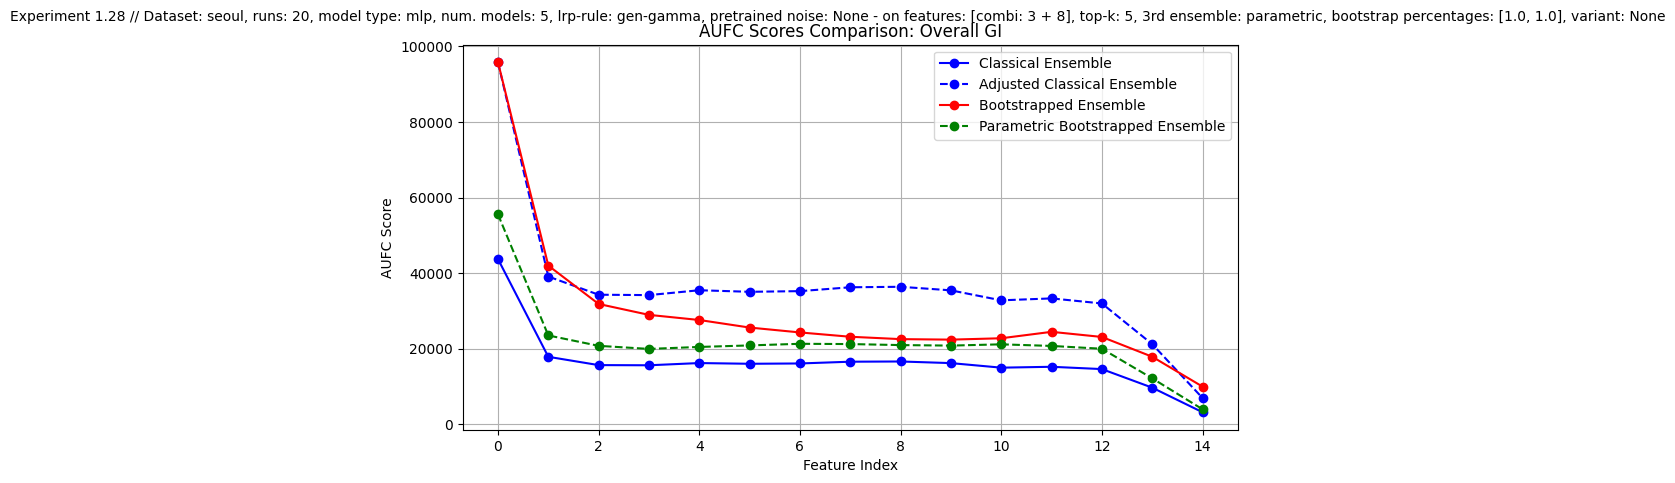

Overall CovGI_diag:


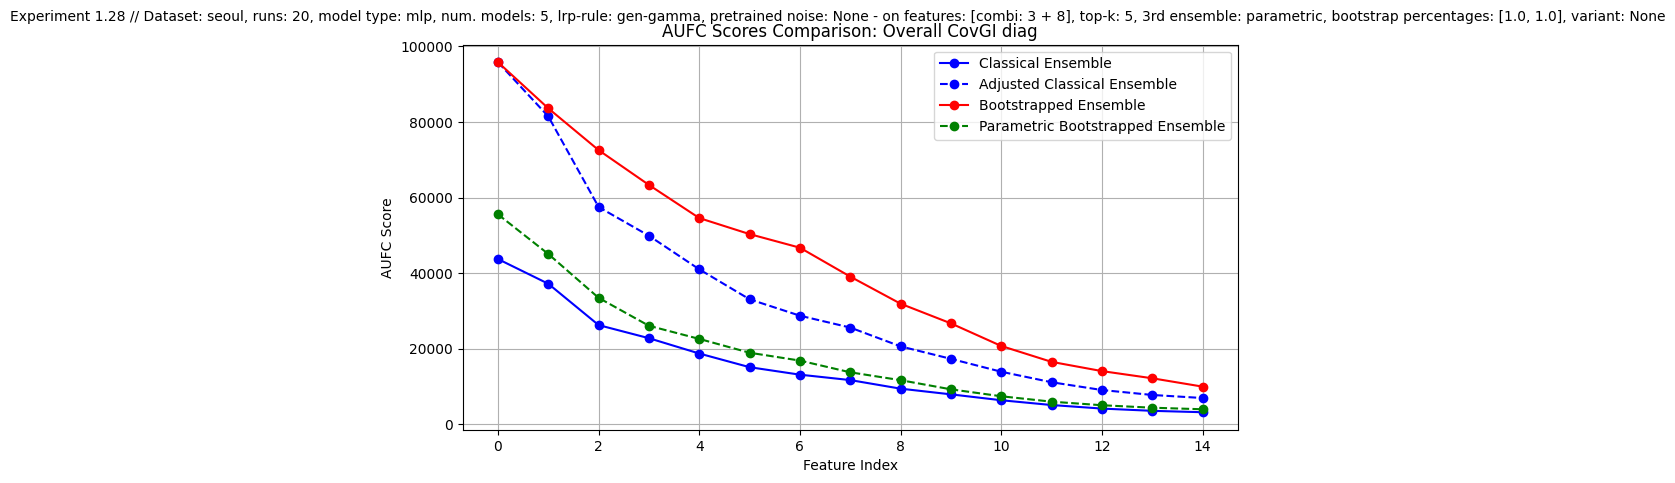

Overall CovGI_marg:


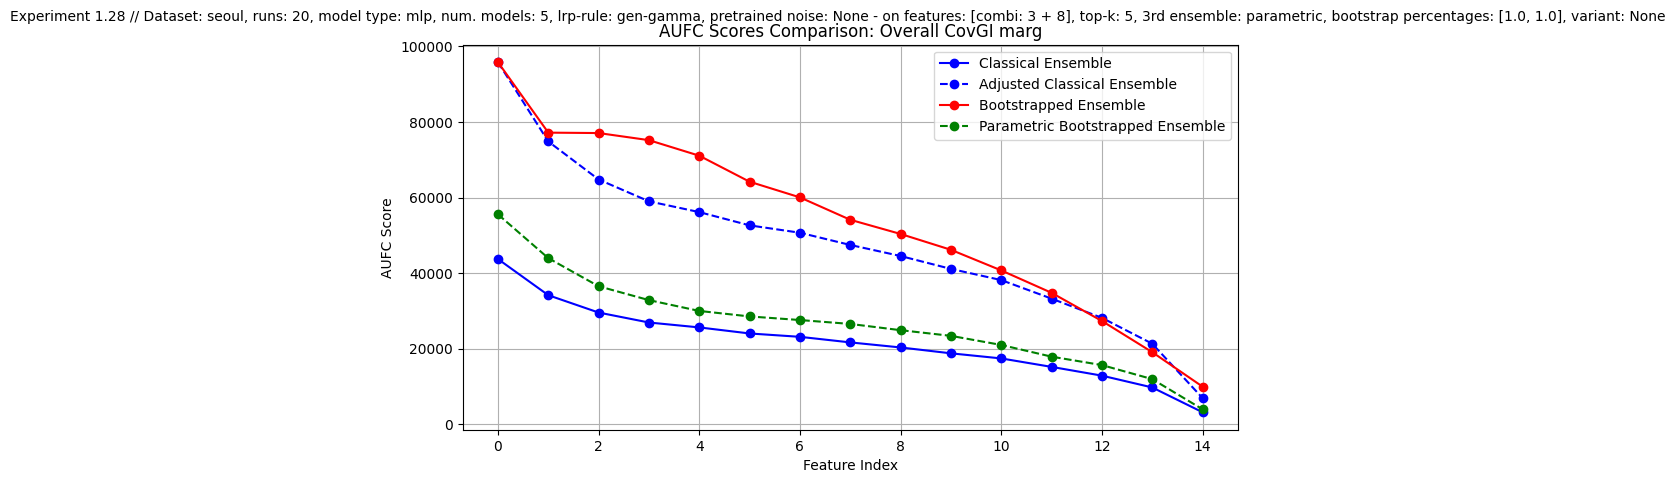

Overall LRP:


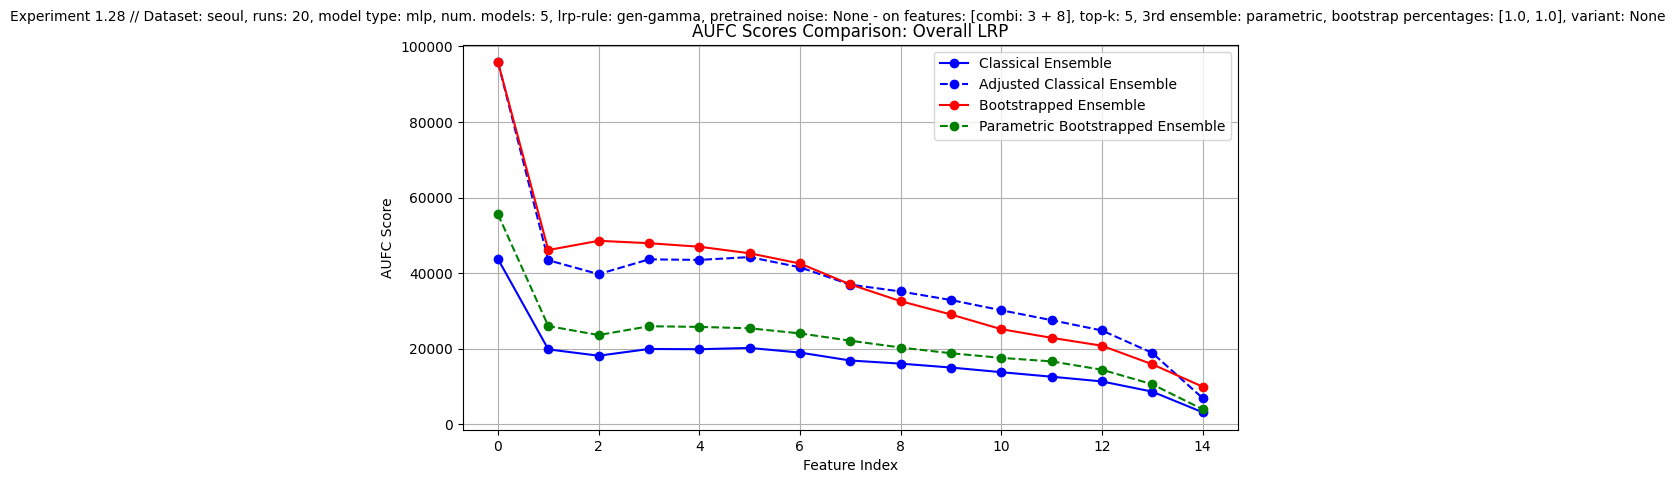

Overall CovLRP_diag:


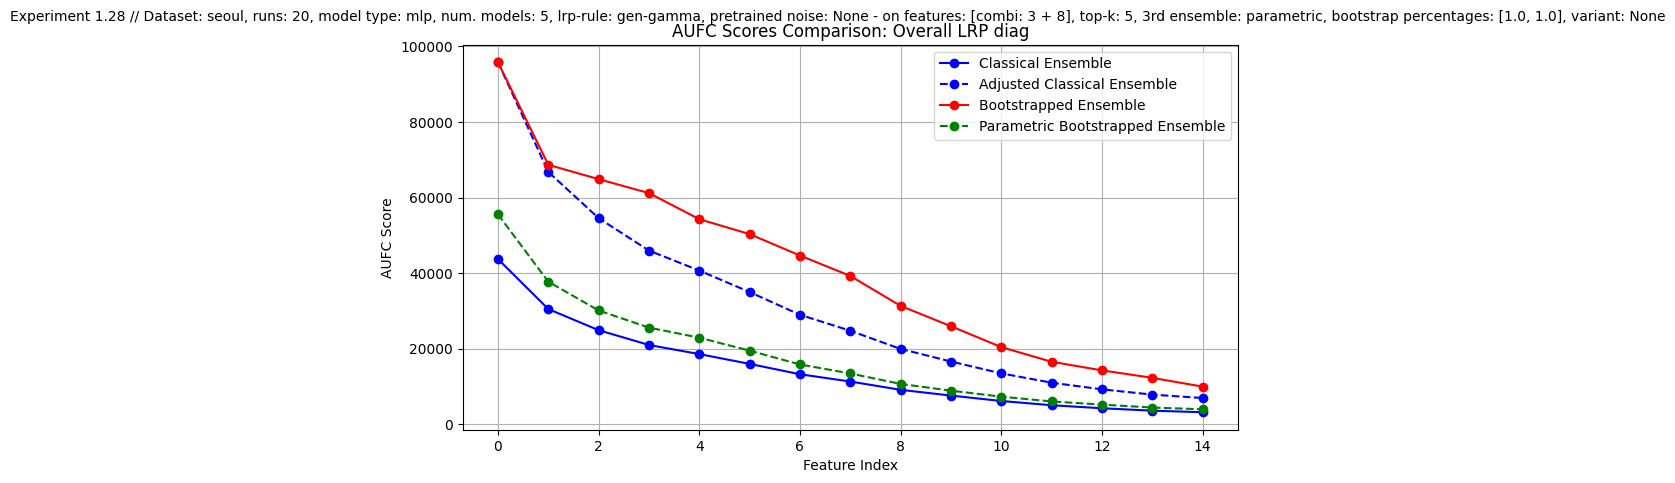

Overall CovLRP_marg:


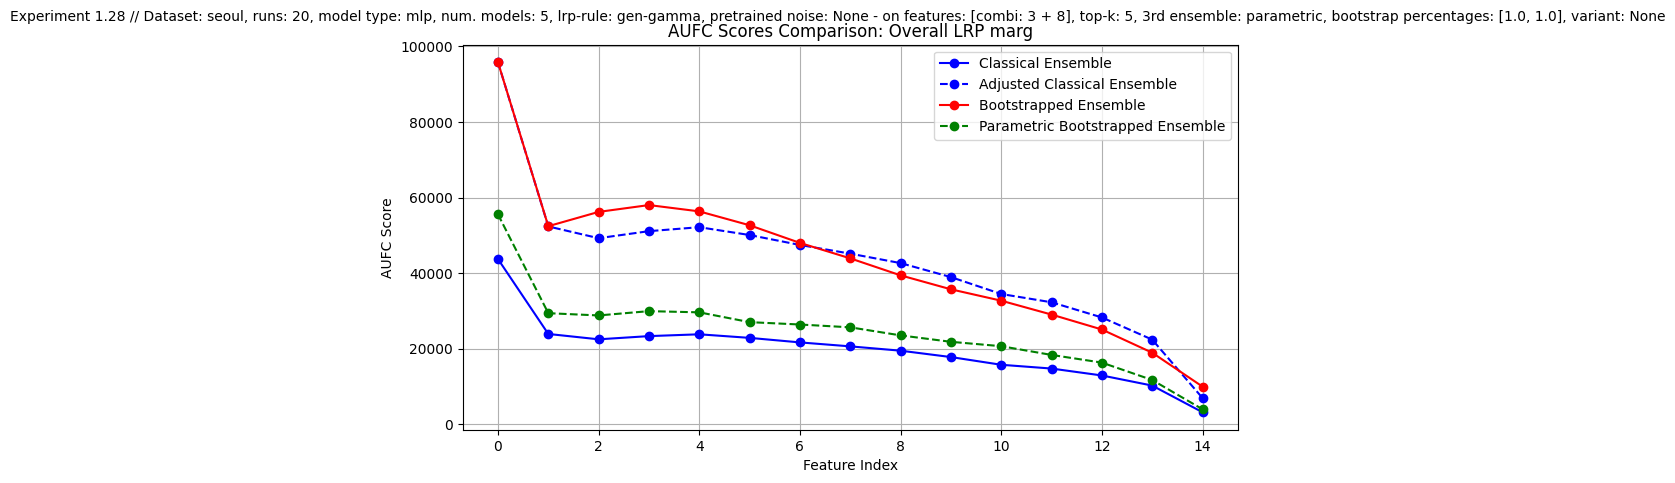

-----------
--------
AUFC (Overall normalized mean across all runs):
-
Classical Ensemble (GI): 0.3698
Classical Ensemble (CovGI diag): 0.3378
Classical Ensemble (CovGI marg): 0.4992
Bootstrapped Ensemble (GI): 0.2912
Bootstrapped Ensemble (CovGI diag): 0.4396
Bootstrapped Ensemble (CovGI marg): 0.5639
Alternating Bootstrapped Ensemble (GI): 0.3784
Alternating Bootstrapped Ensemble (CovGI diag): 0.3228
Alternating Bootstrapped Ensemble (CovGI marg): 0.4817
-
Classical Ensemble (LRP): 0.3863
Classical Ensemble (CovLRP diag): 0.3229
Classical Ensemble (CovLRP marg): 0.4526
Bootstrapped Ensemble (LRP): 0.3858
Bootstrapped Ensemble (CovLRP diag): 0.4192
Bootstrapped Ensemble (CovLRP marg): 0.4520
Alternating Bootstrapped Ensemble (LRP): 0.3879
Alternating Bootstrapped Ensemble (CovLRP diag): 0.3070
Alternating Bootstrapped Ensemble (CovLRP marg): 0.4399
--------
--------
For Augmented Samples (Mean only)
--------
Overall GI:


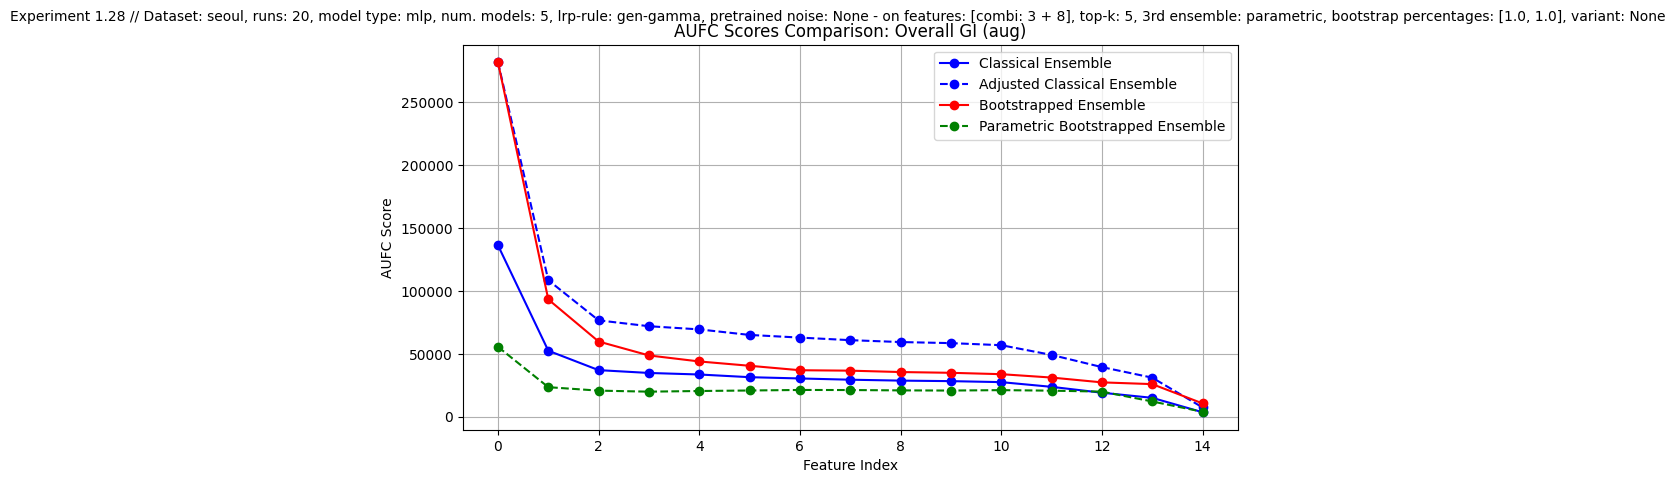

Overall CovGI_diag:


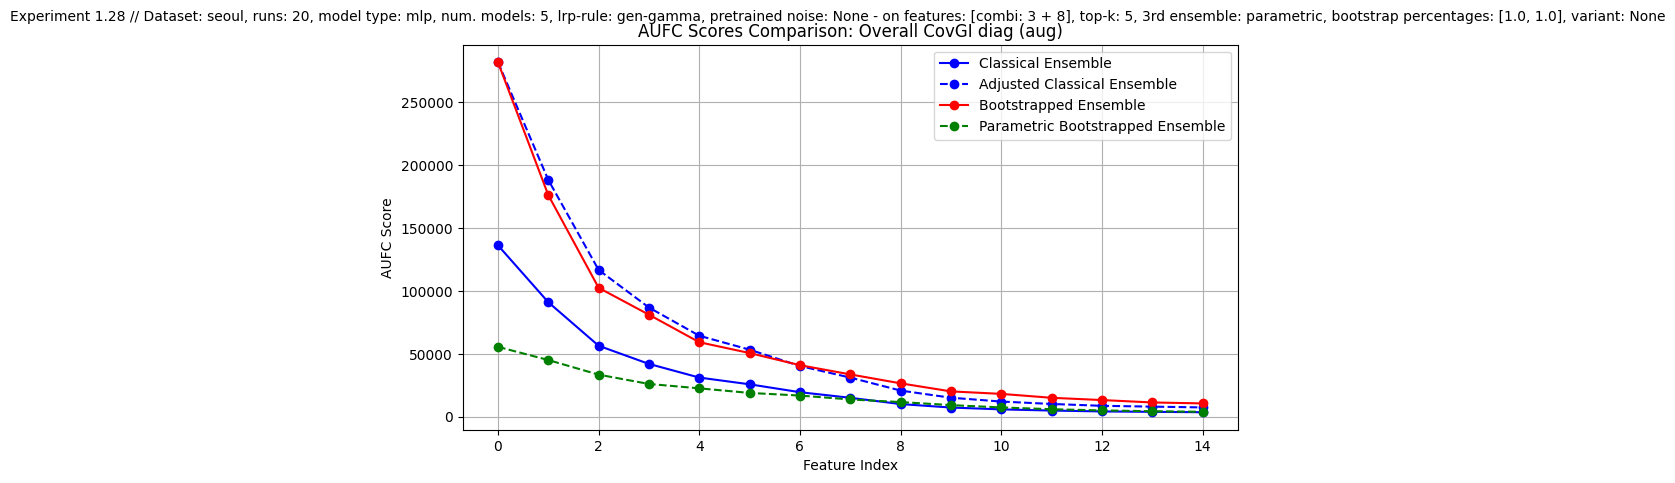

Overall CovGI_marg:


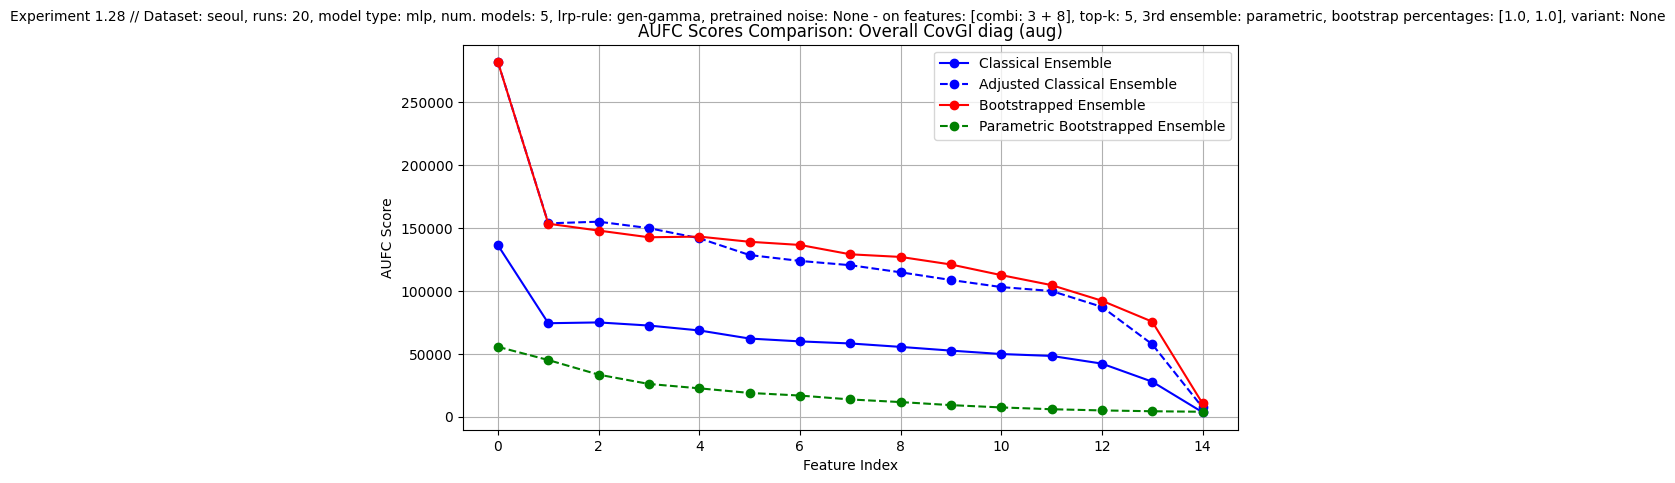

Overall LRP:


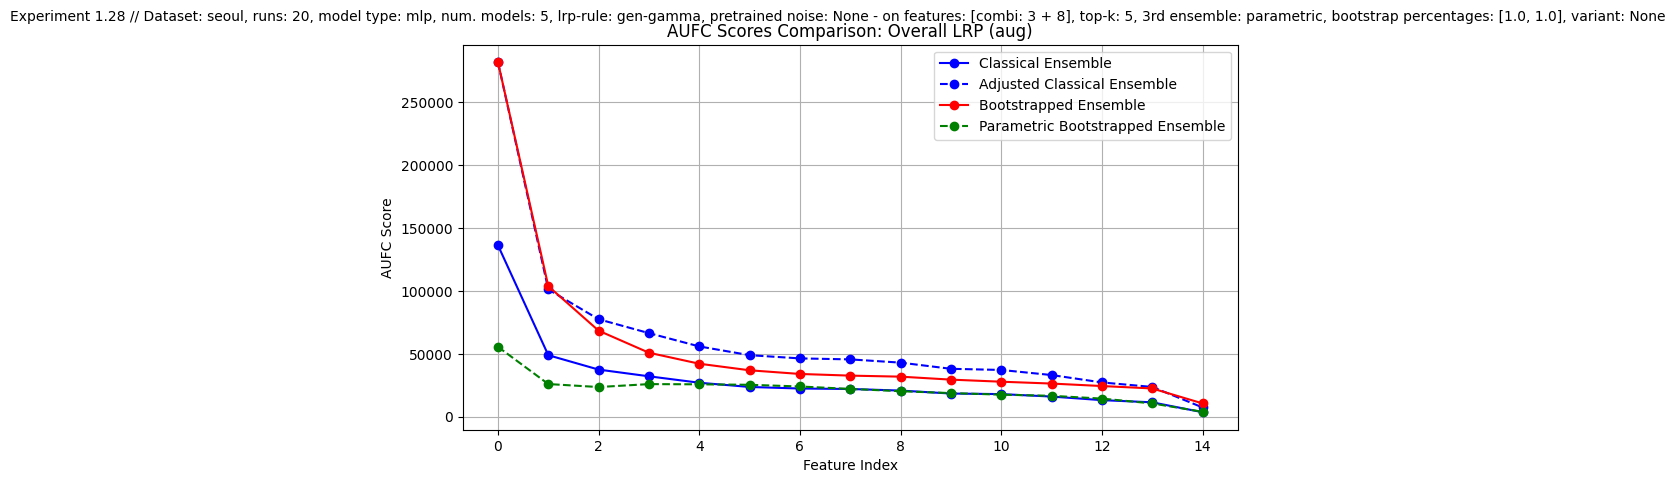

Overall CovLRP_diag:


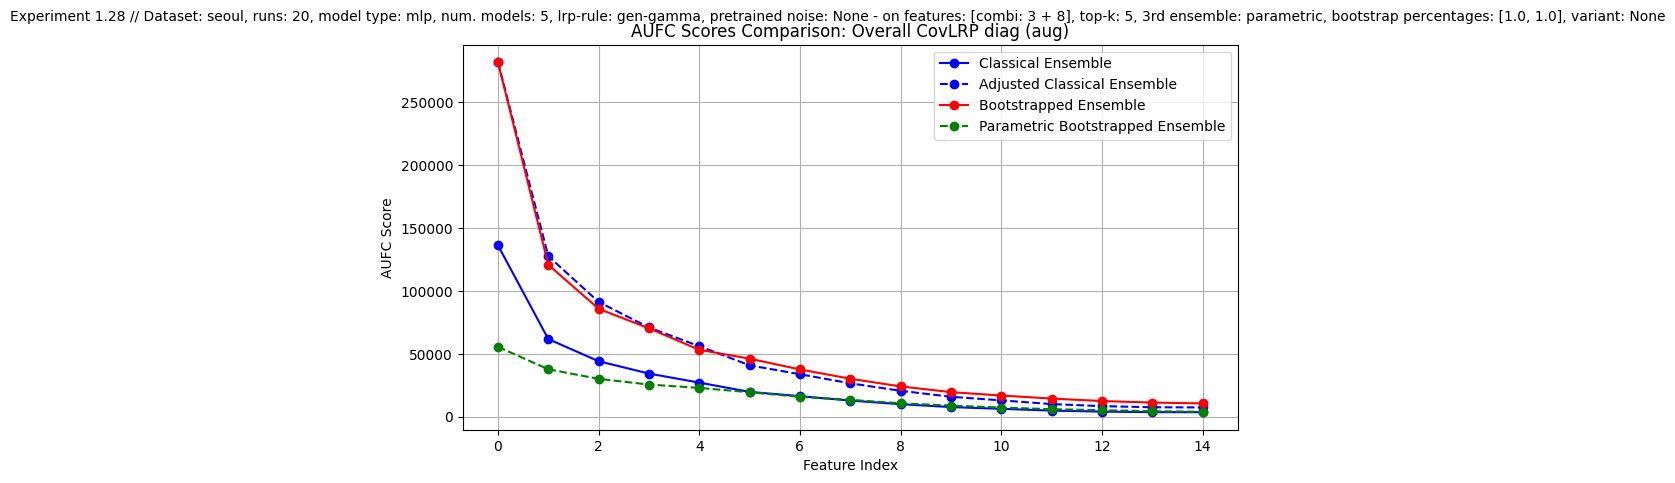

Overall CovLRP_marg:


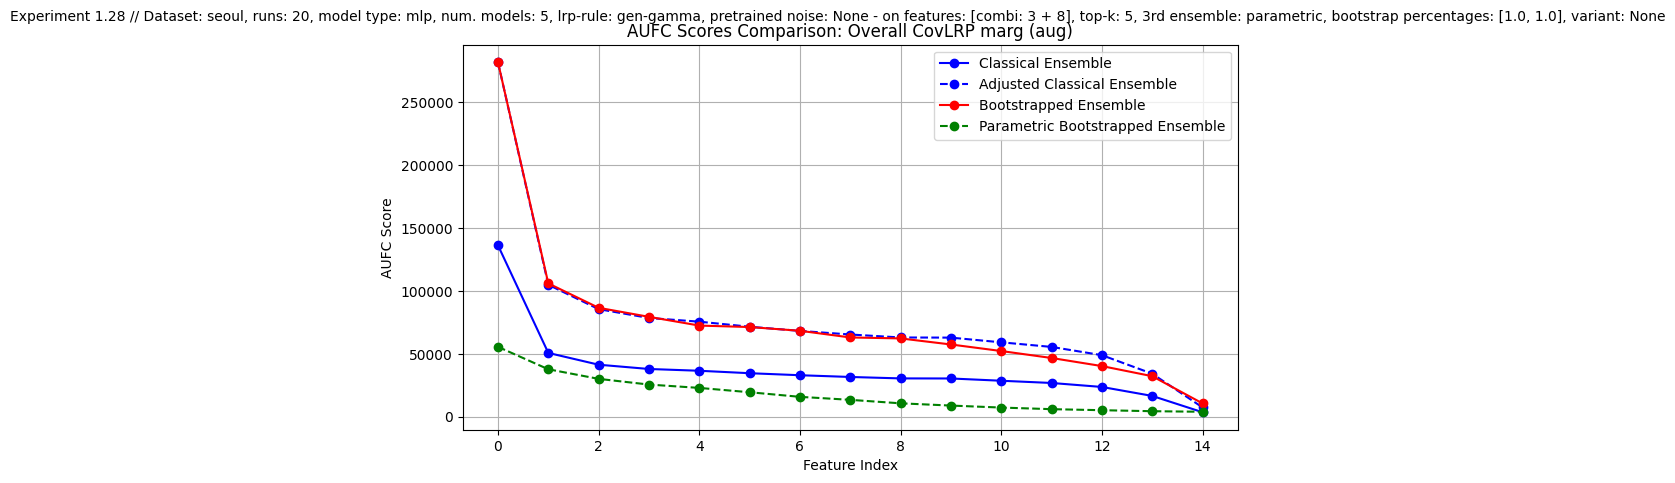

--------
! Augmented AUFC (Overall normalized mean across all runs):
-
Classical Ensemble (GI): 0.2489
Classical Ensemble (CovGI diag): 0.2083
Classical Ensemble (CovGI marg): 0.4535
Bootstrapped Ensemble (GI): 0.1879
Bootstrapped Ensemble (CovGI diag): 0.2140
Bootstrapped Ensemble (CovGI marg): 0.4966
Alternating Bootstrapped Ensemble (GI): 0.3784
Alternating Bootstrapped Ensemble (CovGI diag): 0.3228
Alternating Bootstrapped Ensemble (CovGI marg): 0.4817
-
Classical Ensemble (LRP): 0.2063
Classical Ensemble (CovLRP diag): 0.1747
Classical Ensemble (CovLRP marg): 0.2711
Bootstrapped Ensemble (LRP): 0.1844
Bootstrapped Ensemble (CovLRP diag): 0.1874
Bootstrapped Ensemble (CovLRP marg): 0.2672
Alternating Bootstrapped Ensemble (LRP): 0.3879
Alternating Bootstrapped Ensemble (CovLRP diag): 0.3070
Alternating Bootstrapped Ensemble (CovLRP marg): 0.4399
-------
Further insights:
-------
Feature Means: tensor([-0.0049, -0.0111,  0.0050, -0.0080, -0.0104, -0.0075, -0.0060,  0.0143,
         

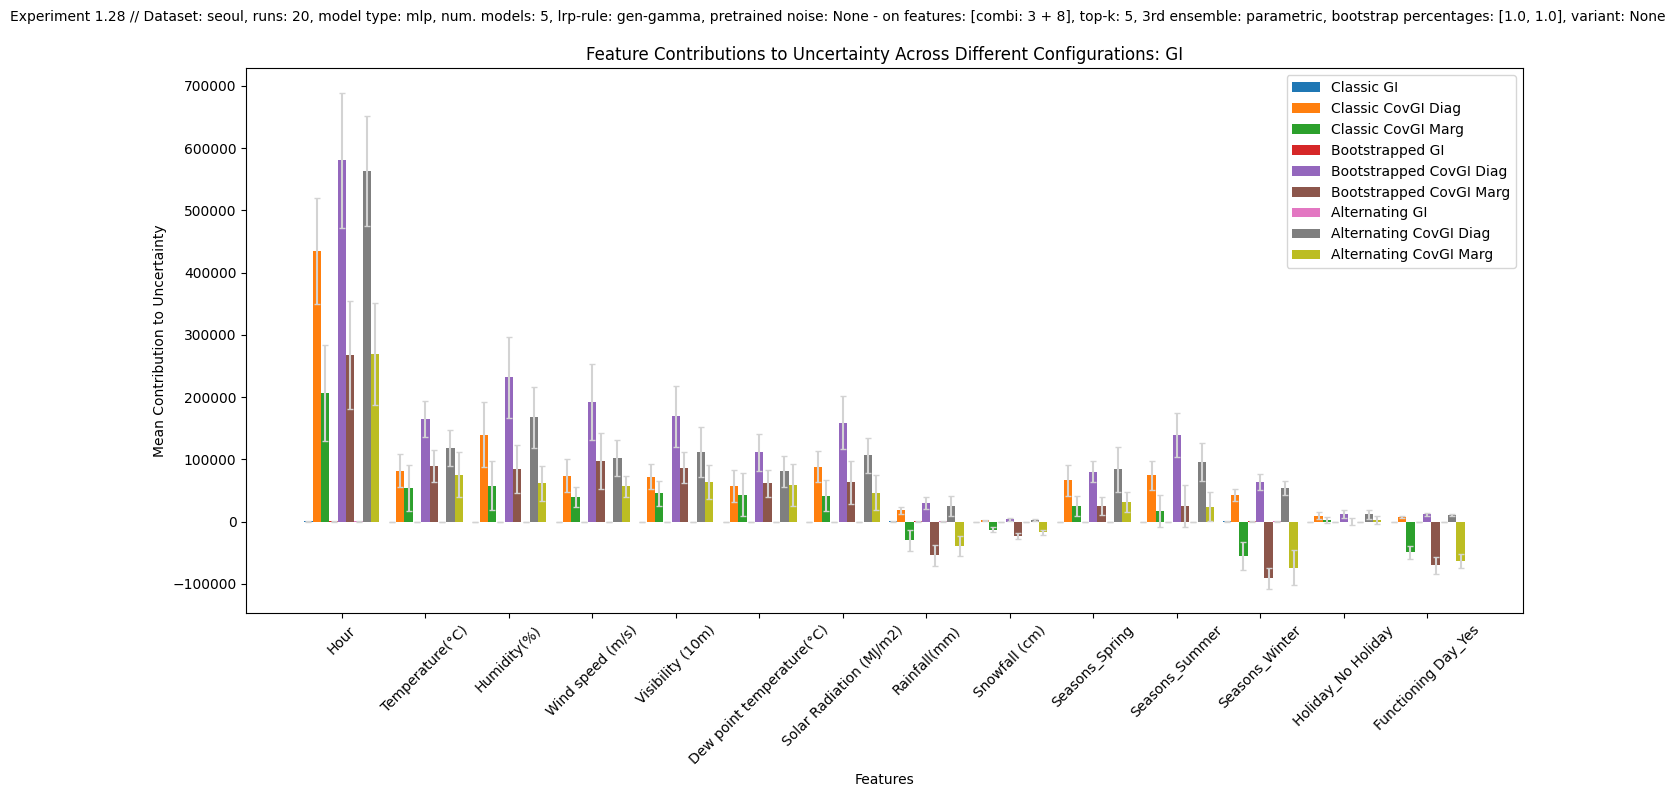

GI aug:


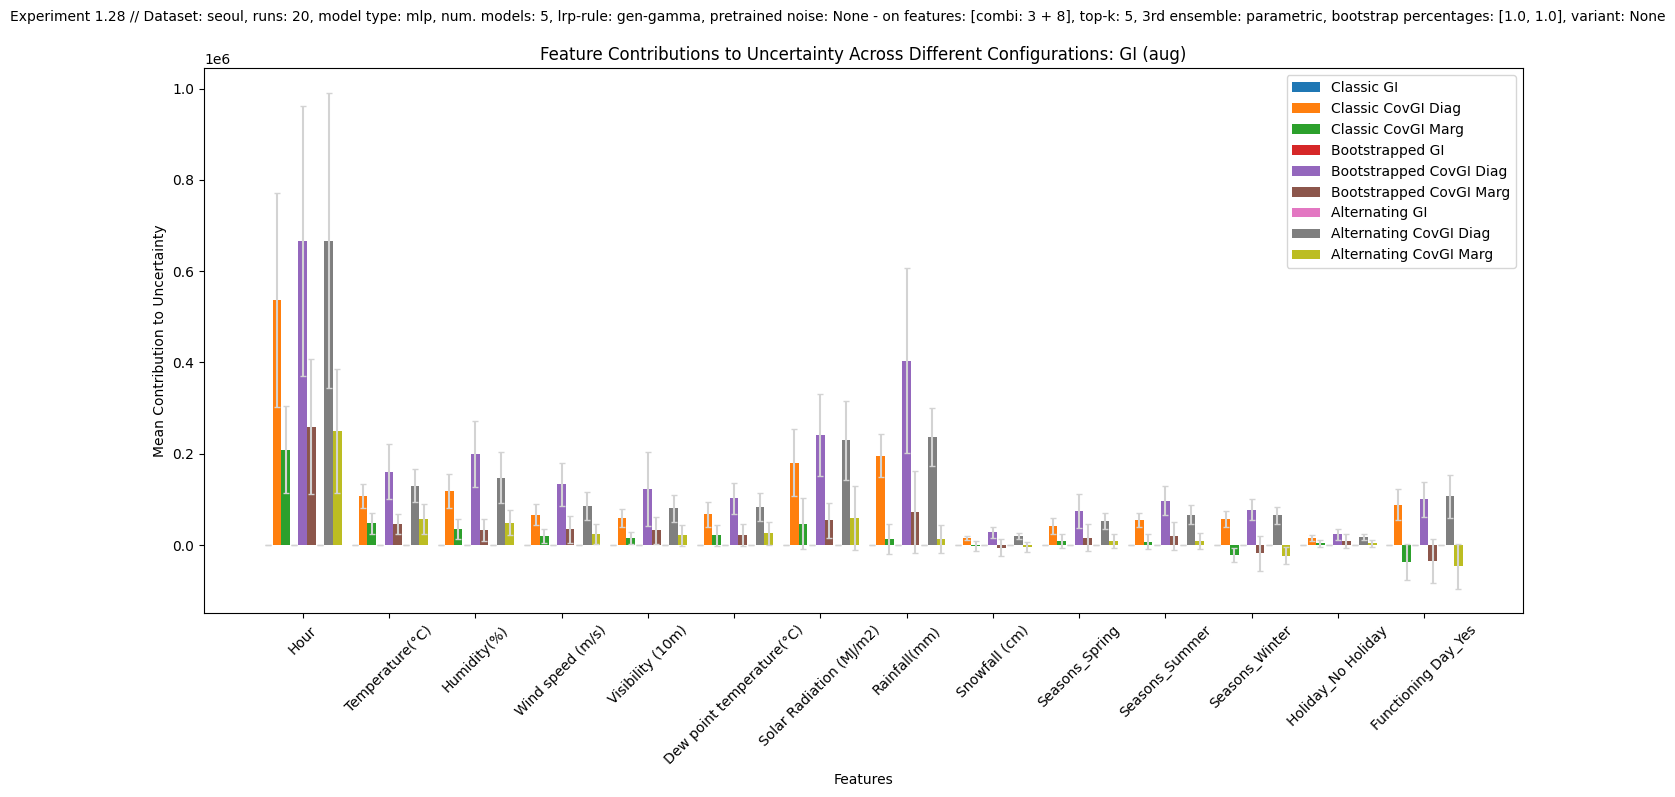

LRP:


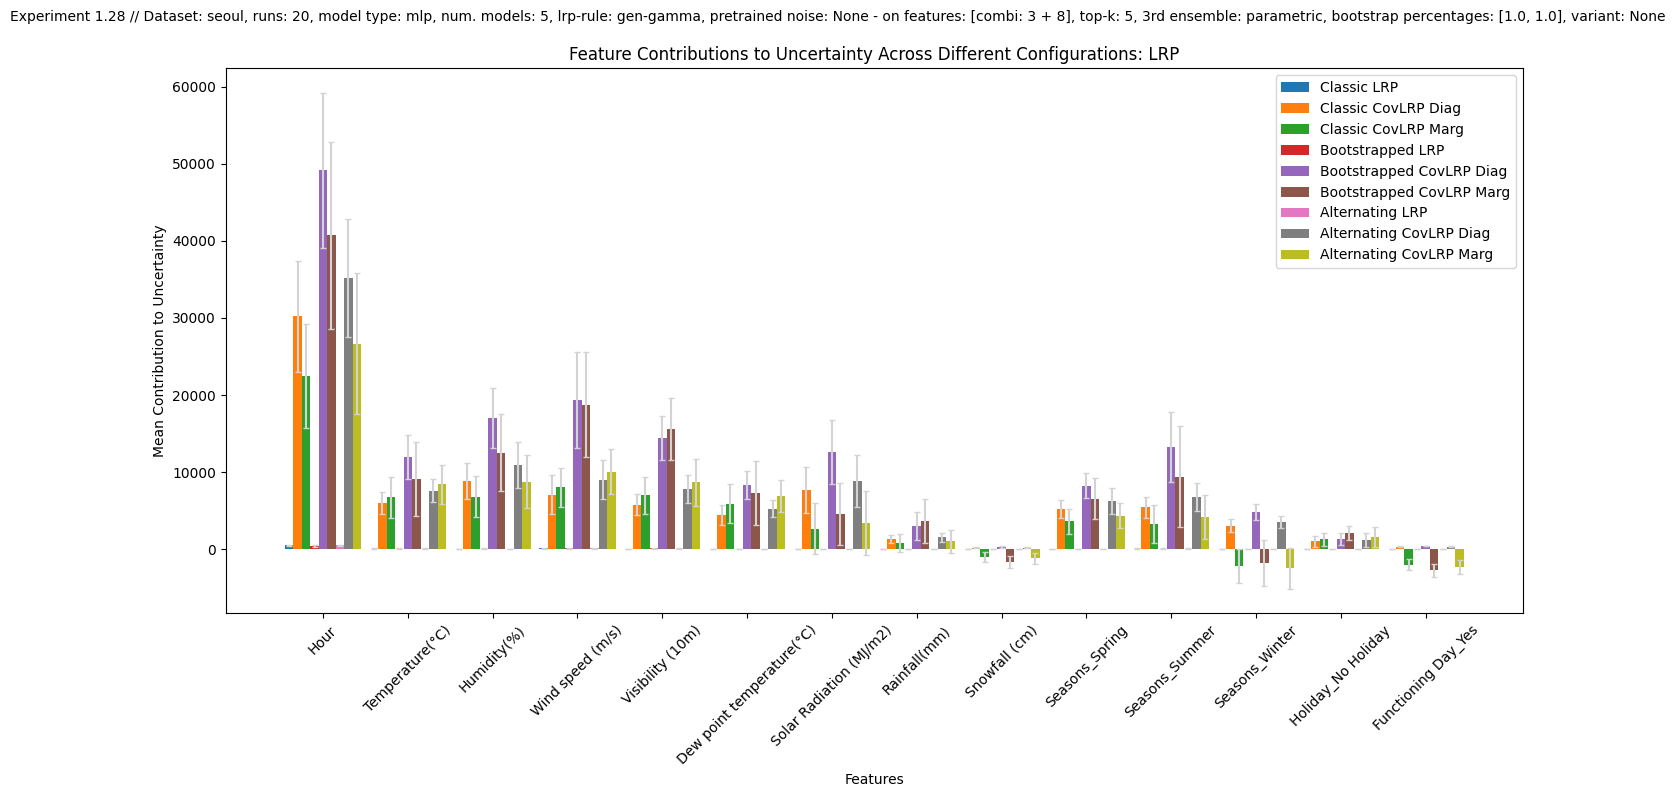

LRP aug:


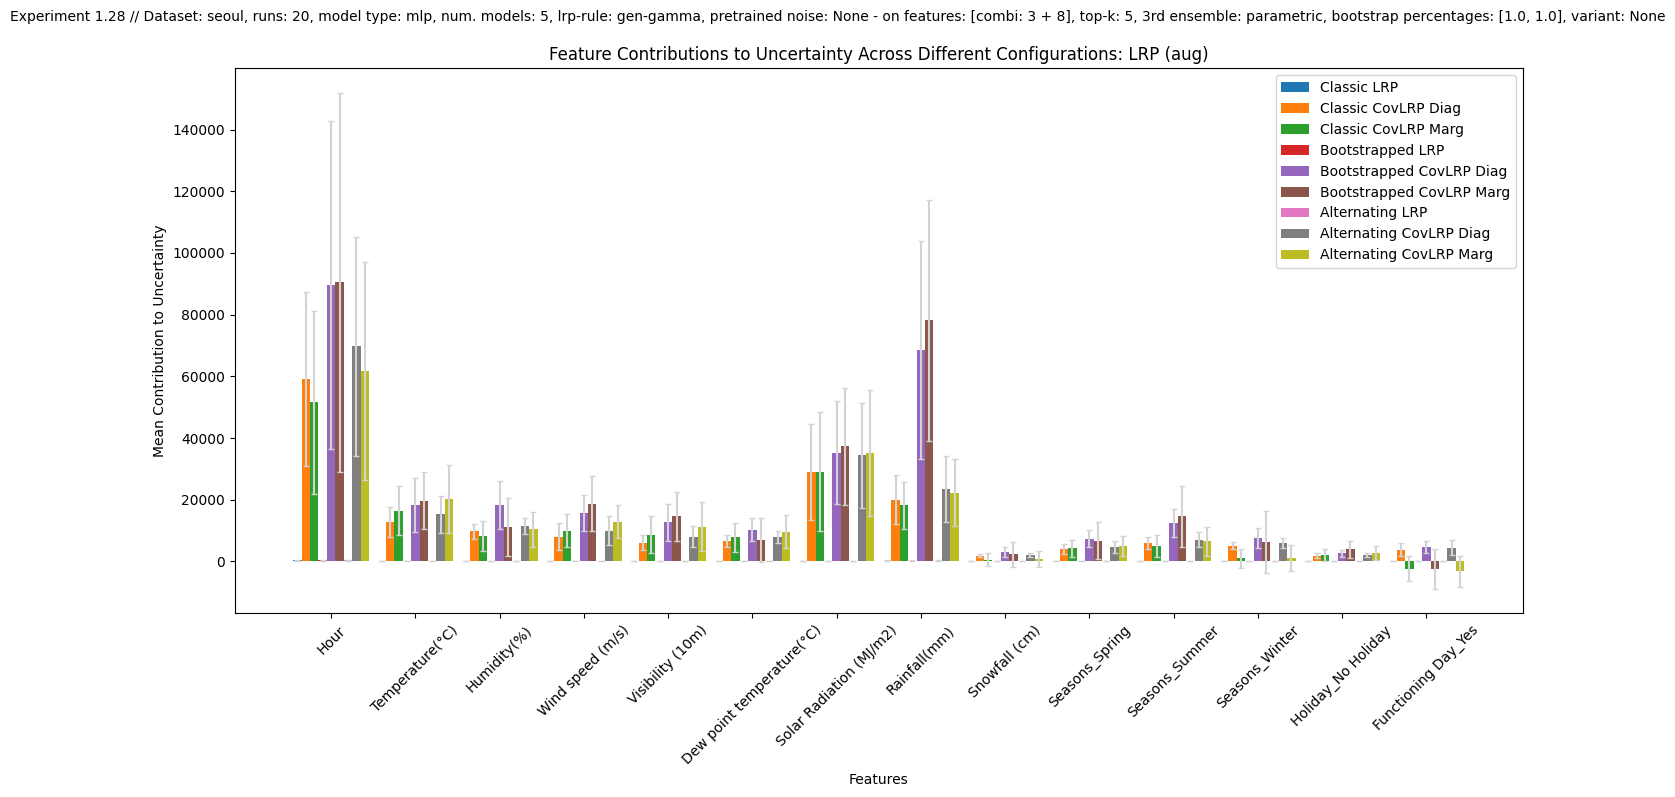

-------
Global min (gi): -119926.2734375
Global max (gi): 882973.0625
Global min (lrp): -11798.53515625
Global max (lrp): 77867.40625


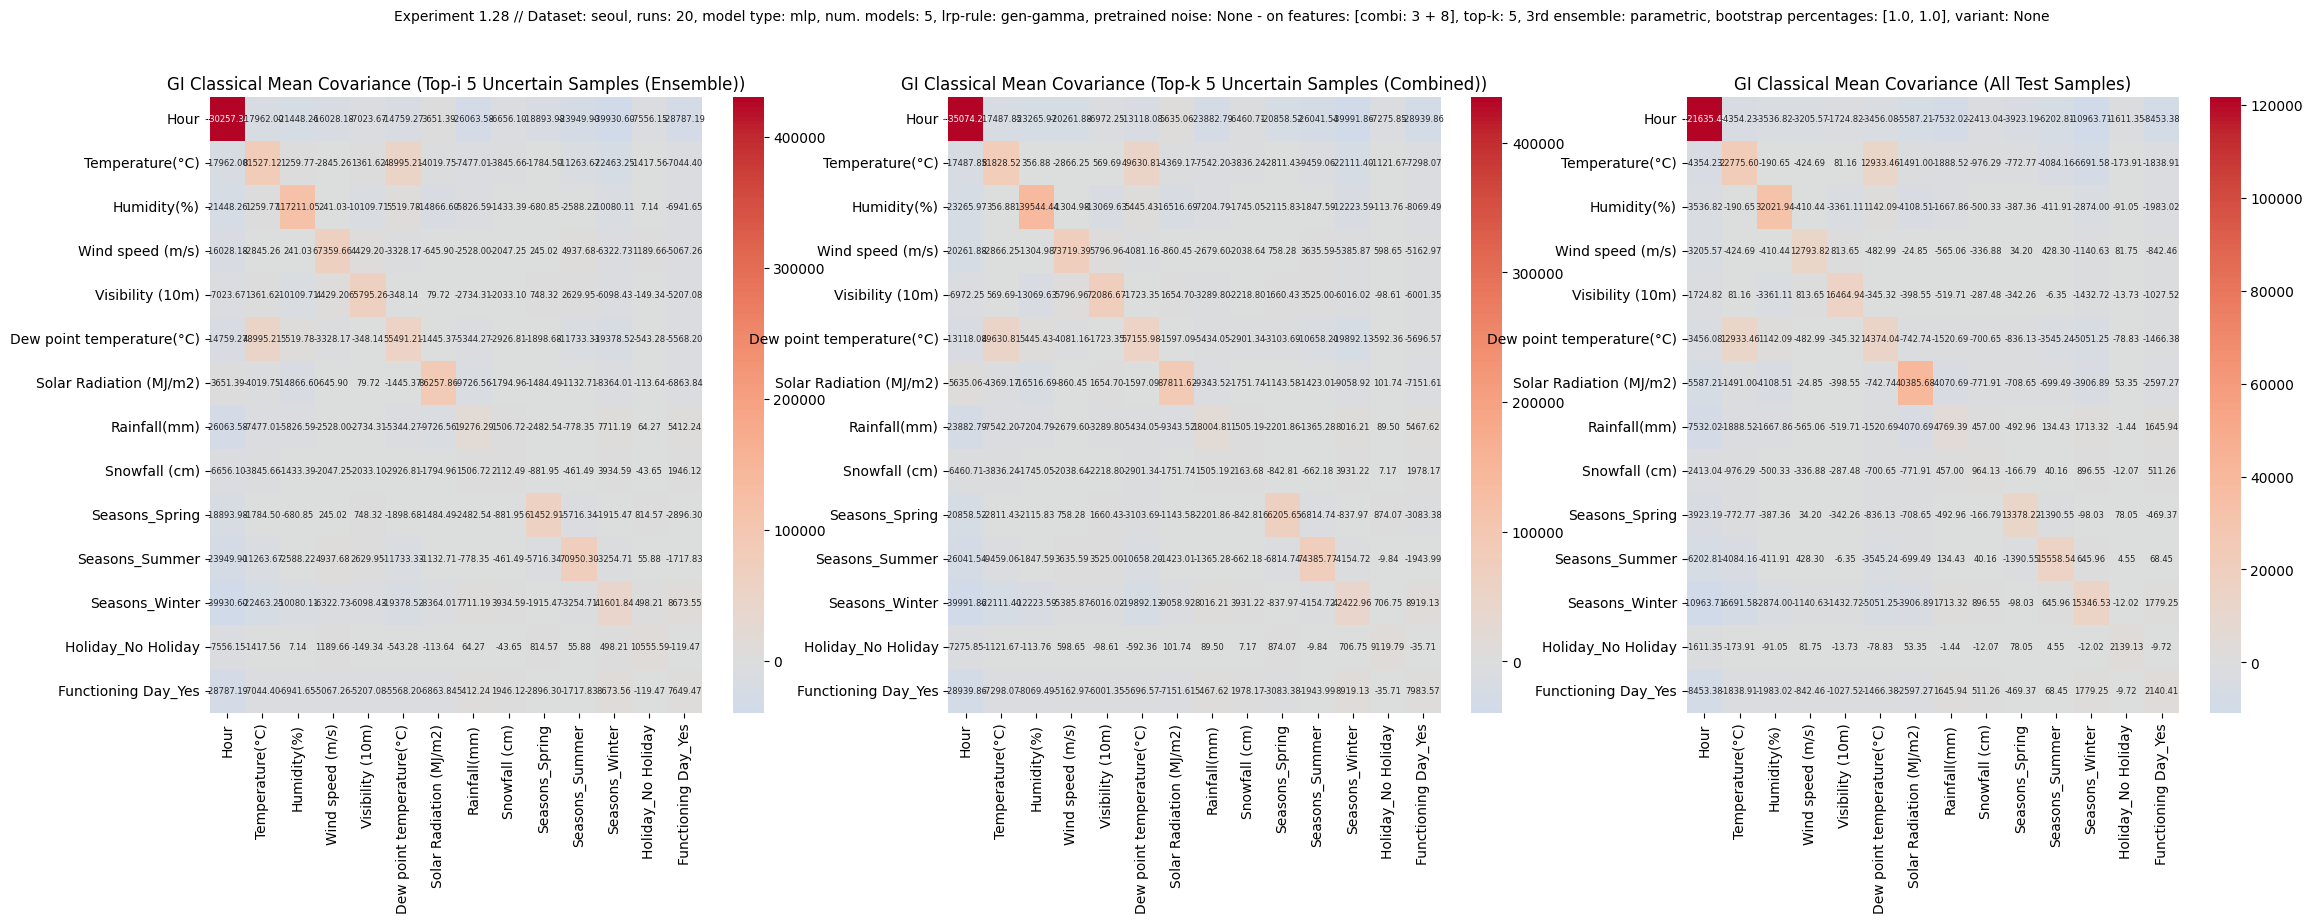

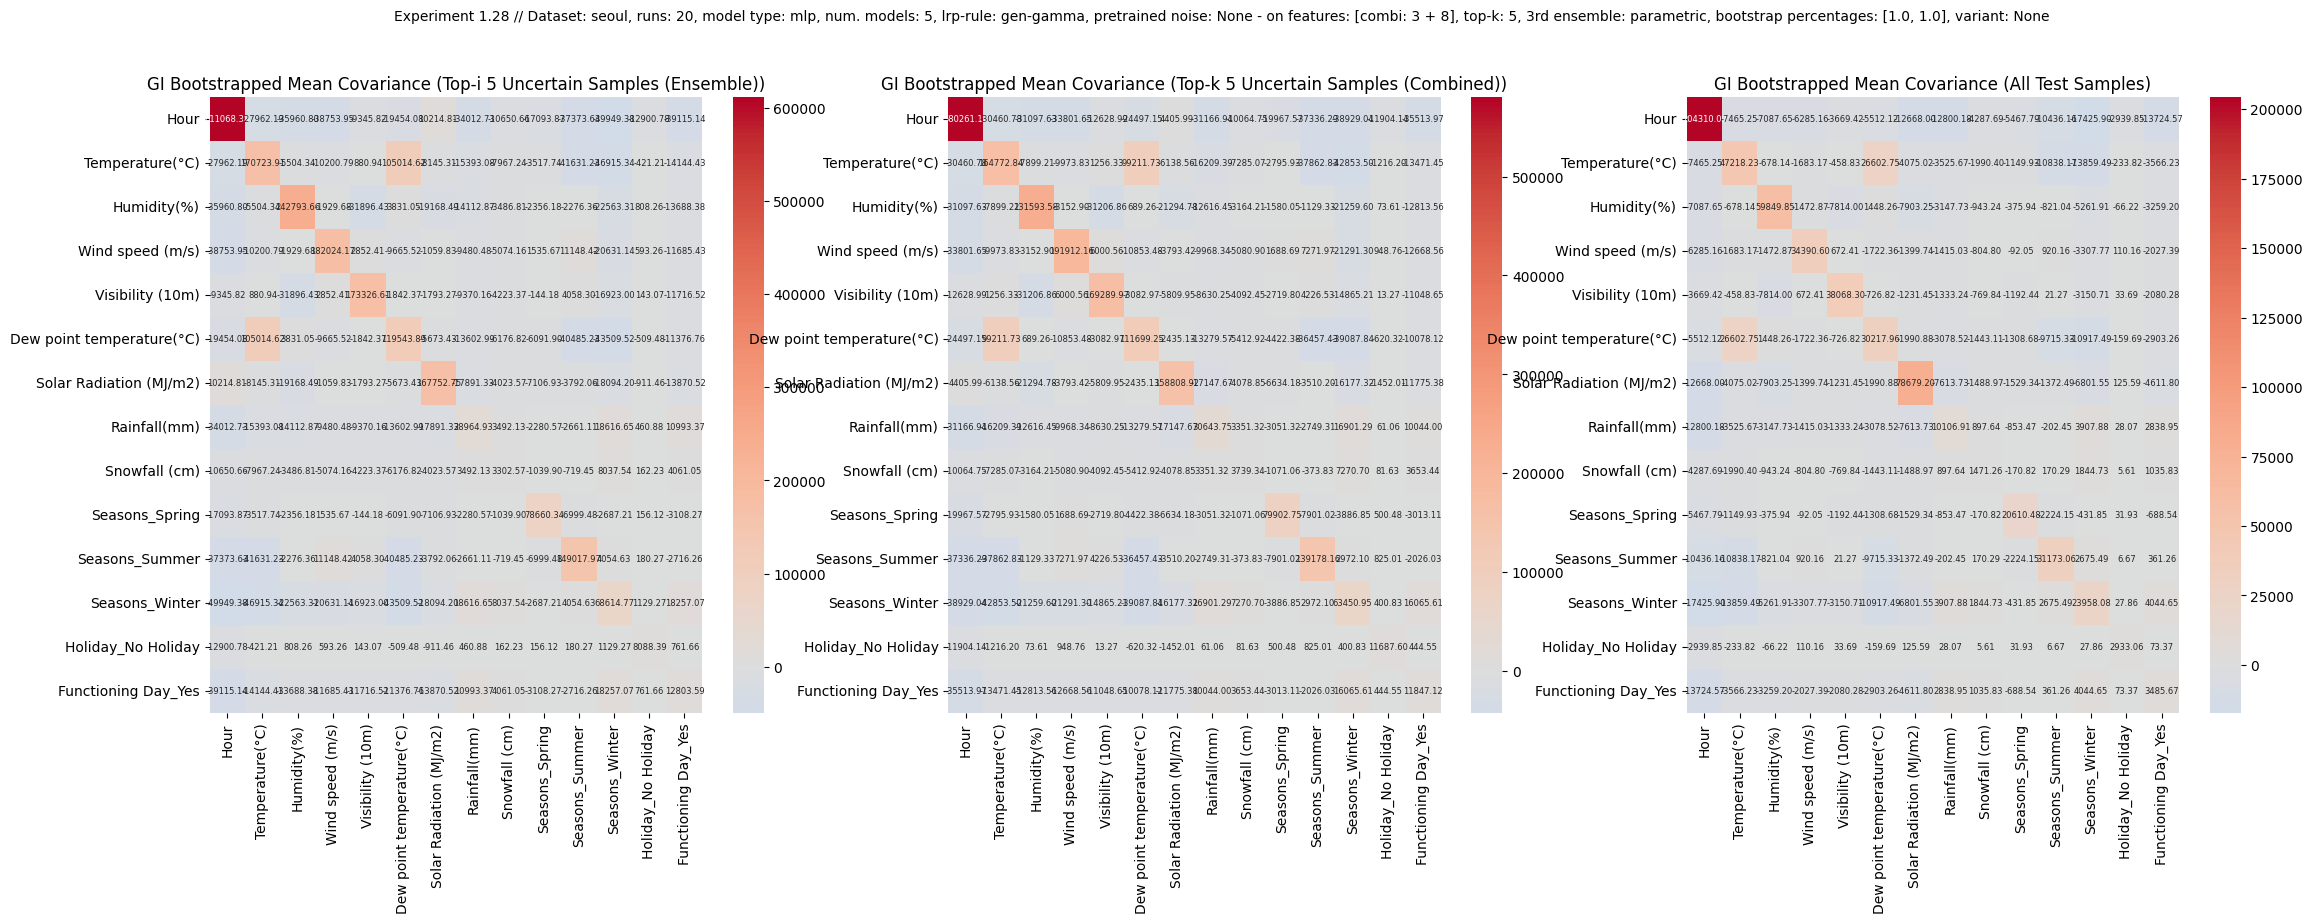

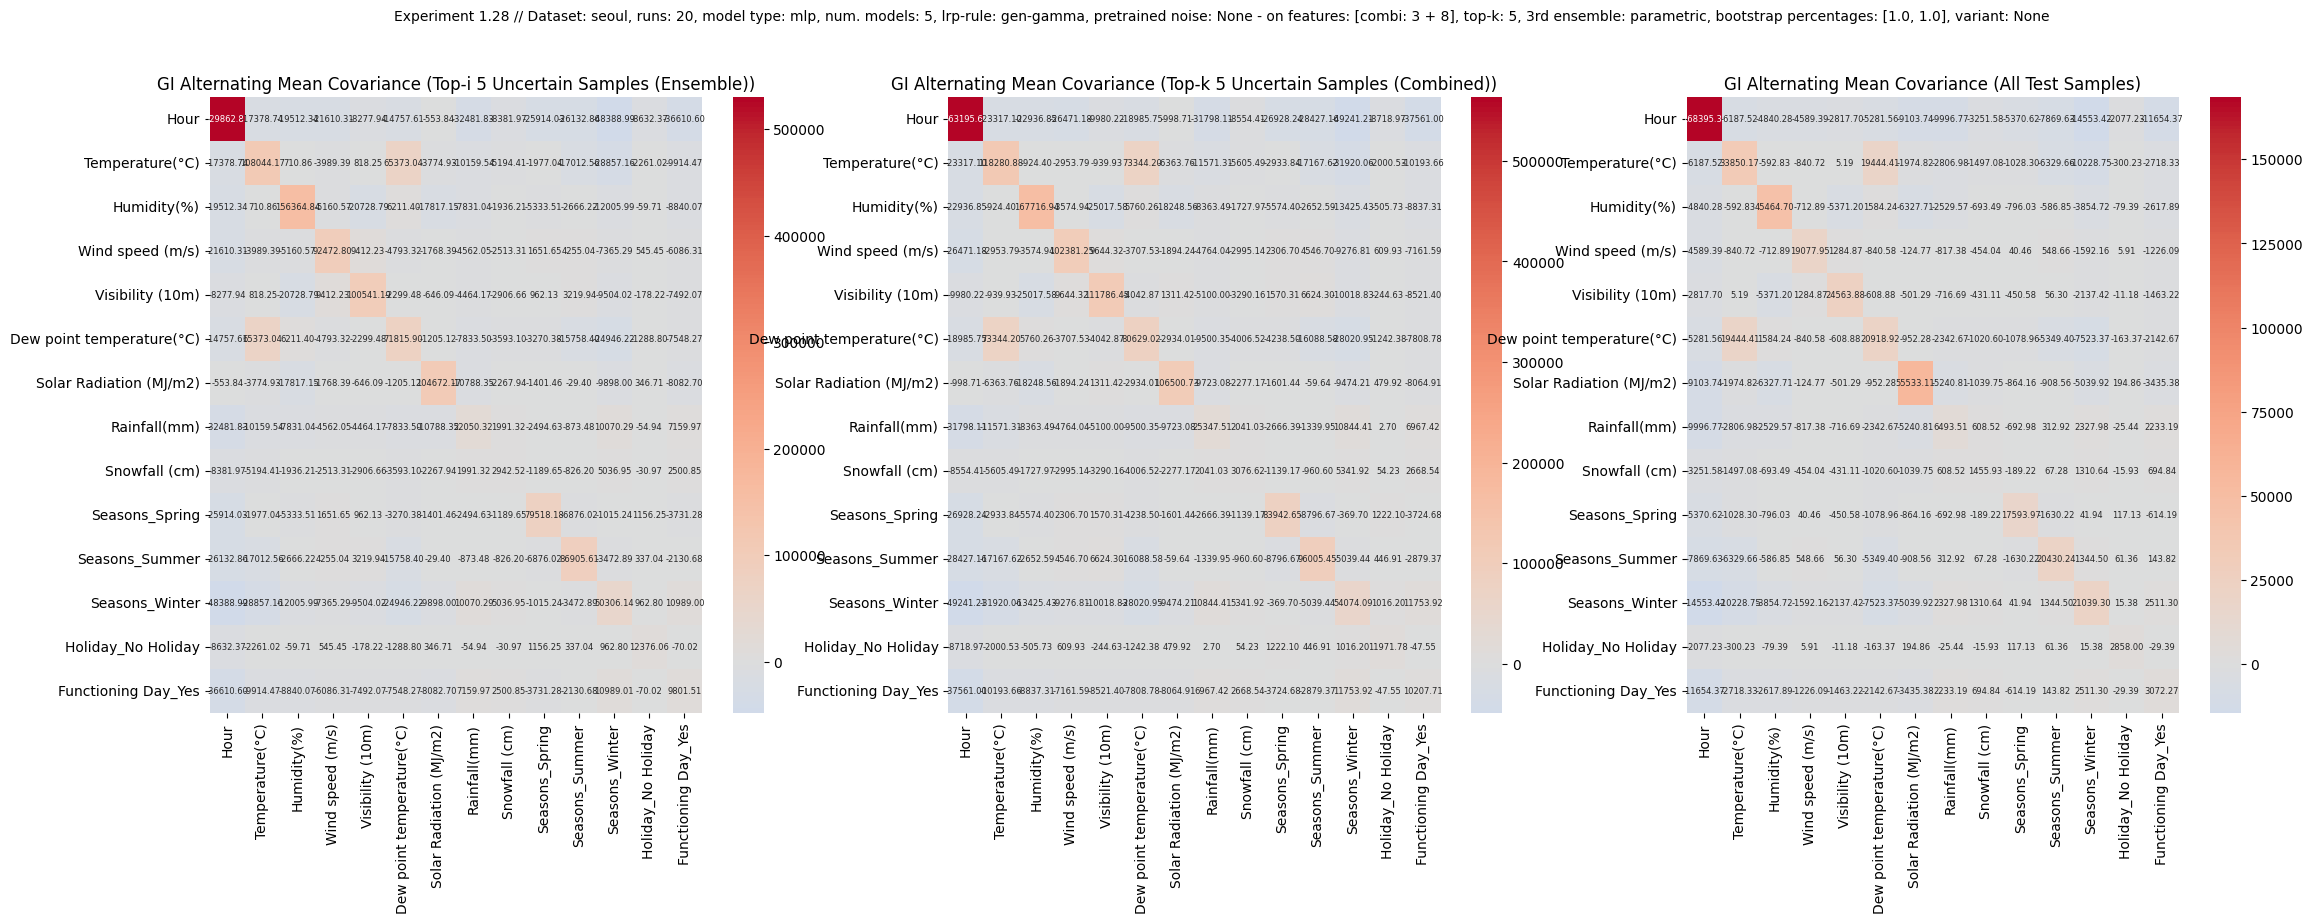

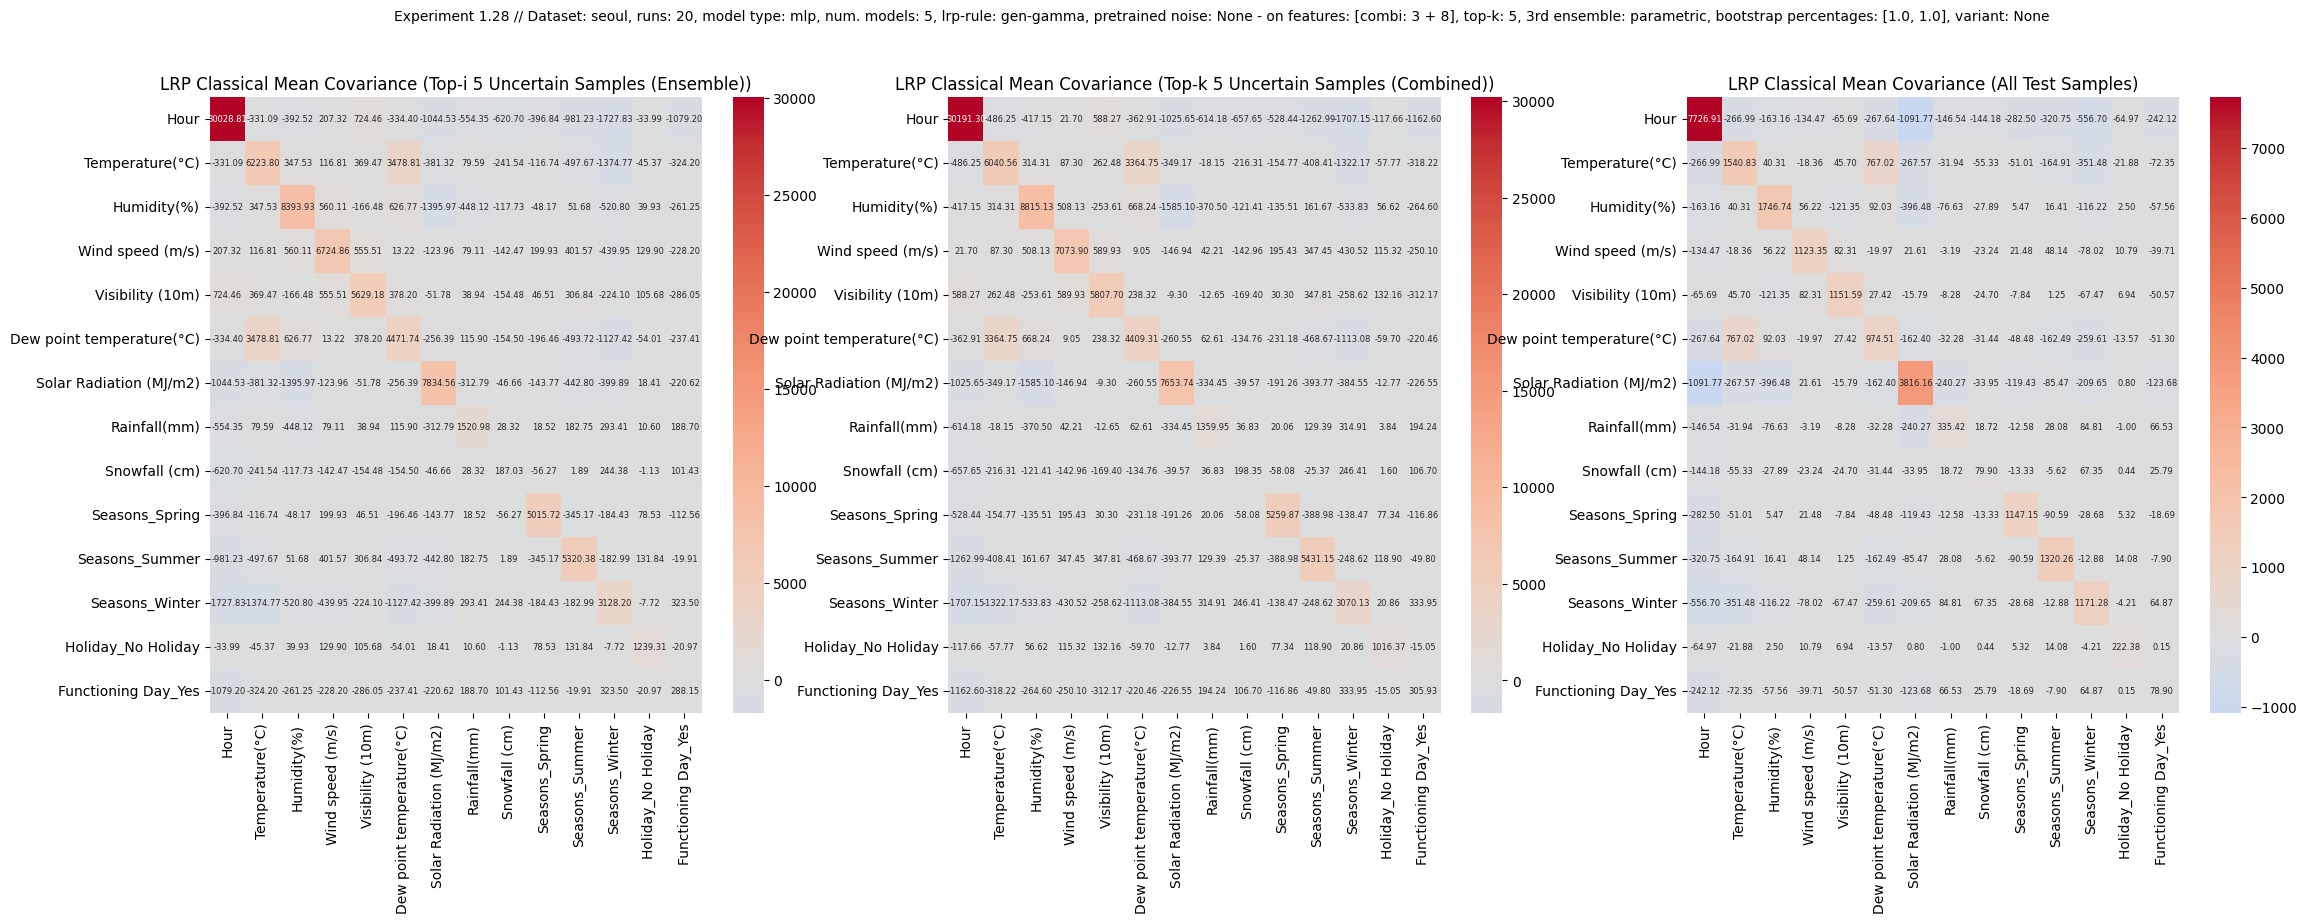

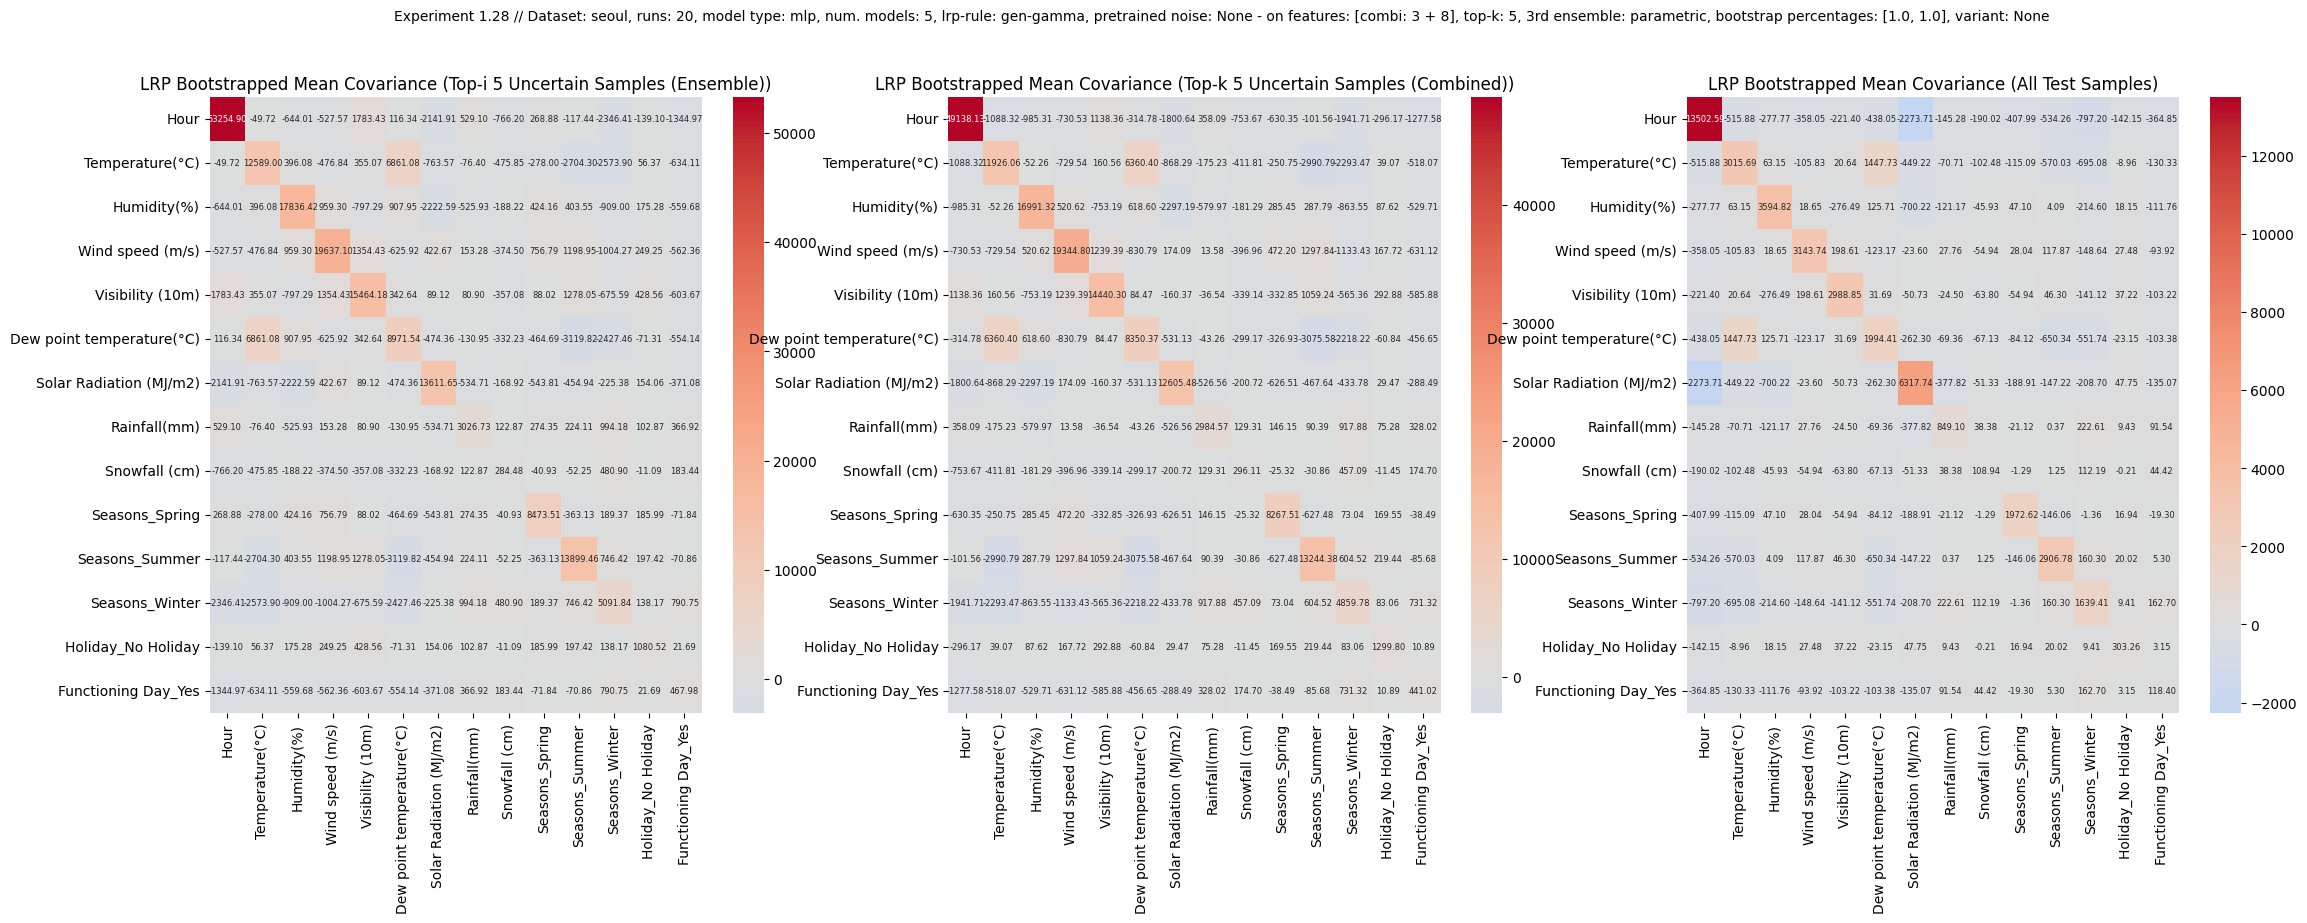

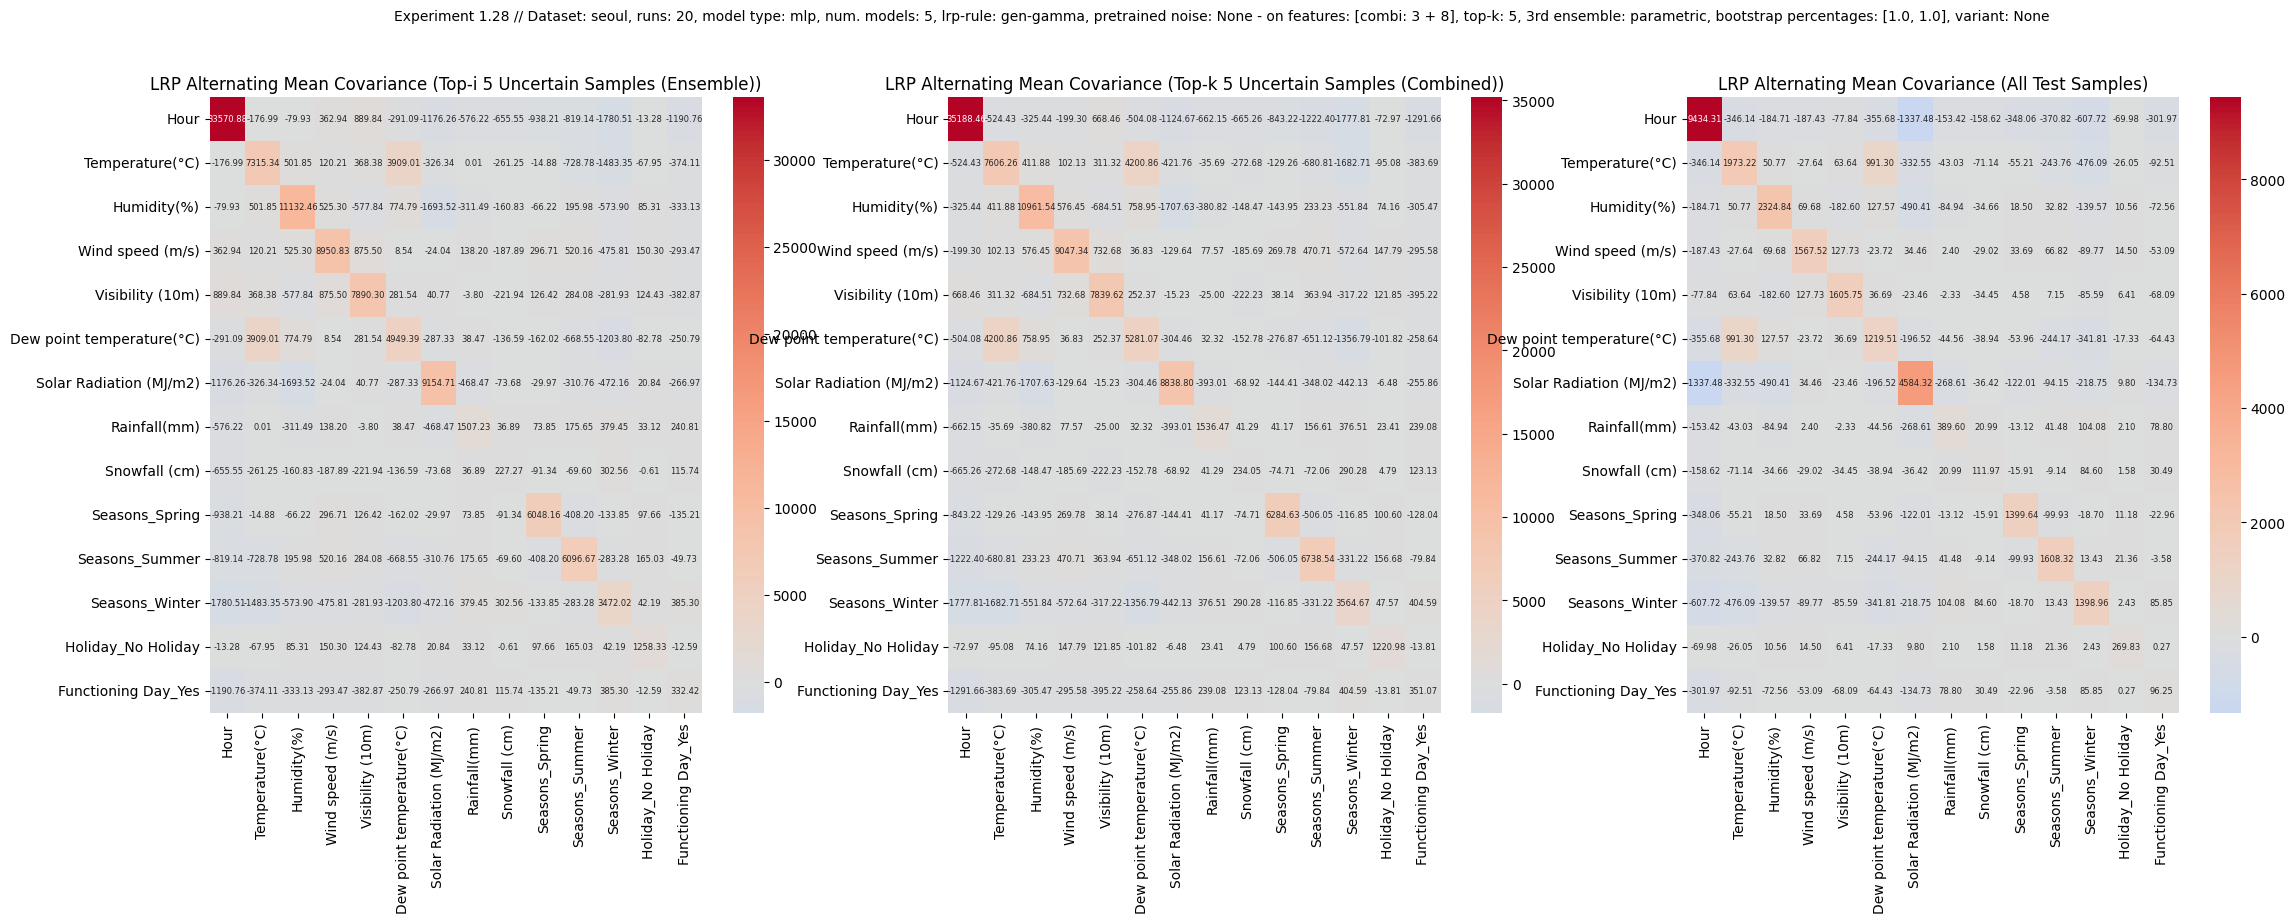

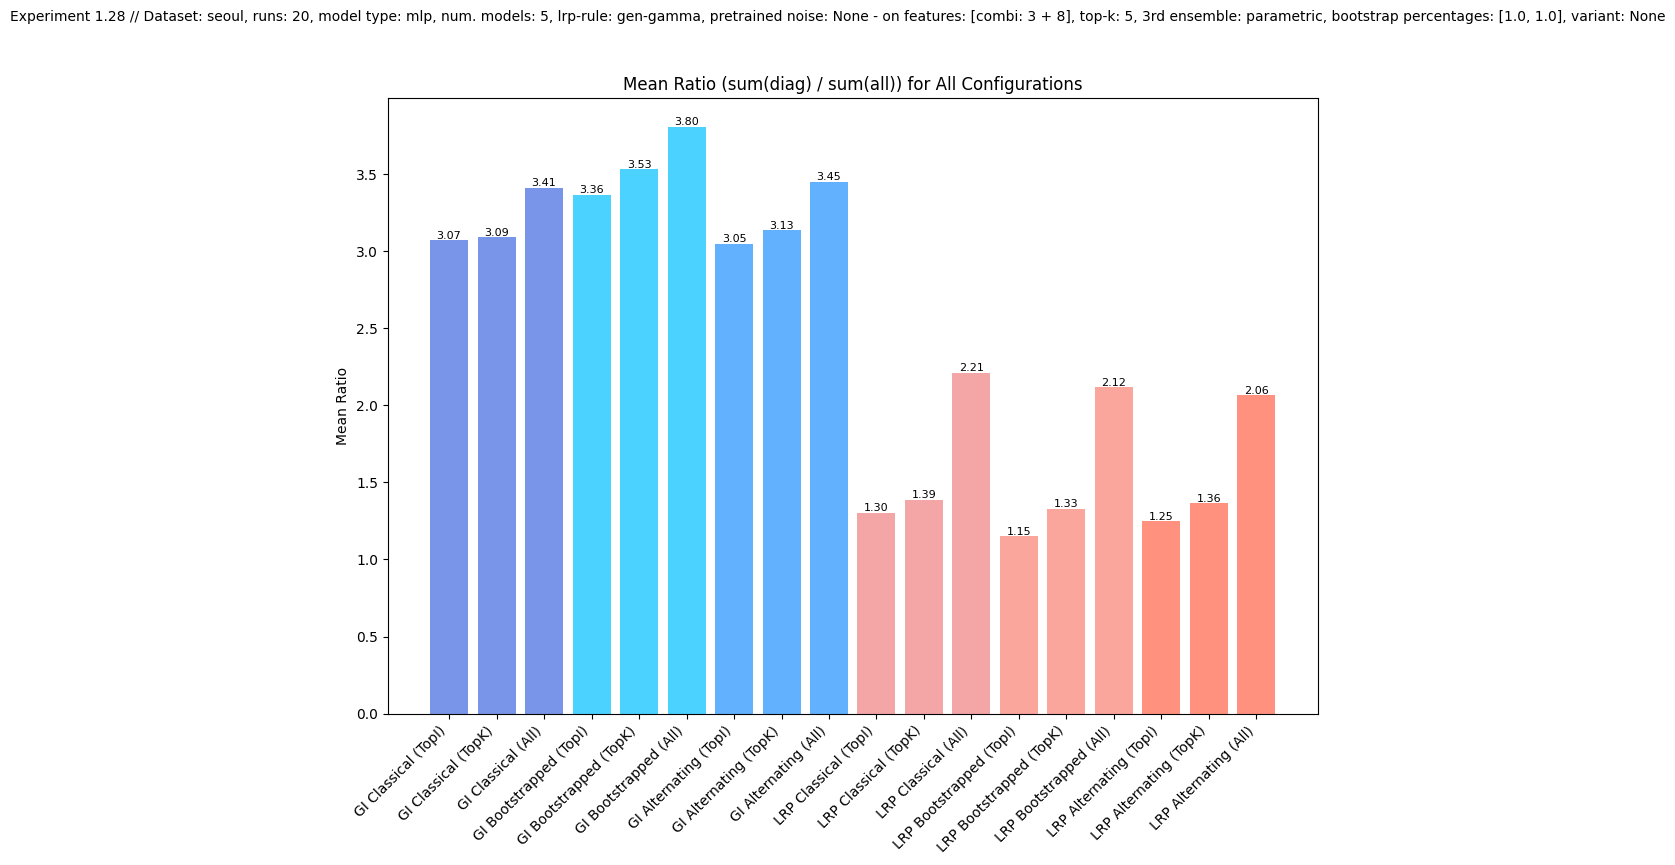

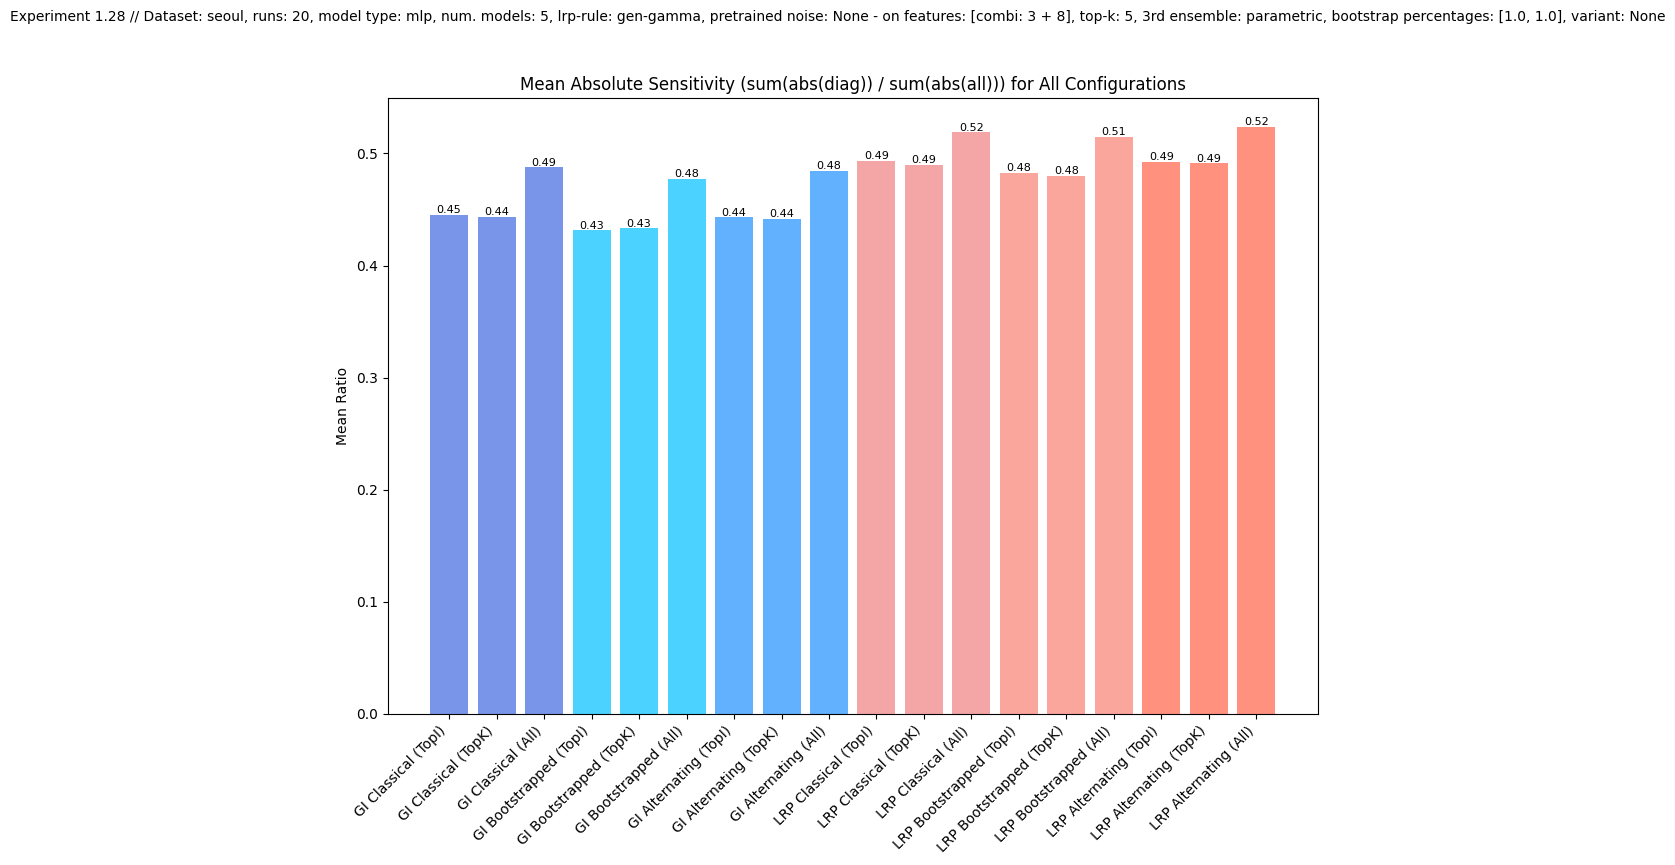

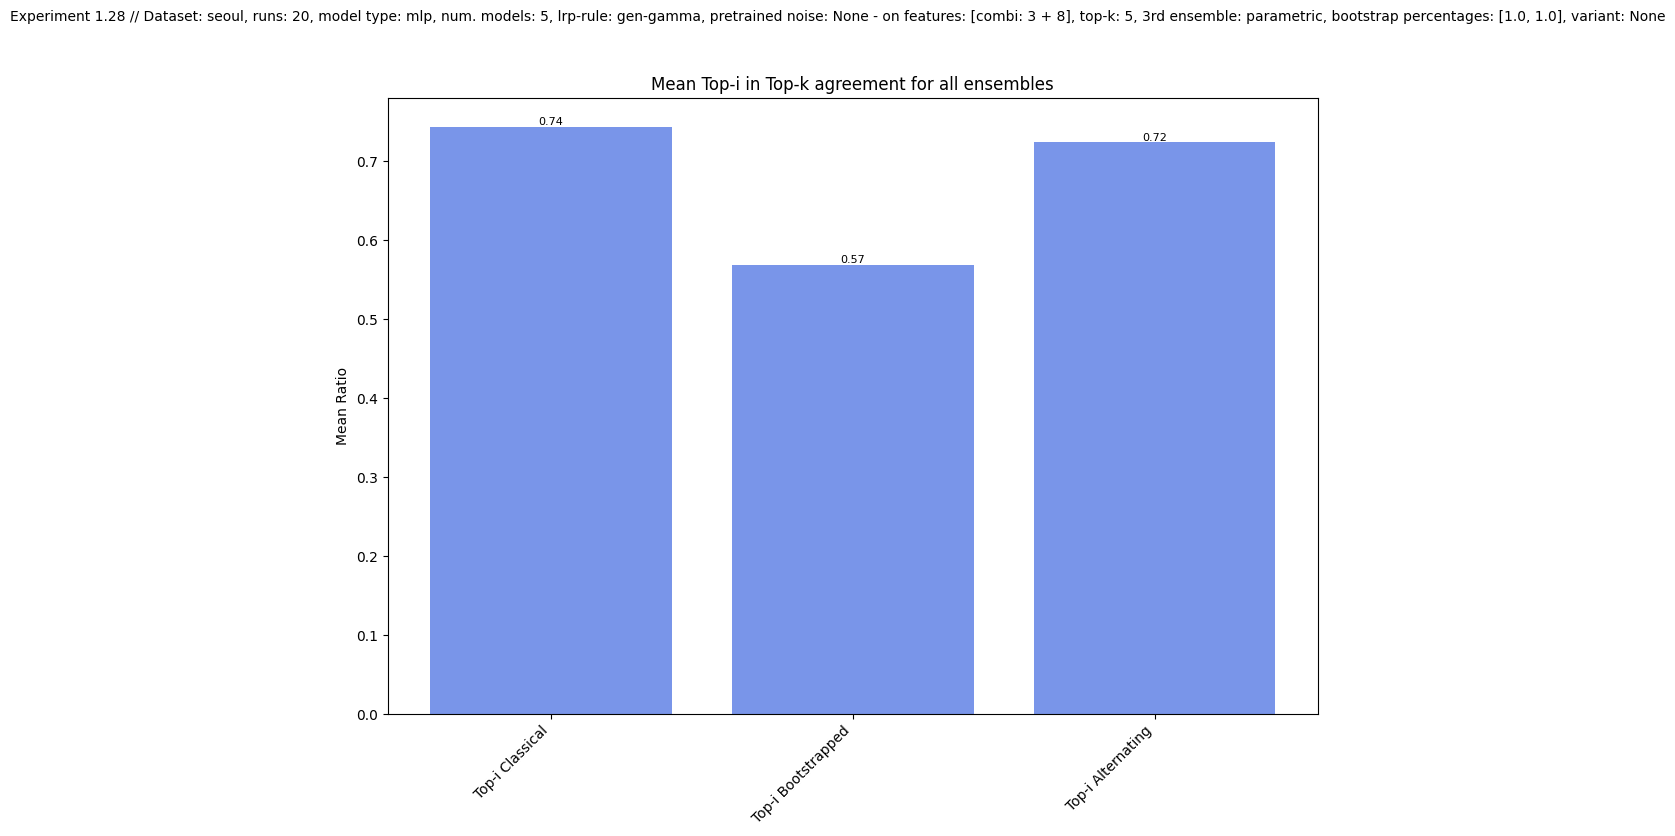

In [ ]:
print("-----------")
print("-----------")
print(f"Overall NLL classic: {np.mean(o_nll_classic)}")
print(f"Overall NLL bootstrapped: {np.mean(o_nll_bootstrapped)}")
print(f"Overall NLL alternating {np.mean(o_nll_parametric)}")
print(f"Overall RMSE classic: {np.mean(o_rmse_classic)}")
print(f"Overall RMSE bootstrapped: {np.mean(o_rmse_bootstrapped)}")
print(f"Overall RMSE alternating: {np.mean(o_rmse_parametric)}")
print(f"Overall Uncertainty classic: {np.mean(o_uncertainty_classic)}")
print(f"Overall Uncertainty bootstrapped: {np.mean(o_uncertainty_bootstrapped)}")
print(f"Overall Uncertainty alternating: {np.mean(o_uncertainty_parametric)}")
print("-----------")
print("With standard deviations:")
print(f"NLL Std classic: {np.std(o_nll_classic)}")
print(f"NLL Std bootstrapped: {np.std(o_nll_bootstrapped)}")
print(f"NLL Std alternating {np.std(o_nll_parametric)}")
print(f"RMSE Std classic: {np.std(o_rmse_classic)}")
print(f"RMSE Std bootstrapped: {np.std(o_rmse_bootstrapped)}")
print(f"RMSE Std alternating: {np.std(o_rmse_parametric)}")
print(f"Uncertainty Std classic: {np.std(o_uncertainty_classic)}")
print(f"Uncertainty Std bootstrapped: {np.std(o_uncertainty_bootstrapped)}")
print(f"Uncertainty Std alternating: {np.std(o_uncertainty_parametric)}")
print("-----------")
print("-----------")

mean_o_aleatoric_c = torch.stack(o_aleatoric_c).mean(dim=0)
mean_o_aleatoric_b = torch.stack(o_aleatoric_b).mean(dim=0)
mean_o_aleatoric_p = torch.stack(o_aleatoric_p).mean(dim=0)
mean_o_epistemic_c = torch.stack(o_epistemic_c).mean(dim=0)
mean_o_epistemic_b = torch.stack(o_epistemic_b).mean(dim=0)
mean_o_epistemic_p = torch.stack(o_epistemic_p).mean(dim=0)
mean_o_epistemic_sb_c = torch.stack(o_epistemic_sb_c).mean(dim=0)
mean_o_epistemic_sb_b = torch.stack(o_epistemic_sb_b).mean(dim=0)
mean_o_epistemic_sb_p = torch.stack(o_epistemic_sb_p).mean(dim=0)

mean_of_mean_o_aleatoric_c = torch.mean(mean_o_aleatoric_c)
mean_of_mean_o_aleatoric_b = torch.mean(mean_o_aleatoric_b)
mean_of_mean_o_aleatoric_p = torch.mean(mean_o_aleatoric_p)
mean_of_mean_o_epistemic_c = torch.mean(mean_o_epistemic_c)
mean_of_mean_o_epistemic_b = torch.mean(mean_o_epistemic_b)
mean_of_mean_o_epistemic_p = torch.mean(mean_o_epistemic_p)
mean_of_mean_o_epistemic_sb_c = torch.mean(mean_o_epistemic_sb_c)
mean_of_mean_o_epistemic_sb_b = torch.mean(mean_o_epistemic_sb_b)
mean_of_mean_o_epistemic_sb_p = torch.mean(mean_o_epistemic_sb_p)


print(f"Overall aleatoric classic: {mean_of_mean_o_aleatoric_c}")
print(f"Overall aleatoric bootstrapped: {mean_of_mean_o_aleatoric_b}")
print(f"Overall aleatoric alternating: {mean_of_mean_o_aleatoric_p}")
print(f"Overall epistemic classic: {mean_of_mean_o_epistemic_c}")
print(f"Overall epistemic bootstrapped: {mean_of_mean_o_epistemic_b}")
print(f"Overall epistemic alternating: {mean_of_mean_o_epistemic_p}")
print(f"Overall epistemic sampling classic: {mean_of_mean_o_epistemic_sb_c}")
print(f"Overall epistemic sampling bootstrapped: {mean_of_mean_o_epistemic_sb_b}")
print(f"Overall epistemic sampling alternating: {mean_of_mean_o_epistemic_sb_p}")
print("--")
actual_p_mean_epistemic = mean_of_mean_o_epistemic_p + mean_of_mean_o_epistemic_sb_p
print(f"Overall actual p epistemic: {actual_p_mean_epistemic}")

print("-----------")

if aug_mode == "ood":
    # Calculate overall mean AUROC for each ensemble type
    mean_auroc_classic = np.mean(o_auroc_classic)
    mean_auroc_bootstrapped = np.mean(o_auroc_bootstrapped)
    mean_auroc_parametric = np.mean(o_auroc_parametric)

    print("Overall AUROC Classic: ", mean_auroc_classic)
    print("Overall AUROC Bootstrapped: ", mean_auroc_bootstrapped)
    print("Overall AUROC Alternating: ", mean_auroc_parametric)

print("-----------")

### Ensemble AUFC Comparison --
if aufc_toggle == True:

    ## GI

    o_gi_classic_curve = torch.mean(torch.stack(o_gi_classic_curves), dim=0)
    o_covgi_diag_classic_curve = torch.mean(torch.stack(o_covgi_diag_classic_curves), dim=0)
    o_covgi_marg_classic_curve = torch.mean(torch.stack(o_covgi_marg_classic_curves), dim=0)
    o_gi_bootstrapped_curve = torch.mean(torch.stack(o_gi_bootstrapped_curves), dim=0)
    o_covgi_diag_bootstrapped_curve = torch.mean(torch.stack(o_covgi_diag_bootstrapped_curves), dim=0)
    o_covgi_marg_bootstrapped_curve = torch.mean(torch.stack(o_covgi_marg_bootstrapped_curves), dim=0)
    o_gi_parametric_curve = torch.mean(torch.stack(o_gi_parametric_curves), dim=0)
    o_covgi_diag_parametric_curve = torch.mean(torch.stack(o_covgi_diag_parametric_curves), dim=0)
    o_covgi_marg_parametric_curve = torch.mean(torch.stack(o_covgi_marg_parametric_curves), dim=0)

    diff_o_gi_classic_curve = torch.mean(torch.stack(diff_o_gi_classic_curves), dim=0)
    diff_o_covgi_diag_classic_curve = torch.mean(torch.stack(diff_o_covgi_diag_classic_curves), dim=0)
    diff_o_covgi_marg_classic_curve = torch.mean(torch.stack(diff_o_covgi_marg_classic_curves), dim=0)
    diff_o_gi_bootstrapped_curve = torch.mean(torch.stack(diff_o_gi_bootstrapped_curves), dim=0)
    diff_o_covgi_diag_bootstrapped_curve = torch.mean(torch.stack(diff_o_covgi_diag_bootstrapped_curves), dim=0)
    diff_o_covgi_marg_bootstrapped_curve = torch.mean(torch.stack(diff_o_covgi_marg_bootstrapped_curves), dim=0)
    diff_o_gi_parametric_curve = torch.mean(torch.stack(diff_o_gi_parametric_curves), dim=0)
    diff_o_covgi_diag_parametric_curve = torch.mean(torch.stack(diff_o_covgi_diag_parametric_curves), dim=0)
    diff_o_covgi_marg_parametric_curve = torch.mean(torch.stack(diff_o_covgi_marg_parametric_curves), dim=0)

    if model_type == "mlp-nll":
      o_gi_classic_curves_var = torch.mean(torch.stack(o_gi_classic_curves_var), dim=0)
      o_covgi_diag_classic_curves_var = torch.mean(torch.stack(o_covgi_diag_classic_curves_var), dim=0)
      o_covgi_marg_classic_curves_var = torch.mean(torch.stack(o_covgi_marg_classic_curves_var), dim=0)
      o_gi_bootstrapped_curves_var = torch.mean(torch.stack(o_gi_bootstrapped_curves_var), dim=0)
      o_covgi_diag_bootstrapped_curves_var = torch.mean(torch.stack(o_covgi_diag_bootstrapped_curves_var), dim=0)
      o_covgi_marg_bootstrapped_curves_var = torch.mean(torch.stack(o_covgi_marg_bootstrapped_curves_var), dim=0)
      o_gi_parametric_curves_var = torch.mean(torch.stack(o_gi_parametric_curves_var), dim=0)
      o_covgi_diag_parametric_curves_var = torch.mean(torch.stack(o_covgi_diag_parametric_curves_var), dim=0)
      o_covgi_marg_parametric_curves_var = torch.mean(torch.stack(o_covgi_marg_parametric_curves_var), dim=0)

    ## LRP

    o_lrp_classic_curve = torch.mean(torch.stack(o_lrp_classic_curves), dim=0)
    o_covlrp_diag_classic_curve = torch.mean(torch.stack(o_covlrp_diag_classic_curves), dim=0)
    o_covlrp_marg_classic_curve = torch.mean(torch.stack(o_covlrp_marg_classic_curves), dim=0)
    o_lrp_bootstrapped_curve = torch.mean(torch.stack(o_lrp_bootstrapped_curves), dim=0)
    o_covlrp_diag_bootstrapped_curve = torch.mean(torch.stack(o_covlrp_diag_bootstrapped_curves), dim=0)
    o_covlrp_marg_bootstrapped_curve = torch.mean(torch.stack(o_covlrp_marg_bootstrapped_curves), dim=0)
    o_lrp_parametric_curve = torch.mean(torch.stack(o_lrp_parametric_curves), dim=0)
    o_covlrp_diag_parametric_curve = torch.mean(torch.stack(o_covlrp_diag_parametric_curves), dim=0)
    o_covlrp_marg_parametric_curve = torch.mean(torch.stack(o_covlrp_marg_parametric_curves), dim=0)

    diff_o_lrp_classic_curve = torch.mean(torch.stack(diff_o_lrp_classic_curves), dim=0)
    diff_o_covlrp_diag_classic_curve = torch.mean(torch.stack(diff_o_covlrp_diag_classic_curves), dim=0)
    diff_o_covlrp_marg_classic_curve = torch.mean(torch.stack(diff_o_covlrp_marg_classic_curves), dim=0)
    diff_o_lrp_bootstrapped_curve = torch.mean(torch.stack(diff_o_lrp_bootstrapped_curves), dim=0)
    diff_o_covlrp_diag_bootstrapped_curve = torch.mean(torch.stack(diff_o_covlrp_diag_bootstrapped_curves), dim=0)
    diff_o_covlrp_marg_bootstrapped_curve = torch.mean(torch.stack(diff_o_covlrp_marg_bootstrapped_curves), dim=0)
    diff_o_lrp_parametric_curve = torch.mean(torch.stack(diff_o_lrp_parametric_curves), dim=0)
    diff_o_covlrp_diag_parametric_curve = torch.mean(torch.stack(diff_o_covlrp_diag_parametric_curves), dim=0)
    diff_o_covlrp_marg_parametric_curve = torch.mean(torch.stack(diff_o_covlrp_marg_parametric_curves), dim=0)

    if model_type == "mlp-nll":
      o_lrp_classic_curves_var = torch.mean(torch.stack(o_lrp_classic_curves_var), dim=0)
      o_covlrp_diag_classic_curves_var = torch.mean(torch.stack(o_covlrp_diag_classic_curves_var), dim=0)
      o_covlrp_marg_classic_curves_var = torch.mean(torch.stack(o_covlrp_marg_classic_curves_var), dim=0)
      o_lrp_bootstrapped_curves_var = torch.mean(torch.stack(o_lrp_bootstrapped_curves_var), dim=0)
      o_covlrp_diag_bootstrapped_curves_var = torch.mean(torch.stack(o_covlrp_diag_bootstrapped_curves_var), dim=0)
      o_covlrp_marg_bootstrapped_curves_var = torch.mean(torch.stack(o_covlrp_marg_bootstrapped_curves_var), dim=0)
      o_lrp_parametric_curves_var = torch.mean(torch.stack(o_lrp_parametric_curves_var), dim=0)
      o_covlrp_diag_parametric_curves_var = torch.mean(torch.stack(o_covlrp_diag_parametric_curves_var), dim=0)
      o_covlrp_marg_parametric_curves_var = torch.mean(torch.stack(o_covlrp_marg_parametric_curves_var), dim=0)


    # Adjust the classic AUFC scores to match the starting point of the bootstrapped scores
    adjusted_classic_aufc_scores_gi = adjust_curves(o_gi_classic_curve, o_gi_bootstrapped_curve)
    adjusted_classic_aufc_scores_covgi_diag = adjust_curves(o_covgi_diag_classic_curve, o_covgi_diag_bootstrapped_curve)
    adjusted_classic_aufc_scores_covgi_marg = adjust_curves(o_covgi_marg_classic_curve, o_covgi_marg_bootstrapped_curve)

    adjusted_classic_aufc_scores_lrp = adjust_curves(o_lrp_classic_curve, o_lrp_bootstrapped_curve)
    adjusted_classic_aufc_scores_covlrp_diag = adjust_curves(o_covlrp_diag_classic_curve, o_covlrp_diag_bootstrapped_curve)
    adjusted_classic_aufc_scores_covlrp_marg = adjust_curves(o_covlrp_marg_classic_curve, o_covlrp_marg_bootstrapped_curve)

    # Plot the original and adjusted curves
    print("Overall GI:")
    plot_adjusted_curves(o_gi_classic_curve, o_gi_bootstrapped_curve, adjusted_classic_aufc_scores_gi, o_gi_parametric_curve, "Overall GI", experiment_info)
    print("Overall CovGI_diag:")
    plot_adjusted_curves(o_covgi_diag_classic_curve, o_covgi_diag_bootstrapped_curve, adjusted_classic_aufc_scores_covgi_diag, o_covgi_diag_parametric_curve, "Overall CovGI diag", experiment_info)
    print("Overall CovGI_marg:")
    plot_adjusted_curves(o_covgi_marg_classic_curve, o_covgi_marg_bootstrapped_curve, adjusted_classic_aufc_scores_covgi_marg, o_covgi_marg_parametric_curve, "Overall CovGI marg", experiment_info)

    print("Overall LRP:")
    plot_adjusted_curves(o_lrp_classic_curve, o_lrp_bootstrapped_curve, adjusted_classic_aufc_scores_lrp, o_lrp_parametric_curve, "Overall LRP", experiment_info)
    print("Overall CovLRP_diag:")
    plot_adjusted_curves(o_covlrp_diag_classic_curve, o_covlrp_diag_bootstrapped_curve, adjusted_classic_aufc_scores_covlrp_diag, o_covlrp_diag_parametric_curve, "Overall LRP diag", experiment_info)
    print("Overall CovLRP_marg:")
    plot_adjusted_curves(o_covlrp_marg_classic_curve, o_covlrp_marg_bootstrapped_curve, adjusted_classic_aufc_scores_covlrp_marg, o_covlrp_marg_parametric_curve, "Overall LRP marg", experiment_info)

    print("-----------")
    if model_type == "mlp-nll":
      print("Overall GI (var):")
      plot_adjusted_curves(o_gi_classic_curves_var, o_gi_bootstrapped_curves_var, adjusted_classic_aufc_scores_gi, o_gi_parametric_curves_var, "Overall GI (var)", experiment_info)
      print("Overall CovGI_diag (var):")
      plot_adjusted_curves(o_covgi_diag_classic_curves_var, o_covgi_diag_bootstrapped_curves_var, adjusted_classic_aufc_scores_covgi_diag, o_covgi_diag_parametric_curves_var, "Overall CovGI diag (var)", experiment_info)
      print("Overall CovGI_marg (var):")
      plot_adjusted_curves(o_covgi_marg_classic_curves_var, o_covgi_marg_bootstrapped_curves_var, adjusted_classic_aufc_scores_covgi_marg, o_covgi_marg_parametric_curves_var, "Overall CovGI marg (var)", experiment_info)

      print("Overall LRP (var)")
      plot_adjusted_curves(o_lrp_classic_curves_var, o_lrp_bootstrapped_curves_var, adjusted_classic_aufc_scores_lrp, o_lrp_parametric_curves_var, "Overall LRP (var)", experiment_info)
      print("Overall CovLRP_diag (var)")
      plot_adjusted_curves(o_covlrp_diag_classic_curves_var, o_covlrp_diag_bootstrapped_curves_var, adjusted_classic_aufc_scores_covlrp_diag, o_covlrp_diag_parametric_curves_var, "Overall CovLRP diag (var)", experiment_info)
      print("Overall CovLRP_marg (var)")
      plot_adjusted_curves(o_covlrp_marg_classic_curves_var, o_covlrp_marg_bootstrapped_curves_var, adjusted_classic_aufc_scores_covlrp_marg, o_covlrp_marg_parametric_curves_var, "Overall CovLRP marg (var)", experiment_info)

    o_gi_classic_aufc = torch.mean(torch.tensor(o_gi_classic_aufcs), dim=0)
    o_covgi_diag_classic_aufc = torch.mean(torch.tensor(o_covgi_diag_classic_aufcs), dim=0)
    o_covgi_marg_classic_aufc = torch.mean(torch.tensor(o_covgi_marg_classic_aufcs), dim=0)
    o_gi_bootstrapped_aufc = torch.mean(torch.tensor(o_gi_bootstrapped_aufcs), dim=0)
    o_covgi_diag_bootstrapped_aufc = torch.mean(torch.tensor(o_covgi_diag_bootstrapped_aufcs), dim=0)
    o_covgi_marg_bootstrapped_aufc = torch.mean(torch.tensor(o_covgi_marg_bootstrapped_aufcs), dim=0)
    o_gi_parametric_aufc = torch.mean(torch.tensor(o_gi_parametric_aufcs), dim=0)
    o_covgi_diag_parametric_aufc = torch.mean(torch.tensor(o_covgi_diag_parametric_aufcs), dim=0)
    o_covgi_marg_parametric_aufc = torch.mean(torch.tensor(o_covgi_marg_parametric_aufcs), dim=0)

    o_lrp_classic_aufc = torch.mean(torch.tensor(o_lrp_classic_aufcs), dim=0)
    o_covlrp_diag_classic_aufc = torch.mean(torch.tensor(o_covlrp_diag_classic_aufcs), dim=0)
    o_covlrp_marg_classic_aufc = torch.mean(torch.tensor(o_covlrp_marg_classic_aufcs), dim=0)
    o_lrp_bootstrapped_aufc = torch.mean(torch.tensor(o_lrp_bootstrapped_aufcs), dim=0)
    o_covlrp_diag_bootstrapped_aufc = torch.mean(torch.tensor(o_covlrp_diag_bootstrapped_aufcs), dim=0)
    o_covlrp_marg_bootstrapped_aufc = torch.mean(torch.tensor(o_covlrp_marg_bootstrapped_aufcs), dim=0)
    o_lrp_parametric_aufc = torch.mean(torch.tensor(o_lrp_parametric_aufcs), dim=0)
    o_covlrp_diag_parametric_aufc = torch.mean(torch.tensor(o_covlrp_diag_parametric_aufcs), dim=0)
    o_covlrp_marg_parametric_aufc = torch.mean(torch.tensor(o_covlrp_marg_parametric_aufcs), dim=0)

    if model_type == "mlp-nll":
      o_gi_classic_aufc_var = torch.mean(torch.tensor(o_gi_classic_aufcs_var), dim=0)
      o_covgi_diag_classic_aufc_var = torch.mean(torch.tensor(o_covgi_diag_classic_aufcs_var), dim=0)
      o_covgi_marg_classic_aufc_var = torch.mean(torch.tensor(o_covgi_marg_classic_aufcs_var), dim=0)
      o_gi_bootstrapped_aufc_var = torch.mean(torch.tensor(o_gi_bootstrapped_aufcs_var), dim=0)
      o_covgi_diag_bootstrapped_aufc_var = torch.mean(torch.tensor(o_covgi_diag_bootstrapped_aufcs_var), dim=0)
      o_covgi_marg_bootstrapped_aufc_var = torch.mean(torch.tensor(o_covgi_marg_bootstrapped_aufcs_var), dim=0)
      o_gi_parametric_aufc_var = torch.mean(torch.tensor(o_gi_parametric_aufcs_var), dim=0)
      o_covgi_diag_parametric_aufc_var = torch.mean(torch.tensor(o_covgi_diag_parametric_aufcs_var), dim=0)
      o_covgi_marg_parametric_aufc_var = torch.mean(torch.tensor(o_covgi_marg_parametric_aufcs_var), dim=0)

      o_lrp_classic_aufc_var = torch.mean(torch.tensor(o_lrp_classic_aufcs_var), dim=0)
      o_covlrp_diag_classic_aufc_var = torch.mean(torch.tensor(o_covlrp_diag_classic_aufcs_var), dim=0)
      o_covlrp_marg_classic_aufc_var = torch.mean(torch.tensor(o_covlrp_marg_classic_aufcs_var), dim=0)
      o_lrp_bootstrapped_aufc_var = torch.mean(torch.tensor(o_lrp_bootstrapped_aufcs_var), dim=0)
      o_covlrp_diag_bootstrapped_aufc_var = torch.mean(torch.tensor(o_covlrp_diag_bootstrapped_aufcs_var), dim=0)
      o_covlrp_marg_bootstrapped_aufc_var = torch.mean(torch.tensor(o_covlrp_marg_bootstrapped_aufcs_var), dim=0)
      o_lrp_parametric_aufc_var = torch.mean(torch.tensor(o_lrp_parametric_aufcs_var), dim=0)
      o_covlrp_diag_parametric_aufc_var = torch.mean(torch.tensor(o_covlrp_diag_parametric_aufcs_var), dim=0)
      o_covlrp_marg_parametric_aufc_var = torch.mean(torch.tensor(o_covlrp_marg_parametric_aufcs_var), dim=0)

    print("--------")
    print("AUFC (Overall normalized mean across all runs):")
    print("-")
    print(f"Classical Ensemble (GI): {o_gi_classic_aufc.item():.4f}")
    print(f"Classical Ensemble (CovGI diag): {o_covgi_diag_classic_aufc.item():.4f}")
    print(f"Classical Ensemble (CovGI marg): {o_covgi_marg_classic_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (GI): {o_gi_bootstrapped_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (CovGI diag): {o_covgi_diag_bootstrapped_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (CovGI marg): {o_covgi_marg_bootstrapped_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (GI): {o_gi_parametric_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (CovGI diag): {o_covgi_diag_parametric_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (CovGI marg): {o_covgi_marg_parametric_aufc.item():.4f}")
    print("-")
    print(f"Classical Ensemble (LRP): {o_lrp_classic_aufc.item():.4f}")
    print(f"Classical Ensemble (CovLRP diag): {o_covlrp_diag_classic_aufc.item():.4f}")
    print(f"Classical Ensemble (CovLRP marg): {o_covlrp_marg_classic_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (LRP): {o_lrp_bootstrapped_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (CovLRP diag): {o_covlrp_diag_bootstrapped_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (CovLRP marg): {o_covlrp_marg_bootstrapped_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (LRP): {o_lrp_parametric_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (CovLRP diag): {o_covlrp_diag_parametric_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (CovLRP marg): {o_covlrp_marg_parametric_aufc.item():.4f}")
    print("--------")
    if model_type == "mlp-nll":
      print("AUFC for VARIANCE explanations (Overall normalized mean across all runs):")
      print("-")
      print(f"Classical Ensemble (GI): {o_gi_classic_aufc_var.item():.4f}")
      print(f"Classical Ensemble (CovGI diag): {o_covgi_diag_classic_aufc_var.item():.4f}")
      print(f"Classical Ensemble (CovGI marg): {o_covgi_marg_classic_aufc_var.item():.4f}")
      print(f"Bootstrapped Ensemble (GI): {o_gi_bootstrapped_aufc_var.item():.4f}")
      print(f"Bootstrapped Ensemble (CovGI diag): {o_covgi_diag_bootstrapped_aufc_var.item():.4f}")
      print(f"Bootstrapped Ensemble (CovGI marg): {o_covgi_marg_bootstrapped_aufc_var.item():.4f}")
      print(f"Alternating Bootstrapped Ensemble (GI): {o_gi_parametric_aufc_var.item():.4f}")
      print(f"Alternating Bootstrapped Ensemble (CovGI diag): {o_covgi_diag_parametric_aufc_var.item():.4f}")
      print(f"Alternating Bootstrapped Ensemble (CovGI marg): {o_covgi_marg_parametric_aufc_var.item():.4f}")
      print("-")
      print(f"Classical Ensemble (LRP): {o_lrp_classic_aufc_var.item():.4f}")
      print(f"Classical Ensemble (CovLRP diag): {o_covlrp_diag_classic_aufc_var.item():.4f}")
      print(f"Classical Ensemble (CovLRP marg): {o_covlrp_marg_classic_aufc_var.item():.4f}")
      print(f"Bootstrapped Ensemble (LRP): {o_lrp_bootstrapped_aufc_var.item():.4f}")
      print(f"Bootstrapped Ensemble (CovLRP diag): {o_covlrp_diag_bootstrapped_aufc_var.item():.4f}")
      print(f"Bootstrapped Ensemble (CovLRP marg): {o_covlrp_marg_bootstrapped_aufc_var.item():.4f}")
      print(f"Alternating Bootstrapped Ensemble (LRP): {o_lrp_parametric_aufc_var.item():.4f}")
      print(f"Alternating Bootstrapped Ensemble (CovLRP diag): {o_covlrp_diag_parametric_aufc_var.item():.4f}")
      print(f"Alternating Bootstrapped Ensemble (CovLRP marg): {o_covlrp_marg_parametric_aufc_var.item():.4f}")
    print("--------")
    # For augmented set
    # Adjust the classic AUFC scores to match the starting point of the bootstrapped scores
    diff_adjusted_classic_aufc_scores_gi = adjust_curves(diff_o_gi_classic_curve, diff_o_gi_bootstrapped_curve)
    diff_adjusted_classic_aufc_scores_covgi_diag = adjust_curves(diff_o_covgi_diag_classic_curve, diff_o_covgi_diag_bootstrapped_curve)
    diff_adjusted_classic_aufc_scores_covgi_marg = adjust_curves(diff_o_covgi_marg_classic_curve, diff_o_covgi_marg_bootstrapped_curve)

    diff_adjusted_classic_aufc_scores_lrp = adjust_curves(diff_o_lrp_classic_curve, diff_o_lrp_bootstrapped_curve)
    diff_adjusted_classic_aufc_scores_covlrp_diag = adjust_curves(diff_o_covlrp_diag_classic_curve, diff_o_covlrp_diag_bootstrapped_curve)
    diff_adjusted_classic_aufc_scores_covlrp_marg = adjust_curves(diff_o_covlrp_marg_classic_curve, diff_o_covlrp_marg_bootstrapped_curve)

    print("For Augmented Samples (Mean only)")
    print("--------")
    # Plot the original and adjusted curves
    print("Overall GI:")
    plot_adjusted_curves(diff_o_gi_classic_curve, diff_o_gi_bootstrapped_curve, diff_adjusted_classic_aufc_scores_gi, diff_o_gi_parametric_curve, "Overall GI (aug)", experiment_info)
    print("Overall CovGI_diag:")
    plot_adjusted_curves(diff_o_covgi_diag_classic_curve, diff_o_covgi_diag_bootstrapped_curve, diff_adjusted_classic_aufc_scores_covgi_diag, diff_o_covgi_diag_parametric_curve, "Overall CovGI diag (aug)", experiment_info)
    print("Overall CovGI_marg:")
    plot_adjusted_curves(diff_o_covgi_marg_classic_curve, diff_o_covgi_marg_bootstrapped_curve, diff_adjusted_classic_aufc_scores_covgi_marg, diff_o_covgi_diag_parametric_curve, "Overall CovGI diag (aug)", experiment_info)

    print("Overall LRP:")
    plot_adjusted_curves(diff_o_lrp_classic_curve, diff_o_lrp_bootstrapped_curve, diff_adjusted_classic_aufc_scores_lrp, diff_o_lrp_parametric_curve, "Overall LRP (aug)", experiment_info)
    print("Overall CovLRP_diag:")
    plot_adjusted_curves(diff_o_covlrp_diag_classic_curve, diff_o_covlrp_diag_bootstrapped_curve, diff_adjusted_classic_aufc_scores_covlrp_diag, diff_o_covlrp_diag_parametric_curve, "Overall CovLRP diag (aug)", experiment_info)
    print("Overall CovLRP_marg:")
    plot_adjusted_curves(diff_o_covlrp_marg_classic_curve, diff_o_covlrp_marg_bootstrapped_curve, diff_adjusted_classic_aufc_scores_covlrp_marg, diff_o_covlrp_diag_parametric_curve, "Overall CovLRP marg (aug)", experiment_info)

    diff_o_gi_classic_aufc = torch.mean(torch.tensor(diff_o_gi_classic_aufcs), dim=0)
    diff_o_covgi_diag_classic_aufc = torch.mean(torch.tensor(diff_o_covgi_diag_classic_aufcs), dim=0)
    diff_o_covgi_marg_classic_aufc = torch.mean(torch.tensor(diff_o_covgi_marg_classic_aufcs), dim=0)
    diff_o_gi_bootstrapped_aufc = torch.mean(torch.tensor(diff_o_gi_bootstrapped_aufcs), dim=0)
    diff_o_covgi_diag_bootstrapped_aufc = torch.mean(torch.tensor(diff_o_covgi_diag_bootstrapped_aufcs), dim=0)
    diff_o_covgi_marg_bootstrapped_aufc = torch.mean(torch.tensor(diff_o_covgi_marg_bootstrapped_aufcs), dim=0)
    diff_o_gi_parametric_aufc = torch.mean(torch.tensor(diff_o_gi_parametric_aufcs), dim=0)
    diff_o_covgi_diag_parametric_aufc = torch.mean(torch.tensor(diff_o_covgi_diag_parametric_aufcs), dim=0)
    diff_o_covgi_marg_parametric_aufc = torch.mean(torch.tensor(diff_o_covgi_marg_parametric_aufcs), dim=0)

    diff_o_lrp_classic_aufc = torch.mean(torch.tensor(diff_o_lrp_classic_aufcs), dim=0)
    diff_o_covlrp_diag_classic_aufc = torch.mean(torch.tensor(diff_o_covlrp_diag_classic_aufcs), dim=0)
    diff_o_covlrp_marg_classic_aufc = torch.mean(torch.tensor(diff_o_covlrp_marg_classic_aufcs), dim=0)
    diff_o_lrp_bootstrapped_aufc = torch.mean(torch.tensor(diff_o_lrp_bootstrapped_aufcs), dim=0)
    diff_o_covlrp_diag_bootstrapped_aufc = torch.mean(torch.tensor(diff_o_covlrp_diag_bootstrapped_aufcs), dim=0)
    diff_o_covlrp_marg_bootstrapped_aufc = torch.mean(torch.tensor(diff_o_covlrp_marg_bootstrapped_aufcs), dim=0)
    diff_o_lrp_parametric_aufc = torch.mean(torch.tensor(diff_o_lrp_parametric_aufcs), dim=0)
    diff_o_covlrp_diag_parametric_aufc = torch.mean(torch.tensor(diff_o_covlrp_diag_parametric_aufcs), dim=0)
    diff_o_covlrp_marg_parametric_aufc = torch.mean(torch.tensor(diff_o_covlrp_marg_parametric_aufcs), dim=0)

    print("--------")
    print("! Augmented AUFC (Overall normalized mean across all runs):")
    print("-")
    print(f"Classical Ensemble (GI): {diff_o_gi_classic_aufc.item():.4f}")
    print(f"Classical Ensemble (CovGI diag): {diff_o_covgi_diag_classic_aufc.item():.4f}")
    print(f"Classical Ensemble (CovGI marg): {diff_o_covgi_marg_classic_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (GI): {diff_o_gi_bootstrapped_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (CovGI diag): {diff_o_covgi_diag_bootstrapped_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (CovGI marg): {diff_o_covgi_marg_bootstrapped_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (GI): {diff_o_gi_parametric_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (CovGI diag): {diff_o_covgi_diag_parametric_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (CovGI marg): {diff_o_covgi_marg_parametric_aufc.item():.4f}")
    print("-")
    print(f"Classical Ensemble (LRP): {diff_o_lrp_classic_aufc.item():.4f}")
    print(f"Classical Ensemble (CovLRP diag): {diff_o_covlrp_diag_classic_aufc.item():.4f}")
    print(f"Classical Ensemble (CovLRP marg): {diff_o_covlrp_marg_classic_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (LRP): {diff_o_lrp_bootstrapped_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (CovLRP diag): {diff_o_covlrp_diag_bootstrapped_aufc.item():.4f}")
    print(f"Bootstrapped Ensemble (CovLRP marg): {diff_o_covlrp_marg_bootstrapped_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (LRP): {diff_o_lrp_parametric_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (CovLRP diag): {diff_o_covlrp_diag_parametric_aufc.item():.4f}")
    print(f"Alternating Bootstrapped Ensemble (CovLRP marg): {diff_o_covlrp_marg_parametric_aufc.item():.4f}")


### --- Further insights

print("-------")
print("Further insights:")
print("-------")

#Calculate overall mean of each feature
def calculate_feature_means(X_train, X_test, X_val):
    combined_data = torch.cat((X_train, X_test, X_val), dim=0)
    feature_means = combined_data.mean(dim=0)
    return feature_means

# Example feature means calculation
feature_means = calculate_feature_means(X_train, X_test, X_val)
print("Feature Means:", feature_means)

print("-------")
print("For topk combined uncertain samples (original)")


# Calculate mean and standard deviation for each configuration

# GI

o_mean_contrib_c_gi = torch.stack(o_feature_contributions_c_gi).mean(dim=0).cpu()
o_std_contrib_c_gi = torch.stack(o_feature_contributions_c_gi).std(dim=0).cpu()

o_mean_contrib_c_gi_diag = torch.stack(o_feature_contributions_c_gi_diag).mean(dim=0).cpu()
o_std_contrib_c_gi_diag = torch.stack(o_feature_contributions_c_gi_diag).std(dim=0).cpu()

o_mean_contrib_c_gi_marg = torch.stack(o_feature_contributions_c_gi_marg).mean(dim=0).cpu()
o_std_contrib_c_gi_marg = torch.stack(o_feature_contributions_c_gi_marg).std(dim=0).cpu()

o_mean_contrib_b_gi = torch.stack(o_feature_contributions_b_gi).mean(dim=0).cpu()
o_std_contrib_b_gi = torch.stack(o_feature_contributions_b_gi).std(dim=0).cpu()

o_mean_contrib_b_gi_diag = torch.stack(o_feature_contributions_b_gi_diag).mean(dim=0).cpu()
o_std_contrib_b_gi_diag = torch.stack(o_feature_contributions_b_gi_diag).std(dim=0).cpu()

o_mean_contrib_b_gi_marg = torch.stack(o_feature_contributions_b_gi_marg).mean(dim=0).cpu()
o_std_contrib_b_gi_marg = torch.stack(o_feature_contributions_b_gi_marg).std(dim=0).cpu()

o_mean_contrib_p_gi = torch.stack(o_feature_contributions_p_gi).mean(dim=0).cpu()
o_std_contrib_p_gi = torch.stack(o_feature_contributions_p_gi).std(dim=0).cpu()

o_mean_contrib_p_gi_diag = torch.stack(o_feature_contributions_p_gi_diag).mean(dim=0).cpu()
o_std_contrib_p_gi_diag = torch.stack(o_feature_contributions_p_gi_diag).std(dim=0).cpu()

o_mean_contrib_p_gi_marg = torch.stack(o_feature_contributions_p_gi_marg).mean(dim=0).cpu()
o_std_contrib_p_gi_marg = torch.stack(o_feature_contributions_p_gi_marg).std(dim=0).cpu()

# LRP

o_mean_contrib_c_lrp = torch.stack(o_feature_contributions_c_lrp).mean(dim=0).cpu()
o_std_contrib_c_lrp = torch.stack(o_feature_contributions_c_lrp).std(dim=0).cpu()

o_mean_contrib_c_lrp_diag = torch.stack(o_feature_contributions_c_lrp_diag).mean(dim=0).cpu()
o_std_contrib_c_lrp_diag = torch.stack(o_feature_contributions_c_lrp_diag).std(dim=0).cpu()

o_mean_contrib_c_lrp_marg = torch.stack(o_feature_contributions_c_lrp_marg).mean(dim=0).cpu()
o_std_contrib_c_lrp_marg = torch.stack(o_feature_contributions_c_lrp_marg).std(dim=0).cpu()

o_mean_contrib_b_lrp = torch.stack(o_feature_contributions_b_lrp).mean(dim=0).cpu()
o_std_contrib_b_lrp = torch.stack(o_feature_contributions_b_lrp).std(dim=0).cpu()

o_mean_contrib_b_lrp_diag = torch.stack(o_feature_contributions_b_lrp_diag).mean(dim=0).cpu()
o_std_contrib_b_lrp_diag = torch.stack(o_feature_contributions_b_lrp_diag).std(dim=0).cpu()

o_mean_contrib_b_lrp_marg = torch.stack(o_feature_contributions_b_lrp_marg).mean(dim=0).cpu()
o_std_contrib_b_lrp_marg = torch.stack(o_feature_contributions_b_lrp_marg).std(dim=0).cpu()

o_mean_contrib_p_lrp = torch.stack(o_feature_contributions_p_lrp).mean(dim=0).cpu()
o_std_contrib_p_lrp = torch.stack(o_feature_contributions_p_lrp).std(dim=0).cpu()

o_mean_contrib_p_lrp_diag = torch.stack(o_feature_contributions_p_lrp_diag).mean(dim=0).cpu()
o_std_contrib_p_lrp_diag = torch.stack(o_feature_contributions_p_lrp_diag).std(dim=0).cpu()

o_mean_contrib_p_lrp_marg = torch.stack(o_feature_contributions_p_lrp_marg).mean(dim=0).cpu()
o_std_contrib_p_lrp_marg = torch.stack(o_feature_contributions_p_lrp_marg).std(dim=0).cpu()

# GI_aug

diff_o_mean_contrib_c_gi = torch.stack(diff_o_feature_contributions_c_gi).mean(dim=0).cpu()
diff_o_std_contrib_c_gi = torch.stack(diff_o_feature_contributions_c_gi).std(dim=0).cpu()

diff_o_mean_contrib_c_gi_diag = torch.stack(diff_o_feature_contributions_c_gi_diag).mean(dim=0).cpu()
diff_o_std_contrib_c_gi_diag = torch.stack(diff_o_feature_contributions_c_gi_diag).std(dim=0).cpu()

diff_o_mean_contrib_c_gi_marg = torch.stack(diff_o_feature_contributions_c_gi_marg).mean(dim=0).cpu()
diff_o_std_contrib_c_gi_marg = torch.stack(diff_o_feature_contributions_c_gi_marg).std(dim=0).cpu()

diff_o_mean_contrib_b_gi = torch.stack(diff_o_feature_contributions_b_gi).mean(dim=0).cpu()
diff_o_std_contrib_b_gi = torch.stack(diff_o_feature_contributions_b_gi).std(dim=0).cpu()

diff_o_mean_contrib_b_gi_diag = torch.stack(diff_o_feature_contributions_b_gi_diag).mean(dim=0).cpu()
diff_o_std_contrib_b_gi_diag = torch.stack(diff_o_feature_contributions_b_gi_diag).std(dim=0).cpu()

diff_o_mean_contrib_b_gi_marg = torch.stack(diff_o_feature_contributions_b_gi_marg).mean(dim=0).cpu()
diff_o_std_contrib_b_gi_marg = torch.stack(diff_o_feature_contributions_b_gi_marg).std(dim=0).cpu()

diff_o_mean_contrib_p_gi = torch.stack(diff_o_feature_contributions_p_gi).mean(dim=0).cpu()
diff_o_std_contrib_p_gi = torch.stack(diff_o_feature_contributions_p_gi).std(dim=0).cpu()

diff_o_mean_contrib_p_gi_diag = torch.stack(diff_o_feature_contributions_p_gi_diag).mean(dim=0).cpu()
diff_o_std_contrib_p_gi_diag = torch.stack(diff_o_feature_contributions_p_gi_diag).std(dim=0).cpu()

diff_o_mean_contrib_p_gi_marg = torch.stack(diff_o_feature_contributions_p_gi_marg).mean(dim=0).cpu()
diff_o_std_contrib_p_gi_marg = torch.stack(diff_o_feature_contributions_p_gi_marg).std(dim=0).cpu()

# LRP_aug

diff_o_mean_contrib_c_lrp = torch.stack(diff_o_feature_contributions_c_lrp).mean(dim=0).cpu()
diff_o_std_contrib_c_lrp = torch.stack(diff_o_feature_contributions_c_lrp).std(dim=0).cpu()

diff_o_mean_contrib_c_lrp_diag = torch.stack(diff_o_feature_contributions_c_lrp_diag).mean(dim=0).cpu()
diff_o_std_contrib_c_lrp_diag = torch.stack(diff_o_feature_contributions_c_lrp_diag).std(dim=0).cpu()

diff_o_mean_contrib_c_lrp_marg = torch.stack(diff_o_feature_contributions_c_lrp_marg).mean(dim=0).cpu()
diff_o_std_contrib_c_lrp_marg = torch.stack(diff_o_feature_contributions_c_lrp_marg).std(dim=0).cpu()

diff_o_mean_contrib_b_lrp = torch.stack(diff_o_feature_contributions_b_lrp).mean(dim=0).cpu()
diff_o_std_contrib_b_lrp = torch.stack(diff_o_feature_contributions_b_lrp).std(dim=0).cpu()

diff_o_mean_contrib_b_lrp_diag = torch.stack(diff_o_feature_contributions_b_lrp_diag).mean(dim=0).cpu()
diff_o_std_contrib_b_lrp_diag = torch.stack(diff_o_feature_contributions_b_lrp_diag).std(dim=0).cpu()

diff_o_mean_contrib_b_lrp_marg = torch.stack(diff_o_feature_contributions_b_lrp_marg).mean(dim=0).cpu()
diff_o_std_contrib_b_lrp_marg = torch.stack(diff_o_feature_contributions_b_lrp_marg).std(dim=0).cpu()

diff_o_mean_contrib_p_lrp = torch.stack(diff_o_feature_contributions_p_lrp).mean(dim=0).cpu()
diff_o_std_contrib_p_lrp = torch.stack(diff_o_feature_contributions_p_lrp).std(dim=0).cpu()

diff_o_mean_contrib_p_lrp_diag = torch.stack(diff_o_feature_contributions_p_lrp_diag).mean(dim=0).cpu()
diff_o_std_contrib_p_lrp_diag = torch.stack(diff_o_feature_contributions_p_lrp_diag).std(dim=0).cpu()

diff_o_mean_contrib_p_lrp_marg = torch.stack(diff_o_feature_contributions_p_lrp_marg).mean(dim=0).cpu()
diff_o_std_contrib_p_lrp_marg = torch.stack(diff_o_feature_contributions_p_lrp_marg).std(dim=0).cpu()


## -- Feature names --

feature_names = [f'Feature {i+1}' for i in range(o_mean_contrib_c_gi.shape[0])]
if dataset == "seoul":
    feature_names = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
                     'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons_Spring', 'Seasons_Summer',
                     'Seasons_Winter', 'Holiday_No Holiday', 'Functioning Day_Yes']

if dataset == "diabetes":
    feature_names = ['age', 'sex', 'bmi', 'blood pressure', 's1: t-cells', 's2: ld-lipoproteins', 's3: hd-lipoproteins', 's4: thyroid', 's5: lamotrigine', 's6: blood sugar']

if dataset == "wine":
    feature_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
                     'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

if dataset == "concrete":
    feature_names = ['Cement (kg)', 'Blast Furnace Slag (kg)', 'Fly Ash (kg)', 'Water (kg)', 'Superplasticizer (kg)',
                     'Coarse Aggregate (kg)', 'Fine Aggregate (kg)', 'Age (days)']

if dataset == "energy":
    feature_names = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height',
                     'Orientation', 'Glazing Area', 'Glazing Area Distribution']

if dataset == "naval":
    feature_names = ['Lever Position (lp)', 'Ship Speed (v)', 'Gas Turbine Shaft Torque (GTT)',
                     'Gas Turbine Rate of Revolutions (GTn)', 'Gas Generator Rate of Revolutions (GGn)',
                     'Starboard Propeller Torque (Ts)', 'Port Propeller Torque (Tp)',
                     'HP Turbine Exit Temperature (T48)', 'GT Compressor Inlet Air Temperature (T1)',
                     'GT Compressor Outlet Air Temperature (T2)', 'HP Turbine Exit Pressure (P48)',
                     'GT Compressor Inlet Air Pressure (P1)', 'GT Compressor Outlet Air Pressure (P2)',
                     'Gas Turbine Exhaust Gas Pressure (Pexh)', 'Turbine Injection Control (TIC)',
                     'Fuel Flow (mf)']
if dataset == "ccpp":
    feature_names = ['Temperature (T)', 'Exhaust Vacuum (V)', 'Ambient Pressure (AP)', 'Relative Humidity (RH)']

if dataset == "yacht":
    feature_names = ['Longitudinal Position of Buoyancy', 'Prismatic Coefficient', 'Length-Displacement Ratio',
                     'Beam-Draught Ratio', 'Length-Beam Ratio', 'Froude Number']


# Mean contributions and standard deviations for different configurations
configs_gi = {
    'Classic GI': (o_mean_contrib_c_gi, o_std_contrib_c_gi),
    'Classic CovGI Diag': (o_mean_contrib_c_gi_diag, o_std_contrib_c_gi_diag),
    'Classic CovGI Marg': (o_mean_contrib_c_gi_marg, o_std_contrib_c_gi_marg),
    'Bootstrapped GI': (o_mean_contrib_b_gi, o_std_contrib_b_gi),
    'Bootstrapped CovGI Diag': (o_mean_contrib_b_gi_diag, o_std_contrib_b_gi_diag),
    'Bootstrapped CovGI Marg': (o_mean_contrib_b_gi_marg, o_std_contrib_b_gi_marg),
    'Alternating GI': (o_mean_contrib_p_gi, o_std_contrib_p_gi),
    'Alternating CovGI Diag': (o_mean_contrib_p_gi_diag, o_std_contrib_p_gi_diag),
    'Alternating CovGI Marg': (o_mean_contrib_p_gi_marg, o_std_contrib_p_gi_marg)
}
configs_lrp = {
    'Classic LRP': (o_mean_contrib_c_lrp, o_std_contrib_c_lrp),
    'Classic CovLRP Diag': (o_mean_contrib_c_lrp_diag, o_std_contrib_c_lrp_diag),
    'Classic CovLRP Marg': (o_mean_contrib_c_lrp_marg, o_std_contrib_c_lrp_marg),
    'Bootstrapped LRP': (o_mean_contrib_b_lrp, o_std_contrib_b_lrp),
    'Bootstrapped CovLRP Diag': (o_mean_contrib_b_lrp_diag, o_std_contrib_b_lrp_diag),
    'Bootstrapped CovLRP Marg': (o_mean_contrib_b_lrp_marg, o_std_contrib_b_lrp_marg),
    'Alternating LRP': (o_mean_contrib_p_lrp, o_std_contrib_p_lrp),
    'Alternating CovLRP Diag': (o_mean_contrib_p_lrp_diag, o_std_contrib_p_lrp_diag),
    'Alternating CovLRP Marg': (o_mean_contrib_p_lrp_marg, o_std_contrib_p_lrp_marg)
}
configs_gi_aug = {
    'Classic GI': (diff_o_mean_contrib_c_gi, diff_o_std_contrib_c_gi),
    'Classic CovGI Diag': (diff_o_mean_contrib_c_gi_diag, diff_o_std_contrib_c_gi_diag),
    'Classic CovGI Marg': (diff_o_mean_contrib_c_gi_marg, diff_o_std_contrib_c_gi_marg),
    'Bootstrapped GI': (diff_o_mean_contrib_b_gi, diff_o_std_contrib_b_gi),
    'Bootstrapped CovGI Diag': (diff_o_mean_contrib_b_gi_diag, diff_o_std_contrib_b_gi_diag),
    'Bootstrapped CovGI Marg': (diff_o_mean_contrib_b_gi_marg, diff_o_std_contrib_b_gi_marg),
    'Alternating GI': (diff_o_mean_contrib_p_gi, diff_o_std_contrib_p_gi),
    'Alternating CovGI Diag': (diff_o_mean_contrib_p_gi_diag, diff_o_std_contrib_p_gi_diag),
    'Alternating CovGI Marg': (diff_o_mean_contrib_p_gi_marg, diff_o_std_contrib_p_gi_marg)
}
configs_lrp_aug = {
    'Classic LRP': (diff_o_mean_contrib_c_lrp, diff_o_std_contrib_c_lrp),
    'Classic CovLRP Diag': (diff_o_mean_contrib_c_lrp_diag, diff_o_std_contrib_c_lrp_diag),
    'Classic CovLRP Marg': (diff_o_mean_contrib_c_lrp_marg, diff_o_std_contrib_c_lrp_marg),
    'Bootstrapped LRP': (diff_o_mean_contrib_b_lrp, diff_o_std_contrib_b_lrp),
    'Bootstrapped CovLRP Diag': (diff_o_mean_contrib_b_lrp_diag, diff_o_std_contrib_b_lrp_diag),
    'Bootstrapped CovLRP Marg': (diff_o_mean_contrib_b_lrp_marg, diff_o_std_contrib_b_lrp_marg),
    'Alternating LRP': (diff_o_mean_contrib_p_lrp, diff_o_std_contrib_p_lrp),
    'Alternating CovLRP Diag': (diff_o_mean_contrib_p_lrp_diag, diff_o_std_contrib_p_lrp_diag),
    'Alternating CovLRP Marg': (diff_o_mean_contrib_p_lrp_marg, diff_o_std_contrib_p_lrp_marg)
}

if plot_feature_contribution_bars == True:
  print("GI:")
  plot_feature_contributions(configs_gi, "GI", experiment_info)
  print("GI aug:")
  plot_feature_contributions(configs_gi_aug, "GI (aug)", experiment_info)
  print("LRP:")
  plot_feature_contributions(configs_lrp, "LRP", experiment_info)
  print("LRP aug:")
  plot_feature_contributions(configs_lrp_aug, "LRP (aug)", experiment_info)

print("-------")



# Heatmaps Cov Matrices


global_min_gi, global_max_gi = calculate_global_min_max(o_gi_topi_cov_matrices_c + o_gi_top_cov_matrices_c + o_gi_cov_matrices_c +
                                                   o_gi_topi_cov_matrices_b + o_gi_top_cov_matrices_b + o_gi_cov_matrices_b +
                                                   o_gi_topi_cov_matrices_p + o_gi_top_cov_matrices_p + o_gi_cov_matrices_p)
print(f"Global min (gi): {global_min_gi}")
print(f"Global max (gi): {global_max_gi}")

if model_type == "mlp-nll":
  global_min_gi_var, global_max_gi_var = calculate_global_min_max(o_gi_topi_cov_matrices_c_var + o_gi_top_cov_matrices_c_var + o_gi_cov_matrices_c_var +
                                                   o_gi_topi_cov_matrices_b_var + o_gi_top_cov_matrices_b_var + o_gi_cov_matrices_b_var +
                                                   o_gi_topi_cov_matrices_p_var + o_gi_top_cov_matrices_p_var + o_gi_cov_matrices_p_var)
  print(f"Global min (gi var): {global_min_gi_var}")
  print(f"Global max (gi var): {global_max_gi_var}")

global_min_lrp, global_max_lrp = calculate_global_min_max(o_lrp_topi_cov_matrices_c + o_lrp_top_cov_matrices_c + o_lrp_cov_matrices_c +
                                                   o_lrp_topi_cov_matrices_b + o_lrp_top_cov_matrices_b + o_lrp_cov_matrices_b +
                                                   o_lrp_topi_cov_matrices_p + o_lrp_top_cov_matrices_p + o_lrp_cov_matrices_p)
print(f"Global min (lrp): {global_min_lrp}")
print(f"Global max (lrp): {global_max_lrp}")

if model_type == "mlp-nll":
  global_min_lrp_var, global_max_lrp_var = calculate_global_min_max(o_lrp_topi_cov_matrices_c_var + o_lrp_top_cov_matrices_c_var + o_lrp_cov_matrices_c_var +
                                                                    o_lrp_topi_cov_matrices_b_var + o_lrp_top_cov_matrices_b_var + o_lrp_cov_matrices_b_var +
                                                                    o_lrp_topi_cov_matrices_p_var + o_lrp_top_cov_matrices_p_var + o_lrp_cov_matrices_p_var)
  print(f"Global min (lrp var): {global_min_lrp_var}")
  print(f"Global max (lrp var): {global_max_lrp_var}")

# Plot heatmaps for GI classical, bootstrapped, and parametric covariance matrices

plot_heatmaps(o_gi_topi_cov_matrices_c, o_gi_top_cov_matrices_c, o_gi_cov_matrices_c, "GI Classical", feature_names, global_min_gi, global_max_gi, experiment_info)
plot_heatmaps(o_gi_topi_cov_matrices_b, o_gi_top_cov_matrices_b, o_gi_cov_matrices_b, "GI Bootstrapped", feature_names, global_min_gi, global_max_gi, experiment_info)
plot_heatmaps(o_gi_topi_cov_matrices_p, o_gi_top_cov_matrices_p, o_gi_cov_matrices_p, "GI Alternating", feature_names, global_min_gi, global_max_gi, experiment_info)

if model_type == "mlp-nll":
  plot_heatmaps(o_gi_topi_cov_matrices_c_var, o_gi_top_cov_matrices_c_var, o_gi_cov_matrices_c_var, "GI Classical (Var)", feature_names, global_max_gi_var, experiment_info)
  plot_heatmaps(o_gi_topi_cov_matrices_b_var, o_gi_top_cov_matrices_b_var, o_gi_cov_matrices_b_var, "GI Bootstrapped (Var)", feature_names, global_max_gi_var, experiment_info)
  plot_heatmaps(o_gi_topi_cov_matrices_p_var, o_gi_top_cov_matrices_p_var, o_gi_cov_matrices_p_var, "GI Alternating (Var)", feature_names, global_max_gi_var, experiment_info)

# Plot heatmaps for LRP classical, bootstrapped, and parametric covariance matrices

plot_heatmaps(o_lrp_topi_cov_matrices_c, o_lrp_top_cov_matrices_c, o_lrp_cov_matrices_c, "LRP Classical", feature_names, global_min_lrp, global_max_lrp, experiment_info)
plot_heatmaps(o_lrp_topi_cov_matrices_b, o_lrp_top_cov_matrices_b, o_lrp_cov_matrices_b, "LRP Bootstrapped", feature_names, global_min_lrp, global_max_lrp, experiment_info)
plot_heatmaps(o_lrp_topi_cov_matrices_p, o_lrp_top_cov_matrices_p, o_lrp_cov_matrices_p, "LRP Alternating", feature_names, global_min_lrp, global_max_lrp, experiment_info)

if model_type == "mlp-nll":
  plot_heatmaps(o_lrp_topi_cov_matrices_c_var, o_lrp_top_cov_matrices_c_var, o_lrp_cov_matrices_c_var, "LRP Classical (Var)", feature_names, global_max_lrp_var, experiment_info)
  plot_heatmaps(o_lrp_topi_cov_matrices_b_var, o_lrp_top_cov_matrices_b_var, o_lrp_cov_matrices_b_var, "LRP Bootstrapped (Var)", feature_names, global_max_lrp_var, experiment_info)
  plot_heatmaps(o_lrp_topi_cov_matrices_p_var, o_lrp_top_cov_matrices_p_var, o_lrp_cov_matrices_p_var, "LRP Alternating (Var)", feature_names, global_max_lrp_var, experiment_info)

# Calculate mean ratios for each configuration

ratios = {
    "GI Classical (TopI)": calculate_mean_ratio(o_gi_topi_cov_matrices_c),
    "GI Classical (TopK)": calculate_mean_ratio(o_gi_top_cov_matrices_c),
    "GI Classical (All)": calculate_mean_ratio(o_gi_cov_matrices_c),
    "GI Bootstrapped (TopI)": calculate_mean_ratio(o_gi_topi_cov_matrices_b),
    "GI Bootstrapped (TopK)": calculate_mean_ratio(o_gi_top_cov_matrices_b),
    "GI Bootstrapped (All)": calculate_mean_ratio(o_gi_cov_matrices_b),
    "GI Alternating (TopI)": calculate_mean_ratio(o_gi_topi_cov_matrices_p),
    "GI Alternating (TopK)": calculate_mean_ratio(o_gi_top_cov_matrices_p),
    "GI Alternating (All)": calculate_mean_ratio(o_gi_cov_matrices_p),
    "LRP Classical (TopI)": calculate_mean_ratio(o_lrp_topi_cov_matrices_c),
    "LRP Classical (TopK)": calculate_mean_ratio(o_lrp_top_cov_matrices_c),
    "LRP Classical (All)": calculate_mean_ratio(o_lrp_cov_matrices_c),
    "LRP Bootstrapped (TopI)": calculate_mean_ratio(o_lrp_topi_cov_matrices_b),
    "LRP Bootstrapped (TopK)": calculate_mean_ratio(o_lrp_top_cov_matrices_b),
    "LRP Bootstrapped (All)": calculate_mean_ratio(o_lrp_cov_matrices_b),
    "LRP Alternating (TopI)": calculate_mean_ratio(o_lrp_topi_cov_matrices_p),
    "LRP Alternating (TopK)": calculate_mean_ratio(o_lrp_top_cov_matrices_p),
    "LRP Alternating (All)": calculate_mean_ratio(o_lrp_cov_matrices_p),
}

ratios_abs = {
    "GI Classical (TopI)": calculate_mean_abs_sensitivity(o_gi_topi_cov_matrices_c),
    "GI Classical (TopK)": calculate_mean_abs_sensitivity(o_gi_top_cov_matrices_c),
    "GI Classical (All)": calculate_mean_abs_sensitivity(o_gi_cov_matrices_c),
    "GI Bootstrapped (TopI)": calculate_mean_abs_sensitivity(o_gi_topi_cov_matrices_b),
    "GI Bootstrapped (TopK)": calculate_mean_abs_sensitivity(o_gi_top_cov_matrices_b),
    "GI Bootstrapped (All)": calculate_mean_abs_sensitivity(o_gi_cov_matrices_b),
    "GI Alternating (TopI)": calculate_mean_abs_sensitivity(o_gi_topi_cov_matrices_p),
    "GI Alternating (TopK)": calculate_mean_abs_sensitivity(o_gi_top_cov_matrices_p),
    "GI Alternating (All)": calculate_mean_abs_sensitivity(o_gi_cov_matrices_p),
    "LRP Classical (TopI)": calculate_mean_abs_sensitivity(o_lrp_topi_cov_matrices_c),
    "LRP Classical (TopK)": calculate_mean_abs_sensitivity(o_lrp_top_cov_matrices_c),
    "LRP Classical (All)": calculate_mean_abs_sensitivity(o_lrp_cov_matrices_c),
    "LRP Bootstrapped (TopI)": calculate_mean_abs_sensitivity(o_lrp_topi_cov_matrices_b),
    "LRP Bootstrapped (TopK)": calculate_mean_abs_sensitivity(o_lrp_top_cov_matrices_b),
    "LRP Bootstrapped (All)": calculate_mean_abs_sensitivity(o_lrp_cov_matrices_b),
    "LRP Alternating (TopI)": calculate_mean_abs_sensitivity(o_lrp_topi_cov_matrices_p),
    "LRP Alternating (TopK)": calculate_mean_abs_sensitivity(o_lrp_top_cov_matrices_p),
    "LRP Alternating (All)": calculate_mean_abs_sensitivity(o_lrp_cov_matrices_p),
}

ratios_topi_agree = {
    "Top-i Classical": np.mean(topi_agree_c),
    "Top-i Bootstrapped": np.mean(topi_agree_b),
    "Top-i Alternating": np.mean(topi_agree_p)
}

if model_type == "mlp-nll":
  ratios_var = {
      "GI Classical (TopI)": calculate_mean_ratio(o_gi_topi_cov_matrices_c_var),
      "GI Classical (TopK)": calculate_mean_ratio(o_gi_top_cov_matrices_c_var),
      "GI Classical (All)": calculate_mean_ratio(o_gi_cov_matrices_c_var),
      "GI Bootstrapped (TopI)": calculate_mean_ratio(o_gi_topi_cov_matrices_b_var),
      "GI Bootstrapped (TopK)": calculate_mean_ratio(o_gi_top_cov_matrices_b_var),
      "GI Bootstrapped (All)": calculate_mean_ratio(o_gi_cov_matrices_b_var),
      "GI Alternating (TopI)": calculate_mean_ratio(o_gi_topi_cov_matrices_p_var),
      "GI Alternating (TopK)": calculate_mean_ratio(o_gi_top_cov_matrices_p_var),
      "GI Alternating (All)": calculate_mean_ratio(o_gi_cov_matrices_p_var),
      "LRP Classical (TopI)": calculate_mean_ratio(o_lrp_topi_cov_matrices_c_var),
      "LRP Classical (TopK)": calculate_mean_ratio(o_lrp_top_cov_matrices_c_var),
      "LRP Classical (All)": calculate_mean_ratio(o_lrp_cov_matrices_c_var),
      "LRP Bootstrapped (TopI)": calculate_mean_ratio(o_lrp_topi_cov_matrices_b_var),
      "LRP Bootstrapped (TopK)": calculate_mean_ratio(o_lrp_top_cov_matrices_b_var),
      "LRP Bootstrapped (All)": calculate_mean_ratio(o_lrp_cov_matrices_b_var),
      "LRP Alternating (TopI)": calculate_mean_ratio(o_lrp_topi_cov_matrices_p_var),
      "LRP Alternating (TopK)": calculate_mean_ratio(o_lrp_top_cov_matrices_p_var),
      "LRP Alternating (All)": calculate_mean_ratio(o_lrp_cov_matrices_p_var)
      }

  ratios_abs_var = {
      "GI Classical (TopI)": calculate_mean_abs_sensitivity(o_gi_topi_cov_matrices_c_var),
      "GI Classical (TopK)": calculate_mean_abs_sensitivity(o_gi_top_cov_matrices_c_var),
      "GI Classical (All)": calculate_mean_abs_sensitivity(o_gi_cov_matrices_c_var),
      "GI Bootstrapped (TopI)": calculate_mean_abs_sensitivity(o_gi_topi_cov_matrices_b_var),
      "GI Bootstrapped (TopK)": calculate_mean_abs_sensitivity(o_gi_top_cov_matrices_b_var),
      "GI Bootstrapped (All)": calculate_mean_abs_sensitivity(o_gi_cov_matrices_b_var),
      "GI Alternating (TopI)": calculate_mean_abs_sensitivity(o_gi_topi_cov_matrices_p_var),
      "GI Alternating (TopK)": calculate_mean_abs_sensitivity(o_gi_top_cov_matrices_p_var),
      "GI Alternating (All)": calculate_mean_abs_sensitivity(o_gi_cov_matrices_p_var),
      "LRP Classical (TopI)": calculate_mean_abs_sensitivity(o_lrp_topi_cov_matrices_c_var),
      "LRP Classical (TopK)": calculate_mean_abs_sensitivity(o_lrp_top_cov_matrices_c_var),
      "LRP Classical (All)": calculate_mean_abs_sensitivity(o_lrp_cov_matrices_c_var),
      "LRP Bootstrapped (TopI)": calculate_mean_abs_sensitivity(o_lrp_topi_cov_matrices_b_var),
      "LRP Bootstrapped (TopK)": calculate_mean_abs_sensitivity(o_lrp_top_cov_matrices_b_var),
      "LRP Bootstrapped (All)": calculate_mean_abs_sensitivity(o_lrp_cov_matrices_b_var),
      "LRP Alternating (TopI)": calculate_mean_abs_sensitivity(o_lrp_topi_cov_matrices_p_var),
      "LRP Alternating (TopK)": calculate_mean_abs_sensitivity(o_lrp_top_cov_matrices_p_var),
      "LRP Alternating (All)": calculate_mean_abs_sensitivity(o_lrp_cov_matrices_p_var)
      }

# Plot mean ratios for all configurations
plot_mean_ratios(ratios, "Mean Ratio (sum(diag) / sum(all)) for All Configurations", experiment_info)
plot_mean_ratios(ratios_abs, "Mean Absolute Sensitivity (sum(abs(diag)) / sum(abs(all))) for All Configurations", experiment_info)
plot_mean_ratios(ratios_topi_agree, "Mean Top-i in Top-k agreement for all ensembles", experiment_info)

if model_type == "mlp-nll":
  plot_mean_ratios(ratios_var, "Mean Ratio (sum(diag) / sum(all)) for All Configurations (Var)", experiment_info)
  plot_mean_ratios(ratios_abs_var, "Mean Absolute Sensitivity (sum(abs(diag)) / sum(abs(all))) for All Configurations (Var)", experiment_info)
  plot_mean_ratios(ratios_topi_agree, "Mean Top-i in Top-k agreement for all ensembles (Var)", experiment_info)




# **Calibration Analysis**

In [ ]:
# Calibration Analysis

def create_bins(predictions, n_bins=10):
    bins = np.linspace(np.min(predictions), np.max(predictions), n_bins + 1)
    bin_indices = np.digitize(predictions, bins) - 1  # get bin indices
    return bins, bin_indices


def compute_prediction_intervals(means, variances, z_values):
    intervals = {}
    for z in z_values:
        lower_bound = means - norm.ppf(0.5 + z / 2.0) * np.sqrt(variances)
        upper_bound = means + norm.ppf(0.5 + z / 2.0) * np.sqrt(variances)
        intervals[z] = (lower_bound, upper_bound)
    return intervals

def measure_observed_fractions(y_true, intervals):
    observed_fractions = {}
    for z, (lower_bound, upper_bound) in intervals.items():
        observed_fraction = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
        observed_fractions[z] = observed_fraction
    return observed_fractions

def compute_area_between_curves(expected_fractions, observed_fractions):
    area = np.trapz(np.abs(np.array(observed_fractions) - np.array(expected_fractions)), expected_fractions)
    return area


def compute_ece(y_true, y_pred, n_bins=10):
    # Normalize predictions to [0, 1]
    y_pred = np.clip(y_pred, 0, 1)

    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred, bins) - 1  # Bin index for each prediction
    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        bin_size = np.sum(bin_mask)
        if bin_size > 0:
            bin_accuracy = np.mean(y_true[bin_mask])
            bin_confidence = np.mean(y_pred[bin_mask])
            bin_weight = bin_size / len(y_true)
            ece += bin_weight * np.abs(bin_accuracy - bin_confidence)
    return ece


# Cal-Curves and ECE
def plot_calibration_curves(expected_fractions, observed_fractions_all, ensemble_results, all_y_true):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']
    labels = list(observed_fractions_all.keys())
    areas = {}
    ece_scores = {}

    for i, (ensemble_type, observed_fractions_list) in enumerate(observed_fractions_all.items()):
        avg_observed_fractions = np.mean([list(observed_fractions.values()) for observed_fractions in observed_fractions_list], axis=0)
        plt.plot(expected_fractions, avg_observed_fractions, label=ensemble_type, color=colors[i])
        area = compute_area_between_curves(expected_fractions, avg_observed_fractions)
        areas[ensemble_type] = area

        # Compute ECE score for the ensemble type
        #all_y_true = np.concatenate([y_test.cpu() for _ in range(len(ensemble_results[ensemble_type]['mean_predictions']))], axis=0)
        all_y_pred = np.concatenate(ensemble_results[ensemble_type]['mean_predictions'], axis=0)
        ece = compute_ece(all_y_true, all_y_pred)
        ece_scores[ensemble_type] = ece

    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Ideal')  # Ideal line
    plt.xlabel('Expected fraction')
    plt.ylabel('Observed fraction')
    plt.legend()
    plt.title('Calibration Curves for Deep Ensembles')
    plt.grid(True)
    plt.show()

    return areas, ece_scores

z_values = np.arange(0.0, 1.01, 0.01)  # z = 10% to 90% in increments of 10
expected_fractions = z_values

observed_fractions_all = {'classic': [], 'bootstrapped': [], 'alternating': []}

for ensemble_type in ensemble_results:
    means_all = np.concatenate(ensemble_results[ensemble_type]['mean_predictions'], axis=0)
    variances_all = np.concatenate(ensemble_results[ensemble_type]['variances'], axis=0)
    # y_true_all = np.concatenate([y_test.cpu() for _ in range(len(ensemble_results[ensemble_type]['mean_predictions']))], axis=0)
    y_true_all = np.concatenate([tensor.cpu().numpy() for tensor in saves_y_test])

    intervals = compute_prediction_intervals(means_all, variances_all, z_values)
    observed_fractions = measure_observed_fractions(y_true_all, intervals)
    observed_fractions_all[ensemble_type].append(observed_fractions)
    print(observed_fractions_all['classic'])

# Plotting all calibration curves in one plot and computing areas
areas, ece_scores = plot_calibration_curves(expected_fractions, observed_fractions_all, ensemble_results, y_true_all)

# Print the computed areas between each curve and the ideal diagonal line
for ensemble_type, area in areas.items():
    print(f"Area between the curve and the ideal line for {ensemble_type}: {area}")

for ensemble_type, ece in ece_scores.items():
    print(f"Expected Calibration Error (ECE) for {ensemble_type}: {ece:.4f}")

# **Decomposed Analysis plotted against y and x**

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

def smooth_curve(y, sigma=2):
    return gaussian_filter1d(y, sigma=sigma)

def plot_decomposed_uncertainty(saves_y_test, o_aleatoric, o_epistemic, o_epistemic_sb=None, title="Decomposed Uncertainty", smooth=True, sigma=2):
    all_y_values = []
    all_aleatoric = []
    all_epistemic = []
    all_epistemic_sb = []

    # Combine all runs
    for i in range(len(saves_y_test)):
        y_values = saves_y_test[i].squeeze()
        aleatoric = o_aleatoric[i].squeeze()
        epistemic = o_epistemic[i].squeeze()

        if o_epistemic_sb is not None:
            epistemic_sb = o_epistemic_sb[i].squeeze()
        else:
            epistemic_sb = None

        all_y_values.append(y_values)
        all_aleatoric.append(aleatoric)
        all_epistemic.append(epistemic)
        if epistemic_sb is not None:
            all_epistemic_sb.append(epistemic_sb)

    # Concatenate all the values
    all_y_values = torch.cat(all_y_values)
    all_aleatoric = torch.cat(all_aleatoric)
    all_epistemic = torch.cat(all_epistemic)
    all_epistemic_sb = torch.cat(all_epistemic_sb) if o_epistemic_sb is not None else None

    # Sort y_values and corresponding uncertainties
    sorted_indices = torch.argsort(all_y_values)
    sorted_y_values = all_y_values[sorted_indices]
    sorted_aleatoric = all_aleatoric[sorted_indices]
    sorted_epistemic = all_epistemic[sorted_indices]
    sorted_epistemic_sb = all_epistemic_sb[sorted_indices] if all_epistemic_sb is not None else None
    sorted_total_uncertainty = sorted_aleatoric + sorted_epistemic + (sorted_epistemic_sb if sorted_epistemic_sb is not None else 0)

    if smooth:
        # Apply smoothing
        sorted_aleatoric = smooth_curve(sorted_aleatoric.cpu().numpy(), sigma=sigma)
        sorted_epistemic = smooth_curve(sorted_epistemic.cpu().numpy(), sigma=sigma)
        sorted_epistemic_sb = smooth_curve(sorted_epistemic_sb.cpu().numpy(), sigma=sigma) if sorted_epistemic_sb is not None else None
        sorted_total_uncertainty = smooth_curve(sorted_total_uncertainty.cpu().numpy(), sigma=sigma)
    else:
        # Convert to numpy arrays if not smoothing
        sorted_aleatoric = sorted_aleatoric.cpu().numpy()
        sorted_epistemic = sorted_epistemic.cpu().numpy()
        sorted_epistemic_sb = sorted_epistemic_sb.cpu().numpy() if sorted_epistemic_sb is not None else None
        sorted_total_uncertainty = sorted_total_uncertainty.cpu().numpy()

    # Calculate means for the horizontal lines
    mean_aleatoric = np.mean(sorted_aleatoric)
    mean_epistemic = np.mean(sorted_epistemic)
    mean_epistemic_sb = np.mean(sorted_epistemic_sb) if sorted_epistemic_sb is not None else None
    mean_total_uncertainty = np.mean(sorted_total_uncertainty)

    # Create the plots
    plt.figure(figsize=(20, 5))

    # Plot Aleatoric Uncertainty
    plt.subplot(1, 4, 1)
    plt.plot(sorted_y_values.cpu().numpy(), sorted_aleatoric, label='Aleatoric Uncertainty', color='blue')
    plt.axhline(mean_aleatoric, color='black', linestyle='--', linewidth=1, label='Mean Aleatoric')
    plt.xlabel('y values')
    plt.ylabel('Aleatoric Uncertainty')
    plt.title('Aleatoric Uncertainty vs. y Values')
    plt.grid(True)
    plt.legend()

    # Plot Epistemic Uncertainty
    plt.subplot(1, 4, 2)
    plt.plot(sorted_y_values.cpu().numpy(), sorted_epistemic, label='Epistemic Uncertainty', color='green')
    plt.axhline(mean_epistemic, color='black', linestyle='--', linewidth=1, label='Mean Epistemic')
    plt.xlabel('y values')
    plt.ylabel('Epistemic Uncertainty')
    plt.title('Epistemic Uncertainty vs. y Values')
    plt.grid(True)
    plt.legend()

    # Plot Epistemic_sb Uncertainty (if provided)
    if sorted_epistemic_sb is not None:
        plt.subplot(1, 4, 3)
        plt.plot(sorted_y_values.cpu().numpy(), sorted_epistemic_sb, label='Epistemic Sampling Uncertainty', color='orange')
        plt.axhline(mean_epistemic_sb, color='black', linestyle='--', linewidth=1, label='Mean Epistemic Sampling')
        plt.xlabel('y values')
        plt.ylabel('Epistemic Sampling Uncertainty')
        plt.title('Epistemic Sampling Uncertainty vs. y Values')
        plt.grid(True)
        plt.legend()

    # Plot Total Uncertainty
    plt.subplot(1, 4, 4)
    plt.plot(sorted_y_values.cpu().numpy(), sorted_total_uncertainty, label='Total Uncertainty', color='red')
    plt.axhline(mean_total_uncertainty, color='black', linestyle='--', linewidth=1, label='Mean Total')
    plt.xlabel('y values')
    plt.ylabel('Total Uncertainty')
    plt.title('Total Uncertainty vs. y Values')
    plt.grid(True)
    plt.legend()

    # Display the plots
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage with smoothing
plot_decomposed_uncertainty(saves_y_test, o_aleatoric_c, o_epistemic_c, o_epistemic_sb_c, "Classic Decomposed Uncertainty", smooth=False, sigma=2)
plot_decomposed_uncertainty(saves_y_test, o_aleatoric_b, o_epistemic_b, o_epistemic_sb_b, "Bootstrapped Decomposed Uncertainty", smooth=False, sigma=2)
plot_decomposed_uncertainty(saves_y_test, o_aleatoric_p, o_epistemic_p, o_epistemic_sb_p, "Alternating Decomposed Uncertainty", smooth=False, sigma=2)
plot_decomposed_uncertainty(saves_y_test, o_aleatoric_c, o_epistemic_c, o_epistemic_sb_c, "Classic Decomposed Uncertainty", smooth=True, sigma=10)
plot_decomposed_uncertainty(saves_y_test, o_aleatoric_b, o_epistemic_b, o_epistemic_sb_b, "Bootstrapped Decomposed Uncertainty", smooth=True, sigma=10)
plot_decomposed_uncertainty(saves_y_test, o_aleatoric_p, o_epistemic_p, o_epistemic_sb_p, "Alternating Decomposed Uncertainty", smooth=True, sigma=10)

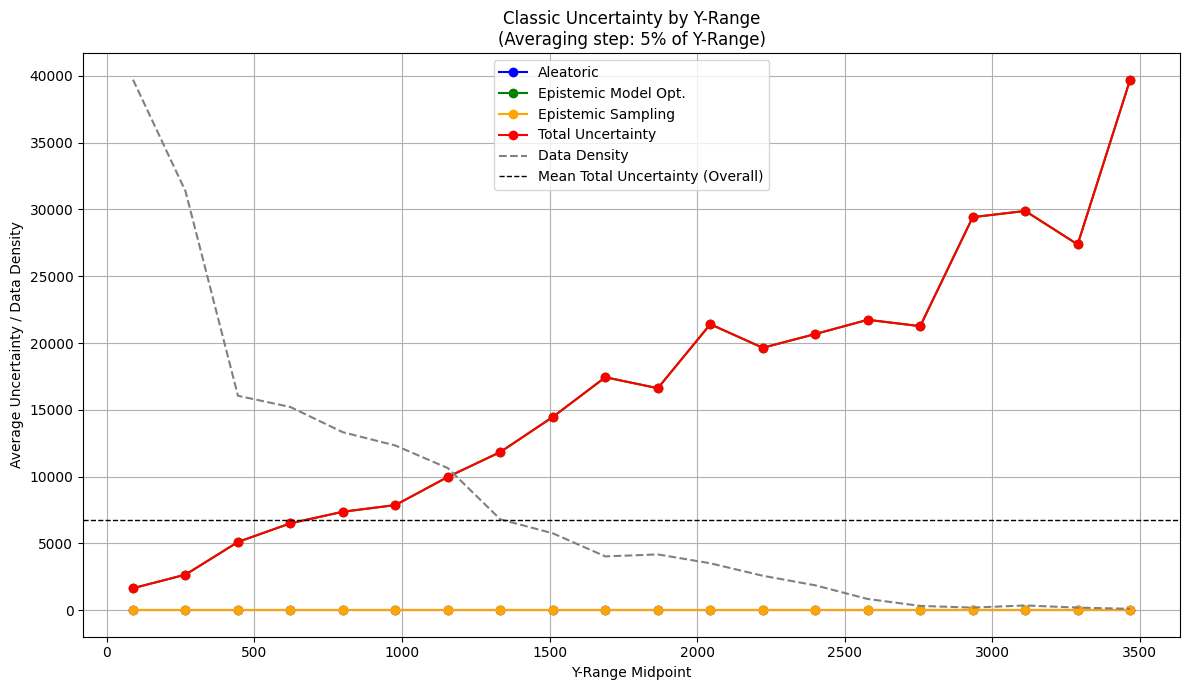

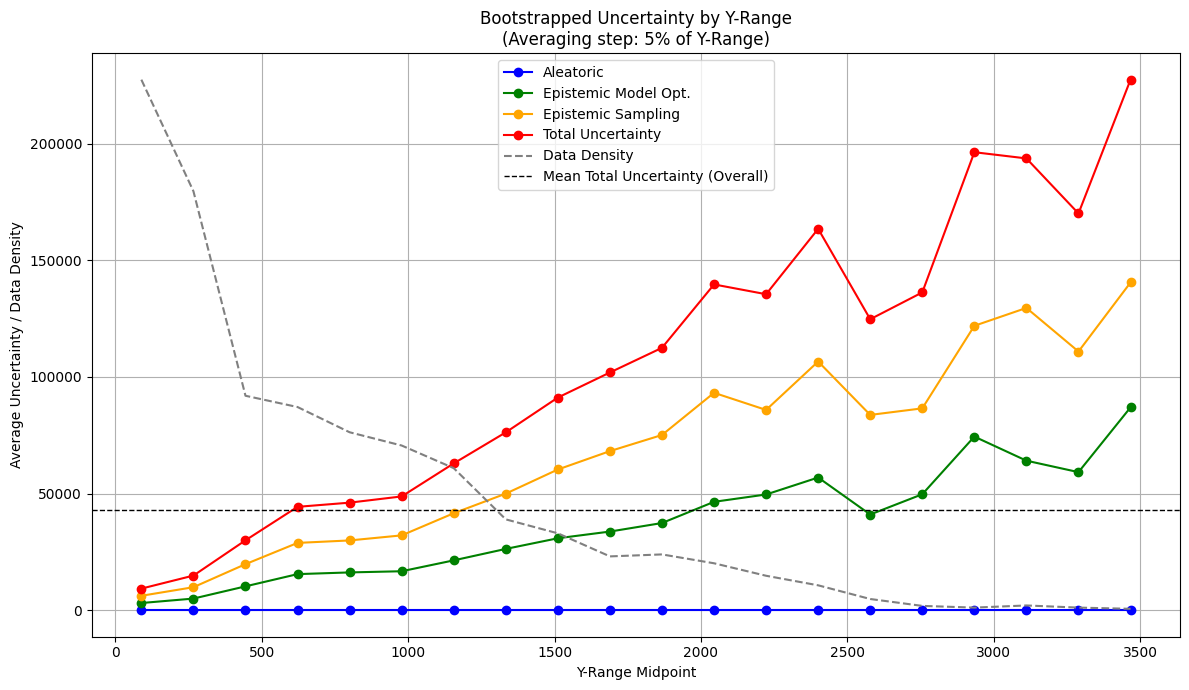

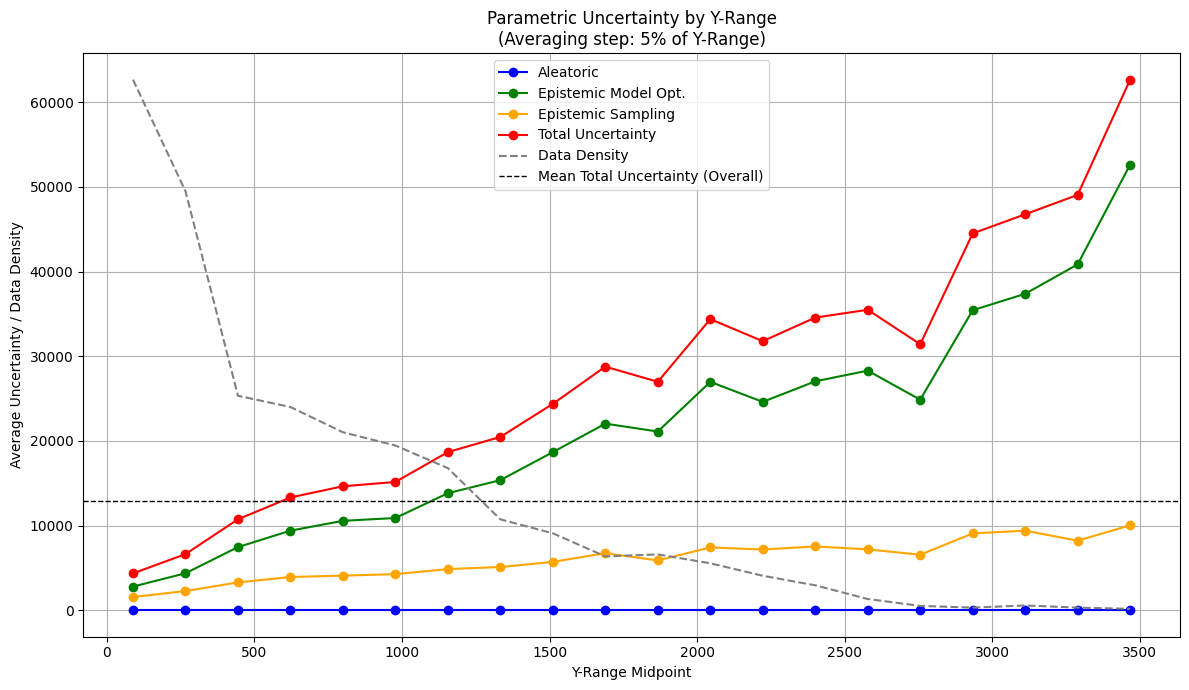

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np


import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_uncertainty_by_y_range(saves_y_test, o_aleatoric, o_epistemic, o_epistemic_sb=None, title="Uncertainty by Y-Range", step_percent=5):
    all_y_values = []
    all_aleatoric = []
    all_epistemic = []
    all_epistemic_sb = []

    # Combine all runs
    for i in range(len(saves_y_test)):
        y_values = saves_y_test[i].squeeze()
        aleatoric = o_aleatoric[i].squeeze()
        epistemic = o_epistemic[i].squeeze()

        if o_epistemic_sb is not None:
            epistemic_sb = o_epistemic_sb[i].squeeze()
        else:
            epistemic_sb = None

        all_y_values.append(y_values)
        all_aleatoric.append(aleatoric)
        all_epistemic.append(epistemic)
        if epistemic_sb is not None:
            all_epistemic_sb.append(epistemic_sb)

    # Concatenate all the values
    all_y_values = torch.cat(all_y_values)
    all_aleatoric = torch.cat(all_aleatoric)
    all_epistemic = torch.cat(all_epistemic)
    all_epistemic_sb = torch.cat(all_epistemic_sb) if o_epistemic_sb is not None else None

    # Determine the full y-range
    y_min = all_y_values.min().item()
    y_max = all_y_values.max().item()
    y_range = y_max - y_min

    # Create intervals based on the step_percent of the full y-range
    step_size = step_percent / 100.0 * y_range
    intervals = np.arange(y_min, y_max, step_size)
    intervals = np.append(intervals, y_max)  # Ensure the last interval reaches y_max

    # Initialize lists to hold the averages for each interval
    avg_aleatoric = []
    avg_epistemic = []
    avg_epistemic_sb = []
    avg_total_uncertainty = []
    densities = []

    # Calculate total uncertainty
    total_uncertainty = all_aleatoric + all_epistemic + (all_epistemic_sb if all_epistemic_sb is not None else 0)

    # Calculate overall mean of total uncertainty
    overall_mean_total_uncertainty = total_uncertainty.mean().item()

    # Calculate averages and density for each y-range interval
    for i in range(len(intervals) - 1):
        lower_bound = intervals[i]
        upper_bound = intervals[i + 1]

        # Get indices for the current y-range interval
        indices = (all_y_values >= lower_bound) & (all_y_values < upper_bound)

        # Calculate the mean uncertainties within this interval
        avg_aleatoric.append(all_aleatoric[indices].mean().item() if indices.any() else np.nan)
        avg_epistemic.append(all_epistemic[indices].mean().item() if indices.any() else np.nan)
        avg_epistemic_sb.append(all_epistemic_sb[indices].mean().item() if all_epistemic_sb is not None and indices.any() else np.nan)
        avg_total_uncertainty.append(total_uncertainty[indices].mean().item() if indices.any() else np.nan)

        # Calculate data density (normalized to fit the plot)
        density = indices.sum().item() / len(all_y_values)
        densities.append(density)

    # Normalize densities to match the range of uncertainties for visualization
    densities = np.array(densities)
    densities = densities / densities.max() * np.nanmax(avg_total_uncertainty)

    # Plotting as curves
    x_labels = [(intervals[i] + intervals[i+1]) / 2 for i in range(len(intervals) - 1)]

    plt.figure(figsize=(12, 7))

    # Plot curves for each type of uncertainty
    plt.plot(x_labels, avg_aleatoric, label='Aleatoric', color='blue', marker='o')
    plt.plot(x_labels, avg_epistemic, label='Epistemic Model Opt.', color='green', marker='o')
    if all_epistemic_sb is not None:
        plt.plot(x_labels, avg_epistemic_sb, label='Epistemic Sampling', color='orange', marker='o')
    plt.plot(x_labels, avg_total_uncertainty, label='Total Uncertainty', color='red', marker='o')

    # Plot data density as a dashed line
    plt.plot(x_labels, densities, label='Data Density', color='gray', linestyle='--')

    # Plot overall mean of total uncertainty as a horizontal dashed line
    plt.axhline(overall_mean_total_uncertainty, color='black', linestyle='--', linewidth=1, label=f'Mean Total Uncertainty (Overall)')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.xlabel('Y-Range Midpoint')
    plt.ylabel('Average Uncertainty / Data Density')
    plt.title(title + f"\n(Averaging step: {step_percent}% of Y-Range)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage with a 5% step
plot_uncertainty_by_y_range(saves_y_test, o_aleatoric_c, o_epistemic_c, o_epistemic_sb_c, "Classic Uncertainty by Y-Range", step_percent=5)
plot_uncertainty_by_y_range(saves_y_test, o_aleatoric_b, o_epistemic_b, o_epistemic_sb_b, "Bootstrapped Uncertainty by Y-Range", step_percent=5)
plot_uncertainty_by_y_range(saves_y_test, o_aleatoric_p, o_epistemic_p, o_epistemic_sb_p, "Parametric Uncertainty by Y-Range", step_percent=5)


Once we know feature importances, we can further investigate the feature ranges for the top uncertain samples (and all samples in comparison), to determine where we need more / better data.

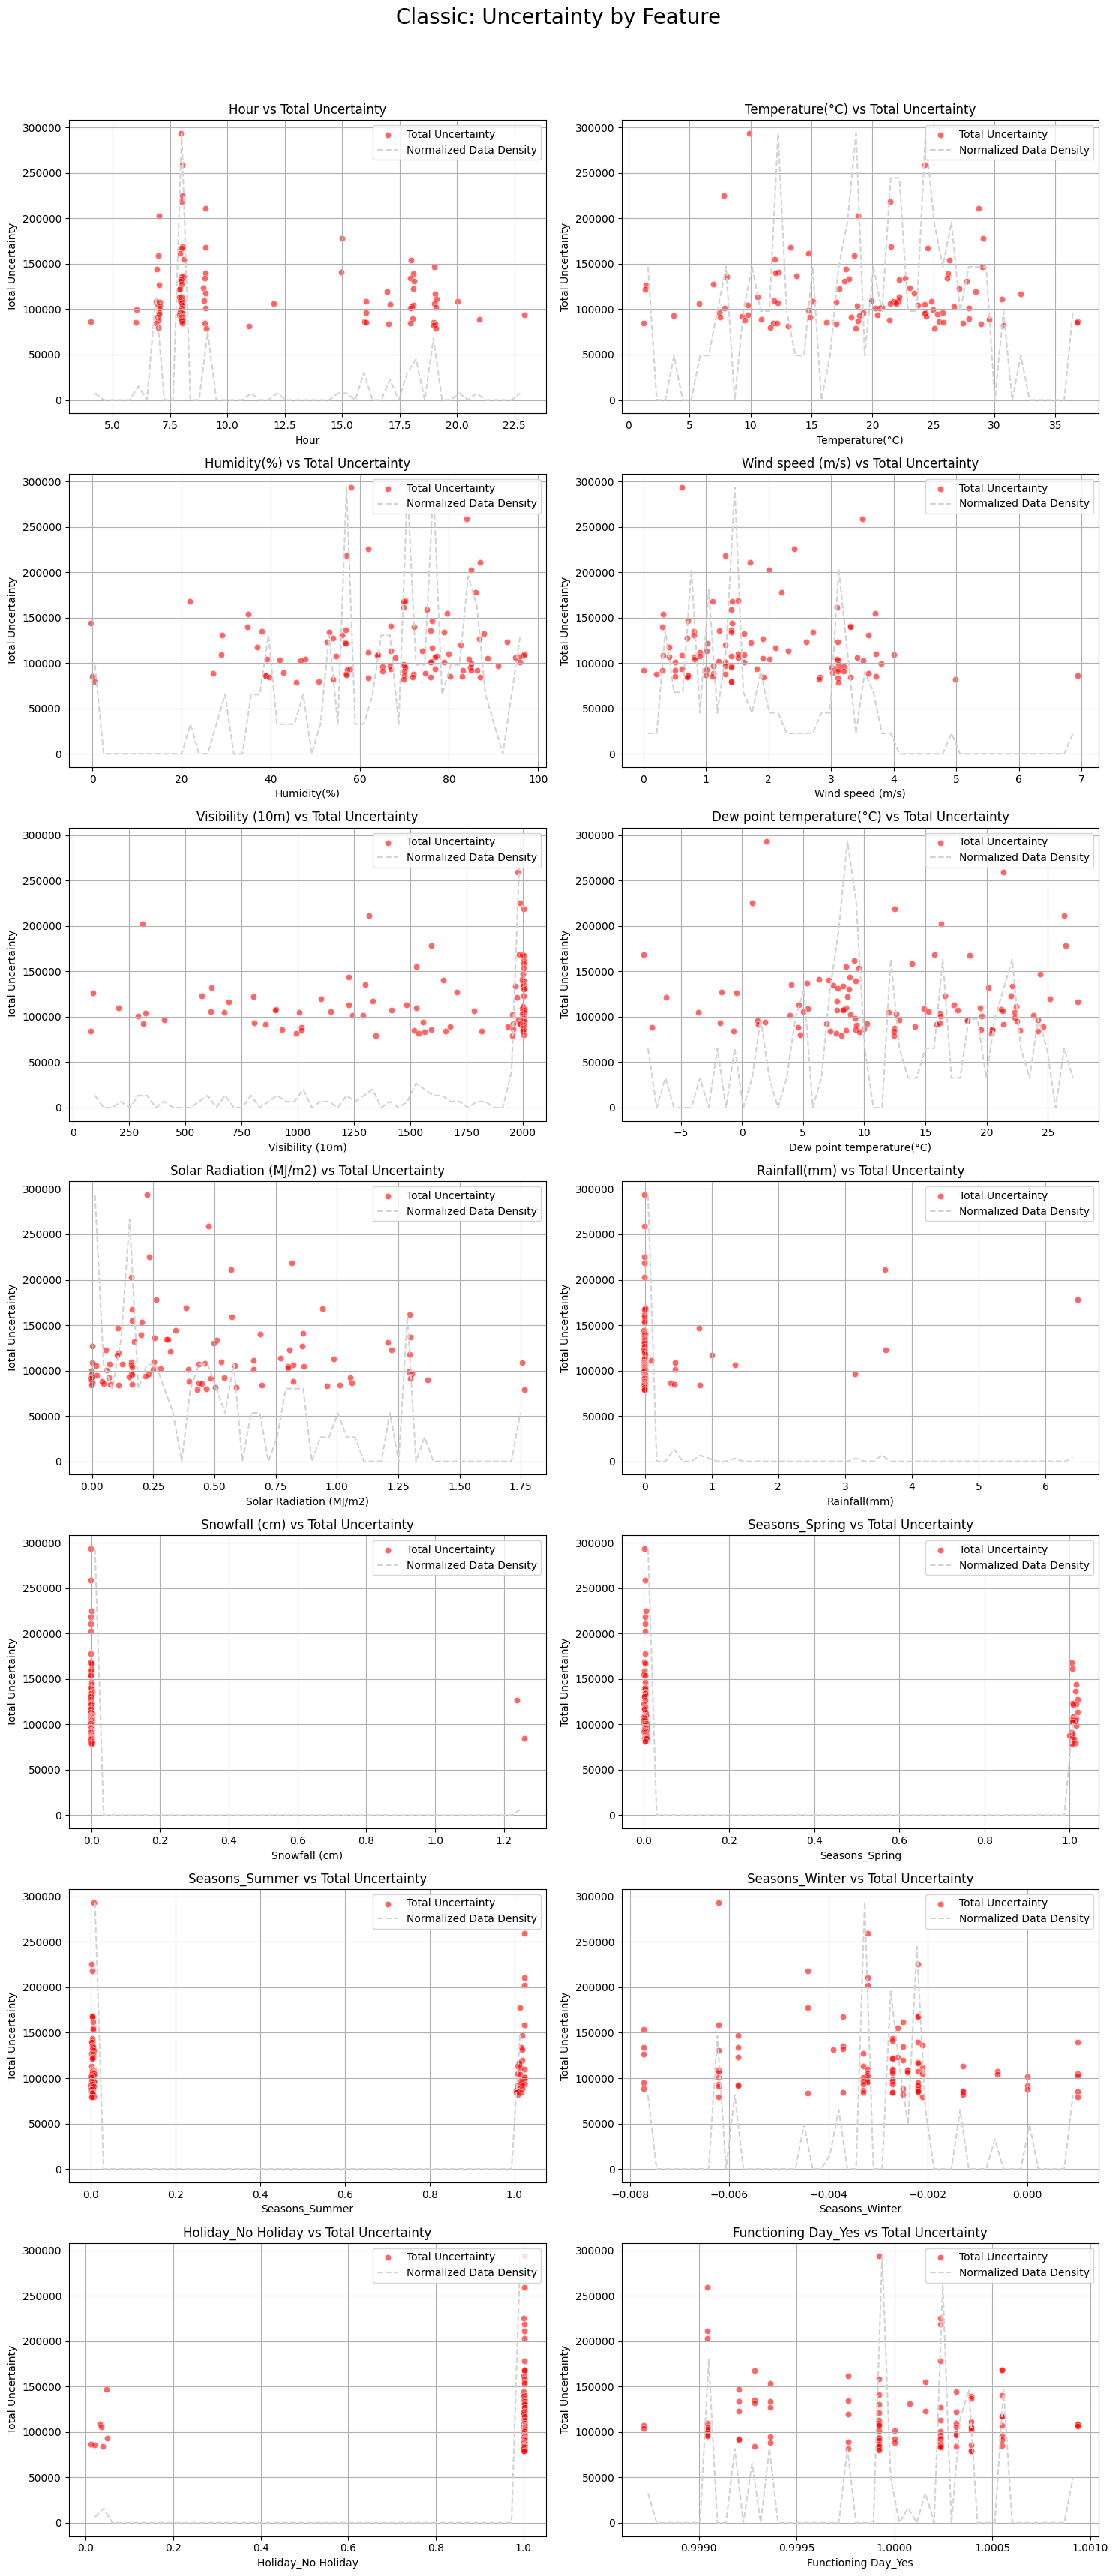

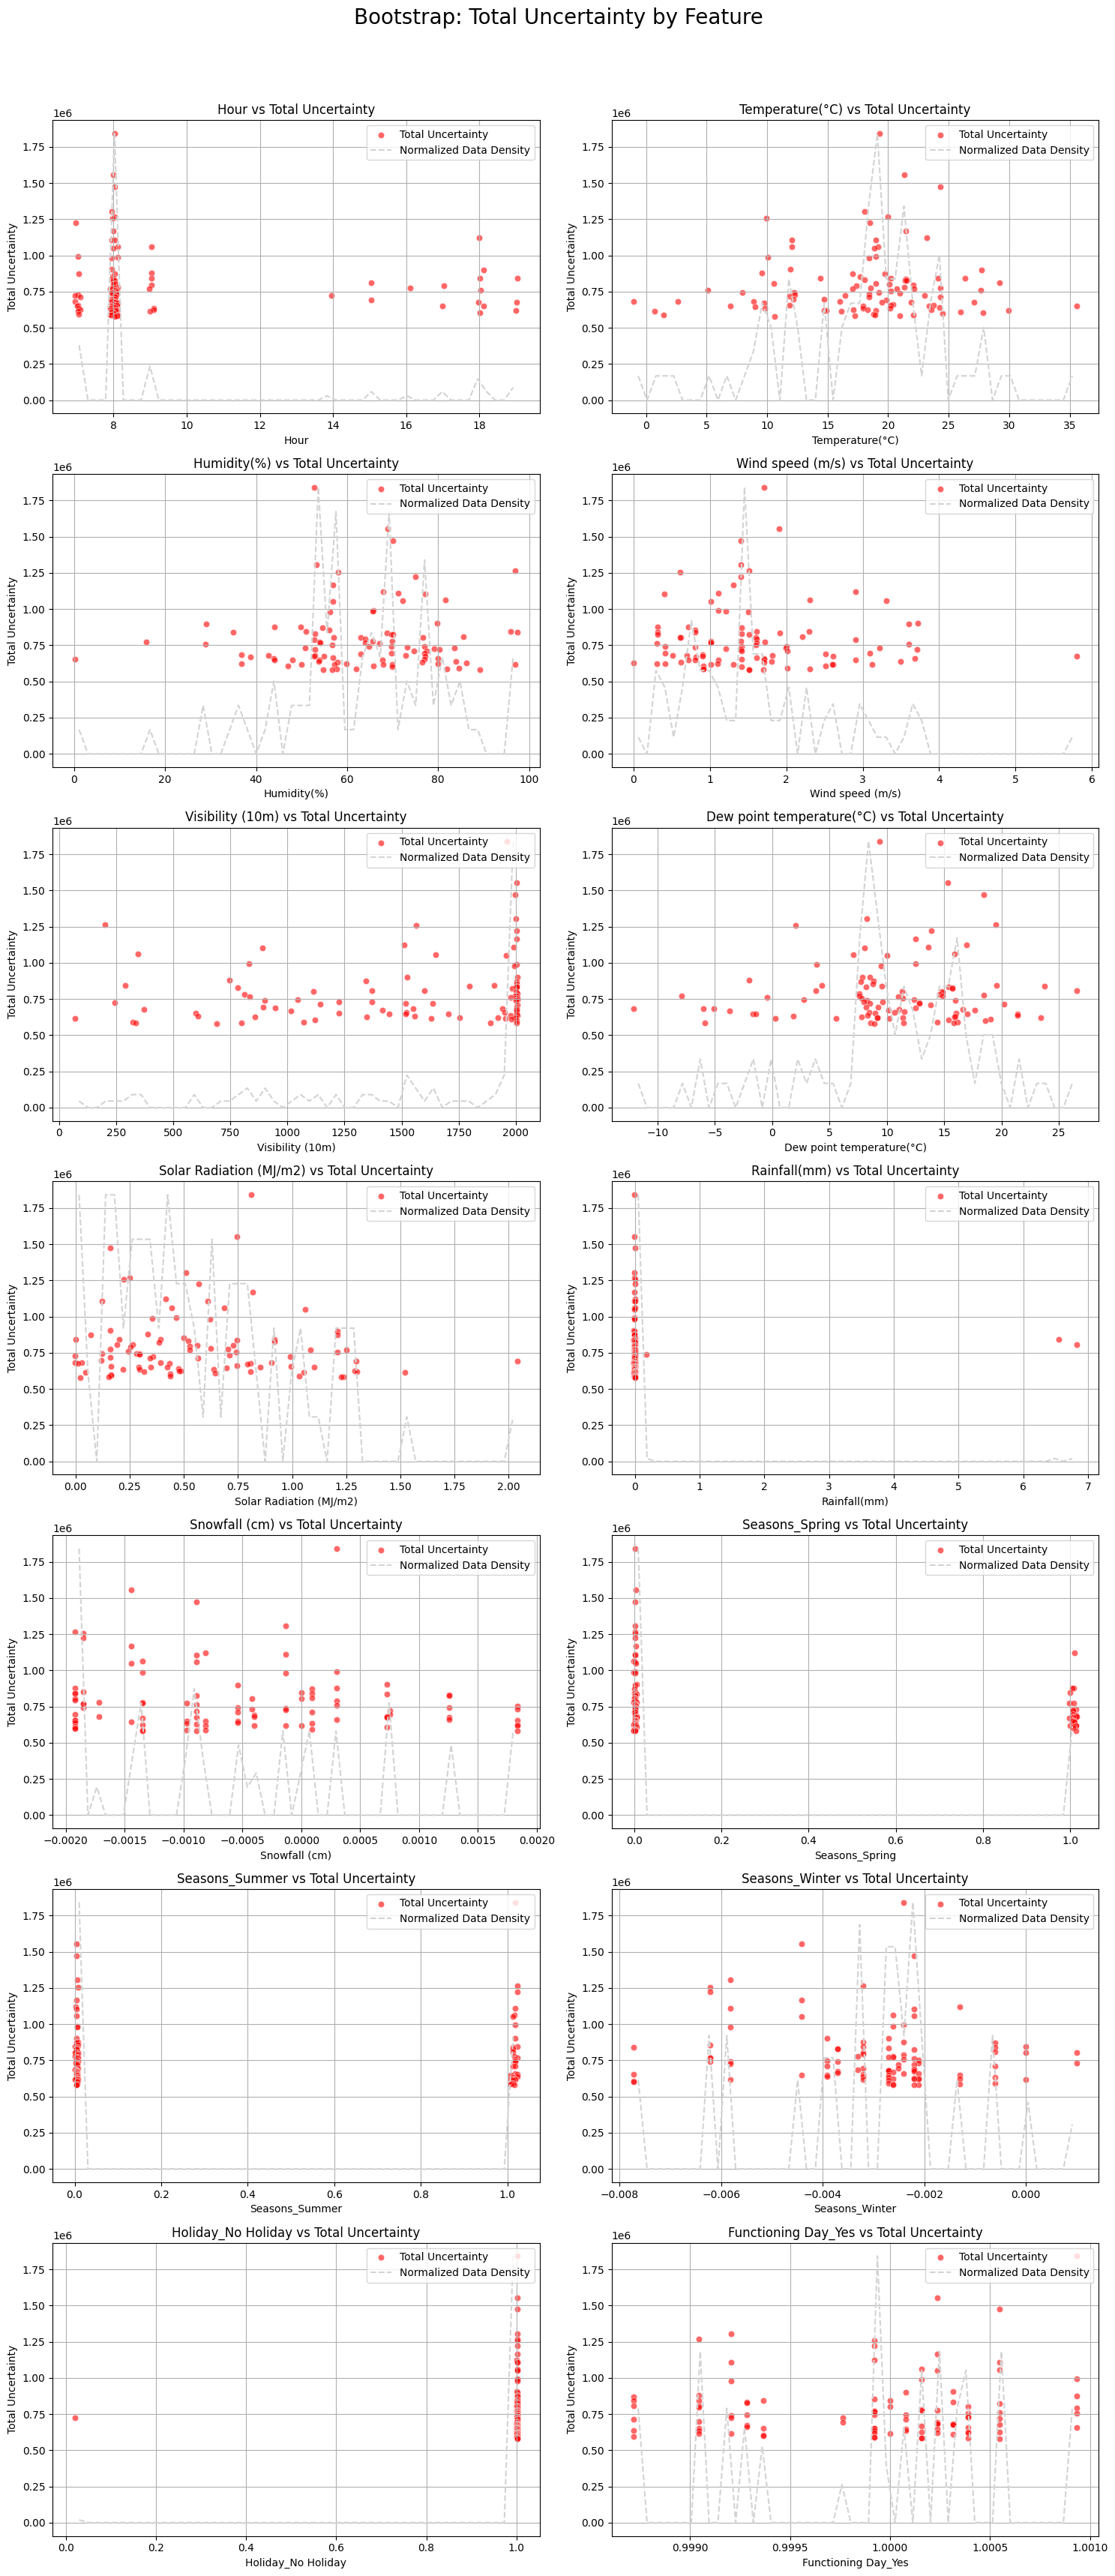

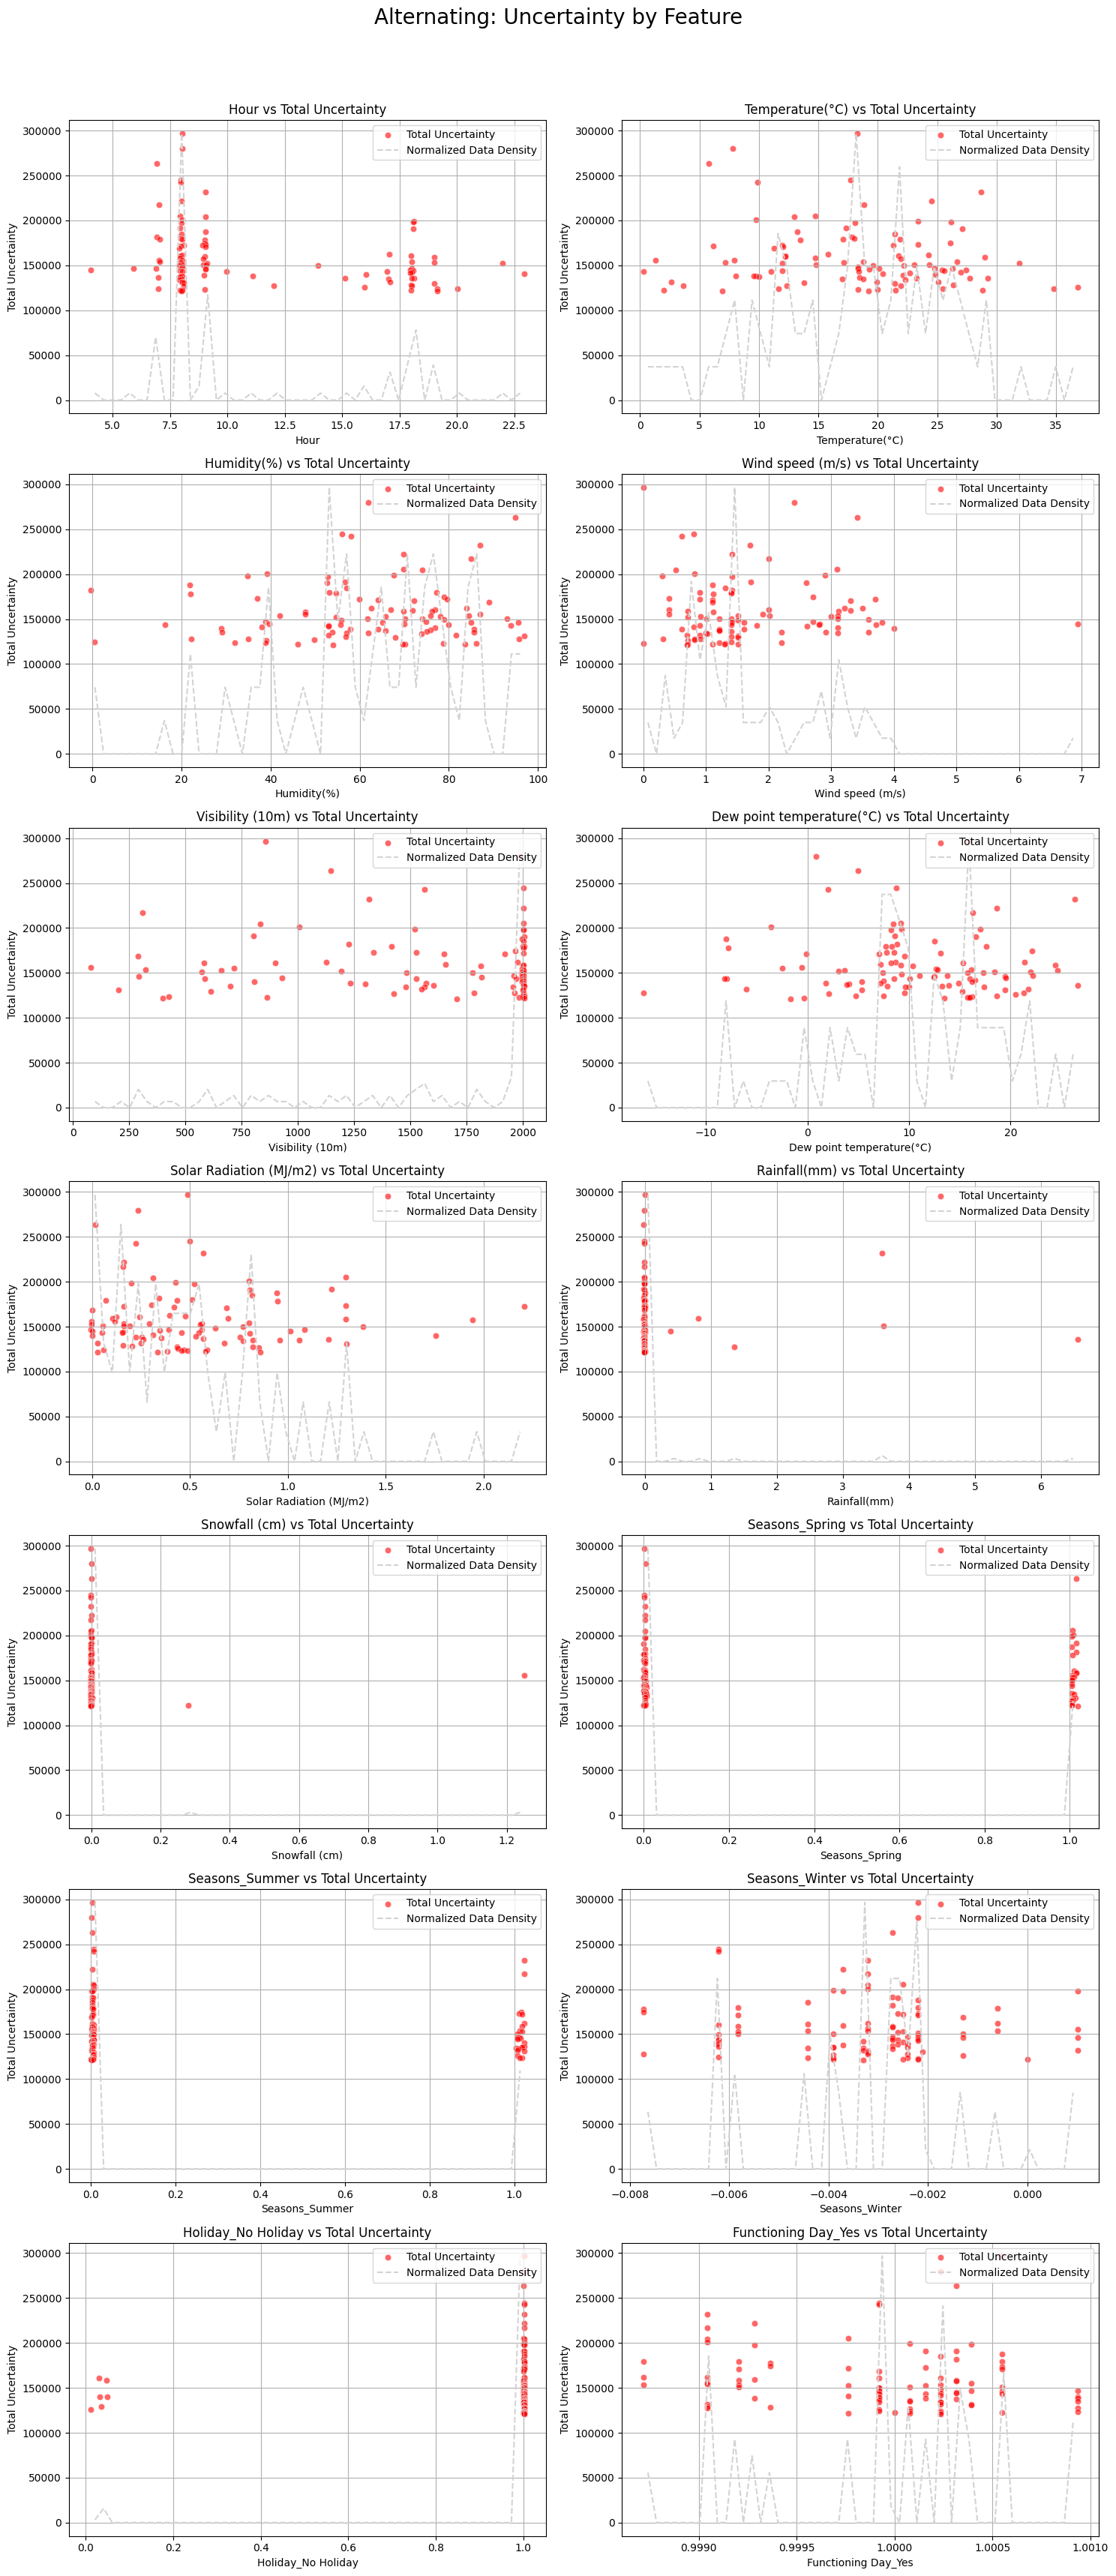

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def plot_total_uncertainty_by_features(saves_X_test, saves_y_test, o_aleatoric, o_epistemic, feature_names, scaler, o_epistemic_sb=None, title="Total Uncertainty by Feature", top_x=None):
    num_features = saves_X_test[0].shape[1]
    num_runs = len(saves_X_test)

    # Combine all runs
    all_X_values = [torch.cat([saves_X_test[i][:, j] for i in range(num_runs)]) for j in range(num_features)]
    all_aleatoric = torch.cat([o_aleatoric[i] for i in range(num_runs)])
    all_epistemic = torch.cat([o_epistemic[i] for i in range(num_runs)])
    all_epistemic_sb = torch.cat([o_epistemic_sb[i] for i in range(num_runs)]) if o_epistemic_sb is not None else None

    # Reverse standardization for X values
    all_X_values_original = []
    for j in range(num_features):
        original_values = []
        for i in range(num_runs):
            original_values.append(scaler.inverse_transform(saves_X_test[i].cpu())[:, j])
        all_X_values_original.append(torch.cat([torch.tensor(vals) for vals in original_values]))

    # Calculate total uncertainty
    total_uncertainty = all_aleatoric + all_epistemic + (all_epistemic_sb if all_epistemic_sb is not None else 0)

    # If top_x is specified, filter to only include the top x uncertain samples
    if top_x is not None:
        top_indices = torch.argsort(total_uncertainty, descending=True)[:top_x]
        total_uncertainty = total_uncertainty[top_indices]
        all_X_values_original = [x_values[top_indices.cpu()] for x_values in all_X_values_original]

    # Create facet grid
    fig, axes = plt.subplots(nrows=int(np.ceil(num_features / 2)), ncols=2, figsize=(15, 5 * int(np.ceil(num_features / 2))))
    axes = axes.flatten()

    for j in range(num_features):
        ax = axes[j]

        # Plot total uncertainty against the original (unstandardized) X values
        sns.scatterplot(x=all_X_values_original[j].cpu().numpy(), y=total_uncertainty.cpu().numpy(), ax=ax, label='Total Uncertainty', color='red', alpha=0.6)

        # Normalize the data density to match the range of the uncertainties
        density, x_density = np.histogram(all_X_values_original[j].cpu().numpy(), bins=50, density=True)
        density = density / density.max() * total_uncertainty.max().item()
        ax.plot((x_density[:-1] + x_density[1:]) / 2, density, linestyle='--', color='lightgrey', label='Normalized Data Density')

        ax.set_xlabel(f'{feature_names[j]}')
        ax.set_ylabel('Total Uncertainty')
        ax.set_title(f'{feature_names[j]} vs Total Uncertainty')

        ax.grid(True)
        ax.legend(loc='upper right')

    # If the number of features is odd, remove the empty subplot
    if num_features % 2 != 0:
        fig.delaxes(axes[-1])

    plt.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
# Assume 'scaler' is the fitted StandardScaler object used to standardize the data
plot_total_uncertainty_by_features(saves_X_test, saves_y_test, o_aleatoric_c, o_epistemic_c, feature_names, scaler, o_epistemic_sb_c, "Classic: Uncertainty by Feature", top_x=100)
plot_total_uncertainty_by_features(saves_X_test, saves_y_test, o_aleatoric_b, o_epistemic_b, feature_names, scaler, o_epistemic_sb_b, "Bootstrap: Total Uncertainty by Feature", top_x=100)
plot_total_uncertainty_by_features(saves_X_test, saves_y_test, o_aleatoric_p, o_epistemic_p, feature_names, scaler, o_epistemic_sb_p, "Alternating: Uncertainty by Feature", top_x=100)

# **Z-Score Ratios Combi Features**

For Combi-Feature (2 + 7) Correlation: Z-Score
GI Classic: -0.17445258796215057
GI Bootstrapped: -0.3437463641166687
GI Alternating: -0.2089114785194397
LRP Classic: -0.6075015664100647
LRP Bootstrapped: -0.35660961270332336
LRP Alternating: -0.32425689697265625


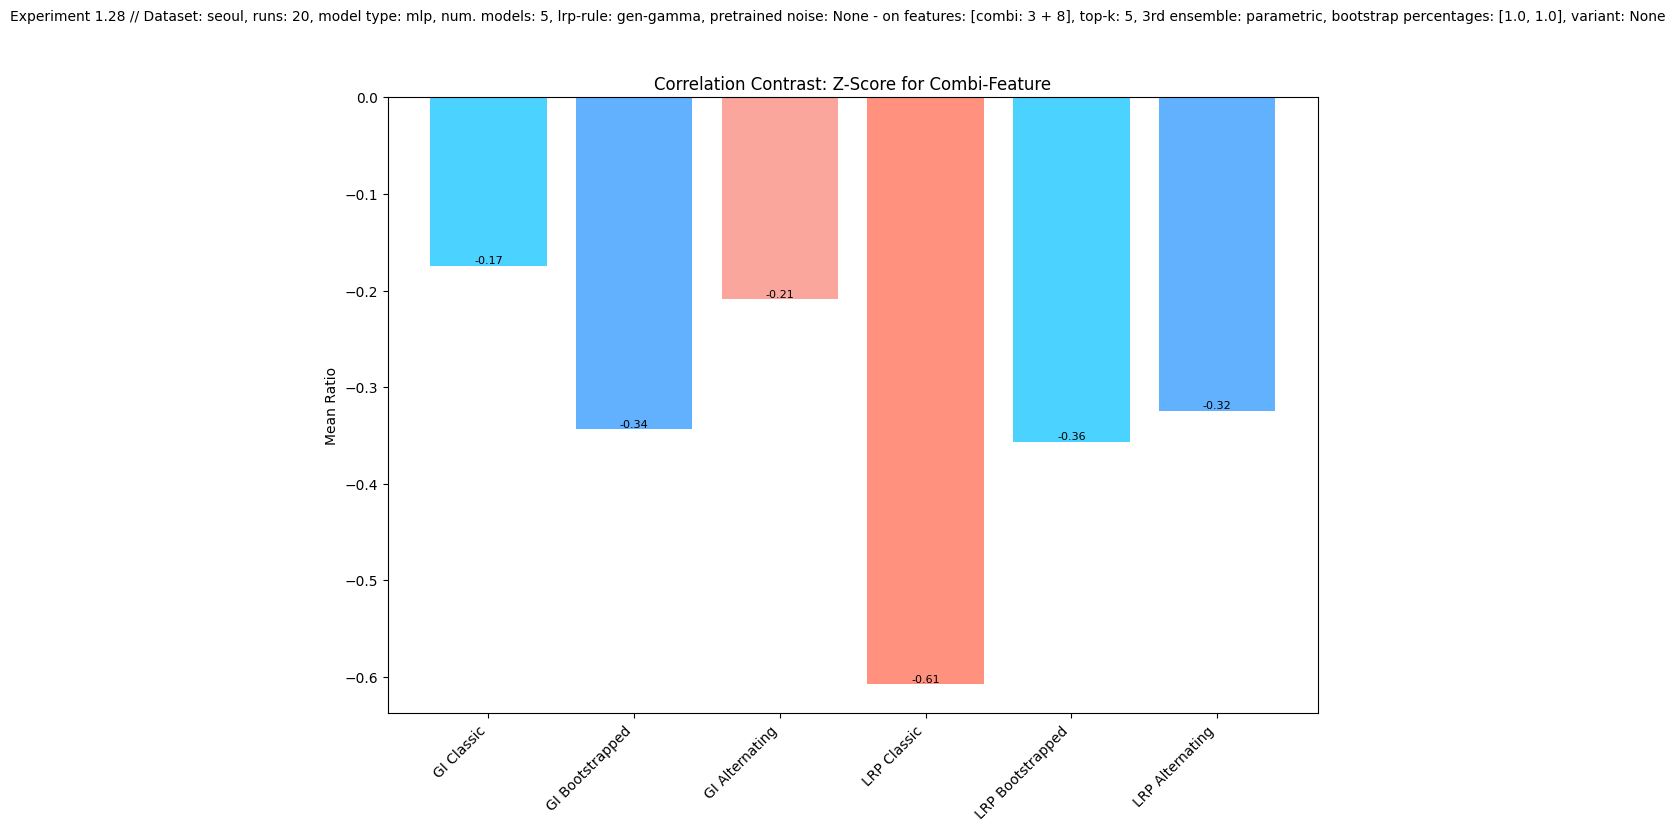

In [ ]:

def calculate_contrast_ratio(interaction_value, field_values):
    field_mean = np.mean(field_values)
    return interaction_value / field_mean

def calculate_z_score(interaction_value, field_values):
    field_mean = np.mean(field_values)
    field_std = np.std(field_values)
    return (interaction_value - field_mean) / field_std

def evaluate_interaction(cov_matrix, feature_1, feature_2):
    # Determine the size of the covariance matrix
    max_index = cov_matrix.shape[0] - 1  # Maximum valid index based on matrix size

    # Check and correct feature_1 if out of bounds
    if feature_1 > max_index:
        print(f"feature_1 index {feature_1} is out of bounds. Using default index 1.")
        feature_1 = 1 if max_index >= 1 else 0

    # Check and correct feature_2 if out of bounds
    if feature_2 > max_index:
        print(f"feature_2 index {feature_2} is out of bounds. Using default index 2.")
        feature_2 = 2 if max_index >= 2 else 0

    # Extract the interaction value between the specified features
    interaction_value = cov_matrix[feature_1, feature_2]

    # Extract off-diagonal elements and exclude the interaction value
    field_values = []
    for i in range(cov_matrix.shape[0]):
        for j in range(cov_matrix.shape[1]):
            if i != j:
                field_values.append(cov_matrix[i, j])

    # Calculate z-score
    z_score = calculate_z_score(interaction_value, field_values)
    return z_score

gi_z_score_c = evaluate_interaction(calculate_mean_covariance(o_gi_topi_cov_matrices_c), combi_feature_1, combi_feature_2)
gi_z_score_b = evaluate_interaction(calculate_mean_covariance(o_gi_topi_cov_matrices_b), combi_feature_1, combi_feature_2)
gi_z_score_p = evaluate_interaction(calculate_mean_covariance(o_gi_topi_cov_matrices_p), combi_feature_1, combi_feature_2)
lrp_z_score_c = evaluate_interaction(calculate_mean_covariance(o_lrp_topi_cov_matrices_c), combi_feature_1, combi_feature_2)
lrp_z_score_b = evaluate_interaction(calculate_mean_covariance(o_lrp_topi_cov_matrices_b), combi_feature_1, combi_feature_2)
lrp_z_score_p = evaluate_interaction(calculate_mean_covariance(o_lrp_topi_cov_matrices_p), combi_feature_1, combi_feature_2)

print(f"For Combi-Feature ({combi_feature_1} + {combi_feature_2}) Correlation: Z-Score")
print(f"GI Classic: {gi_z_score_c}")
print(f"GI Bootstrapped: {gi_z_score_b}")
print(f"GI Alternating: {gi_z_score_p}")
print(f"LRP Classic: {lrp_z_score_c}")
print(f"LRP Bootstrapped: {lrp_z_score_b}")
print(f"LRP Alternating: {lrp_z_score_p}")

ratios_corr_zscore = {
    "GI Classic": gi_z_score_c,
    "GI Bootstrapped": gi_z_score_b,
    "GI Alternating": gi_z_score_p,
    "LRP Classic": lrp_z_score_c,
    "LRP Bootstrapped": lrp_z_score_b,
    "LRP Alternating": lrp_z_score_p
}

plot_mean_ratios(ratios_corr_zscore, "Correlation Contrast: Z-Score for Combi-Feature", experiment_info)

if model_type == "mlp-nll":
  gi_z_score_c_var = evaluate_interaction(calculate_mean_covariance(o_gi_topi_cov_matrices_c_var), combi_feature_1, combi_feature_2)
  gi_z_score_b_var = evaluate_interaction(calculate_mean_covariance(o_gi_topi_cov_matrices_b_var), combi_feature_1, combi_feature_2)
  gi_z_score_p_var = evaluate_interaction(calculate_mean_covariance(o_gi_topi_cov_matrices_p_var), combi_feature_1, combi_feature_2)
  lrp_z_score_c_var = evaluate_interaction(calculate_mean_covariance(o_lrp_topi_cov_matrices_c_var), combi_feature_1, combi_feature_2)
  lrp_z_score_b_var = evaluate_interaction(calculate_mean_covariance(o_lrp_topi_cov_matrices_b_var), combi_feature_1, combi_feature_2)
  lrp_z_score_p_var = evaluate_interaction(calculate_mean_covariance(o_lrp_topi_cov_matrices_p_var), combi_feature_1, combi_feature_2)

  print(f"For Combi-Feature ({combi_feature_1} + {combi_feature_2}) Correlation: Z-Score (Var)")
  print(f"GI Classic: {gi_z_score_c_var}")
  print(f"GI Bootstrapped: {gi_z_score_b_var}")
  print(f"GI Alternating: {gi_z_score_p_var}")
  print(f"LRP Classic: {lrp_z_score_c_var}")
  print(f"LRP Bootstrapped: {lrp_z_score_b_var}")
  print(f"LRP Alternating: {lrp_z_score_p_var}")

  ratios_corr_zscore_var = {
      "GI Classic": gi_z_score_c_var,
      "GI Bootstrapped": gi_z_score_b_var,
      "GI Alternating": gi_z_score_p_var,
      "LRP Classic": lrp_z_score_c_var,
      "LRP Bootstrapped": lrp_z_score_b_var,
      "LRP Alternating": lrp_z_score_p_var
      }

  plot_mean_ratios(ratios_corr_zscore_var, "Correlation Contrast: Z-Score for Combi-Feature (Var)", experiment_info)


# *Better Z-Score Visualisation*

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [5, 5.1, 5.2, 5.3, 5.4, 5.5]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
grid_search.fit(X_train.cpu(), y_train.cpu())
best_alpha = grid_search.best_params_['alpha']
print(best_alpha)

5.5


[[ 4.30257344e+05 -1.79620020e+04 -2.14482598e+04 -1.60281846e+04
  -7.02367285e+03 -1.47592715e+04  3.65139331e+03 -2.60635820e+04
  -6.65609521e+03 -1.88939785e+04 -2.39498984e+04 -3.99305977e+04
  -7.55614990e+03 -2.87871914e+04]
 [-1.79620020e+04  8.15271250e+04  1.25977173e+03 -2.84526416e+03
   1.36161877e+03  4.89952148e+04 -4.01974561e+03 -7.47700928e+03
  -3.84566284e+03 -1.78449927e+03 -1.12636738e+04 -2.24632500e+04
  -1.41756274e+03 -7.04439941e+03]
 [-2.14482598e+04  1.25977173e+03  1.17211047e+05  2.41027985e+02
  -1.01097061e+04  5.51978320e+03 -1.48666016e+04 -5.82658984e+03
  -1.43338513e+03 -6.80849792e+02 -2.58821777e+03 -1.00801113e+04
   7.14011240e+00 -6.94165137e+03]
 [-1.60281846e+04 -2.84526416e+03  2.41027985e+02  6.73596641e+04
   4.42919824e+03 -3.32816528e+03 -6.45895813e+02 -2.52799902e+03
  -2.04725269e+03  2.45018875e+02  4.93767773e+03 -6.32272949e+03
   1.18965930e+03 -5.06725928e+03]
 [-7.02367285e+03  1.36161877e+03 -1.01097061e+04  4.42919824e+03
  

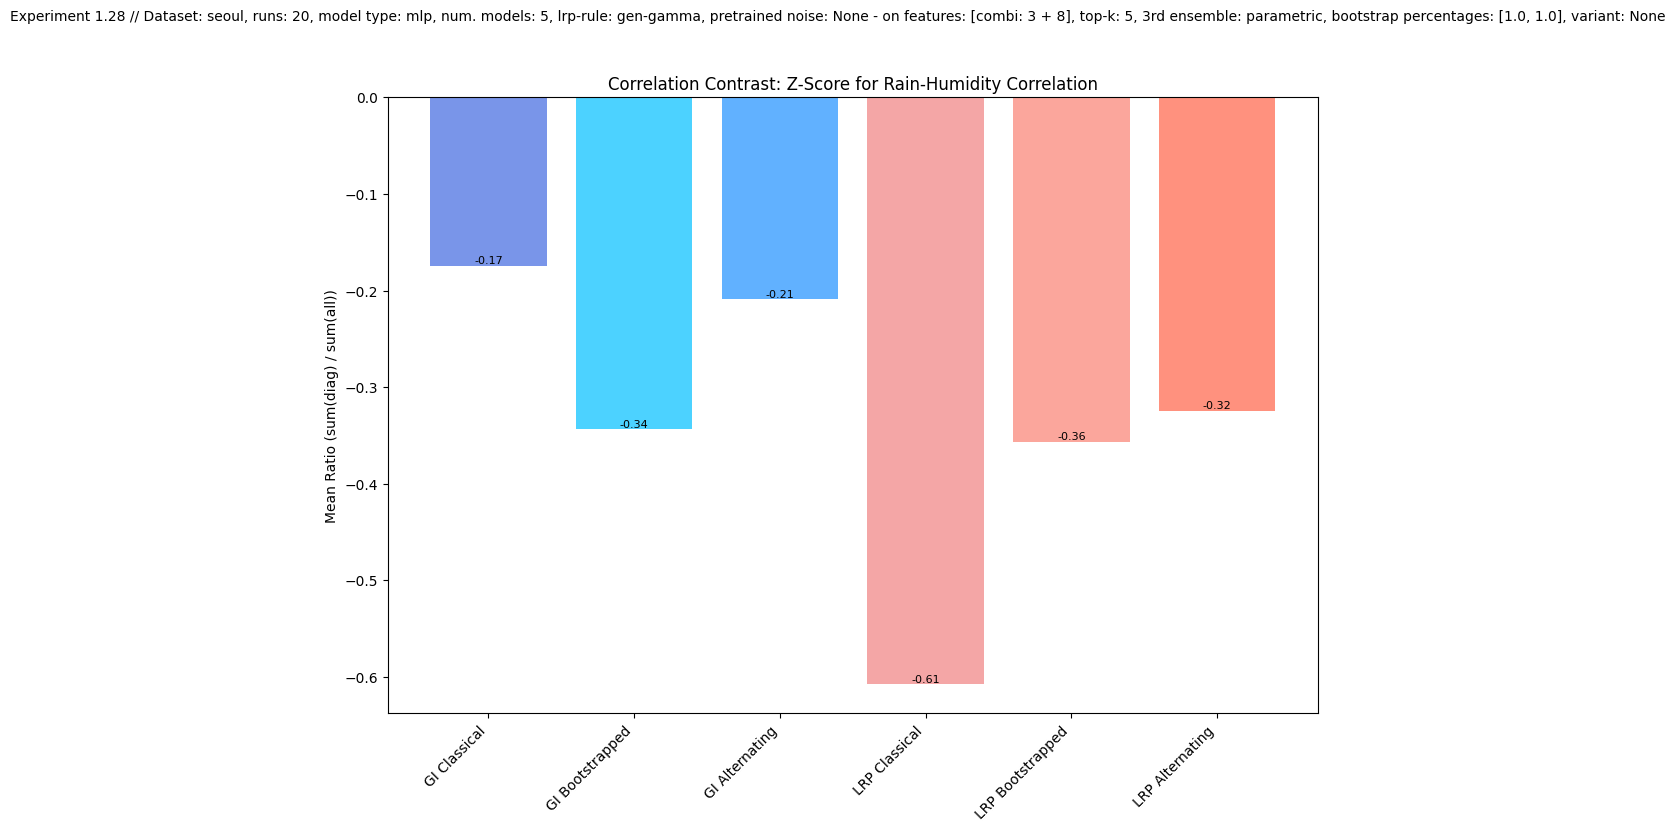

In [ ]:
combi_feature_1 = 2
combi_feature_2 = 7

classic_mean_matrix = calculate_mean_covariance(o_gi_topi_cov_matrices_c)
if np.any(classic_mean_matrix == 0):
    print("Warning: Classic covariance matrix contains zero elements.")
print(classic_mean_matrix)

if np.any(calculate_mean_covariance(o_gi_topi_cov_matrices_b) == 0):
    print("Warning: Bootstrapped covariance matrix contains zero elements.")

gi_z_score_c = evaluate_interaction(calculate_mean_covariance(o_gi_topi_cov_matrices_c), combi_feature_1, combi_feature_2)
gi_z_score_b = evaluate_interaction(calculate_mean_covariance(o_gi_topi_cov_matrices_b), combi_feature_1, combi_feature_2)
gi_z_score_p = evaluate_interaction(calculate_mean_covariance(o_gi_topi_cov_matrices_p), combi_feature_1, combi_feature_2)
lrp_z_score_c = evaluate_interaction(calculate_mean_covariance(o_lrp_topi_cov_matrices_c), combi_feature_1, combi_feature_2)
lrp_z_score_b = evaluate_interaction(calculate_mean_covariance(o_lrp_topi_cov_matrices_b), combi_feature_1, combi_feature_2)
lrp_z_score_p = evaluate_interaction(calculate_mean_covariance(o_lrp_topi_cov_matrices_p), combi_feature_1, combi_feature_2)


def plot_mean_ratios(ratios, title, experiment_info=""):
    plt.figure(figsize=(12, 8))

    colors = {
        "GI Classical": "royalblue",
        "GI Bootstrapped": "deepskyblue",
        "GI Alternating": "dodgerblue",
        "LRP Classical": "lightcoral",
        "LRP Bootstrapped": "salmon",
        "LRP Alternating": "tomato"
    }

    color_list = []
    for key in ratios.keys():
        if "GI Classical" in key:
            color_list.append(colors["GI Classical"])
        elif "GI Bootstrapped" in key:
            color_list.append(colors["GI Bootstrapped"])
        elif "GI Alternating" in key:
            color_list.append(colors["GI Alternating"])
        elif "LRP Classical" in key:
            color_list.append(colors["LRP Classical"])
        elif "LRP Bootstrapped" in key:
            color_list.append(colors["LRP Bootstrapped"])
        elif "LRP Alternating" in key:
            color_list.append(colors["LRP Alternating"])
        elif "Top-i" in key:
            color_list.append(colors["GI Classical"])

    x = np.arange(len(ratios))
    plt.bar(x, list(ratios.values()), align='center', alpha=0.7, color=color_list)
    plt.xticks(x, list(ratios.keys()), rotation=45, ha='right')
    plt.ylabel('Mean Ratio (sum(diag) / sum(all))')
    plt.title(title)
    plt.suptitle(experiment_info, fontsize=10, y=0.99)

    for i, (key, value) in enumerate(ratios.items()):
        plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

    plt.show()


ratios_corr_zscore = {
    "GI Classical": gi_z_score_c,
    "GI Bootstrapped": gi_z_score_b,
    "GI Alternating": gi_z_score_p,
    "LRP Classical": lrp_z_score_c,
    "LRP Bootstrapped": lrp_z_score_b,
    "LRP Alternating": lrp_z_score_p
}

plot_mean_ratios(ratios_corr_zscore, "Correlation Contrast: Z-Score for Rain-Humidity Correlation", experiment_info)

# *Other Stuff* :)

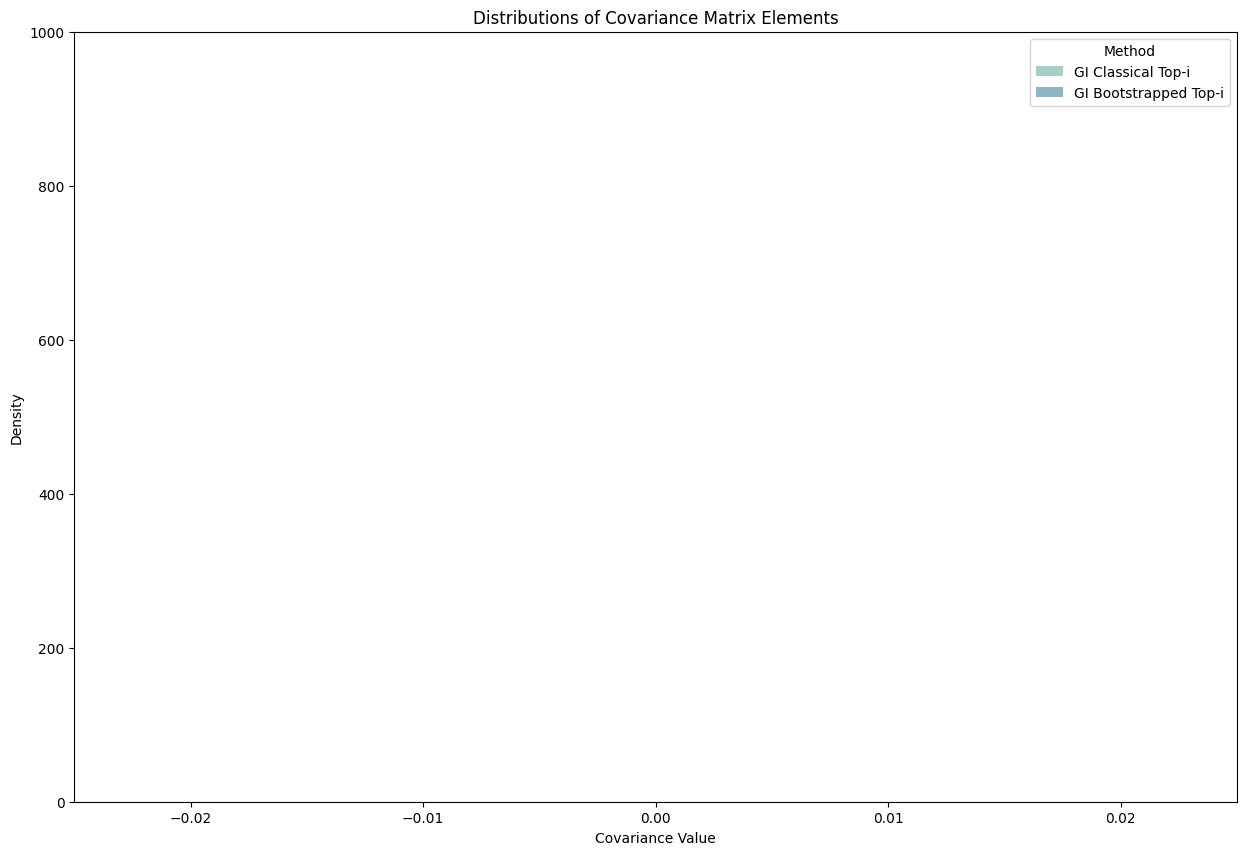

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def get_all_elements(cov_matrices):
    elements = []
    for matrix in cov_matrices:
        elements.extend(matrix.flatten())
    return elements

def get_diag_elements(cov_matrices):
    diag_elements = []
    for matrix in cov_matrices:
        diag_elements.extend(np.diag(matrix).flatten())
    return diag_elements

def prepare_data_for_plotting(o_gi_cov_matrices_c, o_gi_cov_matrices_b, o_gi_cov_matrices_p,
                              o_lrp_cov_matrices_c, o_lrp_cov_matrices_b, o_lrp_cov_matrices_p):
    data = []

    gi_c = get_all_elements(o_gi_cov_matrices_c)
    gi_b = get_all_elements(o_gi_cov_matrices_b)
    gi_p = get_diag_elements(o_gi_cov_matrices_p)
    lrp_c = get_diag_elements(o_lrp_cov_matrices_c)
    lrp_b = get_all_elements(o_lrp_cov_matrices_b)
    lrp_p = get_all_elements(o_lrp_cov_matrices_p)

    data.append(pd.DataFrame({'Value': gi_c, 'Method': 'GI Classical Top-i'}))
    data.append(pd.DataFrame({'Value': gi_b, 'Method': 'GI Bootstrapped Top-i'}))
    #data.append(pd.DataFrame({'Value': gi_p, 'Method': 'GI Classical Top-i Diag'}))
    #data.append(pd.DataFrame({'Value': lrp_c, 'Method': 'GI Bootstrapped Top-i Diag'}))
    #data.append(pd.DataFrame({'Value': lrp_b, 'Method': 'LRP Bootstrapped'}))
    #data.append(pd.DataFrame({'Value': lrp_p, 'Method': 'LRP Parametric'}))

    return pd.concat(data)

data = prepare_data_for_plotting(calculate_mean_covariance(o_gi_topi_cov_matrices_c), calculate_mean_covariance(o_gi_topi_cov_matrices_b), calculate_mean_covariance(o_gi_cov_matrices_c),
                                 calculate_mean_covariance(o_gi_cov_matrices_b), calculate_mean_covariance(o_lrp_topi_cov_matrices_b), calculate_mean_covariance(o_lrp_topi_cov_matrices_p))

# Create the KDE plot
plt.figure(figsize=(15, 10))
sns.kdeplot(data=data, x='Value', hue='Method', palette="crest", fill=True, common_norm=False,
   alpha=.5, linewidth=0,)
plt.title('Distributions of Covariance Matrix Elements')
plt.xlim([-0.025, 0.025])  # Adjust limits as needed
plt.ylim([0, 1000])    # Adjust limits as needed
plt.xlabel('Covariance Value')
plt.ylabel('Density')
plt.show()

#print(calculate_mean_covariance(o_gi_topi_cov_matrices_c))
#print(calculate_mean_covariance(o_gi_topi_cov_matrices_b))

In [ ]:
print("Shape of o_gi_top_cov_matrices_c:", [matrix.shape for matrix in o_gi_top_cov_matrices_c])
print("Shape of o_gi_cov_matrices_c:", [matrix.shape for matrix in o_gi_cov_matrices_c])
print("Shape of o_gi_top_cov_matrices_b:", [matrix.shape for matrix in o_gi_top_cov_matrices_b])
print("Shape of o_gi_cov_matrices_b:", [matrix.shape for matrix in o_gi_cov_matrices_b])
print("Shape of o_gi_top_cov_matrices_p:", [matrix.shape for matrix in o_gi_top_cov_matrices_p])
print("Shape of o_gi_cov_matrices_p:", [matrix.shape for matrix in o_gi_cov_matrices_p])
print("Shape of o_lrp_top_cov_matrices_c:", [matrix.shape for matrix in o_lrp_top_cov_matrices_c])
print("Shape of o_lrp_cov_matrices_c:", [matrix.shape for matrix in o_lrp_cov_matrices_c])
print("Shape of o_lrp_top_cov_matrices_b:", [matrix.shape for matrix in o_lrp_top_cov_matrices_b])
print("Shape of o_lrp_cov_matrices_b:", [matrix.shape for matrix in o_lrp_cov_matrices_b])
print("Shape of o_lrp_top_cov_matrices_p:", [matrix.shape for matrix in o_lrp_top_cov_matrices_p])
print("Shape of o_lrp_cov_matrices_p:", [matrix.shape for matrix in o_lrp_cov_matrices_p])


Shape of o_gi_top_cov_matrices_c: [torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14])]
Shape of o_gi_cov_matrices_c: [torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14]), torch.Size([14, 14])]
Shape of o_gi_top_cov_matrices_b: [torch.Size([14, 14]

-----
GI:
{'Classic CovGI Diag': ['Hour', 'Humidity(%)', 'Solar Radiation (MJ/m2)', 'Temperature(°C)', 'Seasons_Summer', 'Wind speed (m/s)', 'Visibility (10m)', 'Seasons_Spring', 'Dew point temperature(°C)', 'Seasons_Winter', 'Rainfall(mm)', 'Holiday_No Holiday', 'Functioning Day_Yes', 'Snowfall (cm)'], 'Bootstrapped CovGI Diag': ['Hour', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Temperature(°C)', 'Solar Radiation (MJ/m2)', 'Seasons_Summer', 'Dew point temperature(°C)', 'Seasons_Spring', 'Seasons_Winter', 'Rainfall(mm)', 'Functioning Day_Yes', 'Holiday_No Holiday', 'Snowfall (cm)'], 'Alternating CovGI Diag': ['Hour', 'Humidity(%)', 'Temperature(°C)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Wind speed (m/s)', 'Seasons_Summer', 'Seasons_Spring', 'Dew point temperature(°C)', 'Seasons_Winter', 'Rainfall(mm)', 'Holiday_No Holiday', 'Functioning Day_Yes', 'Snowfall (cm)']}
Feature Rankings for Selected Configurations:
           Classic CovGI Diag    Bootstrapped CovGI 

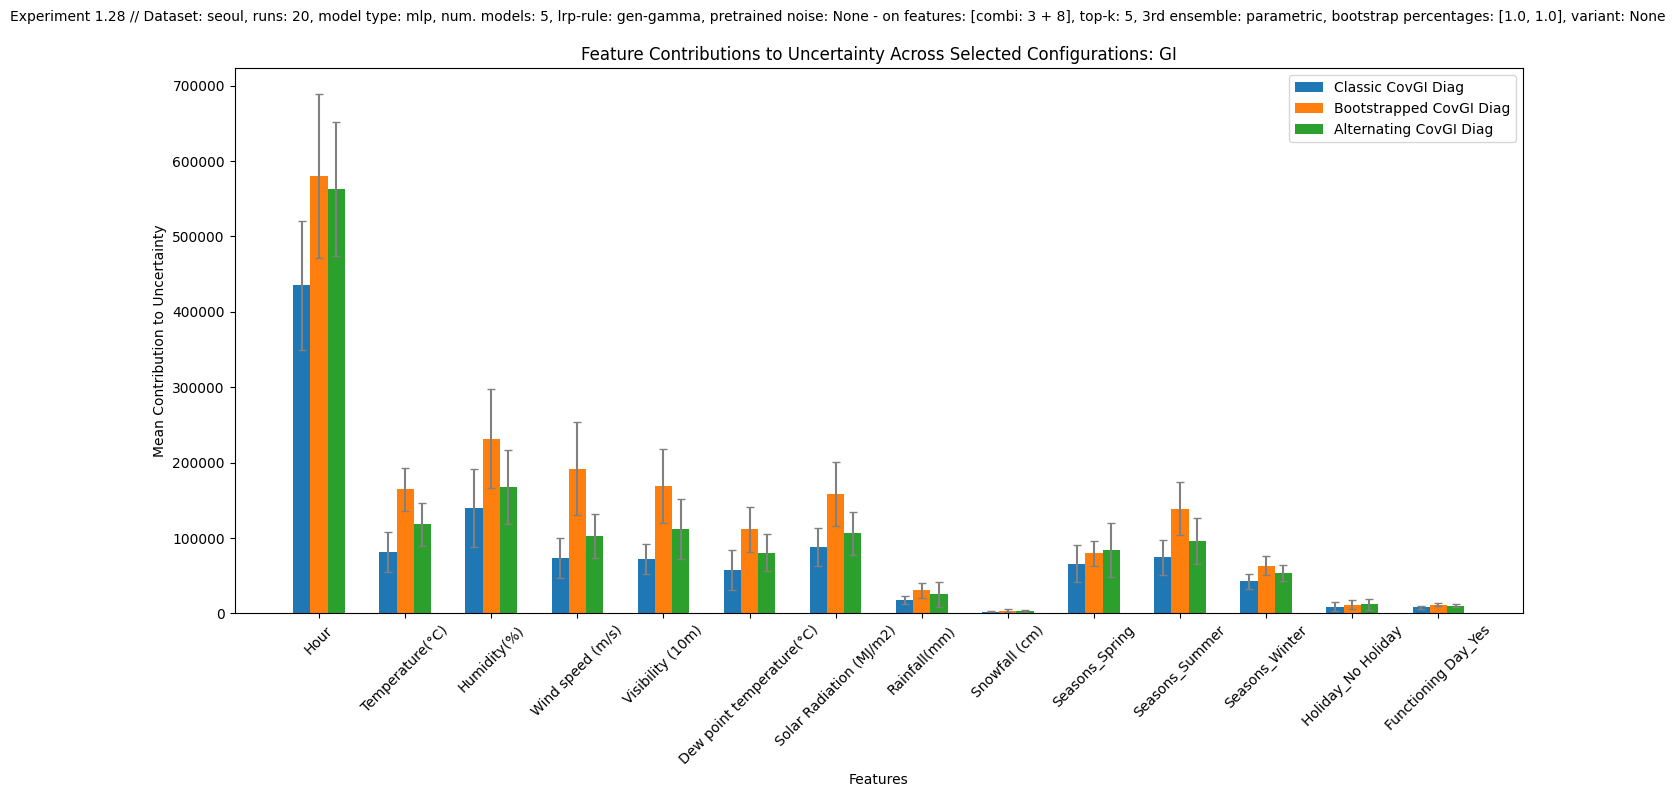

GI aug:
{'Classic CovGI Diag': ['Hour', 'Rainfall(mm)', 'Solar Radiation (MJ/m2)', 'Humidity(%)', 'Temperature(°C)', 'Functioning Day_Yes', 'Dew point temperature(°C)', 'Wind speed (m/s)', 'Visibility (10m)', 'Seasons_Winter', 'Seasons_Summer', 'Seasons_Spring', 'Snowfall (cm)', 'Holiday_No Holiday'], 'Bootstrapped CovGI Diag': ['Hour', 'Rainfall(mm)', 'Solar Radiation (MJ/m2)', 'Humidity(%)', 'Temperature(°C)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Functioning Day_Yes', 'Seasons_Summer', 'Seasons_Winter', 'Seasons_Spring', 'Snowfall (cm)', 'Holiday_No Holiday'], 'Alternating CovGI Diag': ['Hour', 'Rainfall(mm)', 'Solar Radiation (MJ/m2)', 'Humidity(%)', 'Temperature(°C)', 'Functioning Day_Yes', 'Wind speed (m/s)', 'Dew point temperature(°C)', 'Visibility (10m)', 'Seasons_Summer', 'Seasons_Winter', 'Seasons_Spring', 'Snowfall (cm)', 'Holiday_No Holiday']}
Feature Rankings for Selected Configurations:
           Classic CovGI Diag    Bootstrapped CovGI Di

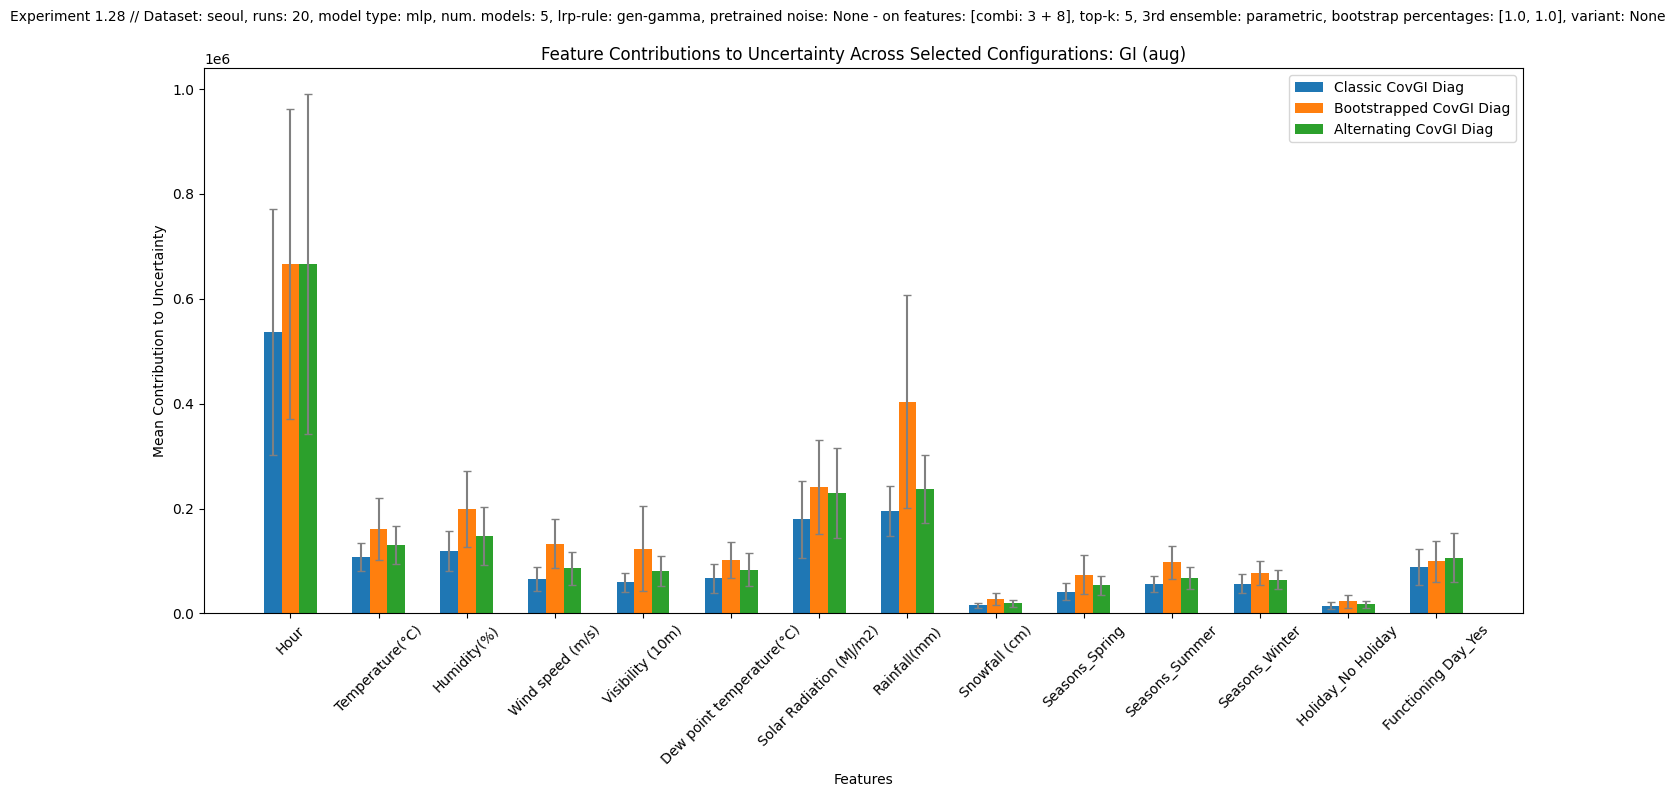

-----
LRP:
{'Classic CovLRP Diag': ['Hour', 'Humidity(%)', 'Solar Radiation (MJ/m2)', 'Wind speed (m/s)', 'Temperature(°C)', 'Visibility (10m)', 'Seasons_Summer', 'Seasons_Spring', 'Dew point temperature(°C)', 'Seasons_Winter', 'Rainfall(mm)', 'Holiday_No Holiday', 'Functioning Day_Yes', 'Snowfall (cm)'], 'Bootstrapped CovLRP Diag': ['Hour', 'Wind speed (m/s)', 'Humidity(%)', 'Visibility (10m)', 'Seasons_Summer', 'Solar Radiation (MJ/m2)', 'Temperature(°C)', 'Dew point temperature(°C)', 'Seasons_Spring', 'Seasons_Winter', 'Rainfall(mm)', 'Holiday_No Holiday', 'Functioning Day_Yes', 'Snowfall (cm)'], 'Alternating CovLRP Diag': ['Hour', 'Humidity(%)', 'Wind speed (m/s)', 'Solar Radiation (MJ/m2)', 'Visibility (10m)', 'Temperature(°C)', 'Seasons_Summer', 'Seasons_Spring', 'Dew point temperature(°C)', 'Seasons_Winter', 'Rainfall(mm)', 'Holiday_No Holiday', 'Functioning Day_Yes', 'Snowfall (cm)']}
Feature Rankings for Selected Configurations:
          Classic CovLRP Diag   Bootstrapped Cov

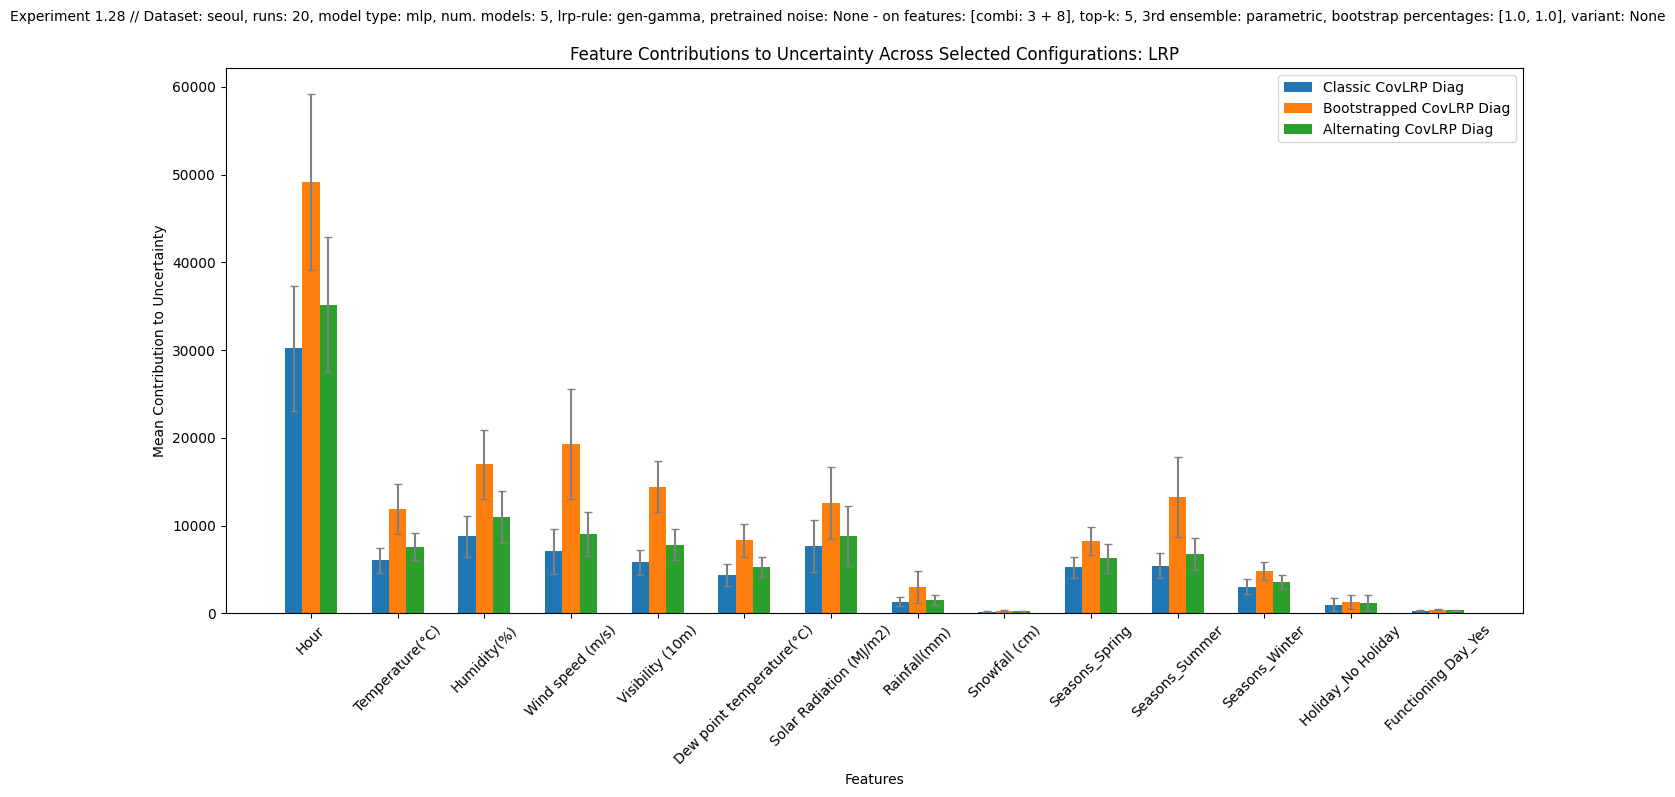

LRP aug:
{'Classic CovLRP Diag': ['Hour', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)', 'Visibility (10m)', 'Seasons_Summer', 'Seasons_Winter', 'Seasons_Spring', 'Functioning Day_Yes', 'Holiday_No Holiday', 'Snowfall (cm)'], 'Bootstrapped CovLRP Diag': ['Hour', 'Rainfall(mm)', 'Solar Radiation (MJ/m2)', 'Humidity(%)', 'Temperature(°C)', 'Wind speed (m/s)', 'Visibility (10m)', 'Seasons_Summer', 'Dew point temperature(°C)', 'Seasons_Winter', 'Seasons_Spring', 'Functioning Day_Yes', 'Snowfall (cm)', 'Holiday_No Holiday'], 'Alternating CovLRP Diag': ['Hour', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Seasons_Summer', 'Seasons_Winter', 'Seasons_Spring', 'Functioning Day_Yes', 'Snowfall (cm)', 'Holiday_No Holiday']}
Feature Rankings for Selected Configurations:
          Classic CovLRP Diag   Bootstrapped CovLR

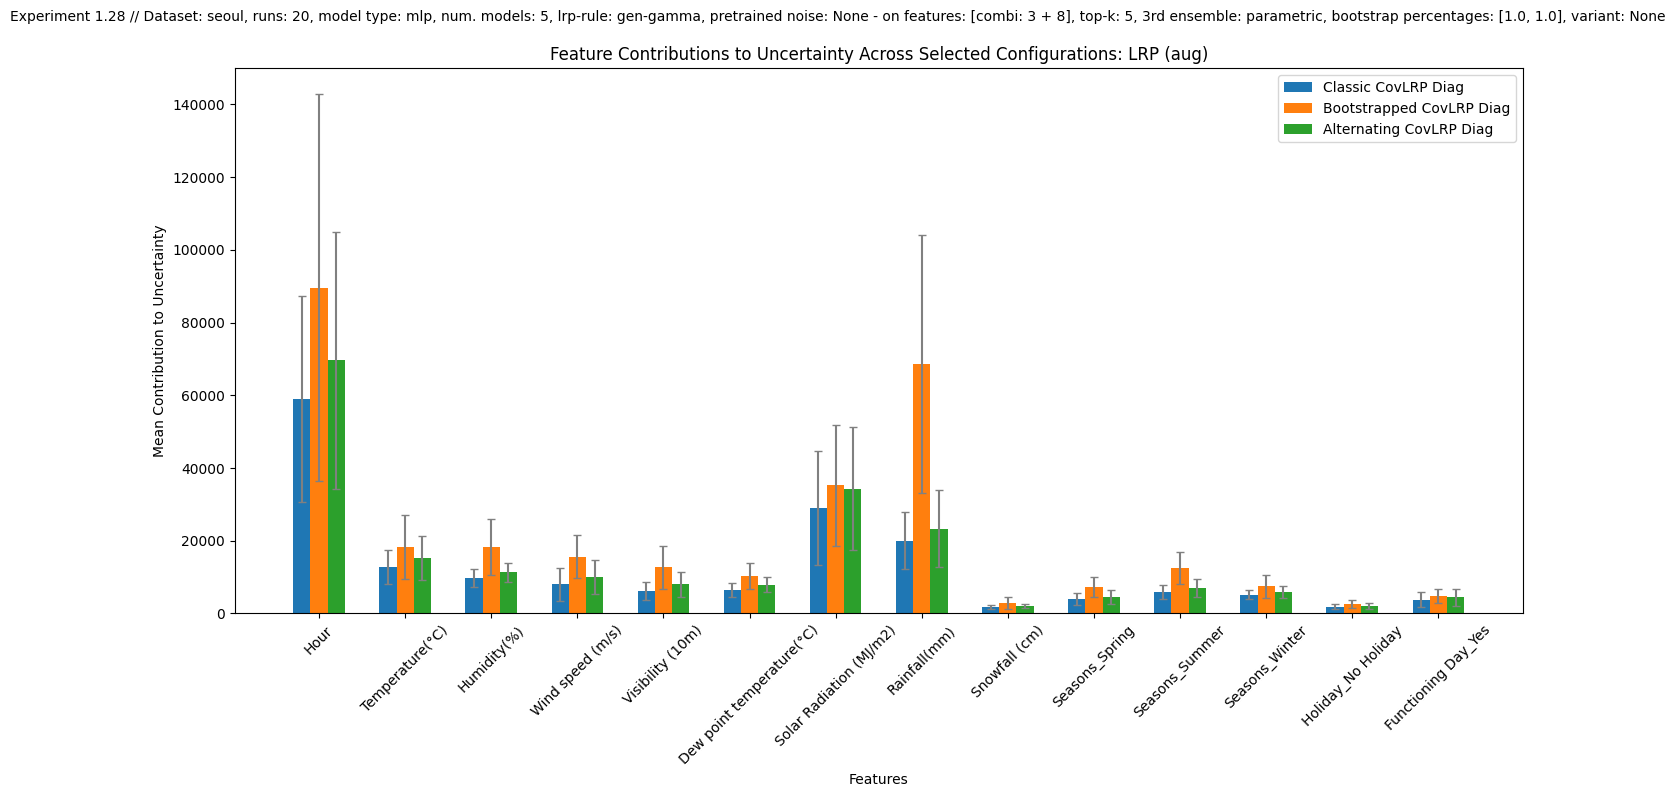

In [ ]:
import pandas as pd
import torch

# Mean contributions for the specified configurations
selected_configs_gi = {
    'Classic CovGI Diag': (o_mean_contrib_c_gi_diag, o_std_contrib_c_gi_diag),
    'Bootstrapped CovGI Diag': (o_mean_contrib_b_gi_diag, o_std_contrib_b_gi_diag),
    'Alternating CovGI Diag': (o_mean_contrib_p_gi_diag, o_std_contrib_p_gi_diag)
}

selected_configs_gi_aug = {
    'Classic CovGI Diag': (diff_o_mean_contrib_c_gi_diag, diff_o_std_contrib_c_gi_diag),
    'Bootstrapped CovGI Diag': (diff_o_mean_contrib_b_gi_diag, diff_o_std_contrib_b_gi_diag),
    'Alternating CovGI Diag': (diff_o_mean_contrib_p_gi_diag, diff_o_std_contrib_p_gi_diag)
}
selected_configs_lrp = {
    'Classic CovLRP Diag': (o_mean_contrib_c_lrp_diag, o_std_contrib_c_lrp_diag),
    'Bootstrapped CovLRP Diag': (o_mean_contrib_b_lrp_diag, o_std_contrib_b_lrp_diag),
    'Alternating CovLRP Diag': (o_mean_contrib_p_lrp_diag, o_std_contrib_p_lrp_diag)
}

selected_configs_lrp_aug = {
    'Classic CovLRP Diag': (diff_o_mean_contrib_c_lrp_diag, diff_o_std_contrib_c_lrp_diag),
    'Bootstrapped CovLRP Diag': (diff_o_mean_contrib_b_lrp_diag, diff_o_std_contrib_b_lrp_diag),
    'Alternating CovLRP Diag': (diff_o_mean_contrib_p_lrp_diag, diff_o_std_contrib_p_lrp_diag)
}

def plot_focus_plus_rankings(selected_configs, method="", experiment_info=""):
    if true_coef is not None:
      true_coef_t = torch.tensor(true_coef, dtype=torch.float32)
      selected_configs['True Coefficients'] = (true_coef_t, torch.zeros_like(true_coef_t))

    # Calculate rankings
    ranking_dict = {}
    for config_name, contributions in selected_configs.items():
        ranked_indices = torch.argsort(contributions[0], descending=True)
        ranked_features = [feature_names[i] for i in ranked_indices]
        ranking_dict[config_name] = ranked_features

    print(ranking_dict)
    # Create a DataFrame for the rankings
    rankings_df = pd.DataFrame(ranking_dict)

    # Display the rankings
    print("Feature Rankings for Selected Configurations:")
    print(rankings_df)

    # Calculate variance rankings
    variance_ranking_dict = {}
    for config_name, contributions in selected_configs.items():
        std_devs = contributions[1]
        ranked_indices = torch.argsort(std_devs, descending=True)
        ranked_features = [feature_names[i] for i in ranked_indices]
        variance_ranking_dict[config_name] = ranked_features

    # Create a DataFrame for the variance rankings
    variance_rankings_df = pd.DataFrame(variance_ranking_dict)

    # Display the variance rankings
    print("Feature Rankings by Highest Variance for Selected Configurations:")
    print(variance_rankings_df)

    # Optionally, save the table to a CSV file
    #rankings_df.to_csv('feature_rankings.csv', index=False)

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 8))

    # Define bar width and positions
    bar_width = 0.2
    index = np.arange(len(feature_names))

    # Plot each selected configuration
    for i, (config_name, (mean_contrib, std_contrib)) in enumerate(selected_configs.items()):
        ax.bar(index + i * bar_width, mean_contrib.numpy(), bar_width, yerr=std_contrib.numpy(), label=config_name, capsize=3, ecolor='grey')

    # Adding labels, title, and legend
    ax.set_xlabel('Features')
    ax.set_ylabel('Mean Contribution to Uncertainty')

    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(feature_names, rotation=45)
    ax.legend()

    plt.title('Feature Contributions to Uncertainty Across Selected Configurations: ' + method)
    plt.suptitle(experiment_info, fontsize=10, y=0.99)

    plt.tight_layout()
    plt.show()

print("-----")
print("GI:")
plot_focus_plus_rankings(selected_configs_gi, "GI", experiment_info)
print("GI aug:")
plot_focus_plus_rankings(selected_configs_gi_aug, "GI (aug)", experiment_info)
print("-----")
print("LRP:")
plot_focus_plus_rankings(selected_configs_lrp, "LRP", experiment_info)
print("LRP aug:")
plot_focus_plus_rankings(selected_configs_lrp_aug, "LRP (aug)", experiment_info)
